In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
print(torch.__version__)
import torchvision
from torchvision import datasets, transforms

import helper

0.4.1


In [116]:
data_dir = '/Users/akshaykulkarni/flowers/train/'
batch_size = 32
tf = transforms.Compose([transforms.Resize((255, 255)),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])

train_dataset = datasets.ImageFolder(data_dir, transform = tf)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

data_dir = '/Users/akshaykulkarni/flowers/test/'

test_dataset = datasets.ImageFolder(data_dir, transform = tf)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 255, 255])
torch.Size([32])
torch.Size([32])


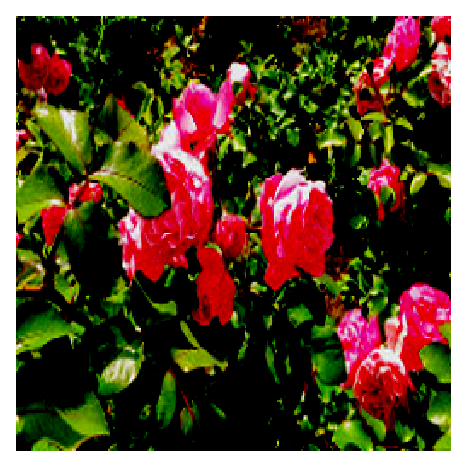

In [117]:
images, labels = next(iter(test_loader))
print(images.shape)
helper.imshow(images[0], normalize = False)
print(labels.shape)
m2 = labels.resize_(labels.shape[0])
print(m2.shape)

In [165]:
images, labels = next(iter(train_loader))
images = images.view(-1, images.shape[0]).double()
labels = labels.double()
loss, out = forward(images, labels)
print(out)
print(images[:, -1])
print(torch.mm(W.t(), images) + b)
print(sigmoid(torch.mm(W.t(), images) + b))

tensor([[1.8541e-152,  1.2070e-99, 2.6064e-120, 1.8824e-123, 9.2011e-127,
         4.7098e-132, 7.7419e-102,  1.8993e-67,  1.9121e-58,  3.8032e-61,
          3.6046e-79,  2.4411e-32,  6.9545e-08,  4.2598e-08,  4.0029e-11,
          2.9696e-47,  4.6563e-43,  8.5038e-32,  2.6872e-38,  6.8525e-01,
          1.0000e+00,  1.1644e-13,  3.6893e-30,  3.9077e-82,  3.4388e-67,
          2.7584e-42,  2.5930e-52,  8.5871e-86,  8.0723e-52,  1.6887e-03,
          1.2456e-13,  1.8618e-28]], dtype=torch.float64)
tensor([-0.3490, -0.2471, -0.2471,  ..., -0.8353,  0.0667, -0.0588],
       dtype=torch.float64)
tensor([[-349.3755, -227.7678, -275.3522, -282.5854, -290.2090, -302.3916,
         -232.8170, -153.6317, -132.9018, -139.1219, -180.6220,  -72.7903,
          -16.4813,  -16.9715,  -23.9414, -107.1331,  -97.4729,  -71.5422,
          -86.5097,    0.7780,   60.5581,  -29.7814,  -67.7721, -187.4490,
         -153.0381,  -95.6939, -118.7816, -195.8721, -117.6460,   -6.3821,
          -29.7140,  -63.8

In [166]:
m = len(train_loader) * batch_size
n = 255 * 255 * 3
learning_rate = 1e-3
W = torch.randn(n, 1).double()
b = torch.randn(1).double()
num_epochs = 25

In [160]:
def binary_cross_entropy(A, Y):
    loss = (-1 / batch_size) * (torch.matmul(torch.log(A), Y) + torch.matmul(torch.log(1 - A), (1 - Y)))
    return loss

In [161]:
def sigmoid(x):
    return (1 / (1 + torch.exp(-x)))

In [162]:
def forward(x, y):
    out = torch.add(torch.matmul(W.t(), x), b)
    out = sigmoid(out)
    # size - (1, batch_size)
    loss = binary_cross_entropy(out, y)
    return loss, out

In [163]:
def backward(A, Y, X):
    Y2 = Y.view(1, Y.shape[0])
    dz = A - Y2
    dw = (1 / batch_size) * torch.matmul(X, dz.t())
    db = (1 / batch_size) * torch.sum(dz)
    return dw, db

In [ ]:
for i in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # convert to GPU tensors
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
            W, b = W.cuda(), b.cuda()
        
        # convert to float and resize images to (n, batch_size) size
        labels = labels.double()
        images = images.view(-1, images.shape[0]).double()
        images /= 255
        
        loss, pred = forward(images, labels)
        epoch_loss += loss.item()
        
        dw, db = backward(pred, labels, images)
        
        # updating weights
        W = W - (learning_rate * dw)
        b = b - (learning_rate * db)
    
#     print(W)
#     print(b)
        
    epoch_loss /= batch_size
    print('Loss at epoch ', i, ' = ', epoch_loss)

Loss at epoch  0  =  1.5840315893966745
Loss at epoch  1  =  1.5636345153756541
Loss at epoch  2  =  1.5603782777104418
Loss at epoch  3  =  1.457766933432183
Loss at epoch  4  =  1.3318040709610475
Loss at epoch  5  =  1.431355269582064


In [131]:
acc = 0
for batch_idx, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        W = W.cuda()
        b = b.cuda()
    labels = labels.double()
    images = images.view(-1, images.shape[0]).double()
    images /= 255

    loss, pred = forward(images, labels)
    pred = (pred >= 0.5)

    pred = pred.view(pred.shape[1])
    mismatch = torch.sum(torch.eq(pred, labels.byte()))
    acc += mismatch.item()

acc /= (len(train_loader) * batch_size)
print('Training accuracy = ', acc * 100)

acc = 0
for batch_idx, (images, labels) in enumerate(test_loader):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        W = W.cuda()
        b = b.cuda()
    labels = labels.double()
    images = images.view(-1, images.shape[0]).double()
    images /= 255

    loss, pred = forward(images, labels)
    pred = (pred >= 0.5)

    pred = pred.view(pred.shape[1])
    mismatch = torch.sum(torch.eq(pred, labels.byte()))
    acc += mismatch.item()

acc /= (len(test_loader) * batch_size)
print('Validation accuracy = ', acc * 100)

Training accuracy =  52.13068181818182
Validation accuracy =  53.90625


In [37]:
a = torch.randn((2, 3))
print(a)
print(W)
print(b)

tensor([[-1.1650, -0.8320, -0.0902],
        [-0.1518, -0.9138,  0.2939]])
tensor([[-0.0345],
        [-0.6512],
        [ 0.0733],
        ...,
        [-0.3884],
        [ 0.0124],
        [ 1.1728]])
tensor(-0.0102)


In [125]:
b = torch.transpose(a, 1, 0)
print(b)

tensor([[ 1.0537,  1.7875],
        [-0.1413,  0.5772],
        [-1.7341, -0.5618]])


In [17]:
a = a > 0.5
print(a)

tensor([[0, 1, 0],
        [0, 0, 1]], dtype=torch.uint8)


In [20]:
print(len(train_loader) * batch_size)

1408


In [92]:
print(images[:, -1])
for j in images[:, -1]:
    print(j)

tensor([0.2078, 0.3529, 0.2824,  ..., 0.2039, 0.1529, 0.0118])
tensor(0.2078)
tensor(0.3529)
tensor(0.2824)
tensor(0.3020)
tensor(0.3843)
tensor(0.1373)
tensor(0.4549)
tensor(0.1647)
tensor(0.2000)
tensor(0.4235)
tensor(0.2784)
tensor(0.3059)
tensor(0.3647)
tensor(0.5137)
tensor(0.5333)
tensor(0.2627)
tensor(0.2667)
tensor(0.3333)
tensor(0.3137)
tensor(0.2784)
tensor(0.3255)
tensor(0.4549)
tensor(0.6784)
tensor(0.3255)
tensor(0.2980)
tensor(0.3333)
tensor(0.3294)
tensor(0.3137)
tensor(0.3608)
tensor(0.3529)
tensor(0.3451)
tensor(0.2784)
tensor(0.3176)
tensor(0.3373)
tensor(0.3255)
tensor(0.4471)
tensor(0.3608)
tensor(0.3333)
tensor(0.5569)
tensor(0.2510)
tensor(0.2980)
tensor(0.2902)
tensor(0.4039)
tensor(0.4392)
tensor(0.3451)
tensor(0.3020)
tensor(0.6510)
tensor(0.3569)
tensor(0.3529)
tensor(0.3412)
tensor(0.2824)
tensor(0.4784)
tensor(0.3216)
tensor(0.3294)
tensor(0.6431)
tensor(0.3686)
tensor(0.2941)
tensor(0.3176)
tensor(0.4196)
tensor(0.4118)
tensor(0.3137)
tensor(0.3373)
tensor(

tensor(0.3255)
tensor(0.3922)
tensor(0.7765)
tensor(0.5961)
tensor(0.4941)
tensor(0.5137)
tensor(0.2980)
tensor(0.4471)
tensor(0.3333)
tensor(0.3608)
tensor(0.8784)
tensor(0.6078)
tensor(0.4706)
tensor(0.5098)
tensor(0.3765)
tensor(0.4706)
tensor(0.1137)
tensor(0.3882)
tensor(0.9294)
tensor(0.6078)
tensor(0.4235)
tensor(0.5216)
tensor(0.7255)
tensor(0.4392)
tensor(0.1255)
tensor(0.4000)
tensor(0.8000)
tensor(0.6235)
tensor(0.4039)
tensor(0.5059)
tensor(0.8902)
tensor(0.6627)
tensor(0.1333)
tensor(0.3490)
tensor(0.4863)
tensor(0.6471)
tensor(0.4196)
tensor(0.5020)
tensor(0.7255)
tensor(0.4549)
tensor(0.4471)
tensor(0.3647)
tensor(0.6745)
tensor(0.6314)
tensor(0.4314)
tensor(0.5137)
tensor(0.2392)
tensor(0.4784)
tensor(0.4588)
tensor(0.3686)
tensor(0.6078)
tensor(0.6235)
tensor(0.4314)
tensor(0.5059)
tensor(0.5804)
tensor(0.4549)
tensor(0.2784)
tensor(0.2824)
tensor(0.7137)
tensor(0.4431)
tensor(0.4235)
tensor(0.5216)
tensor(0.7882)
tensor(0.4078)
tensor(0.2627)
tensor(0.4588)
tensor(0.9

tensor(0.6275)
tensor(0.5608)
tensor(0.4627)
tensor(0.3725)
tensor(0.5059)
tensor(0.4549)
tensor(0.2588)
tensor(0.5843)
tensor(0.6118)
tensor(0.6118)
tensor(0.4784)
tensor(0.3490)
tensor(0.5294)
tensor(0.4431)
tensor(0.2784)
tensor(0.5686)
tensor(0.6471)
tensor(0.6078)
tensor(0.5647)
tensor(0.4510)
tensor(0.5255)
tensor(0.4392)
tensor(0.2392)
tensor(0.5765)
tensor(0.6353)
tensor(0.6157)
tensor(0.6549)
tensor(0.4275)
tensor(0.5137)
tensor(0.4392)
tensor(0.2196)
tensor(0.5961)
tensor(0.6196)
tensor(0.6118)
tensor(0.6314)
tensor(0.4863)
tensor(0.4980)
tensor(0.4314)
tensor(0.2000)
tensor(0.5961)
tensor(0.6157)
tensor(0.6157)
tensor(0.6275)
tensor(0.5451)
tensor(0.5098)
tensor(0.4157)
tensor(0.3686)
tensor(0.5765)
tensor(0.6392)
tensor(0.6196)
tensor(0.6314)
tensor(0.5373)
tensor(0.5176)
tensor(0.4078)
tensor(0.4902)
tensor(0.5451)
tensor(0.6118)
tensor(0.6039)
tensor(0.6157)
tensor(0.5333)
tensor(0.4980)
tensor(0.4078)
tensor(0.5490)
tensor(0.6039)
tensor(0.6392)
tensor(0.6275)
tensor(0.6

tensor(0.5843)
tensor(0.6588)
tensor(0.6118)
tensor(0.6667)
tensor(0.6941)
tensor(0.6510)
tensor(0.6196)
tensor(0.5725)
tensor(0.6235)
tensor(0.6392)
tensor(0.6353)
tensor(0.6549)
tensor(0.6667)
tensor(0.6667)
tensor(0.6667)
tensor(0.6235)
tensor(0.6118)
tensor(0.6510)
tensor(0.6510)
tensor(0.7098)
tensor(0.6510)
tensor(0.6667)
tensor(0.6549)
tensor(0.6353)
tensor(0.6157)
tensor(0.6314)
tensor(0.5843)
tensor(0.6471)
tensor(0.6157)
tensor(0.6706)
tensor(0.6627)
tensor(0.6235)
tensor(0.6235)
tensor(0.5608)
tensor(0.6431)
tensor(0.6431)
tensor(0.6078)
tensor(0.1529)
tensor(0.1804)
tensor(0.3176)
tensor(0.2392)
tensor(0.4471)
tensor(0.1098)
tensor(0.3804)
tensor(0.5804)
tensor(0.1333)
tensor(0.2510)
tensor(0.2667)
tensor(0.2392)
tensor(0.3255)
tensor(0.3255)
tensor(0.4471)
tensor(0.2627)
tensor(0.2000)
tensor(0.3686)
tensor(0.2549)
tensor(0.2431)
tensor(0.3059)
tensor(0.4196)
tensor(0.4745)
tensor(0.1882)
tensor(0.2235)
tensor(0.2980)
tensor(0.2549)
tensor(0.2588)
tensor(0.3294)
tensor(0.3

tensor(0.5647)
tensor(0.5373)
tensor(0.4745)
tensor(0.3804)
tensor(0.3882)
tensor(0.4510)
tensor(0.4824)
tensor(0.5059)
tensor(0.5412)
tensor(0.5529)
tensor(0.5059)
tensor(0.3922)
tensor(0.3882)
tensor(0.4353)
tensor(0.4824)
tensor(0.4941)
tensor(0.5176)
tensor(0.5882)
tensor(0.4706)
tensor(0.3804)
tensor(0.3843)
tensor(0.4314)
tensor(0.4824)
tensor(0.4588)
tensor(0.8078)
tensor(0.4863)
tensor(0.4392)
tensor(0.3922)
tensor(0.3882)
tensor(0.4353)
tensor(0.6196)
tensor(0.4824)
tensor(0.8824)
tensor(0.4667)
tensor(0.3294)
tensor(0.3804)
tensor(0.3922)
tensor(0.4275)
tensor(0.6353)
tensor(0.4549)
tensor(0.7373)
tensor(0.4863)
tensor(0.2353)
tensor(0.3647)
tensor(0.3843)
tensor(0.4157)
tensor(0.6941)
tensor(0.4392)
tensor(0.5843)
tensor(0.2784)
tensor(0.3216)
tensor(0.3569)
tensor(0.3882)
tensor(0.4000)
tensor(0.7882)
tensor(0.4706)
tensor(0.3843)
tensor(0.2784)
tensor(0.6588)
tensor(0.3569)
tensor(0.3608)
tensor(0.5020)
tensor(0.7490)
tensor(0.4941)
tensor(0.3216)
tensor(0.4235)
tensor(0.6

tensor(0.7686)
tensor(0.2431)
tensor(0.5255)
tensor(0.2745)
tensor(0.5255)
tensor(0.5020)
tensor(0.4784)
tensor(0.4667)
tensor(0.5843)
tensor(0.2745)
tensor(0.5451)
tensor(0.3412)
tensor(0.5255)
tensor(0.5098)
tensor(0.5176)
tensor(0.4549)
tensor(0.6588)
tensor(0.2824)
tensor(0.5255)
tensor(0.3490)
tensor(0.5373)
tensor(0.4863)
tensor(0.4314)
tensor(0.5098)
tensor(0.7098)
tensor(0.3490)
tensor(0.6549)
tensor(0.3451)
tensor(0.5333)
tensor(0.4824)
tensor(0.5333)
tensor(0.4902)
tensor(0.7216)
tensor(0.3804)
tensor(0.6118)
tensor(0.2941)
tensor(0.5451)
tensor(0.5020)
tensor(0.6235)
tensor(0.5490)
tensor(0.6510)
tensor(0.4039)
tensor(0.5333)
tensor(0.3765)
tensor(0.5216)
tensor(0.5373)
tensor(0.5961)
tensor(0.6157)
tensor(0.7333)
tensor(0.3490)
tensor(0.5725)
tensor(0.3922)
tensor(0.5137)
tensor(0.6078)
tensor(0.5725)
tensor(0.6353)
tensor(0.5843)
tensor(0.3804)
tensor(0.6196)
tensor(0.4706)
tensor(0.5137)
tensor(0.6275)
tensor(0.5451)
tensor(0.6353)
tensor(0.5608)
tensor(0.4980)
tensor(0.5

tensor(0.5333)
tensor(0.5608)
tensor(0.6824)
tensor(0.6078)
tensor(0.5020)
tensor(0.5098)
tensor(0.4863)
tensor(0.3451)
tensor(0.5255)
tensor(0.6471)
tensor(0.7059)
tensor(0.6118)
tensor(0.5098)
tensor(0.5176)
tensor(0.4941)
tensor(0.3725)
tensor(0.4980)
tensor(0.6235)
tensor(0.7255)
tensor(0.6275)
tensor(0.4980)
tensor(0.5333)
tensor(0.5412)
tensor(0.4157)
tensor(0.5098)
tensor(0.6471)
tensor(0.6392)
tensor(0.6235)
tensor(0.4824)
tensor(0.5098)
tensor(0.5373)
tensor(0.4314)
tensor(0.4941)
tensor(0.6431)
tensor(0.6314)
tensor(0.6353)
tensor(0.5137)
tensor(0.4902)
tensor(0.5294)
tensor(0.4627)
tensor(0.4745)
tensor(0.7529)
tensor(0.6706)
tensor(0.6745)
tensor(0.5098)
tensor(0.5176)
tensor(0.5569)
tensor(0.5020)
tensor(0.3255)
tensor(0.7020)
tensor(0.6941)
tensor(0.6706)
tensor(0.5216)
tensor(0.5255)
tensor(0.5725)
tensor(0.5490)
tensor(0.4471)
tensor(0.6627)
tensor(0.7020)
tensor(0.6471)
tensor(0.5255)
tensor(0.5333)
tensor(0.5725)
tensor(0.5765)
tensor(0.5569)
tensor(0.6353)
tensor(0.7

tensor(0.2471)
tensor(0.1490)
tensor(0.9529)
tensor(0.6275)
tensor(0.4431)
tensor(0.4157)
tensor(0.5294)
tensor(0.6353)
tensor(0.2471)
tensor(0.2353)
tensor(0.9216)
tensor(0.6941)
tensor(0.4235)
tensor(0.4000)
tensor(0.5255)
tensor(0.6118)
tensor(0.2941)
tensor(0.2588)
tensor(0.9569)
tensor(0.5765)
tensor(0.4196)
tensor(0.3961)
tensor(0.5216)
tensor(0.6118)
tensor(0.2510)
tensor(0.1451)
tensor(0.9098)
tensor(0.2588)
tensor(0.4078)
tensor(0.4118)
tensor(0.5176)
tensor(0.5882)
tensor(0.1569)
tensor(0.2706)
tensor(0.9176)
tensor(0.1804)
tensor(0.3882)
tensor(0.4118)
tensor(0.5137)
tensor(0.5961)
tensor(0.1294)
tensor(0.6627)
tensor(0.8745)
tensor(0.3608)
tensor(0.3843)
tensor(0.4235)
tensor(0.5216)
tensor(0.6235)
tensor(0.1020)
tensor(0.2863)
tensor(0.8667)
tensor(0.3765)
tensor(0.3882)
tensor(0.4118)
tensor(0.5059)
tensor(0.6314)
tensor(0.0510)
tensor(0.2941)
tensor(0.8235)
tensor(0.4157)
tensor(0.3961)
tensor(0.3804)
tensor(0.5216)
tensor(0.5961)
tensor(0.0745)
tensor(0.8431)
tensor(0.8

tensor(0.1647)
tensor(0.1059)
tensor(0.5098)
tensor(0.2431)
tensor(0.2824)
tensor(0.2078)
tensor(0.0078)
tensor(0.1373)
tensor(0.1725)
tensor(0.1412)
tensor(0.5176)
tensor(0.2431)
tensor(0.3294)
tensor(0.2431)
tensor(0.0314)
tensor(0.2078)
tensor(0.2745)
tensor(0.1490)
tensor(0.5216)
tensor(0.2353)
tensor(0.3020)
tensor(0.1725)
tensor(0.0471)
tensor(0.3804)
tensor(0.2745)
tensor(0.2275)
tensor(0.5529)
tensor(0.2275)
tensor(0.3216)
tensor(0.1804)
tensor(0.)
tensor(0.1294)
tensor(0.2824)
tensor(0.1765)
tensor(0.4039)
tensor(0.2118)
tensor(0.2314)
tensor(0.1608)
tensor(0.0549)
tensor(0.1294)
tensor(0.2706)
tensor(0.2824)
tensor(0.4235)
tensor(0.2667)
tensor(0.2667)
tensor(0.2118)
tensor(0.0039)
tensor(0.1608)
tensor(0.2078)
tensor(0.2471)
tensor(0.4392)
tensor(0.3686)
tensor(0.3216)
tensor(0.2824)
tensor(0.0588)
tensor(0.2824)
tensor(0.2510)
tensor(0.0745)
tensor(0.4314)
tensor(0.3176)
tensor(0.3216)
tensor(0.2196)
tensor(0.0235)
tensor(0.3333)
tensor(0.2824)
tensor(0.0627)
tensor(0.3804)

tensor(0.5255)
tensor(0.7725)
tensor(0.7922)
tensor(0.7961)
tensor(0.5412)
tensor(0.5765)
tensor(0.6235)
tensor(0.4824)
tensor(0.5451)
tensor(0.7961)
tensor(0.8000)
tensor(0.7961)
tensor(0.5529)
tensor(0.5843)
tensor(0.6039)
tensor(0.4667)
tensor(0.5608)
tensor(0.8039)
tensor(0.8039)
tensor(0.5765)
tensor(0.5608)
tensor(0.5922)
tensor(0.5804)
tensor(0.5098)
tensor(0.5608)
tensor(0.7765)
tensor(0.8000)
tensor(0.5843)
tensor(0.5765)
tensor(0.5961)
tensor(0.5490)
tensor(0.5255)
tensor(0.5647)
tensor(0.7922)
tensor(0.7216)
tensor(0.5882)
tensor(0.5608)
tensor(0.6000)
tensor(0.5216)
tensor(0.5059)
tensor(0.5686)
tensor(0.8000)
tensor(0.7333)
tensor(0.5922)
tensor(0.5490)
tensor(0.6039)
tensor(0.5098)
tensor(0.4941)
tensor(0.5529)
tensor(0.8039)
tensor(0.7647)
tensor(0.5922)
tensor(0.5333)
tensor(0.5961)
tensor(0.5216)
tensor(0.5059)
tensor(0.5647)
tensor(0.7647)
tensor(0.7255)
tensor(0.5961)
tensor(0.5373)
tensor(0.5725)
tensor(0.5020)
tensor(0.4941)
tensor(0.5725)
tensor(0.7765)
tensor(0.7

tensor(0.4196)
tensor(0.5059)
tensor(0.7647)
tensor(0.6431)
tensor(0.3647)
tensor(0.3725)
tensor(0.3176)
tensor(0.6314)
tensor(0.4235)
tensor(0.5137)
tensor(0.7490)
tensor(0.6157)
tensor(0.3686)
tensor(0.3412)
tensor(0.3137)
tensor(0.6745)
tensor(0.4235)
tensor(0.5216)
tensor(0.7255)
tensor(0.5922)
tensor(0.3529)
tensor(0.3373)
tensor(0.4353)
tensor(0.6941)
tensor(0.4314)
tensor(0.5294)
tensor(0.7098)
tensor(0.6039)
tensor(0.3490)
tensor(0.3216)
tensor(0.5804)
tensor(0.7020)
tensor(0.4431)
tensor(0.5216)
tensor(0.6941)
tensor(0.6235)
tensor(0.3412)
tensor(0.3412)
tensor(0.6353)
tensor(0.7020)
tensor(0.4588)
tensor(0.5137)
tensor(0.6667)
tensor(0.6431)
tensor(0.3373)
tensor(0.3608)
tensor(0.6392)
tensor(0.7020)
tensor(0.4784)
tensor(0.5020)
tensor(0.6510)
tensor(0.6549)
tensor(0.3647)
tensor(0.3647)
tensor(0.6275)
tensor(0.7020)
tensor(0.4784)
tensor(0.4745)
tensor(0.6275)
tensor(0.6549)
tensor(0.4627)
tensor(0.3765)
tensor(0.5804)
tensor(0.6275)
tensor(0.4745)
tensor(0.4314)
tensor(0.5

tensor(0.7255)
tensor(0.8039)
tensor(0.5569)
tensor(0.6314)
tensor(0.9765)
tensor(0.4353)
tensor(0.5804)
tensor(0.4980)
tensor(0.6471)
tensor(0.8196)
tensor(0.5294)
tensor(0.6588)
tensor(0.9843)
tensor(0.4784)
tensor(0.4549)
tensor(0.5020)
tensor(0.5529)
tensor(0.7569)
tensor(0.6118)
tensor(0.7176)
tensor(0.9882)
tensor(0.4471)
tensor(0.4039)
tensor(0.4941)
tensor(0.4549)
tensor(0.5843)
tensor(0.8039)
tensor(0.7686)
tensor(0.9843)
tensor(0.4667)
tensor(0.3843)
tensor(0.4784)
tensor(0.3490)
tensor(0.5059)
tensor(0.8196)
tensor(0.8039)
tensor(0.9922)
tensor(0.3961)
tensor(0.3608)
tensor(0.4627)
tensor(0.3176)
tensor(0.4863)
tensor(0.8235)
tensor(0.8118)
tensor(0.9922)
tensor(0.4157)
tensor(0.3569)
tensor(0.4549)
tensor(0.3294)
tensor(0.4745)
tensor(0.8157)
tensor(0.8157)
tensor(0.9882)
tensor(0.4353)
tensor(0.3490)
tensor(0.4549)
tensor(0.3451)
tensor(0.4627)
tensor(0.8000)
tensor(0.8275)
tensor(0.9882)
tensor(0.4353)
tensor(0.3686)
tensor(0.4392)
tensor(0.3608)
tensor(0.4745)
tensor(0.7

tensor(0.8078)
tensor(0.7608)
tensor(0.4706)
tensor(0.4549)
tensor(0.5647)
tensor(0.7216)
tensor(0.6353)
tensor(0.7529)
tensor(0.8039)
tensor(0.7059)
tensor(0.4706)
tensor(0.3333)
tensor(0.4667)
tensor(0.7294)
tensor(0.6745)
tensor(0.7686)
tensor(0.8157)
tensor(0.7333)
tensor(0.4588)
tensor(0.2941)
tensor(0.6627)
tensor(0.6980)
tensor(0.7490)
tensor(0.8039)
tensor(0.7647)
tensor(0.8431)
tensor(0.6275)
tensor(0.3333)
tensor(0.4275)
tensor(0.7059)
tensor(0.7647)
tensor(0.7725)
tensor(0.8392)
tensor(0.8157)
tensor(0.7882)
tensor(0.3608)
tensor(0.6980)
tensor(0.7137)
tensor(0.8667)
tensor(0.8039)
tensor(0.8431)
tensor(0.8392)
tensor(0.8078)
tensor(0.6471)
tensor(0.7137)
tensor(0.7843)
tensor(0.8431)
tensor(0.8196)
tensor(0.8353)
tensor(0.8510)
tensor(0.8314)
tensor(0.7843)
tensor(0.5725)
tensor(0.5725)
tensor(0.8392)
tensor(0.7961)
tensor(0.7647)
tensor(0.7137)
tensor(0.8157)
tensor(0.8000)
tensor(0.6235)
tensor(0.6000)
tensor(0.8902)
tensor(0.7804)
tensor(0.5804)
tensor(0.6078)
tensor(0.7

tensor(0.3882)
tensor(0.3529)
tensor(0.5529)
tensor(0.2078)
tensor(0.2000)
tensor(0.1451)
tensor(0.3490)
tensor(0.3569)
tensor(0.3804)
tensor(0.3373)
tensor(0.5529)
tensor(0.2078)
tensor(0.1804)
tensor(0.1647)
tensor(0.3412)
tensor(0.3529)
tensor(0.3529)
tensor(0.3176)
tensor(0.5686)
tensor(0.2039)
tensor(0.2039)
tensor(0.2314)
tensor(0.2863)
tensor(0.3216)
tensor(0.3176)
tensor(0.5020)
tensor(0.5686)
tensor(0.2039)
tensor(0.3059)
tensor(0.3098)
tensor(0.2196)
tensor(0.2745)
tensor(0.2784)
tensor(0.4980)
tensor(0.5255)
tensor(0.2353)
tensor(0.4275)
tensor(0.3882)
tensor(0.2118)
tensor(0.2588)
tensor(0.2392)
tensor(0.4667)
tensor(0.4314)
tensor(0.2784)
tensor(0.5216)
tensor(0.4275)
tensor(0.2275)
tensor(0.2549)
tensor(0.2235)
tensor(0.4353)
tensor(0.3059)
tensor(0.3176)
tensor(0.5569)
tensor(0.4314)
tensor(0.2275)
tensor(0.2471)
tensor(0.2078)
tensor(0.4039)
tensor(0.2196)
tensor(0.3373)
tensor(0.5686)
tensor(0.4314)
tensor(0.2196)
tensor(0.2353)
tensor(0.1922)
tensor(0.4039)
tensor(0.2

tensor(0.4314)
tensor(0.3255)
tensor(0.2941)
tensor(0.3451)
tensor(0.4627)
tensor(0.3059)
tensor(0.1725)
tensor(0.3373)
tensor(0.4235)
tensor(0.4392)
tensor(0.2941)
tensor(0.3725)
tensor(0.5765)
tensor(0.2863)
tensor(0.1804)
tensor(0.3961)
tensor(0.4078)
tensor(0.4157)
tensor(0.2902)
tensor(0.4196)
tensor(0.4353)
tensor(0.2980)
tensor(0.1843)
tensor(0.3765)
tensor(0.4039)
tensor(0.3765)
tensor(0.2745)
tensor(0.4863)
tensor(0.5765)
tensor(0.3176)
tensor(0.1804)
tensor(0.3137)
tensor(0.4118)
tensor(0.4196)
tensor(0.2588)
tensor(0.5412)
tensor(0.4000)
tensor(0.4235)
tensor(0.1804)
tensor(0.2824)
tensor(0.4118)
tensor(0.3333)
tensor(0.2549)
tensor(0.5686)
tensor(0.4902)
tensor(0.4627)
tensor(0.1765)
tensor(0.2353)
tensor(0.4275)
tensor(0.3137)
tensor(0.2627)
tensor(0.5608)
tensor(0.4275)
tensor(0.5961)
tensor(0.1804)
tensor(0.2353)
tensor(0.4353)
tensor(0.3765)
tensor(0.2706)
tensor(0.5059)
tensor(0.5098)
tensor(0.5451)
tensor(0.2275)
tensor(0.2353)
tensor(0.4235)
tensor(0.4392)
tensor(0.2

tensor(0.0235)
tensor(0.2353)
tensor(0.2784)
tensor(0.5412)
tensor(0.7725)
tensor(0.2471)
tensor(0.4314)
tensor(0.2980)
tensor(0.0902)
tensor(0.2431)
tensor(0.2784)
tensor(0.5725)
tensor(0.7216)
tensor(0.2980)
tensor(0.4588)
tensor(0.4431)
tensor(0.1255)
tensor(0.3490)
tensor(0.2667)
tensor(0.5569)
tensor(0.6980)
tensor(0.3020)
tensor(0.4863)
tensor(0.4000)
tensor(0.1137)
tensor(0.2549)
tensor(0.2314)
tensor(0.5608)
tensor(0.6980)
tensor(0.4510)
tensor(0.4549)
tensor(0.4745)
tensor(0.0863)
tensor(0.0745)
tensor(0.2157)
tensor(0.5686)
tensor(0.6588)
tensor(0.3059)
tensor(0.4941)
tensor(0.5216)
tensor(0.0235)
tensor(0.2549)
tensor(0.2118)
tensor(0.5647)
tensor(0.6471)
tensor(0.3176)
tensor(0.5608)
tensor(0.6078)
tensor(0.0784)
tensor(0.1333)
tensor(0.2078)
tensor(0.5686)
tensor(0.6392)
tensor(0.3608)
tensor(0.6118)
tensor(0.5725)
tensor(0.1725)
tensor(0.1294)
tensor(0.1843)
tensor(0.5647)
tensor(0.6196)
tensor(0.3255)
tensor(0.6000)
tensor(0.4275)
tensor(0.3373)
tensor(0.2627)
tensor(0.1

tensor(0.6902)
tensor(0.8431)
tensor(0.8627)
tensor(0.8510)
tensor(0.6275)
tensor(0.6431)
tensor(0.5882)
tensor(0.6471)
tensor(0.6980)
tensor(0.7255)
tensor(0.7569)
tensor(0.7608)
tensor(0.6745)
tensor(0.5255)
tensor(0.5137)
tensor(0.6588)
tensor(0.6824)
tensor(0.7765)
tensor(0.5333)
tensor(0.6588)
tensor(0.6745)
tensor(0.5176)
tensor(0.4118)
tensor(0.6314)
tensor(0.6863)
tensor(0.7765)
tensor(0.7765)
tensor(0.6941)
tensor(0.6627)
tensor(0.5333)
tensor(0.4196)
tensor(0.6431)
tensor(0.7529)
tensor(0.6863)
tensor(0.8275)
tensor(0.7608)
tensor(0.6706)
tensor(0.5961)
tensor(0.4627)
tensor(0.6078)
tensor(0.7843)
tensor(0.6314)
tensor(0.8078)
tensor(0.7725)
tensor(0.6902)
tensor(0.6353)
tensor(0.4784)
tensor(0.5804)
tensor(0.7882)
tensor(0.7490)
tensor(0.7804)
tensor(0.8157)
tensor(0.7020)
tensor(0.6706)
tensor(0.5412)
tensor(0.4627)
tensor(0.8314)
tensor(0.8784)
tensor(0.8588)
tensor(0.8314)
tensor(0.7294)
tensor(0.6549)
tensor(0.5686)
tensor(0.4196)
tensor(0.8353)
tensor(0.8235)
tensor(0.8

tensor(0.2392)
tensor(0.4078)
tensor(0.2588)
tensor(0.2392)
tensor(0.1412)
tensor(0.0588)
tensor(0.1725)
tensor(0.1647)
tensor(0.3765)
tensor(0.3686)
tensor(0.2627)
tensor(0.1137)
tensor(0.1882)
tensor(0.0588)
tensor(0.1804)
tensor(0.1686)
tensor(0.2471)
tensor(0.3294)
tensor(0.2667)
tensor(0.0902)
tensor(0.1725)
tensor(0.0510)
tensor(0.1843)
tensor(0.1647)
tensor(0.2510)
tensor(0.3020)
tensor(0.2431)
tensor(0.1176)
tensor(0.2510)
tensor(0.0588)
tensor(0.1804)
tensor(0.1647)
tensor(0.2784)
tensor(0.3020)
tensor(0.2471)
tensor(0.1098)
tensor(0.2039)
tensor(0.0667)
tensor(0.1804)
tensor(0.1725)
tensor(0.4863)
tensor(0.3098)
tensor(0.2745)
tensor(0.1176)
tensor(0.2196)
tensor(0.0784)
tensor(0.1725)
tensor(0.1804)
tensor(0.5255)
tensor(0.3020)
tensor(0.2353)
tensor(0.1529)
tensor(0.1882)
tensor(0.0784)
tensor(0.1725)
tensor(0.1804)
tensor(0.1490)
tensor(0.2902)
tensor(0.1686)
tensor(0.1882)
tensor(0.2353)
tensor(0.0941)
tensor(0.1765)
tensor(0.1765)
tensor(0.1255)
tensor(0.2471)
tensor(0.1

tensor(0.2902)
tensor(0.3725)
tensor(0.0902)
tensor(0.2392)
tensor(0.3176)
tensor(0.1373)
tensor(0.3137)
tensor(0.4980)
tensor(0.2588)
tensor(0.3922)
tensor(0.3765)
tensor(0.1490)
tensor(0.2745)
tensor(0.1373)
tensor(0.2392)
tensor(0.4627)
tensor(0.2588)
tensor(0.4235)
tensor(0.2431)
tensor(0.1804)
tensor(0.2941)
tensor(0.1451)
tensor(0.2118)
tensor(0.3804)
tensor(0.2627)
tensor(0.4431)
tensor(0.2275)
tensor(0.2000)
tensor(0.2157)
tensor(0.1569)
tensor(0.2118)
tensor(0.2941)
tensor(0.3647)
tensor(0.4667)
tensor(0.2471)
tensor(0.1961)
tensor(0.1922)
tensor(0.1569)
tensor(0.1569)
tensor(0.2706)
tensor(0.4588)
tensor(0.4863)
tensor(0.2510)
tensor(0.1216)
tensor(0.1804)
tensor(0.1490)
tensor(0.1176)
tensor(0.2824)
tensor(0.4941)
tensor(0.4706)
tensor(0.2588)
tensor(0.1373)
tensor(0.1725)
tensor(0.1529)
tensor(0.1059)
tensor(0.2784)
tensor(0.4863)
tensor(0.4941)
tensor(0.3412)
tensor(0.1176)
tensor(0.1647)
tensor(0.1490)
tensor(0.1098)
tensor(0.2627)
tensor(0.4784)
tensor(0.4118)
tensor(0.2

tensor(0.5020)
tensor(0.1804)
tensor(0.7373)
tensor(0.5412)
tensor(0.4353)
tensor(0.3020)
tensor(0.2745)
tensor(0.5882)
tensor(0.5529)
tensor(0.2745)
tensor(0.7255)
tensor(0.5137)
tensor(0.4431)
tensor(0.3569)
tensor(0.3137)
tensor(0.5804)
tensor(0.5765)
tensor(0.2588)
tensor(0.6902)
tensor(0.4980)
tensor(0.4392)
tensor(0.3216)
tensor(0.2784)
tensor(0.5725)
tensor(0.5804)
tensor(0.5608)
tensor(0.7059)
tensor(0.5059)
tensor(0.4157)
tensor(0.3569)
tensor(0.4078)
tensor(0.4706)
tensor(0.6039)
tensor(0.7529)
tensor(0.6745)
tensor(0.4667)
tensor(0.4039)
tensor(0.2353)
tensor(0.4314)
tensor(0.4275)
tensor(0.6510)
tensor(0.5882)
tensor(0.5804)
tensor(0.4118)
tensor(0.3412)
tensor(0.2314)
tensor(0.4392)
tensor(0.4627)
tensor(0.6078)
tensor(0.7765)
tensor(0.6118)
tensor(0.4275)
tensor(0.2902)
tensor(0.2431)
tensor(0.4431)
tensor(0.5529)
tensor(0.7373)
tensor(0.7333)
tensor(0.7137)
tensor(0.5059)
tensor(0.5020)
tensor(0.4588)
tensor(0.5137)
tensor(0.5843)
tensor(0.6627)
tensor(0.6784)
tensor(0.6

tensor(0.0039)
tensor(0.1765)
tensor(0.2784)
tensor(0.3137)
tensor(0.2235)
tensor(0.2118)
tensor(0.2863)
tensor(0.1373)
tensor(0.0039)
tensor(0.1922)
tensor(0.2863)
tensor(0.2980)
tensor(0.2118)
tensor(0.2000)
tensor(0.2902)
tensor(0.1725)
tensor(0.0039)
tensor(0.1961)
tensor(0.2941)
tensor(0.2941)
tensor(0.2078)
tensor(0.1843)
tensor(0.2941)
tensor(0.1922)
tensor(0.0039)
tensor(0.2078)
tensor(0.2980)
tensor(0.2902)
tensor(0.2078)
tensor(0.1725)
tensor(0.3059)
tensor(0.1922)
tensor(0.)
tensor(0.2118)
tensor(0.2902)
tensor(0.2863)
tensor(0.2000)
tensor(0.1725)
tensor(0.3020)
tensor(0.1961)
tensor(0.0039)
tensor(0.2118)
tensor(0.2863)
tensor(0.2863)
tensor(0.1882)
tensor(0.1686)
tensor(0.3059)
tensor(0.1922)
tensor(0.0078)
tensor(0.2118)
tensor(0.2863)
tensor(0.2863)
tensor(0.1804)
tensor(0.1686)
tensor(0.2902)
tensor(0.1686)
tensor(0.0157)
tensor(0.2118)
tensor(0.2941)
tensor(0.2980)
tensor(0.1843)
tensor(0.1647)
tensor(0.2588)
tensor(0.1216)
tensor(0.0275)
tensor(0.2157)
tensor(0.3020)

tensor(0.2784)
tensor(0.1451)
tensor(0.8941)
tensor(0.8431)
tensor(0.7137)
tensor(0.1569)
tensor(0.0078)
tensor(0.2196)
tensor(0.2902)
tensor(0.3255)
tensor(0.8745)
tensor(0.8314)
tensor(0.8392)
tensor(0.1137)
tensor(0.0196)
tensor(0.2078)
tensor(0.2980)
tensor(0.3412)
tensor(0.8667)
tensor(0.8039)
tensor(0.7176)
tensor(0.0824)
tensor(0.0314)
tensor(0.1961)
tensor(0.3020)
tensor(0.2275)
tensor(0.8706)
tensor(0.7922)
tensor(0.5294)
tensor(0.0745)
tensor(0.0431)
tensor(0.1922)
tensor(0.3137)
tensor(0.1490)
tensor(0.8941)
tensor(0.8039)
tensor(0.7412)
tensor(0.0706)
tensor(0.1961)
tensor(0.2000)
tensor(0.3098)
tensor(0.1176)
tensor(0.9020)
tensor(0.8588)
tensor(0.8471)
tensor(0.0588)
tensor(0.2039)
tensor(0.1961)
tensor(0.3255)
tensor(0.1294)
tensor(0.8549)
tensor(0.9176)
tensor(0.8510)
tensor(0.0627)
tensor(0.2118)
tensor(0.1961)
tensor(0.3216)
tensor(0.1373)
tensor(0.7961)
tensor(0.9098)
tensor(0.8471)
tensor(0.0549)
tensor(0.2196)
tensor(0.2196)
tensor(0.3020)
tensor(0.1451)
tensor(0.8

tensor(0.2000)
tensor(0.3490)
tensor(0.2235)
tensor(0.5608)
tensor(0.6235)
tensor(0.8314)
tensor(0.5804)
tensor(0.4510)
tensor(0.2039)
tensor(0.3529)
tensor(0.2431)
tensor(0.4824)
tensor(0.6941)
tensor(0.8392)
tensor(0.6039)
tensor(0.4784)
tensor(0.2039)
tensor(0.3765)
tensor(0.2941)
tensor(0.3725)
tensor(0.6314)
tensor(0.7961)
tensor(0.6392)
tensor(0.5137)
tensor(0.2039)
tensor(0.3882)
tensor(0.3961)
tensor(0.3137)
tensor(0.3922)
tensor(0.7373)
tensor(0.5647)
tensor(0.5412)
tensor(0.2078)
tensor(0.3843)
tensor(0.4784)
tensor(0.2706)
tensor(0.2157)
tensor(0.6627)
tensor(0.5098)
tensor(0.5882)
tensor(0.2078)
tensor(0.3686)
tensor(0.5255)
tensor(0.2353)
tensor(0.3804)
tensor(0.6157)
tensor(0.4235)
tensor(0.6078)
tensor(0.2078)
tensor(0.3569)
tensor(0.5137)
tensor(0.2118)
tensor(0.5569)
tensor(0.5373)
tensor(0.2392)
tensor(0.5608)
tensor(0.2078)
tensor(0.3373)
tensor(0.4824)
tensor(0.1843)
tensor(0.6275)
tensor(0.3569)
tensor(0.2235)
tensor(0.4627)
tensor(0.2078)
tensor(0.3137)
tensor(0.4

tensor(0.4196)
tensor(0.4157)
tensor(0.3216)
tensor(0.4863)
tensor(0.6627)
tensor(0.3529)
tensor(0.4196)
tensor(0.4902)
tensor(0.4078)
tensor(0.4431)
tensor(0.3137)
tensor(0.5020)
tensor(0.6471)
tensor(0.3647)
tensor(0.4157)
tensor(0.5020)
tensor(0.4118)
tensor(0.4627)
tensor(0.3137)
tensor(0.5451)
tensor(0.5882)
tensor(0.3725)
tensor(0.4118)
tensor(0.5098)
tensor(0.4039)
tensor(0.4745)
tensor(0.3255)
tensor(0.5882)
tensor(0.5098)
tensor(0.3843)
tensor(0.4039)
tensor(0.5098)
tensor(0.4039)
tensor(0.4824)
tensor(0.3373)
tensor(0.6157)
tensor(0.4157)
tensor(0.3922)
tensor(0.4039)
tensor(0.5137)
tensor(0.4000)
tensor(0.4824)
tensor(0.3490)
tensor(0.6392)
tensor(0.2745)
tensor(0.4000)
tensor(0.4039)
tensor(0.5216)
tensor(0.4078)
tensor(0.4784)
tensor(0.3647)
tensor(0.6549)
tensor(0.1412)
tensor(0.4039)
tensor(0.4118)
tensor(0.5216)
tensor(0.4039)
tensor(0.4784)
tensor(0.3843)
tensor(0.6392)
tensor(0.0745)
tensor(0.4118)
tensor(0.4157)
tensor(0.5176)
tensor(0.4039)
tensor(0.4745)
tensor(0.3

tensor(0.3176)
tensor(0.3373)
tensor(0.9686)
tensor(0.8196)
tensor(0.8314)
tensor(0.4314)
tensor(0.4980)
tensor(0.4392)
tensor(0.3137)
tensor(0.3137)
tensor(0.9922)
tensor(0.7373)
tensor(0.8471)
tensor(0.3961)
tensor(0.4863)
tensor(0.4353)
tensor(0.3059)
tensor(0.3098)
tensor(0.9608)
tensor(0.6235)
tensor(0.8941)
tensor(0.3765)
tensor(0.4667)
tensor(0.4314)
tensor(0.3137)
tensor(0.3098)
tensor(0.9020)
tensor(0.5176)
tensor(0.8627)
tensor(0.3412)
tensor(0.4549)
tensor(0.4235)
tensor(0.3176)
tensor(0.2431)
tensor(0.8941)
tensor(0.5765)
tensor(0.8196)
tensor(0.3059)
tensor(0.4157)
tensor(0.4078)
tensor(0.3059)
tensor(0.2392)
tensor(0.9059)
tensor(0.7490)
tensor(0.7725)
tensor(0.2706)
tensor(0.3882)
tensor(0.4039)
tensor(0.3020)
tensor(0.2549)
tensor(0.8275)
tensor(0.8510)
tensor(0.7373)
tensor(0.2392)
tensor(0.3765)
tensor(0.4275)
tensor(0.2784)
tensor(0.2157)
tensor(0.7451)
tensor(0.8235)
tensor(0.7059)
tensor(0.2157)
tensor(0.3725)
tensor(0.4431)
tensor(0.2784)
tensor(0.2588)
tensor(0.6

tensor(0.4275)
tensor(0.5490)
tensor(0.1961)
tensor(0.5529)
tensor(0.4549)
tensor(0.1686)
tensor(0.2824)
tensor(0.2941)
tensor(0.4941)
tensor(0.5882)
tensor(0.2078)
tensor(0.4431)
tensor(0.4431)
tensor(0.1647)
tensor(0.2784)
tensor(0.3059)
tensor(0.5686)
tensor(0.6000)
tensor(0.2118)
tensor(0.4588)
tensor(0.4235)
tensor(0.1608)
tensor(0.2784)
tensor(0.2980)
tensor(0.6549)
tensor(0.4392)
tensor(0.2275)
tensor(0.4314)
tensor(0.4196)
tensor(0.1608)
tensor(0.2667)
tensor(0.2784)
tensor(0.6902)
tensor(0.2275)
tensor(0.2980)
tensor(0.2667)
tensor(0.3961)
tensor(0.1804)
tensor(0.2549)
tensor(0.2980)
tensor(0.6941)
tensor(0.1725)
tensor(0.5020)
tensor(0.1529)
tensor(0.3922)
tensor(0.1922)
tensor(0.2471)
tensor(0.3333)
tensor(0.6275)
tensor(0.2235)
tensor(0.4745)
tensor(0.1569)
tensor(0.3608)
tensor(0.1961)
tensor(0.2431)
tensor(0.3608)
tensor(0.5333)
tensor(0.1647)
tensor(0.4118)
tensor(0.1804)
tensor(0.3373)
tensor(0.2118)
tensor(0.2392)
tensor(0.3059)
tensor(0.4706)
tensor(0.1843)
tensor(0.3

tensor(0.1961)
tensor(0.2157)
tensor(0.5804)
tensor(0.3216)
tensor(0.0431)
tensor(0.1255)
tensor(0.1098)
tensor(0.3255)
tensor(0.1961)
tensor(0.2078)
tensor(0.5804)
tensor(0.3451)
tensor(0.0353)
tensor(0.1294)
tensor(0.0980)
tensor(0.3451)
tensor(0.2039)
tensor(0.2078)
tensor(0.5686)
tensor(0.3725)
tensor(0.0078)
tensor(0.1412)
tensor(0.0980)
tensor(0.3569)
tensor(0.2118)
tensor(0.2039)
tensor(0.5333)
tensor(0.4157)
tensor(0.)
tensor(0.1451)
tensor(0.1176)
tensor(0.3725)
tensor(0.2118)
tensor(0.1961)
tensor(0.4980)
tensor(0.4549)
tensor(0.)
tensor(0.1569)
tensor(0.1373)
tensor(0.3804)
tensor(0.2000)
tensor(0.1882)
tensor(0.4510)
tensor(0.5137)
tensor(0.0039)
tensor(0.1765)
tensor(0.1647)
tensor(0.3843)
tensor(0.1922)
tensor(0.1843)
tensor(0.4353)
tensor(0.5608)
tensor(0.0039)
tensor(0.1882)
tensor(0.1804)
tensor(0.3843)
tensor(0.1804)
tensor(0.1686)
tensor(0.4471)
tensor(0.5961)
tensor(0.0157)
tensor(0.1922)
tensor(0.2078)
tensor(0.3765)
tensor(0.1725)
tensor(0.1569)
tensor(0.4549)
ten

tensor(0.7725)
tensor(0.8627)
tensor(0.0157)
tensor(0.1647)
tensor(0.2078)
tensor(0.4392)
tensor(0.2275)
tensor(0.7647)
tensor(0.8745)
tensor(0.8275)
tensor(0.0078)
tensor(0.1569)
tensor(0.2275)
tensor(0.4118)
tensor(0.2510)
tensor(0.7765)
tensor(0.9490)
tensor(0.8275)
tensor(0.0157)
tensor(0.1333)
tensor(0.2353)
tensor(0.3804)
tensor(0.2667)
tensor(0.7686)
tensor(0.9294)
tensor(0.8863)
tensor(0.0157)
tensor(0.1216)
tensor(0.2471)
tensor(0.3647)
tensor(0.2588)
tensor(0.7686)
tensor(0.8588)
tensor(0.9020)
tensor(0.0392)
tensor(0.1098)
tensor(0.2588)
tensor(0.3333)
tensor(0.2706)
tensor(0.8235)
tensor(0.8431)
tensor(0.8902)
tensor(0.0863)
tensor(0.1059)
tensor(0.2745)
tensor(0.3059)
tensor(0.2941)
tensor(0.8118)
tensor(0.9725)
tensor(0.8627)
tensor(0.1686)
tensor(0.1098)
tensor(0.2824)
tensor(0.2706)
tensor(0.3216)
tensor(0.7647)
tensor(0.9608)
tensor(0.8078)
tensor(0.2549)
tensor(0.1059)
tensor(0.2863)
tensor(0.2235)
tensor(0.3608)
tensor(0.7255)
tensor(0.9765)
tensor(0.6314)
tensor(0.3

tensor(0.1098)
tensor(0.1961)
tensor(0.7294)
tensor(0.3647)
tensor(0.2118)
tensor(0.1451)
tensor(0.3098)
tensor(0.1569)
tensor(0.1216)
tensor(0.1922)
tensor(0.7176)
tensor(0.2941)
tensor(0.2314)
tensor(0.3451)
tensor(0.3059)
tensor(0.1412)
tensor(0.1137)
tensor(0.2000)
tensor(0.5608)
tensor(0.2392)
tensor(0.2667)
tensor(0.5059)
tensor(0.2745)
tensor(0.1216)
tensor(0.0980)
tensor(0.1765)
tensor(0.3922)
tensor(0.1961)
tensor(0.3098)
tensor(0.3451)
tensor(0.1922)
tensor(0.1137)
tensor(0.0902)
tensor(0.1725)
tensor(0.3333)
tensor(0.1765)
tensor(0.3137)
tensor(0.1608)
tensor(0.0745)
tensor(0.1137)
tensor(0.0902)
tensor(0.2314)
tensor(0.2745)
tensor(0.1412)
tensor(0.3412)
tensor(0.0941)
tensor(0.)
tensor(0.1098)
tensor(0.0824)
tensor(0.2706)
tensor(0.2157)
tensor(0.1412)
tensor(0.3412)
tensor(0.1529)
tensor(0.0078)
tensor(0.1098)
tensor(0.0745)
tensor(0.4392)
tensor(0.2118)
tensor(0.1686)
tensor(0.3294)
tensor(0.1882)
tensor(0.0118)
tensor(0.1059)
tensor(0.0588)
tensor(0.4549)
tensor(0.2275)

tensor(0.1333)
tensor(0.0941)
tensor(0.1804)
tensor(0.4863)
tensor(0.5333)
tensor(0.6118)
tensor(0.6392)
tensor(0.5490)
tensor(0.1373)
tensor(0.1333)
tensor(0.1059)
tensor(0.1098)
tensor(0.6118)
tensor(0.6157)
tensor(0.6824)
tensor(0.5294)
tensor(0.1451)
tensor(0.1765)
tensor(0.1333)
tensor(0.1098)
tensor(0.5843)
tensor(0.6235)
tensor(0.7098)
tensor(0.5059)
tensor(0.1451)
tensor(0.2314)
tensor(0.1373)
tensor(0.1412)
tensor(0.5804)
tensor(0.6235)
tensor(0.7137)
tensor(0.4431)
tensor(0.1412)
tensor(0.3020)
tensor(0.2431)
tensor(0.2353)
tensor(0.6078)
tensor(0.6235)
tensor(0.7216)
tensor(0.3686)
tensor(0.1529)
tensor(0.3490)
tensor(0.2549)
tensor(0.3333)
tensor(0.6549)
tensor(0.6431)
tensor(0.7255)
tensor(0.3412)
tensor(0.1922)
tensor(0.3843)
tensor(0.1176)
tensor(0.3333)
tensor(0.6863)
tensor(0.6157)
tensor(0.7176)
tensor(0.4000)
tensor(0.1922)
tensor(0.3922)
tensor(0.0784)
tensor(0.2745)
tensor(0.7176)
tensor(0.5020)
tensor(0.7020)
tensor(0.2627)
tensor(0.1686)
tensor(0.3765)
tensor(0.0

tensor(0.6980)
tensor(0.9020)
tensor(0.4471)
tensor(0.2941)
tensor(0.0863)
tensor(0.2314)
tensor(0.1686)
tensor(0.7843)
tensor(0.7098)
tensor(0.9020)
tensor(0.4431)
tensor(0.2824)
tensor(0.0745)
tensor(0.1333)
tensor(0.2196)
tensor(0.7529)
tensor(0.7059)
tensor(0.8627)
tensor(0.4549)
tensor(0.2667)
tensor(0.0667)
tensor(0.0667)
tensor(0.2627)
tensor(0.7765)
tensor(0.7059)
tensor(0.8627)
tensor(0.4314)
tensor(0.2706)
tensor(0.0588)
tensor(0.0353)
tensor(0.3020)
tensor(0.7490)
tensor(0.7059)
tensor(0.8627)
tensor(0.3882)
tensor(0.2667)
tensor(0.0588)
tensor(0.0196)
tensor(0.2902)
tensor(0.7412)
tensor(0.7098)
tensor(0.8902)
tensor(0.3686)
tensor(0.2706)
tensor(0.0627)
tensor(0.0157)
tensor(0.2510)
tensor(0.7294)
tensor(0.7098)
tensor(0.9255)
tensor(0.3373)
tensor(0.2706)
tensor(0.0627)
tensor(0.0196)
tensor(0.2039)
tensor(0.7176)
tensor(0.7255)
tensor(0.8627)
tensor(0.2980)
tensor(0.2706)
tensor(0.0588)
tensor(0.0745)
tensor(0.1647)
tensor(0.7020)
tensor(0.7216)
tensor(0.8549)
tensor(0.2

tensor(0.0471)
tensor(0.0588)
tensor(0.1451)
tensor(0.0235)
tensor(0.3608)
tensor(0.2039)
tensor(0.0118)
tensor(0.0235)
tensor(0.0353)
tensor(0.0549)
tensor(0.1373)
tensor(0.0196)
tensor(0.5490)
tensor(0.2078)
tensor(0.0157)
tensor(0.0392)
tensor(0.0431)
tensor(0.0471)
tensor(0.1333)
tensor(0.0196)
tensor(0.6471)
tensor(0.1961)
tensor(0.0078)
tensor(0.0235)
tensor(0.0431)
tensor(0.0471)
tensor(0.1333)
tensor(0.0431)
tensor(0.6549)
tensor(0.1843)
tensor(0.0157)
tensor(0.1176)
tensor(0.0431)
tensor(0.0353)
tensor(0.1373)
tensor(0.0745)
tensor(0.6196)
tensor(0.1765)
tensor(0.0196)
tensor(0.3098)
tensor(0.0353)
tensor(0.0275)
tensor(0.1373)
tensor(0.0902)
tensor(0.5608)
tensor(0.1843)
tensor(0.0667)
tensor(0.4667)
tensor(0.0353)
tensor(0.0196)
tensor(0.1373)
tensor(0.1412)
tensor(0.4824)
tensor(0.1843)
tensor(0.0784)
tensor(0.5922)
tensor(0.0314)
tensor(0.0235)
tensor(0.1333)
tensor(0.1020)
tensor(0.4157)
tensor(0.1804)
tensor(0.0706)
tensor(0.6667)
tensor(0.0275)
tensor(0.0196)
tensor(0.1

tensor(0.1765)
tensor(0.2471)
tensor(0.6392)
tensor(0.3725)
tensor(0.4745)
tensor(0.1686)
tensor(0.1059)
tensor(0.1294)
tensor(0.1961)
tensor(0.2157)
tensor(0.6549)
tensor(0.3333)
tensor(0.4627)
tensor(0.5098)
tensor(0.1137)
tensor(0.1294)
tensor(0.1882)
tensor(0.1922)
tensor(0.6549)
tensor(0.3333)
tensor(0.4549)
tensor(0.6471)
tensor(0.1020)
tensor(0.1294)
tensor(0.1765)
tensor(0.1922)
tensor(0.5373)
tensor(0.3137)
tensor(0.4510)
tensor(0.4275)
tensor(0.0824)
tensor(0.1294)
tensor(0.1608)
tensor(0.8431)
tensor(0.5490)
tensor(0.2824)
tensor(0.4235)
tensor(0.2078)
tensor(0.0706)
tensor(0.1333)
tensor(0.1529)
tensor(0.8588)
tensor(0.5647)
tensor(0.2314)
tensor(0.3882)
tensor(0.2196)
tensor(0.0667)
tensor(0.1137)
tensor(0.1373)
tensor(0.8745)
tensor(0.5804)
tensor(0.1922)
tensor(0.3373)
tensor(0.2353)
tensor(0.0706)
tensor(0.0863)
tensor(0.1294)
tensor(0.8980)
tensor(0.5922)
tensor(0.1176)
tensor(0.2824)
tensor(0.0941)
tensor(0.0667)
tensor(0.0745)
tensor(0.1255)
tensor(0.9137)
tensor(0.5

tensor(0.6824)
tensor(0.0353)
tensor(0.0902)
tensor(0.1529)
tensor(0.6510)
tensor(0.8510)
tensor(0.2784)
tensor(0.2196)
tensor(0.7294)
tensor(0.0353)
tensor(0.0824)
tensor(0.4157)
tensor(0.6431)
tensor(0.8157)
tensor(0.2667)
tensor(0.2196)
tensor(0.7608)
tensor(0.0353)
tensor(0.0667)
tensor(0.4275)
tensor(0.6392)
tensor(0.8314)
tensor(0.2431)
tensor(0.2118)
tensor(0.7686)
tensor(0.0314)
tensor(0.0824)
tensor(0.2235)
tensor(0.6431)
tensor(0.8863)
tensor(0.2471)
tensor(0.2000)
tensor(0.7647)
tensor(0.0275)
tensor(0.1294)
tensor(0.1098)
tensor(0.6471)
tensor(0.8235)
tensor(0.2431)
tensor(0.2157)
tensor(0.7686)
tensor(0.0353)
tensor(0.1765)
tensor(0.1412)
tensor(0.6549)
tensor(0.8039)
tensor(0.2392)
tensor(0.2196)
tensor(0.7686)
tensor(0.0353)
tensor(0.2275)
tensor(0.1882)
tensor(0.6627)
tensor(0.7843)
tensor(0.2275)
tensor(0.2118)
tensor(0.7490)
tensor(0.0353)
tensor(0.2275)
tensor(0.2078)
tensor(0.6824)
tensor(0.7647)
tensor(0.2314)
tensor(0.1922)
tensor(0.7176)
tensor(0.0314)
tensor(0.2

tensor(0.0627)
tensor(0.0039)
tensor(0.4275)
tensor(0.5294)
tensor(0.0471)
tensor(0.3020)
tensor(0.5216)
tensor(0.1961)
tensor(0.0784)
tensor(0.)
tensor(0.6275)
tensor(0.4941)
tensor(0.2431)
tensor(0.3176)
tensor(0.0314)
tensor(0.2039)
tensor(0.0980)
tensor(0.)
tensor(0.6431)
tensor(0.4824)
tensor(0.3451)
tensor(0.3255)
tensor(0.0392)
tensor(0.2000)
tensor(0.0980)
tensor(0.0039)
tensor(0.5922)
tensor(0.4353)
tensor(0.3216)
tensor(0.5059)
tensor(0.0353)
tensor(0.1608)
tensor(0.1059)
tensor(0.0078)
tensor(0.5961)
tensor(0.3961)
tensor(0.2784)
tensor(0.4824)
tensor(0.0314)
tensor(0.1216)
tensor(0.1098)
tensor(0.0039)
tensor(0.5961)
tensor(0.3804)
tensor(0.2863)
tensor(0.4392)
tensor(0.0314)
tensor(0.1059)
tensor(0.1294)
tensor(0.0039)
tensor(0.5765)
tensor(0.3529)
tensor(0.3098)
tensor(0.3686)
tensor(0.0235)
tensor(0.1216)
tensor(0.1255)
tensor(0.0039)
tensor(0.5451)
tensor(0.3882)
tensor(0.3333)
tensor(0.3686)
tensor(0.0118)
tensor(0.1216)
tensor(0.1255)
tensor(0.0078)
tensor(0.5098)
ten

tensor(0.3569)
tensor(0.0667)
tensor(0.0196)
tensor(0.1569)
tensor(0.0235)
tensor(0.0549)
tensor(0.4706)
tensor(0.2784)
tensor(0.3412)
tensor(0.0235)
tensor(0.0196)
tensor(0.0941)
tensor(0.0235)
tensor(0.0902)
tensor(0.4824)
tensor(0.2275)
tensor(0.3255)
tensor(0.0118)
tensor(0.0157)
tensor(0.0471)
tensor(0.0353)
tensor(0.1255)
tensor(0.4863)
tensor(0.1882)
tensor(0.3098)
tensor(0.0039)
tensor(0.0157)
tensor(0.0353)
tensor(0.0549)
tensor(0.1373)
tensor(0.4902)
tensor(0.1529)
tensor(0.3059)
tensor(0.0510)
tensor(0.0157)
tensor(0.0353)
tensor(0.0588)
tensor(0.1176)
tensor(0.5020)
tensor(0.1176)
tensor(0.2902)
tensor(0.1843)
tensor(0.0157)
tensor(0.0510)
tensor(0.0667)
tensor(0.1020)
tensor(0.4902)
tensor(0.0980)
tensor(0.2745)
tensor(0.3373)
tensor(0.0039)
tensor(0.0627)
tensor(0.0627)
tensor(0.3373)
tensor(0.3922)
tensor(0.0588)
tensor(0.2745)
tensor(0.1059)
tensor(0.0039)
tensor(0.0431)
tensor(0.0627)
tensor(0.7922)
tensor(0.4078)
tensor(0.0431)
tensor(0.2510)
tensor(0.0196)
tensor(0.0

tensor(0.4706)
tensor(0.0078)
tensor(0.0039)
tensor(0.0118)
tensor(0.5098)
tensor(0.7333)
tensor(0.1529)
tensor(0.1373)
tensor(0.5294)
tensor(0.0039)
tensor(0.)
tensor(0.0196)
tensor(0.4902)
tensor(0.7098)
tensor(0.1647)
tensor(0.1529)
tensor(0.5882)
tensor(0.0078)
tensor(0.0078)
tensor(0.0627)
tensor(0.4784)
tensor(0.6863)
tensor(0.1569)
tensor(0.1686)
tensor(0.6471)
tensor(0.0078)
tensor(0.0078)
tensor(0.1843)
tensor(0.4627)
tensor(0.5804)
tensor(0.1294)
tensor(0.1686)
tensor(0.6627)
tensor(0.0039)
tensor(0.0039)
tensor(0.1255)
tensor(0.4588)
tensor(0.7294)
tensor(0.1216)
tensor(0.1529)
tensor(0.6627)
tensor(0.0078)
tensor(0.0392)
tensor(0.0275)
tensor(0.4667)
tensor(0.8000)
tensor(0.1569)
tensor(0.1529)
tensor(0.6627)
tensor(0.0078)
tensor(0.0667)
tensor(0.0314)
tensor(0.4784)
tensor(0.7294)
tensor(0.1608)
tensor(0.1529)
tensor(0.6706)
tensor(0.0039)
tensor(0.0941)
tensor(0.0941)
tensor(0.4902)
tensor(0.6863)
tensor(0.1412)
tensor(0.1529)
tensor(0.6471)
tensor(0.0078)
tensor(0.1137)

tensor(0.1137)
tensor(0.7294)
tensor(0.6627)
tensor(0.7255)
tensor(0.7569)
tensor(0.8745)
tensor(0.8353)
tensor(0.1020)
tensor(0.1059)
tensor(0.6863)
tensor(0.6745)
tensor(0.7373)
tensor(0.7686)
tensor(0.8627)
tensor(0.8353)
tensor(0.1059)
tensor(0.1020)
tensor(0.6667)
tensor(0.6941)
tensor(0.7412)
tensor(0.7686)
tensor(0.8588)
tensor(0.8353)
tensor(0.1255)
tensor(0.0902)
tensor(0.6510)
tensor(0.7020)
tensor(0.7490)
tensor(0.7725)
tensor(0.8549)
tensor(0.8392)
tensor(0.1294)
tensor(0.7922)
tensor(0.6706)
tensor(0.7098)
tensor(0.7529)
tensor(0.7647)
tensor(0.8510)
tensor(0.8431)
tensor(0.1451)
tensor(0.7922)
tensor(0.6745)
tensor(0.7569)
tensor(0.7608)
tensor(0.7529)
tensor(0.8431)
tensor(0.8353)
tensor(0.1529)
tensor(0.7922)
tensor(0.6941)
tensor(0.7922)
tensor(0.7647)
tensor(0.7647)
tensor(0.8392)
tensor(0.8314)
tensor(0.1647)
tensor(0.7922)
tensor(0.6941)
tensor(0.7765)
tensor(0.7647)
tensor(0.7608)
tensor(0.8353)
tensor(0.8235)
tensor(0.1843)
tensor(0.7961)
tensor(0.7098)
tensor(0.7

tensor(0.7922)
tensor(0.8588)
tensor(0.7804)
tensor(0.8431)
tensor(0.8627)
tensor(0.8667)
tensor(0.9765)
tensor(0.8039)
tensor(0.7961)
tensor(0.8627)
tensor(0.7843)
tensor(0.8431)
tensor(0.8549)
tensor(0.8627)
tensor(0.9804)
tensor(0.7804)
tensor(0.8000)
tensor(0.8784)
tensor(0.7725)
tensor(0.8510)
tensor(0.8588)
tensor(0.8510)
tensor(0.9765)
tensor(0.7529)
tensor(0.7961)
tensor(0.8667)
tensor(0.7608)
tensor(0.8588)
tensor(0.8392)
tensor(0.8510)
tensor(0.9725)
tensor(0.7608)
tensor(0.7882)
tensor(0.7608)
tensor(0.7725)
tensor(0.8627)
tensor(0.8431)
tensor(0.8510)
tensor(0.9725)
tensor(0.7882)
tensor(0.8000)
tensor(0.6078)
tensor(0.7765)
tensor(0.8627)
tensor(0.8627)
tensor(0.8353)
tensor(0.9765)
tensor(0.7529)
tensor(0.8000)
tensor(0.6902)
tensor(0.7765)
tensor(0.8941)
tensor(0.8863)
tensor(0.8275)
tensor(0.9765)
tensor(0.7412)
tensor(0.8039)
tensor(0.7922)
tensor(0.7843)
tensor(0.9098)
tensor(0.9059)
tensor(0.8314)
tensor(0.9725)
tensor(0.7373)
tensor(0.8078)
tensor(0.8196)
tensor(0.7

tensor(0.4196)
tensor(0.9490)
tensor(0.9725)
tensor(0.9294)
tensor(0.9412)
tensor(0.9725)
tensor(0.9176)
tensor(0.8275)
tensor(0.4000)
tensor(0.9569)
tensor(0.9961)
tensor(0.9333)
tensor(0.9569)
tensor(0.9647)
tensor(0.9137)
tensor(0.8196)
tensor(0.3843)
tensor(0.9647)
tensor(0.9843)
tensor(0.9412)
tensor(0.9569)
tensor(0.9255)
tensor(0.9176)
tensor(0.8235)
tensor(0.3686)
tensor(0.9804)
tensor(0.9882)
tensor(0.9412)
tensor(0.9490)
tensor(0.8588)
tensor(0.9176)
tensor(0.8118)
tensor(0.3490)
tensor(0.9804)
tensor(0.9843)
tensor(0.9294)
tensor(0.9529)
tensor(0.8667)
tensor(0.9176)
tensor(0.8000)
tensor(0.3176)
tensor(0.9922)
tensor(0.9882)
tensor(0.9490)
tensor(0.9490)
tensor(0.8902)
tensor(0.9020)
tensor(0.8000)
tensor(0.2784)
tensor(0.9843)
tensor(0.9922)
tensor(0.9490)
tensor(0.9608)
tensor(0.8980)
tensor(0.8863)
tensor(0.7922)
tensor(0.2627)
tensor(0.9843)
tensor(0.9922)
tensor(0.9569)
tensor(0.9686)
tensor(0.9137)
tensor(0.8824)
tensor(0.7961)
tensor(0.2431)
tensor(0.9922)
tensor(0.9

tensor(0.8941)
tensor(0.8275)
tensor(0.2000)
tensor(0.2392)
tensor(0.8824)
tensor(0.9686)
tensor(0.9255)
tensor(0.9686)
tensor(0.8824)
tensor(0.7961)
tensor(0.1961)
tensor(0.3059)
tensor(0.8902)
tensor(0.9686)
tensor(0.9490)
tensor(0.9569)
tensor(0.8627)
tensor(0.7059)
tensor(0.2000)
tensor(0.2667)
tensor(0.8902)
tensor(0.9725)
tensor(0.9569)
tensor(0.9647)
tensor(0.8471)
tensor(0.5137)
tensor(0.1843)
tensor(0.1922)
tensor(0.8902)
tensor(0.9765)
tensor(0.9608)
tensor(0.9647)
tensor(0.8196)
tensor(0.3059)
tensor(0.1882)
tensor(0.1373)
tensor(0.9020)
tensor(0.9765)
tensor(0.9725)
tensor(0.9529)
tensor(0.8275)
tensor(0.2353)
tensor(0.1961)
tensor(0.1255)
tensor(0.8902)
tensor(0.9725)
tensor(0.9843)
tensor(0.9490)
tensor(0.8235)
tensor(0.2431)
tensor(0.1804)
tensor(0.9098)
tensor(0.8941)
tensor(0.9725)
tensor(0.9686)
tensor(0.9529)
tensor(0.8431)
tensor(0.2471)
tensor(0.1647)
tensor(0.8863)
tensor(0.8980)
tensor(0.9843)
tensor(0.9765)
tensor(0.9490)
tensor(0.8235)
tensor(0.2667)
tensor(0.1

tensor(0.5490)
tensor(0.7333)
tensor(0.5843)
tensor(0.3608)
tensor(0.3647)
tensor(0.5765)
tensor(0.5451)
tensor(0.6824)
tensor(0.7020)
tensor(0.7294)
tensor(0.5882)
tensor(0.4353)
tensor(0.4000)
tensor(0.5843)
tensor(0.7686)
tensor(0.6706)
tensor(0.5922)
tensor(0.7373)
tensor(0.5843)
tensor(0.5490)
tensor(0.4824)
tensor(0.5961)
tensor(0.7451)
tensor(0.6549)
tensor(0.3882)
tensor(0.7686)
tensor(0.5922)
tensor(0.5569)
tensor(0.5412)
tensor(0.6039)
tensor(0.7412)
tensor(0.6353)
tensor(0.3843)
tensor(0.7098)
tensor(0.5882)
tensor(0.5333)
tensor(0.6078)
tensor(0.6078)
tensor(0.7412)
tensor(0.7098)
tensor(0.4000)
tensor(0.6980)
tensor(0.5922)
tensor(0.5216)
tensor(0.6510)
tensor(0.5882)
tensor(0.7412)
tensor(0.8510)
tensor(0.3529)
tensor(0.7020)
tensor(0.5882)
tensor(0.5569)
tensor(0.6667)
tensor(0.5922)
tensor(0.7373)
tensor(0.8667)
tensor(0.3333)
tensor(0.7255)
tensor(0.5843)
tensor(0.6157)
tensor(0.6902)
tensor(0.5882)
tensor(0.7373)
tensor(0.8471)
tensor(0.3333)
tensor(0.7373)
tensor(0.5

tensor(0.6588)
tensor(0.4118)
tensor(0.3294)
tensor(0.7569)
tensor(0.2078)
tensor(0.4510)
tensor(0.3098)
tensor(0.5373)
tensor(0.6431)
tensor(0.3882)
tensor(0.2471)
tensor(0.7765)
tensor(0.2471)
tensor(0.4471)
tensor(0.3020)
tensor(0.5176)
tensor(0.6353)
tensor(0.3765)
tensor(0.1765)
tensor(0.7765)
tensor(0.2824)
tensor(0.4549)
tensor(0.2941)
tensor(0.5176)
tensor(0.6784)
tensor(0.3804)
tensor(0.1373)
tensor(0.7451)
tensor(0.2941)
tensor(0.4510)
tensor(0.2863)
tensor(0.5137)
tensor(0.7333)
tensor(0.3882)
tensor(0.1020)
tensor(0.6941)
tensor(0.2784)
tensor(0.4510)
tensor(0.2667)
tensor(0.5137)
tensor(0.4902)
tensor(0.4039)
tensor(0.0902)
tensor(0.4235)
tensor(0.2431)
tensor(0.4471)
tensor(0.2431)
tensor(0.5059)
tensor(0.4431)
tensor(0.3922)
tensor(0.1137)
tensor(0.2745)
tensor(0.0549)
tensor(0.4353)
tensor(0.2235)
tensor(0.5020)
tensor(0.4510)
tensor(0.3608)
tensor(0.1529)
tensor(0.2510)
tensor(0.)
tensor(0.4196)
tensor(0.2078)
tensor(0.5451)
tensor(0.4549)
tensor(0.3451)
tensor(0.3059)

tensor(0.0471)
tensor(0.1333)
tensor(0.4706)
tensor(0.4392)
tensor(0.3451)
tensor(0.3412)
tensor(0.4353)
tensor(0.5804)
tensor(0.0471)
tensor(0.1098)
tensor(0.4353)
tensor(0.4471)
tensor(0.3216)
tensor(0.3373)
tensor(0.4392)
tensor(0.5569)
tensor(0.0471)
tensor(0.0863)
tensor(0.3804)
tensor(0.4784)
tensor(0.3059)
tensor(0.3373)
tensor(0.4588)
tensor(0.5216)
tensor(0.0510)
tensor(0.0706)
tensor(0.3490)
tensor(0.4902)
tensor(0.2941)
tensor(0.3333)
tensor(0.4824)
tensor(0.4980)
tensor(0.0549)
tensor(0.0588)
tensor(0.3725)
tensor(0.4980)
tensor(0.2980)
tensor(0.3294)
tensor(0.5137)
tensor(0.4824)
tensor(0.0588)
tensor(0.0471)
tensor(0.3686)
tensor(0.5765)
tensor(0.3647)
tensor(0.3137)
tensor(0.5686)
tensor(0.4980)
tensor(0.0588)
tensor(0.0275)
tensor(0.3804)
tensor(0.6863)
tensor(0.3843)
tensor(0.3098)
tensor(0.6314)
tensor(0.5333)
tensor(0.0627)
tensor(0.0275)
tensor(0.4196)
tensor(0.6588)
tensor(0.3451)
tensor(0.3137)
tensor(0.6627)
tensor(0.5686)
tensor(0.0627)
tensor(0.0784)
tensor(0.4

tensor(0.1255)
tensor(0.5882)
tensor(0.4588)
tensor(0.5647)
tensor(0.5490)
tensor(0.4314)
tensor(0.1255)
tensor(0.5529)
tensor(0.1098)
tensor(0.5412)
tensor(0.5373)
tensor(0.5922)
tensor(0.5412)
tensor(0.4078)
tensor(0.1255)
tensor(0.5255)
tensor(0.0902)
tensor(0.3529)
tensor(0.5804)
tensor(0.6157)
tensor(0.5569)
tensor(0.4039)
tensor(0.1882)
tensor(0.4902)
tensor(0.0824)
tensor(0.0588)
tensor(0.6275)
tensor(0.6118)
tensor(0.5451)
tensor(0.3922)
tensor(0.2078)
tensor(0.4863)
tensor(0.0902)
tensor(0.0039)
tensor(0.6235)
tensor(0.6078)
tensor(0.5020)
tensor(0.3647)
tensor(0.2000)
tensor(0.4745)
tensor(0.0784)
tensor(0.0078)
tensor(0.6549)
tensor(0.6275)
tensor(0.8745)
tensor(0.3725)
tensor(0.2078)
tensor(0.4471)
tensor(0.0706)
tensor(0.0157)
tensor(0.6902)
tensor(0.6392)
tensor(0.8392)
tensor(0.3922)
tensor(0.2157)
tensor(0.4118)
tensor(0.0588)
tensor(0.0471)
tensor(0.5922)
tensor(0.6431)
tensor(0.7647)
tensor(0.4000)
tensor(0.2157)
tensor(0.4157)
tensor(0.0392)
tensor(0.0941)
tensor(0.4

tensor(0.2824)
tensor(0.1961)
tensor(0.2627)
tensor(0.2706)
tensor(0.2745)
tensor(0.2824)
tensor(0.0353)
tensor(0.6706)
tensor(0.2863)
tensor(0.1765)
tensor(0.2353)
tensor(0.2745)
tensor(0.3216)
tensor(0.2745)
tensor(0.0235)
tensor(0.6902)
tensor(0.2745)
tensor(0.1490)
tensor(0.0902)
tensor(0.2353)
tensor(0.3882)
tensor(0.2824)
tensor(0.0078)
tensor(0.7059)
tensor(0.2627)
tensor(0.1255)
tensor(0.0078)
tensor(0.2275)
tensor(0.4196)
tensor(0.2902)
tensor(0.0824)
tensor(0.7137)
tensor(0.2392)
tensor(0.1020)
tensor(0.)
tensor(0.2392)
tensor(0.4549)
tensor(0.2431)
tensor(0.3725)
tensor(0.7137)
tensor(0.3098)
tensor(0.1255)
tensor(0.0039)
tensor(0.2392)
tensor(0.4588)
tensor(0.1882)
tensor(0.4784)
tensor(0.7373)
tensor(0.5137)
tensor(0.3294)
tensor(0.0078)
tensor(0.2510)
tensor(0.4118)
tensor(0.1569)
tensor(0.4784)
tensor(0.7451)
tensor(0.4235)
tensor(0.3451)
tensor(0.0039)
tensor(0.2549)
tensor(0.4196)
tensor(0.1529)
tensor(0.4000)
tensor(0.7490)
tensor(0.3608)
tensor(0.3059)
tensor(0.0039)

tensor(0.1686)
tensor(0.1569)
tensor(0.1608)
tensor(0.1608)
tensor(0.1725)
tensor(0.1804)
tensor(0.1843)
tensor(0.1725)
tensor(0.1647)
tensor(0.1569)
tensor(0.1569)
tensor(0.1608)
tensor(0.1765)
tensor(0.1765)
tensor(0.1765)
tensor(0.1725)
tensor(0.1725)
tensor(0.1608)
tensor(0.1608)
tensor(0.1686)
tensor(0.1608)
tensor(0.1804)
tensor(0.1843)
tensor(0.1725)
tensor(0.1647)
tensor(0.1608)
tensor(0.1608)
tensor(0.1647)
tensor(0.1804)
tensor(0.1765)
tensor(0.1843)
tensor(0.1686)
tensor(0.1647)
tensor(0.1569)
tensor(0.1647)
tensor(0.1647)
tensor(0.1765)
tensor(0.1804)
tensor(0.1922)
tensor(0.1765)
tensor(0.1725)
tensor(0.1608)
tensor(0.1608)
tensor(0.1686)
tensor(0.1765)
tensor(0.1804)
tensor(0.1922)
tensor(0.1725)
tensor(0.1725)
tensor(0.1608)
tensor(0.1647)
tensor(0.1686)
tensor(0.1804)
tensor(0.1804)
tensor(0.2000)
tensor(0.1804)
tensor(0.1647)
tensor(0.1608)
tensor(0.1686)
tensor(0.1725)
tensor(0.1765)
tensor(0.1804)
tensor(0.1922)
tensor(0.1804)
tensor(0.1686)
tensor(0.1608)
tensor(0.1

tensor(0.2824)
tensor(0.2667)
tensor(0.2510)
tensor(0.2314)
tensor(0.2627)
tensor(0.3412)
tensor(0.4863)
tensor(0.3255)
tensor(0.2902)
tensor(0.2667)
tensor(0.2471)
tensor(0.2235)
tensor(0.2588)
tensor(0.2863)
tensor(0.4824)
tensor(0.3373)
tensor(0.2549)
tensor(0.2667)
tensor(0.2392)
tensor(0.2235)
tensor(0.2824)
tensor(0.2863)
tensor(0.4980)
tensor(0.3922)
tensor(0.7961)
tensor(0.2627)
tensor(0.2353)
tensor(0.2353)
tensor(0.3804)
tensor(0.2745)
tensor(0.5176)
tensor(0.3686)
tensor(0.9294)
tensor(0.2627)
tensor(0.2549)
tensor(0.2392)
tensor(0.5294)
tensor(0.2667)
tensor(0.5490)
tensor(0.3725)
tensor(0.9176)
tensor(0.2627)
tensor(0.2549)
tensor(0.2353)
tensor(0.5804)
tensor(0.2824)
tensor(0.5647)
tensor(0.2784)
tensor(0.8824)
tensor(0.2627)
tensor(0.2510)
tensor(0.2353)
tensor(0.5647)
tensor(0.4118)
tensor(0.5882)
tensor(0.3412)
tensor(0.8471)
tensor(0.2588)
tensor(0.2471)
tensor(0.2431)
tensor(0.5725)
tensor(0.4667)
tensor(0.5804)
tensor(0.3686)
tensor(0.8157)
tensor(0.2627)
tensor(0.2

tensor(0.6667)
tensor(0.9686)
tensor(0.7333)
tensor(0.1804)
tensor(0.5725)
tensor(0.7843)
tensor(0.8039)
tensor(0.7882)
tensor(0.6745)
tensor(0.9843)
tensor(0.6431)
tensor(0.2078)
tensor(0.6667)
tensor(0.4118)
tensor(0.6745)
tensor(0.7686)
tensor(0.6549)
tensor(0.9412)
tensor(0.6745)
tensor(0.2000)
tensor(0.7020)
tensor(0.4039)
tensor(0.6157)
tensor(0.7765)
tensor(0.5843)
tensor(0.8392)
tensor(0.7922)
tensor(0.2000)
tensor(0.7451)
tensor(0.4157)
tensor(0.6706)
tensor(0.7882)
tensor(0.5176)
tensor(0.8588)
tensor(0.8275)
tensor(0.1961)
tensor(0.6431)
tensor(0.4118)
tensor(0.7373)
tensor(0.7569)
tensor(0.5098)
tensor(0.9333)
tensor(0.7490)
tensor(0.1882)
tensor(0.7098)
tensor(0.4039)
tensor(0.6863)
tensor(0.7020)
tensor(0.4824)
tensor(0.9647)
tensor(0.8314)
tensor(0.1647)
tensor(0.7333)
tensor(0.3961)
tensor(0.5804)
tensor(0.8235)
tensor(0.4314)
tensor(0.9725)
tensor(0.8235)
tensor(0.1490)
tensor(0.6745)
tensor(0.4078)
tensor(0.6157)
tensor(0.7216)
tensor(0.3922)
tensor(0.9804)
tensor(0.7

tensor(0.3569)
tensor(0.3529)
tensor(0.3412)
tensor(0.3373)
tensor(0.3333)
tensor(0.3412)
tensor(0.3451)
tensor(0.3569)
tensor(0.3569)
tensor(0.3569)
tensor(0.3451)
tensor(0.3412)
tensor(0.3333)
tensor(0.3451)
tensor(0.3529)
tensor(0.3529)
tensor(0.3569)
tensor(0.3529)
tensor(0.3490)
tensor(0.3412)
tensor(0.3373)
tensor(0.3412)
tensor(0.3529)
tensor(0.3569)
tensor(0.3608)
tensor(0.3608)
tensor(0.3490)
tensor(0.3373)
tensor(0.3412)
tensor(0.3451)
tensor(0.3569)
tensor(0.3647)
tensor(0.3647)
tensor(0.3529)
tensor(0.3529)
tensor(0.3412)
tensor(0.3333)
tensor(0.3490)
tensor(0.3569)
tensor(0.3647)
tensor(0.3647)
tensor(0.3608)
tensor(0.3569)
tensor(0.3294)
tensor(0.3373)
tensor(0.3451)
tensor(0.3529)
tensor(0.3647)
tensor(0.3686)
tensor(0.3569)
tensor(0.3490)
tensor(0.3412)
tensor(0.3412)
tensor(0.3529)
tensor(0.3529)
tensor(0.3608)
tensor(0.3725)
tensor(0.3569)
tensor(0.3529)
tensor(0.3412)
tensor(0.3412)
tensor(0.3529)
tensor(0.3608)
tensor(0.3647)
tensor(0.3765)
tensor(0.3529)
tensor(0.3

tensor(0.1333)
tensor(0.7843)
tensor(0.4275)
tensor(0.4157)
tensor(0.4275)
tensor(0.3922)
tensor(0.6039)
tensor(0.3961)
tensor(0.1490)
tensor(0.9098)
tensor(0.4275)
tensor(0.4118)
tensor(0.4275)
tensor(0.3882)
tensor(0.5922)
tensor(0.4039)
tensor(0.4078)
tensor(0.9059)
tensor(0.4275)
tensor(0.4157)
tensor(0.4275)
tensor(0.3843)
tensor(0.5922)
tensor(0.3882)
tensor(0.4588)
tensor(0.4667)
tensor(0.4314)
tensor(0.4157)
tensor(0.4353)
tensor(0.3765)
tensor(0.5804)
tensor(0.3765)
tensor(0.4549)
tensor(0.4510)
tensor(0.4392)
tensor(0.4196)
tensor(0.4353)
tensor(0.4824)
tensor(0.5725)
tensor(0.3490)
tensor(0.4667)
tensor(0.4510)
tensor(0.4392)
tensor(0.4235)
tensor(0.4314)
tensor(0.4667)
tensor(0.5608)
tensor(0.4314)
tensor(0.4392)
tensor(0.4431)
tensor(0.4353)
tensor(0.4235)
tensor(0.4588)
tensor(0.4235)
tensor(0.5765)
tensor(0.5059)
tensor(0.8784)
tensor(0.4471)
tensor(0.4392)
tensor(0.4196)
tensor(0.5451)
tensor(0.3882)
tensor(0.6039)
tensor(0.5020)
tensor(0.9255)
tensor(0.4510)
tensor(0.4

tensor(0.8275)
tensor(0.0784)
tensor(0.5294)
tensor(0.9176)
tensor(0.9529)
tensor(0.7294)
tensor(0.5255)
tensor(0.8039)
tensor(0.8196)
tensor(0.0824)
tensor(0.4118)
tensor(0.9098)
tensor(0.9098)
tensor(0.7529)
tensor(0.5255)
tensor(0.7922)
tensor(0.8039)
tensor(0.0863)
tensor(0.3725)
tensor(0.9020)
tensor(0.8353)
tensor(0.7412)
tensor(0.4431)
tensor(0.5686)
tensor(0.8902)
tensor(0.1412)
tensor(0.4627)
tensor(0.7922)
tensor(0.7843)
tensor(0.7843)
tensor(0.3137)
tensor(0.5412)
tensor(0.7373)
tensor(0.3569)
tensor(0.4824)
tensor(0.9176)
tensor(0.7176)
tensor(0.6627)
tensor(0.3412)
tensor(0.4902)
tensor(0.4510)
tensor(0.4157)
tensor(0.4235)
tensor(0.8941)
tensor(0.6627)
tensor(0.6353)
tensor(0.5569)
tensor(0.5098)
tensor(0.4745)
tensor(0.4000)
tensor(0.2980)
tensor(0.8471)
tensor(0.6275)
tensor(0.6549)
tensor(0.6314)
tensor(0.5373)
tensor(0.4784)
tensor(0.4118)
tensor(0.2784)
tensor(0.8706)
tensor(0.6314)
tensor(0.7059)
tensor(0.5922)
tensor(0.4980)
tensor(0.4745)
tensor(0.4039)
tensor(0.4

tensor(0.6863)
tensor(0.6706)
tensor(0.6706)
tensor(0.6902)
tensor(0.6980)
tensor(0.7020)
tensor(0.6980)
tensor(0.6941)
tensor(0.6863)
tensor(0.6824)
tensor(0.6667)
tensor(0.6902)
tensor(0.7020)
tensor(0.7020)
tensor(0.7020)
tensor(0.6941)
tensor(0.6863)
tensor(0.6588)
tensor(0.6706)
tensor(0.6980)
tensor(0.7020)
tensor(0.7020)
tensor(0.7020)
tensor(0.6980)
tensor(0.6863)
tensor(0.6588)
tensor(0.6745)
tensor(0.6980)
tensor(0.7059)
tensor(0.7020)
tensor(0.7020)
tensor(0.7020)
tensor(0.6784)
tensor(0.6627)
tensor(0.6863)
tensor(0.7020)
tensor(0.7059)
tensor(0.7098)
tensor(0.7098)
tensor(0.6980)
tensor(0.6784)
tensor(0.6667)
tensor(0.6902)
tensor(0.7020)
tensor(0.7098)
tensor(0.7098)
tensor(0.7098)
tensor(0.7020)
tensor(0.6824)
tensor(0.6706)
tensor(0.6941)
tensor(0.7020)
tensor(0.7059)
tensor(0.7098)
tensor(0.7176)
tensor(0.7020)
tensor(0.6902)
tensor(0.6745)
tensor(0.6863)
tensor(0.7059)
tensor(0.7098)
tensor(0.7137)
tensor(0.7098)
tensor(0.7020)
tensor(0.6941)
tensor(0.6745)
tensor(0.6

tensor(0.8196)
tensor(0.8745)
tensor(0.8275)
tensor(0.8510)
tensor(0.3137)
tensor(0.7882)
tensor(0.7725)
tensor(0.7725)
tensor(0.8196)
tensor(0.8353)
tensor(0.8235)
tensor(0.8275)
tensor(0.3059)
tensor(0.7961)
tensor(0.7765)
tensor(0.7882)
tensor(0.8118)
tensor(0.7059)
tensor(0.8392)
tensor(0.7412)
tensor(0.3333)
tensor(0.7961)
tensor(0.7765)
tensor(0.7922)
tensor(0.8157)
tensor(0.4510)
tensor(0.8392)
tensor(0.7490)
tensor(0.5059)
tensor(0.7882)
tensor(0.7765)
tensor(0.7882)
tensor(0.8235)
tensor(0.3176)
tensor(0.8471)
tensor(0.8118)
tensor(0.7020)
tensor(0.7961)
tensor(0.7725)
tensor(0.7922)
tensor(0.8275)
tensor(0.6431)
tensor(0.8471)
tensor(0.6039)
tensor(0.1882)
tensor(0.7961)
tensor(0.7686)
tensor(0.7843)
tensor(0.8235)
tensor(0.8235)
tensor(0.8510)
tensor(0.8627)
tensor(0.4235)
tensor(0.7961)
tensor(0.7725)
tensor(0.7843)
tensor(0.8353)
tensor(0.6588)
tensor(0.8549)
tensor(0.8706)
tensor(0.6196)
tensor(0.7922)
tensor(0.7725)
tensor(0.7804)
tensor(0.8275)
tensor(0.8980)
tensor(0.8

tensor(0.0627)
tensor(0.2039)
tensor(0.3333)
tensor(0.2314)
tensor(0.8784)
tensor(0.6471)
tensor(0.6392)
tensor(0.8157)
tensor(0.0745)
tensor(0.1843)
tensor(0.3373)
tensor(0.1608)
tensor(0.9373)
tensor(0.6431)
tensor(0.6275)
tensor(0.3922)
tensor(0.0706)
tensor(0.0275)
tensor(0.3294)
tensor(0.1137)
tensor(0.7882)
tensor(0.6471)
tensor(0.6275)
tensor(0.3961)
tensor(0.1765)
tensor(0.0353)
tensor(0.3255)
tensor(0.2627)
tensor(0.8824)
tensor(0.6431)
tensor(0.6510)
tensor(0.4157)
tensor(0.2980)
tensor(0.0353)
tensor(0.2902)
tensor(0.2667)
tensor(0.8078)
tensor(0.7294)
tensor(0.6510)
tensor(0.4275)
tensor(0.2588)
tensor(0.0510)
tensor(0.2667)
tensor(0.2157)
tensor(0.8667)
tensor(0.7686)
tensor(0.6588)
tensor(0.4667)
tensor(0.5725)
tensor(0.0431)
tensor(0.2980)
tensor(0.2745)
tensor(0.9804)
tensor(0.8157)
tensor(0.6353)
tensor(0.5098)
tensor(0.8392)
tensor(0.0235)
tensor(0.2902)
tensor(0.3686)
tensor(0.9255)
tensor(0.8627)
tensor(0.4510)
tensor(0.5373)
tensor(0.9098)
tensor(0.0314)
tensor(0.2

tensor(0.8118)
tensor(0.2902)
tensor(0.5569)
tensor(0.3569)
tensor(0.1412)
tensor(0.1922)
tensor(0.9176)
tensor(0.6863)
tensor(0.8078)
tensor(0.2745)
tensor(0.4980)
tensor(0.3216)
tensor(0.0980)
tensor(0.1804)
tensor(0.9137)
tensor(0.6667)
tensor(0.8000)
tensor(0.2471)
tensor(0.5255)
tensor(0.3098)
tensor(0.0510)
tensor(0.1608)
tensor(0.9137)
tensor(0.5255)
tensor(0.8000)
tensor(0.2392)
tensor(0.5412)
tensor(0.4392)
tensor(0.0275)
tensor(0.1843)
tensor(0.9176)
tensor(0.4863)
tensor(0.8000)
tensor(0.2549)
tensor(0.5294)
tensor(0.4392)
tensor(0.0902)
tensor(0.2000)
tensor(0.9098)
tensor(0.5843)
tensor(0.7529)
tensor(0.2588)
tensor(0.5020)
tensor(0.4980)
tensor(0.1412)
tensor(0.1804)
tensor(0.8902)
tensor(0.7294)
tensor(0.9137)
tensor(0.2627)
tensor(0.4431)
tensor(0.3294)
tensor(0.1333)
tensor(0.1529)
tensor(0.8824)
tensor(0.7647)
tensor(0.9451)
tensor(0.2235)
tensor(0.4235)
tensor(0.2667)
tensor(0.1608)
tensor(0.1686)
tensor(0.9216)
tensor(0.7294)
tensor(0.9490)
tensor(0.2863)
tensor(0.3

tensor(0.7529)
tensor(0.7765)
tensor(0.0275)
tensor(0.8353)
tensor(0.7412)
tensor(0.5020)
tensor(0.7608)
tensor(0.8627)
tensor(0.7686)
tensor(0.8039)
tensor(0.0549)
tensor(0.8627)
tensor(0.6745)
tensor(0.4392)
tensor(0.7255)
tensor(0.8667)
tensor(0.7569)
tensor(0.8745)
tensor(0.0863)
tensor(0.8627)
tensor(0.6039)
tensor(0.4039)
tensor(0.7020)
tensor(0.8471)
tensor(0.7882)
tensor(0.9333)
tensor(0.0902)
tensor(0.8510)
tensor(0.6118)
tensor(0.3961)
tensor(0.6784)
tensor(0.8039)
tensor(0.7804)
tensor(0.9804)
tensor(0.0980)
tensor(0.8039)
tensor(0.6196)
tensor(0.3647)
tensor(0.6824)
tensor(0.7451)
tensor(0.7804)
tensor(0.9725)
tensor(0.1098)
tensor(0.7255)
tensor(0.6039)
tensor(0.3647)
tensor(0.6510)
tensor(0.8824)
tensor(0.7569)
tensor(0.9608)
tensor(0.1255)
tensor(0.6980)
tensor(0.6039)
tensor(0.4000)
tensor(0.6588)
tensor(0.9333)
tensor(0.7373)
tensor(0.9176)
tensor(0.1255)
tensor(0.6980)
tensor(0.5765)
tensor(0.3686)
tensor(0.6863)
tensor(0.9294)
tensor(0.7137)
tensor(0.8706)
tensor(0.1

tensor(0.0039)
tensor(0.0039)
tensor(0.2275)
tensor(0.2941)
tensor(0.2392)
tensor(0.0039)
tensor(0.0431)
tensor(0.0039)
tensor(0.0078)
tensor(0.)
tensor(0.4784)
tensor(0.0314)
tensor(0.2275)
tensor(0.0039)
tensor(0.0745)
tensor(0.0039)
tensor(0.0078)
tensor(0.0039)
tensor(0.5529)
tensor(0.0118)
tensor(0.1765)
tensor(0.0039)
tensor(0.0824)
tensor(0.0039)
tensor(0.0078)
tensor(0.0039)
tensor(0.5216)
tensor(0.0078)
tensor(0.1059)
tensor(0.0039)
tensor(0.3569)
tensor(0.0039)
tensor(0.0078)
tensor(0.0039)
tensor(0.5137)
tensor(0.0039)
tensor(0.0431)
tensor(0.0039)
tensor(0.0980)
tensor(0.0039)
tensor(0.0078)
tensor(0.0039)
tensor(0.5333)
tensor(0.0039)
tensor(0.0118)
tensor(0.0039)
tensor(0.0039)
tensor(0.0039)
tensor(0.0078)
tensor(0.0039)
tensor(0.5059)
tensor(0.0118)
tensor(0.)
tensor(0.0039)
tensor(0.)
tensor(0.0039)
tensor(0.0078)
tensor(0.0039)
tensor(0.5098)
tensor(0.0078)
tensor(0.0039)
tensor(0.0039)
tensor(0.)
tensor(0.0039)
tensor(0.0078)
tensor(0.0039)
tensor(0.4431)
tensor(0.01

tensor(0.5647)
tensor(0.5608)
tensor(0.6196)
tensor(0.5608)
tensor(0.1922)
tensor(0.3059)
tensor(0.2353)
tensor(0.7451)
tensor(0.5608)
tensor(0.5373)
tensor(0.5647)
tensor(0.5098)
tensor(0.1490)
tensor(0.2275)
tensor(0.3333)
tensor(0.6784)
tensor(0.5529)
tensor(0.5490)
tensor(0.5176)
tensor(0.4941)
tensor(0.1451)
tensor(0.4431)
tensor(0.4431)
tensor(0.6392)
tensor(0.5294)
tensor(0.5882)
tensor(0.4392)
tensor(0.4980)
tensor(0.1333)
tensor(0.6000)
tensor(0.7137)
tensor(0.5529)
tensor(0.7490)
tensor(0.6196)
tensor(0.4392)
tensor(0.5255)
tensor(0.2039)
tensor(0.6588)
tensor(0.7373)
tensor(0.6471)
tensor(0.7059)
tensor(0.6235)
tensor(0.5373)
tensor(0.5373)
tensor(0.3529)
tensor(0.6431)
tensor(0.7176)
tensor(0.7216)
tensor(0.6471)
tensor(0.6431)
tensor(0.5333)
tensor(0.5490)
tensor(0.3686)
tensor(0.6353)
tensor(0.7137)
tensor(0.7137)
tensor(0.6275)
tensor(0.5294)
tensor(0.4667)
tensor(0.4314)
tensor(0.4000)
tensor(0.5294)
tensor(0.7333)
tensor(0.7137)
tensor(0.6588)
tensor(0.3725)
tensor(0.4

tensor(0.5686)
tensor(0.3647)
tensor(0.0078)
tensor(0.3686)
tensor(0.0980)
tensor(0.5020)
tensor(0.3451)
tensor(0.2980)
tensor(0.4196)
tensor(0.7059)
tensor(0.0039)
tensor(0.3216)
tensor(0.0667)
tensor(0.5216)
tensor(0.3412)
tensor(0.3961)
tensor(0.3765)
tensor(0.8235)
tensor(0.0039)
tensor(0.3176)
tensor(0.0196)
tensor(0.5216)
tensor(0.2549)
tensor(0.4745)
tensor(0.4314)
tensor(0.7765)
tensor(0.0039)
tensor(0.3176)
tensor(0.0078)
tensor(0.5451)
tensor(0.1020)
tensor(0.4000)
tensor(0.4157)
tensor(0.7569)
tensor(0.0039)
tensor(0.3176)
tensor(0.0078)
tensor(0.5098)
tensor(0.0314)
tensor(0.4314)
tensor(0.4157)
tensor(0.7333)
tensor(0.0039)
tensor(0.3294)
tensor(0.0118)
tensor(0.5098)
tensor(0.0824)
tensor(0.4392)
tensor(0.6000)
tensor(0.6745)
tensor(0.3922)
tensor(0.3137)
tensor(0.0078)
tensor(0.4863)
tensor(0.1294)
tensor(0.4706)
tensor(0.6706)
tensor(0.5569)
tensor(0.5882)
tensor(0.2980)
tensor(0.0118)
tensor(0.4314)
tensor(0.1333)
tensor(0.4941)
tensor(0.6667)
tensor(0.2706)
tensor(0.5

tensor(0.4588)
tensor(0.2275)
tensor(0.1765)
tensor(0.0235)
tensor(0.1725)
tensor(0.0196)
tensor(0.0157)
tensor(0.5176)
tensor(0.4353)
tensor(0.2000)
tensor(0.1686)
tensor(0.0157)
tensor(0.0275)
tensor(0.0118)
tensor(0.0078)
tensor(0.6000)
tensor(0.3961)
tensor(0.2039)
tensor(0.1451)
tensor(0.0039)
tensor(0.0431)
tensor(0.0078)
tensor(0.0157)
tensor(0.6510)
tensor(0.3490)
tensor(0.1882)
tensor(0.1373)
tensor(0.0157)
tensor(0.2118)
tensor(0.0078)
tensor(0.0118)
tensor(0.7137)
tensor(0.2941)
tensor(0.1765)
tensor(0.0902)
tensor(0.0118)
tensor(0.1490)
tensor(0.)
tensor(0.0039)
tensor(0.7843)
tensor(0.2431)
tensor(0.2235)
tensor(0.0392)
tensor(0.0039)
tensor(0.0275)
tensor(0.0118)
tensor(0.0078)
tensor(0.8471)
tensor(0.1765)
tensor(0.2980)
tensor(0.0039)
tensor(0.0039)
tensor(0.)
tensor(0.0196)
tensor(0.)
tensor(0.8196)
tensor(0.1176)
tensor(0.3020)
tensor(0.0039)
tensor(0.0118)
tensor(0.0118)
tensor(0.0039)
tensor(0.0078)
tensor(0.7294)
tensor(0.1333)
tensor(0.3176)
tensor(0.)
tensor(0.01

tensor(0.6235)
tensor(0.4196)
tensor(0.0157)
tensor(0.8039)
tensor(0.7255)
tensor(0.7137)
tensor(0.8000)
tensor(0.6353)
tensor(0.6275)
tensor(0.4235)
tensor(0.0039)
tensor(0.7529)
tensor(0.7451)
tensor(0.7059)
tensor(0.7608)
tensor(0.8000)
tensor(0.6431)
tensor(0.4353)
tensor(0.0039)
tensor(0.8392)
tensor(0.6627)
tensor(0.8000)
tensor(0.7020)
tensor(0.8275)
tensor(0.6471)
tensor(0.4392)
tensor(0.0118)
tensor(0.8275)
tensor(0.5490)
tensor(0.8157)
tensor(0.6784)
tensor(0.8118)
tensor(0.6314)
tensor(0.4549)
tensor(0.)
tensor(0.8039)
tensor(0.5098)
tensor(0.7255)
tensor(0.7020)
tensor(0.8196)
tensor(0.5961)
tensor(0.4431)
tensor(0.0078)
tensor(0.7490)
tensor(0.5176)
tensor(0.4824)
tensor(0.6980)
tensor(0.8118)
tensor(0.5333)
tensor(0.4549)
tensor(0.0078)
tensor(0.6706)
tensor(0.4980)
tensor(0.5176)
tensor(0.7137)
tensor(0.8157)
tensor(0.5255)
tensor(0.4314)
tensor(0.)
tensor(0.5882)
tensor(0.5020)
tensor(0.6039)
tensor(0.8196)
tensor(0.8157)
tensor(0.7451)
tensor(0.4431)
tensor(0.)
tensor(

tensor(0.6824)
tensor(0.0039)
tensor(0.1765)
tensor(0.0039)
tensor(0.)
tensor(0.3922)
tensor(0.2824)
tensor(0.2902)
tensor(0.6157)
tensor(0.0039)
tensor(0.)
tensor(0.0039)
tensor(0.)
tensor(0.3373)
tensor(0.2902)
tensor(0.3373)
tensor(0.1608)
tensor(0.0039)
tensor(0.0039)
tensor(0.0039)
tensor(0.)
tensor(0.2549)
tensor(0.2627)
tensor(0.4157)
tensor(0.1922)
tensor(0.0039)
tensor(0.0078)
tensor(0.0039)
tensor(0.)
tensor(0.4196)
tensor(0.2157)
tensor(0.4353)
tensor(0.6275)
tensor(0.0039)
tensor(0.0039)
tensor(0.0078)
tensor(0.)
tensor(0.4941)
tensor(0.3333)
tensor(0.4510)
tensor(0.6431)
tensor(0.0039)
tensor(0.0157)
tensor(0.0078)
tensor(0.)
tensor(0.5333)
tensor(0.2941)
tensor(0.4863)
tensor(0.4039)
tensor(0.0039)
tensor(0.0118)
tensor(0.0039)
tensor(0.)
tensor(0.2627)
tensor(0.4431)
tensor(0.5294)
tensor(0.0863)
tensor(0.0039)
tensor(0.0039)
tensor(0.)
tensor(0.)
tensor(0.0667)
tensor(0.4118)
tensor(0.5569)
tensor(0.1373)
tensor(0.0039)
tensor(0.0078)
tensor(0.)
tensor(0.)
tensor(0.3333

tensor(0.3020)
tensor(0.4471)
tensor(0.9451)
tensor(0.6235)
tensor(0.7608)
tensor(0.9647)
tensor(0.2039)
tensor(0.4000)
tensor(0.2353)
tensor(0.4314)
tensor(0.9569)
tensor(0.7725)
tensor(0.7647)
tensor(0.9294)
tensor(0.2980)
tensor(0.4078)
tensor(0.3490)
tensor(0.4235)
tensor(0.9804)
tensor(0.8510)
tensor(0.7569)
tensor(0.8275)
tensor(0.4000)
tensor(0.4078)
tensor(0.5647)
tensor(0.4157)
tensor(0.9529)
tensor(0.8941)
tensor(0.8157)
tensor(0.8510)
tensor(0.4471)
tensor(0.4078)
tensor(0.6941)
tensor(0.3922)
tensor(0.9686)
tensor(0.9333)
tensor(0.7804)
tensor(0.9216)
tensor(0.4235)
tensor(0.4039)
tensor(0.7216)
tensor(0.3765)
tensor(0.9569)
tensor(0.8667)
tensor(0.7608)
tensor(0.5804)
tensor(0.4196)
tensor(0.3961)
tensor(0.7176)
tensor(0.3647)
tensor(0.9216)
tensor(0.8667)
tensor(0.7373)
tensor(0.6078)
tensor(0.4157)
tensor(0.3922)
tensor(0.7216)
tensor(0.3922)
tensor(0.8941)
tensor(0.8353)
tensor(0.6549)
tensor(0.7176)
tensor(0.4118)
tensor(0.3804)
tensor(0.7333)
tensor(0.3725)
tensor(0.8

tensor(0.7843)
tensor(0.2941)
tensor(0.4902)
tensor(0.6431)
tensor(0.5059)
tensor(0.4667)
tensor(0.3137)
tensor(0.7686)
tensor(0.6980)
tensor(0.2902)
tensor(0.5059)
tensor(0.5922)
tensor(0.2627)
tensor(0.5804)
tensor(0.4431)
tensor(0.9373)
tensor(0.7647)
tensor(0.2863)
tensor(0.4902)
tensor(0.5608)
tensor(0.1333)
tensor(0.5569)
tensor(0.5020)
tensor(0.8745)
tensor(0.7882)
tensor(0.2863)
tensor(0.3373)
tensor(0.7294)
tensor(0.1333)
tensor(0.5216)
tensor(0.3725)
tensor(0.8902)
tensor(0.8275)
tensor(0.2784)
tensor(0.3412)
tensor(0.7804)
tensor(0.0745)
tensor(0.4275)
tensor(0.3608)
tensor(0.8314)
tensor(0.7373)
tensor(0.2588)
tensor(0.2588)
tensor(0.7922)
tensor(0.0392)
tensor(0.3255)
tensor(0.6627)
tensor(0.8745)
tensor(0.7373)
tensor(0.2392)
tensor(0.1961)
tensor(0.8157)
tensor(0.0627)
tensor(0.2980)
tensor(0.4431)
tensor(0.8784)
tensor(0.7137)
tensor(0.2157)
tensor(0.2902)
tensor(0.7882)
tensor(0.0510)
tensor(0.2549)
tensor(0.7216)
tensor(0.9176)
tensor(0.7451)
tensor(0.2196)
tensor(0.5

tensor(0.6706)
tensor(0.4824)
tensor(0.3294)
tensor(0.1804)
tensor(0.3059)
tensor(0.3098)
tensor(0.4784)
tensor(0.7529)
tensor(0.6745)
tensor(0.5020)
tensor(0.5725)
tensor(0.1843)
tensor(0.2863)
tensor(0.3373)
tensor(0.4745)
tensor(0.7529)
tensor(0.6745)
tensor(0.4941)
tensor(0.4314)
tensor(0.2118)
tensor(0.2902)
tensor(0.3804)
tensor(0.4627)
tensor(0.7490)
tensor(0.6784)
tensor(0.4784)
tensor(0.3529)
tensor(0.2157)
tensor(0.2980)
tensor(0.4118)
tensor(0.4588)
tensor(0.7490)
tensor(0.6784)
tensor(0.3882)
tensor(0.5922)
tensor(0.3529)
tensor(0.2588)
tensor(0.4392)
tensor(0.4627)
tensor(0.7451)
tensor(0.6745)
tensor(0.2471)
tensor(0.6431)
tensor(0.5882)
tensor(0.2000)
tensor(0.4667)
tensor(0.4706)
tensor(0.7412)
tensor(0.6863)
tensor(0.3098)
tensor(0.6471)
tensor(0.7255)
tensor(0.1412)
tensor(0.4824)
tensor(0.4745)
tensor(0.7373)
tensor(0.4549)
tensor(0.3922)
tensor(0.5843)
tensor(0.7647)
tensor(0.1490)
tensor(0.4745)
tensor(0.4784)
tensor(0.7333)
tensor(0.2902)
tensor(0.4235)
tensor(0.5

tensor(0.3529)
tensor(0.7373)
tensor(0.3176)
tensor(0.0157)
tensor(0.)
tensor(0.0039)
tensor(0.0902)
tensor(0.3608)
tensor(0.3529)
tensor(0.7294)
tensor(0.3686)
tensor(0.0078)
tensor(0.0039)
tensor(0.0118)
tensor(0.0824)
tensor(0.3569)
tensor(0.3529)
tensor(0.7333)
tensor(0.5137)
tensor(0.0196)
tensor(0.0078)
tensor(0.0118)
tensor(0.0706)
tensor(0.3490)
tensor(0.3647)
tensor(0.7255)
tensor(0.3529)
tensor(0.0627)
tensor(0.0078)
tensor(0.0118)
tensor(0.0667)
tensor(0.3333)
tensor(0.3804)
tensor(0.5882)
tensor(0.0118)
tensor(0.1647)
tensor(0.0078)
tensor(0.)
tensor(0.0941)
tensor(0.3294)
tensor(0.3843)
tensor(0.1255)
tensor(0.)
tensor(0.1176)
tensor(0.0039)
tensor(0.)
tensor(0.1451)
tensor(0.3294)
tensor(0.3804)
tensor(0.0196)
tensor(0.0118)
tensor(0.0431)
tensor(0.0039)
tensor(0.0118)
tensor(0.1843)
tensor(0.3176)
tensor(0.3765)
tensor(0.2039)
tensor(0.0275)
tensor(0.0353)
tensor(0.0157)
tensor(0.)
tensor(0.2431)
tensor(0.3176)
tensor(0.3725)
tensor(0.4235)
tensor(0.0431)
tensor(0.0431)


tensor(0.1059)
tensor(0.3725)
tensor(0.3490)
tensor(0.0157)
tensor(0.)
tensor(0.0039)
tensor(0.)
tensor(0.0784)
tensor(0.0745)
tensor(0.3725)
tensor(0.3529)
tensor(0.0039)
tensor(0.0039)
tensor(0.0314)
tensor(0.0039)
tensor(0.)
tensor(0.2000)
tensor(0.3686)
tensor(0.3647)
tensor(0.0078)
tensor(0.0157)
tensor(0.0157)
tensor(0.0039)
tensor(0.0078)
tensor(0.2275)
tensor(0.3569)
tensor(0.0980)
tensor(0.0039)
tensor(0.0824)
tensor(0.0196)
tensor(0.)
tensor(0.0118)
tensor(0.2353)
tensor(0.3294)
tensor(0.0078)
tensor(0.0039)
tensor(0.0431)
tensor(0.6902)
tensor(0.)
tensor(0.0118)
tensor(0.2706)
tensor(0.2824)
tensor(0.0157)
tensor(0.0118)
tensor(0.0039)
tensor(0.4353)
tensor(0.0078)
tensor(0.0039)
tensor(0.1725)
tensor(0.2314)
tensor(0.)
tensor(0.0235)
tensor(0.)
tensor(0.0157)
tensor(0.)
tensor(0.0118)
tensor(0.1255)
tensor(0.2235)
tensor(0.0039)
tensor(0.0078)
tensor(0.)
tensor(0.0039)
tensor(0.)
tensor(0.0118)
tensor(0.2824)
tensor(0.2275)
tensor(0.0039)
tensor(0.0078)
tensor(0.0078)
tenso

tensor(0.4549)
tensor(0.2588)
tensor(0.0627)
tensor(0.2902)
tensor(0.4706)
tensor(0.7608)
tensor(0.7412)
tensor(0.7333)
tensor(0.4588)
tensor(0.2510)
tensor(0.0667)
tensor(0.1922)
tensor(0.4627)
tensor(0.7569)
tensor(0.7490)
tensor(0.7255)
tensor(0.4588)
tensor(0.2471)
tensor(0.0863)
tensor(0.1529)
tensor(0.4588)
tensor(0.7569)
tensor(0.7490)
tensor(0.7176)
tensor(0.4588)
tensor(0.2510)
tensor(0.0510)
tensor(0.3608)
tensor(0.7216)
tensor(0.6667)
tensor(0.8039)
tensor(0.7725)
tensor(0.7137)
tensor(0.0039)
tensor(0.0706)
tensor(0.2627)
tensor(0.7451)
tensor(0.6824)
tensor(0.7961)
tensor(0.7569)
tensor(0.5725)
tensor(0.)
tensor(0.2000)
tensor(0.1804)
tensor(0.5451)
tensor(0.6824)
tensor(0.7569)
tensor(0.7294)
tensor(0.4588)
tensor(0.0588)
tensor(0.3608)
tensor(0.1412)
tensor(0.3686)
tensor(0.6784)
tensor(0.6431)
tensor(0.7216)
tensor(0.4196)
tensor(0.4157)
tensor(0.4667)
tensor(0.1569)
tensor(0.3529)
tensor(0.6980)
tensor(0.4196)
tensor(0.7294)
tensor(0.3961)
tensor(0.6314)
tensor(0.4118)

tensor(0.3098)
tensor(0.2745)
tensor(0.2667)
tensor(0.2431)
tensor(0.1490)
tensor(0.1922)
tensor(0.1137)
tensor(0.2745)
tensor(0.0941)
tensor(0.2745)
tensor(0.2588)
tensor(0.2902)
tensor(0.3608)
tensor(0.1373)
tensor(0.1725)
tensor(0.1843)
tensor(0.0392)
tensor(0.2784)
tensor(0.2549)
tensor(0.2745)
tensor(0.5255)
tensor(0.0784)
tensor(0.2157)
tensor(0.2157)
tensor(0.1176)
tensor(0.2863)
tensor(0.2431)
tensor(0.2392)
tensor(0.3294)
tensor(0.0863)
tensor(0.4902)
tensor(0.2824)
tensor(0.1020)
tensor(0.2980)
tensor(0.2314)
tensor(0.1961)
tensor(0.2314)
tensor(0.0941)
tensor(0.4196)
tensor(0.2667)
tensor(0.0667)
tensor(0.3020)
tensor(0.2078)
tensor(0.2039)
tensor(0.4941)
tensor(0.1059)
tensor(0.2980)
tensor(0.1922)
tensor(0.1137)
tensor(0.3137)
tensor(0.1882)
tensor(0.2471)
tensor(0.7020)
tensor(0.0980)
tensor(0.3137)
tensor(0.0784)
tensor(0.0824)
tensor(0.3176)
tensor(0.1647)
tensor(0.2667)
tensor(0.7647)
tensor(0.0980)
tensor(0.2000)
tensor(0.0980)
tensor(0.0588)
tensor(0.3333)
tensor(0.1

tensor(0.7333)
tensor(0.1176)
tensor(0.4667)
tensor(0.5922)
tensor(0.0667)
tensor(0.0510)
tensor(0.1804)
tensor(0.7255)
tensor(0.1294)
tensor(0.1137)
tensor(0.4784)
tensor(0.6000)
tensor(0.0392)
tensor(0.0902)
tensor(0.5804)
tensor(0.6510)
tensor(0.1216)
tensor(0.0784)
tensor(0.4745)
tensor(0.5961)
tensor(0.0549)
tensor(0.2039)
tensor(0.3569)
tensor(0.5216)
tensor(0.1059)
tensor(0.0745)
tensor(0.4627)
tensor(0.5843)
tensor(0.0706)
tensor(0.1490)
tensor(0.0863)
tensor(0.3529)
tensor(0.0941)
tensor(0.0588)
tensor(0.4471)
tensor(0.5765)
tensor(0.0706)
tensor(0.0353)
tensor(0.0784)
tensor(0.1804)
tensor(0.0941)
tensor(0.0353)
tensor(0.4353)
tensor(0.5686)
tensor(0.0549)
tensor(0.0275)
tensor(0.0667)
tensor(0.0627)
tensor(0.1098)
tensor(0.0392)
tensor(0.4235)
tensor(0.5686)
tensor(0.0431)
tensor(0.0275)
tensor(0.0510)
tensor(0.0196)
tensor(0.1137)
tensor(0.0471)
tensor(0.4039)
tensor(0.5725)
tensor(0.0314)
tensor(0.1137)
tensor(0.0706)
tensor(0.)
tensor(0.1294)
tensor(0.0706)
tensor(0.3647)

tensor(0.1137)
tensor(0.0118)
tensor(0.)
tensor(0.2863)
tensor(0.7294)
tensor(0.0549)
tensor(0.0627)
tensor(0.0824)
tensor(0.1255)
tensor(0.)
tensor(0.)
tensor(0.2941)
tensor(0.7137)
tensor(0.0392)
tensor(0.0157)
tensor(0.0824)
tensor(0.1216)
tensor(0.0039)
tensor(0.)
tensor(0.2039)
tensor(0.7216)
tensor(0.0431)
tensor(0.0745)
tensor(0.0784)
tensor(0.1098)
tensor(0.0039)
tensor(0.0039)
tensor(0.1647)
tensor(0.7333)
tensor(0.0549)
tensor(0.5294)
tensor(0.0706)
tensor(0.0980)
tensor(0.0039)
tensor(0.)
tensor(0.2000)
tensor(0.7294)
tensor(0.0510)
tensor(0.6471)
tensor(0.0784)
tensor(0.0745)
tensor(0.)
tensor(0.0078)
tensor(0.2314)
tensor(0.7294)
tensor(0.0588)
tensor(0.6667)
tensor(0.0745)
tensor(0.0706)
tensor(0.)
tensor(0.0235)
tensor(0.2039)
tensor(0.7294)
tensor(0.0588)
tensor(0.6745)
tensor(0.0784)
tensor(0.0510)
tensor(0.)
tensor(0.0392)
tensor(0.3843)
tensor(0.7569)
tensor(0.2980)
tensor(0.6784)
tensor(0.0784)
tensor(0.0471)
tensor(0.)
tensor(0.0392)
tensor(0.6980)
tensor(0.7529)
t

tensor(0.7882)
tensor(0.2196)
tensor(0.0078)
tensor(0.0510)
tensor(0.7333)
tensor(0.8667)
tensor(0.9686)
tensor(0.8784)
tensor(0.7882)
tensor(0.2431)
tensor(0.0314)
tensor(0.0039)
tensor(0.7373)
tensor(0.8275)
tensor(0.9922)
tensor(0.9059)
tensor(0.7843)
tensor(0.1686)
tensor(0.0235)
tensor(0.)
tensor(0.7294)
tensor(0.8588)
tensor(0.9765)
tensor(0.9020)
tensor(0.8000)
tensor(0.1608)
tensor(0.0118)
tensor(0.)
tensor(0.6941)
tensor(0.8627)
tensor(0.9804)
tensor(0.8078)
tensor(0.7686)
tensor(0.1882)
tensor(0.0078)
tensor(0.0039)
tensor(0.6784)
tensor(0.8588)
tensor(0.9569)
tensor(0.7137)
tensor(0.7922)
tensor(0.2510)
tensor(0.)
tensor(0.0039)
tensor(0.6667)
tensor(0.9294)
tensor(0.8902)
tensor(0.7412)
tensor(0.7843)
tensor(0.2549)
tensor(0.0039)
tensor(0.)
tensor(0.6627)
tensor(0.9255)
tensor(0.7922)
tensor(0.8275)
tensor(0.7882)
tensor(0.2275)
tensor(0.0039)
tensor(0.)
tensor(0.6706)
tensor(0.9098)
tensor(0.7804)
tensor(0.8824)
tensor(0.7765)
tensor(0.2471)
tensor(0.0039)
tensor(0.)
tens

tensor(0.0118)
tensor(0.0039)
tensor(0.0118)
tensor(0.4941)
tensor(0.7137)
tensor(0.7373)
tensor(0.1961)
tensor(0.0588)
tensor(0.0549)
tensor(0.0196)
tensor(0.)
tensor(0.5176)
tensor(0.7255)
tensor(0.7451)
tensor(0.1882)
tensor(0.0588)
tensor(0.1765)
tensor(0.0353)
tensor(0.)
tensor(0.6745)
tensor(0.7294)
tensor(0.7412)
tensor(0.1373)
tensor(0.0784)
tensor(0.2392)
tensor(0.0314)
tensor(0.)
tensor(0.7137)
tensor(0.7020)
tensor(0.7255)
tensor(0.1373)
tensor(0.1373)
tensor(0.2118)
tensor(0.0235)
tensor(0.)
tensor(0.7098)
tensor(0.7020)
tensor(0.7176)
tensor(0.1098)
tensor(0.2118)
tensor(0.1216)
tensor(0.0196)
tensor(0.)
tensor(0.6902)
tensor(0.7137)
tensor(0.7059)
tensor(0.1294)
tensor(0.1922)
tensor(0.0235)
tensor(0.0431)
tensor(0.0118)
tensor(0.6667)
tensor(0.7412)
tensor(0.6863)
tensor(0.1216)
tensor(0.0784)
tensor(0.0235)
tensor(0.0431)
tensor(0.0275)
tensor(0.6902)
tensor(0.7333)
tensor(0.6824)
tensor(0.1176)
tensor(0.0039)
tensor(0.0706)
tensor(0.0392)
tensor(0.0314)
tensor(0.6667)


tensor(0.8118)
tensor(0.7961)
tensor(0.5647)
tensor(0.0824)
tensor(0.)
tensor(0.0039)
tensor(0.7216)
tensor(0.7843)
tensor(0.8235)
tensor(0.7765)
tensor(0.5412)
tensor(0.0941)
tensor(0.)
tensor(0.0039)
tensor(0.7216)
tensor(0.7882)
tensor(0.8275)
tensor(0.7843)
tensor(0.5412)
tensor(0.0980)
tensor(0.)
tensor(0.0039)
tensor(0.6902)
tensor(0.7843)
tensor(0.8235)
tensor(0.7922)
tensor(0.3451)
tensor(0.0980)
tensor(0.)
tensor(0.)
tensor(0.7137)
tensor(0.7961)
tensor(0.8314)
tensor(0.8118)
tensor(0.1333)
tensor(0.0902)
tensor(0.)
tensor(0.)
tensor(0.7176)
tensor(0.8039)
tensor(0.7922)
tensor(0.7882)
tensor(0.1255)
tensor(0.0941)
tensor(0.)
tensor(0.)
tensor(0.6902)
tensor(0.8078)
tensor(0.7804)
tensor(0.7804)
tensor(0.1373)
tensor(0.0980)
tensor(0.)
tensor(0.)
tensor(0.7255)
tensor(0.7882)
tensor(0.7529)
tensor(0.8000)
tensor(0.1451)
tensor(0.1020)
tensor(0.)
tensor(0.)
tensor(0.7294)
tensor(0.8157)
tensor(0.7373)
tensor(0.7843)
tensor(0.1569)
tensor(0.1059)
tensor(0.)
tensor(0.0039)
tensor

tensor(0.0549)
tensor(0.0118)
tensor(0.7608)
tensor(0.8431)
tensor(0.9059)
tensor(0.9137)
tensor(0.8118)
tensor(0.2314)
tensor(0.0471)
tensor(0.0039)
tensor(0.7373)
tensor(0.8510)
tensor(0.9020)
tensor(0.9137)
tensor(0.7686)
tensor(0.3059)
tensor(0.0353)
tensor(0.0078)
tensor(0.7098)
tensor(0.8510)
tensor(0.8941)
tensor(0.7412)
tensor(0.7804)
tensor(0.2784)
tensor(0.0235)
tensor(0.0157)
tensor(0.6902)
tensor(0.8510)
tensor(0.8196)
tensor(0.7020)
tensor(0.8157)
tensor(0.3255)
tensor(0.0078)
tensor(0.0157)
tensor(0.6667)
tensor(0.8980)
tensor(0.7529)
tensor(0.7412)
tensor(0.8000)
tensor(0.3059)
tensor(0.0039)
tensor(0.0078)
tensor(0.6588)
tensor(0.8980)
tensor(0.7725)
tensor(0.8510)
tensor(0.8000)
tensor(0.2902)
tensor(0.0039)
tensor(0.0039)
tensor(0.6667)
tensor(0.8863)
tensor(0.7922)
tensor(0.8902)
tensor(0.7882)
tensor(0.3176)
tensor(0.0039)
tensor(0.0157)
tensor(0.6667)
tensor(0.8667)
tensor(0.7882)
tensor(0.8784)
tensor(0.7882)
tensor(0.2510)
tensor(0.0039)
tensor(0.0353)
tensor(0.6

tensor(0.0510)
tensor(0.1961)
tensor(0.0196)
tensor(0.0275)
tensor(0.7412)
tensor(0.7686)
tensor(0.7137)
tensor(0.0039)
tensor(0.0745)
tensor(0.1961)
tensor(0.0588)
tensor(0.0706)
tensor(0.7490)
tensor(0.7804)
tensor(0.6549)
tensor(0.0039)
tensor(0.0863)
tensor(0.1882)
tensor(0.0824)
tensor(0.1176)
tensor(0.7294)
tensor(0.7843)
tensor(0.5176)
tensor(0.)
tensor(0.1255)
tensor(0.1922)
tensor(0.0902)
tensor(0.2510)
tensor(0.7098)
tensor(0.7843)
tensor(0.0078)
tensor(0.)
tensor(0.1255)
tensor(0.1608)
tensor(0.0980)
tensor(0.3647)
tensor(0.7216)
tensor(0.7922)
tensor(0.0039)
tensor(0.0039)
tensor(0.0902)
tensor(0.0902)
tensor(0.0667)
tensor(0.5020)
tensor(0.7098)
tensor(0.7961)
tensor(0.0157)
tensor(0.)
tensor(0.0275)
tensor(0.0275)
tensor(0.0431)
tensor(0.4627)
tensor(0.7176)
tensor(0.7961)
tensor(0.0471)
tensor(0.)
tensor(0.0118)
tensor(0.0078)
tensor(0.0314)
tensor(0.3647)
tensor(0.7333)
tensor(0.7922)
tensor(0.1059)
tensor(0.0039)
tensor(0.0431)
tensor(0.0078)
tensor(0.0471)
tensor(0.32

tensor(0.)
tensor(0.0431)
tensor(0.0039)
tensor(0.0078)
tensor(0.4902)
tensor(0.)
tensor(0.0627)
tensor(0.)
tensor(0.)
tensor(0.0431)
tensor(0.)
tensor(0.0039)
tensor(0.6980)
tensor(0.0078)
tensor(0.0824)
tensor(0.)
tensor(0.)
tensor(0.0510)
tensor(0.)
tensor(0.0588)
tensor(0.6745)
tensor(0.0039)
tensor(0.0824)
tensor(0.0039)
tensor(0.)
tensor(0.0392)
tensor(0.)
tensor(0.0471)
tensor(0.6902)
tensor(0.)
tensor(0.0941)
tensor(0.0078)
tensor(0.0039)
tensor(0.0392)
tensor(0.)
tensor(0.0431)
tensor(0.6824)
tensor(0.0039)
tensor(0.0824)
tensor(0.)
tensor(0.0039)
tensor(0.0314)
tensor(0.)
tensor(0.2745)
tensor(0.7373)
tensor(0.)
tensor(0.1098)
tensor(0.)
tensor(0.0039)
tensor(0.0196)
tensor(0.)
tensor(0.2980)
tensor(0.7176)
tensor(0.)
tensor(0.0745)
tensor(0.)
tensor(0.0235)
tensor(0.0039)
tensor(0.)
tensor(0.2314)
tensor(0.7137)
tensor(0.0078)
tensor(0.0471)
tensor(0.0039)
tensor(0.0471)
tensor(0.0078)
tensor(0.)
tensor(0.2588)
tensor(0.7020)
tensor(0.0039)
tensor(0.0745)
tensor(0.0078)
tens

tensor(0.6510)
tensor(0.6588)
tensor(0.5961)
tensor(0.5490)
tensor(0.6941)
tensor(0.3059)
tensor(0.0039)
tensor(0.0039)
tensor(0.6118)
tensor(0.6667)
tensor(0.5804)
tensor(0.4863)
tensor(0.7098)
tensor(0.3451)
tensor(0.)
tensor(0.)
tensor(0.5608)
tensor(0.6824)
tensor(0.6196)
tensor(0.5804)
tensor(0.7412)
tensor(0.3333)
tensor(0.0039)
tensor(0.)
tensor(0.5333)
tensor(0.7216)
tensor(0.6078)
tensor(0.7294)
tensor(0.7176)
tensor(0.3098)
tensor(0.0039)
tensor(0.)
tensor(0.5176)
tensor(0.7216)
tensor(0.6000)
tensor(0.7765)
tensor(0.7176)
tensor(0.2706)
tensor(0.0039)
tensor(0.0039)
tensor(0.5020)
tensor(0.7137)
tensor(0.5922)
tensor(0.7843)
tensor(0.7333)
tensor(0.0941)
tensor(0.0039)
tensor(0.0039)
tensor(0.4941)
tensor(0.6902)
tensor(0.6314)
tensor(0.7922)
tensor(0.7333)
tensor(0.1333)
tensor(0.0039)
tensor(0.)
tensor(0.4980)
tensor(0.6706)
tensor(0.6314)
tensor(0.7961)
tensor(0.7451)
tensor(0.1882)
tensor(0.)
tensor(0.)
tensor(0.5216)
tensor(0.7020)
tensor(0.6118)
tensor(0.8078)
tensor(0

tensor(0.0039)
tensor(0.0275)
tensor(0.0078)
tensor(0.6706)
tensor(0.0157)
tensor(0.1569)
tensor(0.0157)
tensor(0.0078)
tensor(0.0039)
tensor(0.0196)
tensor(0.0118)
tensor(0.6471)
tensor(0.0118)
tensor(0.1373)
tensor(0.0314)
tensor(0.0235)
tensor(0.0471)
tensor(0.0118)
tensor(0.0275)
tensor(0.6275)
tensor(0.)
tensor(0.0941)
tensor(0.0392)
tensor(0.1137)
tensor(0.0784)
tensor(0.)
tensor(0.0157)
tensor(0.6039)
tensor(0.)
tensor(0.0510)
tensor(0.0431)
tensor(0.1804)
tensor(0.0863)
tensor(0.0039)
tensor(0.0039)
tensor(0.5686)
tensor(0.)
tensor(0.1059)
tensor(0.0549)
tensor(0.1804)
tensor(0.0784)
tensor(0.0078)
tensor(0.0078)
tensor(0.5412)
tensor(0.)
tensor(0.0980)
tensor(0.0980)
tensor(0.0980)
tensor(0.1020)
tensor(0.)
tensor(0.)
tensor(0.4863)
tensor(0.0118)
tensor(0.1176)
tensor(0.1412)
tensor(0.0235)
tensor(0.0902)
tensor(0.)
tensor(0.)
tensor(0.4471)
tensor(0.0549)
tensor(0.1020)
tensor(0.1216)
tensor(0.0275)
tensor(0.0588)
tensor(0.)
tensor(0.)
tensor(0.3725)
tensor(0.1137)
tensor(0.

tensor(0.2314)
tensor(0.8627)
tensor(0.6784)
tensor(0.2118)
tensor(0.3216)
tensor(0.2353)
tensor(0.5137)
tensor(0.0471)
tensor(0.1451)
tensor(0.8157)
tensor(0.7255)
tensor(0.2118)
tensor(0.2824)
tensor(0.0902)
tensor(0.6706)
tensor(0.2941)
tensor(0.3529)
tensor(0.8392)
tensor(0.7686)
tensor(0.2196)
tensor(0.2471)
tensor(0.0784)
tensor(0.7255)
tensor(0.7686)
tensor(0.7529)
tensor(0.7922)
tensor(0.7725)
tensor(0.2510)
tensor(0.2275)
tensor(0.0941)
tensor(0.7020)
tensor(0.7451)
tensor(0.7882)
tensor(0.6902)
tensor(0.7843)
tensor(0.2706)
tensor(0.1451)
tensor(0.1804)
tensor(0.6235)
tensor(0.6627)
tensor(0.8039)
tensor(0.6039)
tensor(0.7961)
tensor(0.2745)
tensor(0.1176)
tensor(0.7686)
tensor(0.6549)
tensor(0.6471)
tensor(0.6706)
tensor(0.6078)
tensor(0.7647)
tensor(0.2588)
tensor(0.1137)
tensor(0.8431)
tensor(0.6784)
tensor(0.2745)
tensor(0.6667)
tensor(0.6157)
tensor(0.6863)
tensor(0.2627)
tensor(0.4275)
tensor(0.8000)
tensor(0.5059)
tensor(0.4941)
tensor(0.7020)
tensor(0.5098)
tensor(0.6

tensor(0.4941)
tensor(0.5686)
tensor(0.5608)
tensor(0.1020)
tensor(0.2941)
tensor(0.1490)
tensor(0.1176)
tensor(0.5961)
tensor(0.5216)
tensor(0.2157)
tensor(0.6863)
tensor(0.1529)
tensor(0.3098)
tensor(0.1725)
tensor(0.0235)
tensor(0.8000)
tensor(0.4784)
tensor(0.3569)
tensor(0.6941)
tensor(0.0667)
tensor(0.2863)
tensor(0.1333)
tensor(0.0157)
tensor(0.8824)
tensor(0.5294)
tensor(0.2039)
tensor(0.4667)
tensor(0.0980)
tensor(0.2902)
tensor(0.1098)
tensor(0.1569)
tensor(0.8667)
tensor(0.5333)
tensor(0.2275)
tensor(0.0784)
tensor(0.1059)
tensor(0.2784)
tensor(0.0941)
tensor(0.1765)
tensor(0.8549)
tensor(0.6784)
tensor(0.3294)
tensor(0.0471)
tensor(0.0392)
tensor(0.3843)
tensor(0.1098)
tensor(0.1725)
tensor(0.7608)
tensor(0.6157)
tensor(0.3725)
tensor(0.0706)
tensor(0.0196)
tensor(0.6392)
tensor(0.0824)
tensor(0.1608)
tensor(0.7333)
tensor(0.6353)
tensor(0.4157)
tensor(0.0627)
tensor(0.0353)
tensor(0.8000)
tensor(0.0314)
tensor(0.1569)
tensor(0.7569)
tensor(0.7176)
tensor(0.7490)
tensor(0.0

tensor(0.2431)
tensor(0.3804)
tensor(0.0431)
tensor(0.0431)
tensor(0.0863)
tensor(0.2118)
tensor(0.0706)
tensor(0.3373)
tensor(0.3882)
tensor(0.3529)
tensor(0.0941)
tensor(0.0235)
tensor(0.0549)
tensor(0.2353)
tensor(0.0549)
tensor(0.3294)
tensor(0.5490)
tensor(0.1569)
tensor(0.1647)
tensor(0.0196)
tensor(0.0745)
tensor(0.0863)
tensor(0.1059)
tensor(0.3098)
tensor(0.3686)
tensor(0.0863)
tensor(0.1843)
tensor(0.0039)
tensor(0.0863)
tensor(0.1529)
tensor(0.0863)
tensor(0.3569)
tensor(0.2824)
tensor(0.1098)
tensor(0.1922)
tensor(0.0118)
tensor(0.0980)
tensor(0.3961)
tensor(0.2392)
tensor(0.4078)
tensor(0.2000)
tensor(0.1137)
tensor(0.1843)
tensor(0.0078)
tensor(0.0510)
tensor(0.2667)
tensor(0.4824)
tensor(0.4039)
tensor(0.0863)
tensor(0.1843)
tensor(0.1804)
tensor(0.0275)
tensor(0.0275)
tensor(0.1804)
tensor(0.6392)
tensor(0.3804)
tensor(0.0980)
tensor(0.1882)
tensor(0.0431)
tensor(0.1373)
tensor(0.0353)
tensor(0.0471)
tensor(0.1255)
tensor(0.4196)
tensor(0.0510)
tensor(0.1176)
tensor(0.0

tensor(0.7373)
tensor(0.4902)
tensor(0.1412)
tensor(0.2588)
tensor(0.6549)
tensor(0.6157)
tensor(0.5098)
tensor(0.7765)
tensor(0.7333)
tensor(0.4902)
tensor(0.1098)
tensor(0.2471)
tensor(0.5529)
tensor(0.6392)
tensor(0.5059)
tensor(0.8000)
tensor(0.6941)
tensor(0.5255)
tensor(0.2000)
tensor(0.2471)
tensor(0.4863)
tensor(0.4824)
tensor(0.5176)
tensor(0.8314)
tensor(0.6510)
tensor(0.5255)
tensor(0.1020)
tensor(0.2667)
tensor(0.4824)
tensor(0.5451)
tensor(0.5255)
tensor(0.8118)
tensor(0.6431)
tensor(0.6157)
tensor(0.2157)
tensor(0.2706)
tensor(0.4941)
tensor(0.5176)
tensor(0.5137)
tensor(0.7922)
tensor(0.5686)
tensor(0.6078)
tensor(0.2000)
tensor(0.3412)
tensor(0.5294)
tensor(0.5647)
tensor(0.5216)
tensor(0.7647)
tensor(0.5686)
tensor(0.5294)
tensor(0.2471)
tensor(0.3020)
tensor(0.5961)
tensor(0.5490)
tensor(0.5333)
tensor(0.7451)
tensor(0.5529)
tensor(0.4863)
tensor(0.0784)
tensor(0.2784)
tensor(0.5843)
tensor(0.5333)
tensor(0.5373)
tensor(0.7333)
tensor(0.7176)
tensor(0.4471)
tensor(0.0

tensor(0.6471)
tensor(0.1843)
tensor(0.1804)
tensor(0.3843)
tensor(0.6275)
tensor(0.5294)
tensor(0.6275)
tensor(0.5137)
tensor(0.6353)
tensor(0.2157)
tensor(0.1569)
tensor(0.3294)
tensor(0.4667)
tensor(0.5294)
tensor(0.6039)
tensor(0.5451)
tensor(0.5216)
tensor(0.2902)
tensor(0.0549)
tensor(0.1176)
tensor(0.6392)
tensor(0.4980)
tensor(0.5373)
tensor(0.3098)
tensor(0.5176)
tensor(0.2431)
tensor(0.0784)
tensor(0.0588)
tensor(0.8745)
tensor(0.4941)
tensor(0.5294)
tensor(0.2745)
tensor(0.6431)
tensor(0.1059)
tensor(0.1020)
tensor(0.0353)
tensor(0.7020)
tensor(0.5255)
tensor(0.5176)
tensor(0.3647)
tensor(0.4627)
tensor(0.0902)
tensor(0.1020)
tensor(0.0902)
tensor(0.6784)
tensor(0.5098)
tensor(0.5059)
tensor(0.3608)
tensor(0.3608)
tensor(0.0824)
tensor(0.0667)
tensor(0.0039)
tensor(0.5569)
tensor(0.4078)
tensor(0.5294)
tensor(0.1843)
tensor(0.3451)
tensor(0.0784)
tensor(0.0353)
tensor(0.4980)
tensor(0.6392)
tensor(0.7137)
tensor(0.5569)
tensor(0.3176)
tensor(0.3529)
tensor(0.1176)
tensor(0.0

tensor(0.6667)
tensor(0.6824)
tensor(0.6941)
tensor(0.7490)
tensor(0.6941)
tensor(0.7765)
tensor(0.6902)
tensor(0.6941)
tensor(0.6745)
tensor(0.6824)
tensor(0.6941)
tensor(0.7451)
tensor(0.7137)
tensor(0.7765)
tensor(0.6941)
tensor(0.7098)
tensor(0.6784)
tensor(0.6902)
tensor(0.6941)
tensor(0.7373)
tensor(0.7216)
tensor(0.7765)
tensor(0.7059)
tensor(0.7137)
tensor(0.6863)
tensor(0.6980)
tensor(0.7059)
tensor(0.7333)
tensor(0.7294)
tensor(0.7882)
tensor(0.7059)
tensor(0.6941)
tensor(0.6902)
tensor(0.6941)
tensor(0.7294)
tensor(0.7294)
tensor(0.7255)
tensor(0.7961)
tensor(0.6980)
tensor(0.6824)
tensor(0.6824)
tensor(0.6863)
tensor(0.7137)
tensor(0.7451)
tensor(0.7333)
tensor(0.8000)
tensor(0.7255)
tensor(0.6980)
tensor(0.6824)
tensor(0.6863)
tensor(0.6863)
tensor(0.7725)
tensor(0.7451)
tensor(0.8039)
tensor(0.7098)
tensor(0.6941)
tensor(0.6980)
tensor(0.6980)
tensor(0.7098)
tensor(0.7529)
tensor(0.7294)
tensor(0.8196)
tensor(0.7333)
tensor(0.7020)
tensor(0.6980)
tensor(0.7137)
tensor(0.6

tensor(0.0588)
tensor(0.0157)
tensor(0.0902)
tensor(0.7294)
tensor(0.7608)
tensor(0.7686)
tensor(0.8196)
tensor(0.0902)
tensor(0.0627)
tensor(0.0039)
tensor(0.0980)
tensor(0.7529)
tensor(0.7490)
tensor(0.7686)
tensor(0.8235)
tensor(0.0980)
tensor(0.0588)
tensor(0.0157)
tensor(0.0902)
tensor(0.7961)
tensor(0.7569)
tensor(0.7647)
tensor(0.8157)
tensor(0.0941)
tensor(0.0078)
tensor(0.0275)
tensor(0.0706)
tensor(0.7922)
tensor(0.7608)
tensor(0.8118)
tensor(0.8235)
tensor(0.0471)
tensor(0.0588)
tensor(0.0275)
tensor(0.0431)
tensor(0.6118)
tensor(0.7608)
tensor(0.7922)
tensor(0.8314)
tensor(0.3373)
tensor(0.0471)
tensor(0.0392)
tensor(0.0392)
tensor(0.3490)
tensor(0.7529)
tensor(0.8275)
tensor(0.8471)
tensor(0.6784)
tensor(0.0392)
tensor(0.0392)
tensor(0.0588)
tensor(0.1765)
tensor(0.7647)
tensor(0.8353)
tensor(0.8510)
tensor(0.1725)
tensor(0.0431)
tensor(0.0353)
tensor(0.2275)
tensor(0.1059)
tensor(0.7686)
tensor(0.8235)
tensor(0.8431)
tensor(0.0235)
tensor(0.0549)
tensor(0.0157)
tensor(0.6

tensor(0.0588)
tensor(0.0902)
tensor(0.4392)
tensor(0.1686)
tensor(0.3686)
tensor(0.0471)
tensor(0.0627)
tensor(0.1961)
tensor(0.0275)
tensor(0.1059)
tensor(0.4314)
tensor(0.1529)
tensor(0.3882)
tensor(0.0706)
tensor(0.1098)
tensor(0.1373)
tensor(0.)
tensor(0.0549)
tensor(0.4039)
tensor(0.1294)
tensor(0.3843)
tensor(0.0902)
tensor(0.0980)
tensor(0.1020)
tensor(0.0196)
tensor(0.0039)
tensor(0.4196)
tensor(0.0706)
tensor(0.3529)
tensor(0.0510)
tensor(0.1765)
tensor(0.1020)
tensor(0.0157)
tensor(0.0353)
tensor(0.2275)
tensor(0.2510)
tensor(0.2784)
tensor(0.0941)
tensor(0.1804)
tensor(0.1373)
tensor(0.0039)
tensor(0.0510)
tensor(0.0941)
tensor(0.5412)
tensor(0.2588)
tensor(0.2118)
tensor(0.1333)
tensor(0.1176)
tensor(0.0039)
tensor(0.)
tensor(0.2353)
tensor(0.4000)
tensor(0.1686)
tensor(0.0784)
tensor(0.1216)
tensor(0.1294)
tensor(0.)
tensor(0.0039)
tensor(0.4667)
tensor(0.3647)
tensor(0.1686)
tensor(0.0275)
tensor(0.2314)
tensor(0.1922)
tensor(0.)
tensor(0.0549)
tensor(0.3608)
tensor(0.24

tensor(0.3922)
tensor(0.5725)
tensor(0.2314)
tensor(0.6314)
tensor(0.2353)
tensor(0.4000)
tensor(0.5647)
tensor(0.8039)
tensor(0.5020)
tensor(0.5490)
tensor(0.2078)
tensor(0.6588)
tensor(0.2471)
tensor(0.3804)
tensor(0.7216)
tensor(0.6039)
tensor(0.5765)
tensor(0.4510)
tensor(0.2471)
tensor(0.3725)
tensor(0.2471)
tensor(0.3333)
tensor(0.8941)
tensor(0.3843)
tensor(0.5412)
tensor(0.3059)
tensor(0.2941)
tensor(0.3098)
tensor(0.2353)
tensor(0.3412)
tensor(0.9255)
tensor(0.3882)
tensor(0.5569)
tensor(0.2275)
tensor(0.3333)
tensor(0.3137)
tensor(0.2510)
tensor(0.3647)
tensor(0.9216)
tensor(0.4314)
tensor(0.5529)
tensor(0.3333)
tensor(0.3451)
tensor(0.2392)
tensor(0.2745)
tensor(0.3412)
tensor(0.9412)
tensor(0.7333)
tensor(0.5255)
tensor(0.4000)
tensor(0.4745)
tensor(0.1804)
tensor(0.3020)
tensor(0.3176)
tensor(0.9569)
tensor(0.6431)
tensor(0.4980)
tensor(0.4078)
tensor(0.3451)
tensor(0.2000)
tensor(0.3020)
tensor(0.3216)
tensor(0.9059)
tensor(0.5922)
tensor(0.4824)
tensor(0.3922)
tensor(0.2

tensor(0.8353)
tensor(0.6784)
tensor(0.4980)
tensor(0.9686)
tensor(0.4941)
tensor(0.4314)
tensor(0.3647)
tensor(0.2941)
tensor(0.7686)
tensor(0.6941)
tensor(0.5725)
tensor(0.9412)
tensor(0.4353)
tensor(0.5804)
tensor(0.3412)
tensor(0.2510)
tensor(0.7373)
tensor(0.6392)
tensor(0.6431)
tensor(0.9725)
tensor(0.4510)
tensor(0.6627)
tensor(0.3098)
tensor(0.2235)
tensor(0.8235)
tensor(0.4392)
tensor(0.6824)
tensor(0.9569)
tensor(0.4745)
tensor(0.6353)
tensor(0.3804)
tensor(0.2902)
tensor(0.7961)
tensor(0.1882)
tensor(0.6902)
tensor(0.8588)
tensor(0.5490)
tensor(0.5373)
tensor(0.4471)
tensor(0.4431)
tensor(0.8157)
tensor(0.4078)
tensor(0.7137)
tensor(0.9059)
tensor(0.5882)
tensor(0.6118)
tensor(0.4235)
tensor(0.6745)
tensor(0.9059)
tensor(0.7569)
tensor(0.7373)
tensor(0.9412)
tensor(0.5529)
tensor(0.6627)
tensor(0.4353)
tensor(0.8118)
tensor(0.8627)
tensor(0.7333)
tensor(0.7569)
tensor(0.8980)
tensor(0.5059)
tensor(0.5373)
tensor(0.4118)
tensor(0.4784)
tensor(0.8471)
tensor(0.7490)
tensor(0.7

tensor(0.2784)
tensor(0.2157)
tensor(0.1373)
tensor(0.6235)
tensor(0.3647)
tensor(0.4392)
tensor(0.6000)
tensor(0.4078)
tensor(0.1529)
tensor(0.3686)
tensor(0.0941)
tensor(0.6667)
tensor(0.3373)
tensor(0.3961)
tensor(0.5922)
tensor(0.4745)
tensor(0.0667)
tensor(0.5333)
tensor(0.0980)
tensor(0.9059)
tensor(0.4078)
tensor(0.3608)
tensor(0.5686)
tensor(0.6039)
tensor(0.1216)
tensor(0.3020)
tensor(0.4000)
tensor(0.7412)
tensor(0.4078)
tensor(0.3137)
tensor(0.5373)
tensor(0.5216)
tensor(0.1294)
tensor(0.3333)
tensor(0.6078)
tensor(0.6510)
tensor(0.4157)
tensor(0.3529)
tensor(0.5176)
tensor(0.4471)
tensor(0.1333)
tensor(0.3412)
tensor(0.5255)
tensor(0.6039)
tensor(0.5176)
tensor(0.3020)
tensor(0.5059)
tensor(0.4392)
tensor(0.1647)
tensor(0.3569)
tensor(0.4588)
tensor(0.6510)
tensor(0.6784)
tensor(0.2784)
tensor(0.5294)
tensor(0.3647)
tensor(0.1961)
tensor(0.3608)
tensor(0.3922)
tensor(0.6824)
tensor(0.6980)
tensor(0.4706)
tensor(0.5686)
tensor(0.4196)
tensor(0.2275)
tensor(0.3608)
tensor(0.4

tensor(0.4980)
tensor(0.5176)
tensor(0.5451)
tensor(0.5490)
tensor(0.5843)
tensor(0.3922)
tensor(0.2118)
tensor(0.8196)
tensor(0.4824)
tensor(0.2784)
tensor(0.5373)
tensor(0.5176)
tensor(0.6588)
tensor(0.3608)
tensor(0.1882)
tensor(0.8118)
tensor(0.4745)
tensor(0.1529)
tensor(0.5412)
tensor(0.5255)
tensor(0.5725)
tensor(0.1843)
tensor(0.2118)
tensor(0.8039)
tensor(0.4863)
tensor(0.1569)
tensor(0.5373)
tensor(0.6392)
tensor(0.5922)
tensor(0.2157)
tensor(0.2353)
tensor(0.7843)
tensor(0.5216)
tensor(0.2235)
tensor(0.5216)
tensor(0.6863)
tensor(0.5216)
tensor(0.2941)
tensor(0.2588)
tensor(0.7725)
tensor(0.5333)
tensor(0.4431)
tensor(0.5176)
tensor(0.6980)
tensor(0.4588)
tensor(0.4196)
tensor(0.2824)
tensor(0.7608)
tensor(0.5294)
tensor(0.5608)
tensor(0.5137)
tensor(0.6706)
tensor(0.4196)
tensor(0.5373)
tensor(0.3255)
tensor(0.8118)
tensor(0.5098)
tensor(0.5765)
tensor(0.5059)
tensor(0.6549)
tensor(0.4196)
tensor(0.5608)
tensor(0.3333)
tensor(0.8275)
tensor(0.4902)
tensor(0.5569)
tensor(0.5

tensor(0.4314)
tensor(0.5373)
tensor(0.6863)
tensor(0.4196)
tensor(0.4471)
tensor(0.0039)
tensor(0.0078)
tensor(0.0078)
tensor(0.2745)
tensor(0.5725)
tensor(0.7176)
tensor(0.5294)
tensor(0.4863)
tensor(0.0039)
tensor(0.0039)
tensor(0.)
tensor(0.3490)
tensor(0.6157)
tensor(0.6627)
tensor(0.5725)
tensor(0.4824)
tensor(0.0118)
tensor(0.0039)
tensor(0.0039)
tensor(0.3765)
tensor(0.6588)
tensor(0.6353)
tensor(0.4902)
tensor(0.4902)
tensor(0.0039)
tensor(0.0078)
tensor(0.0078)
tensor(0.2824)
tensor(0.6157)
tensor(0.6431)
tensor(0.4392)
tensor(0.4588)
tensor(0.0039)
tensor(0.0118)
tensor(0.0078)
tensor(0.2118)
tensor(0.5804)
tensor(0.6667)
tensor(0.4510)
tensor(0.5333)
tensor(0.0039)
tensor(0.0118)
tensor(0.0078)
tensor(0.2353)
tensor(0.5882)
tensor(0.6314)
tensor(0.4902)
tensor(0.5765)
tensor(0.0039)
tensor(0.0118)
tensor(0.)
tensor(0.3098)
tensor(0.5843)
tensor(0.5333)
tensor(0.5373)
tensor(0.4980)
tensor(0.)
tensor(0.0118)
tensor(0.0039)
tensor(0.4118)
tensor(0.5569)
tensor(0.5412)
tensor(

tensor(0.0196)
tensor(0.0431)
tensor(0.7882)
tensor(0.1529)
tensor(0.4824)
tensor(0.5176)
tensor(0.2039)
tensor(0.0157)
tensor(0.0275)
tensor(0.1569)
tensor(0.7922)
tensor(0.3804)
tensor(0.3882)
tensor(0.4902)
tensor(0.0039)
tensor(0.0235)
tensor(0.)
tensor(0.4275)
tensor(0.7137)
tensor(0.5098)
tensor(0.4118)
tensor(0.4039)
tensor(0.0118)
tensor(0.0549)
tensor(0.0118)
tensor(0.6706)
tensor(0.5922)
tensor(0.4588)
tensor(0.4235)
tensor(0.3255)
tensor(0.0039)
tensor(0.1333)
tensor(0.0118)
tensor(0.6902)
tensor(0.3176)
tensor(0.3176)
tensor(0.4863)
tensor(0.3765)
tensor(0.0039)
tensor(0.0745)
tensor(0.)
tensor(0.6902)
tensor(0.4980)
tensor(0.5216)
tensor(0.5098)
tensor(0.3020)
tensor(0.0078)
tensor(0.0314)
tensor(0.)
tensor(0.6824)
tensor(0.6000)
tensor(0.5137)
tensor(0.4471)
tensor(0.3725)
tensor(0.0039)
tensor(0.0118)
tensor(0.0039)
tensor(0.5686)
tensor(0.3412)
tensor(0.4706)
tensor(0.6627)
tensor(0.4118)
tensor(0.)
tensor(0.0157)
tensor(0.0039)
tensor(0.2588)
tensor(0.1451)
tensor(0.44

tensor(0.0118)
tensor(0.6824)
tensor(0.2902)
tensor(0.5412)
tensor(0.1176)
tensor(0.1686)
tensor(0.8588)
tensor(0.0039)
tensor(0.0039)
tensor(0.6745)
tensor(0.4039)
tensor(0.5490)
tensor(0.1216)
tensor(0.1843)
tensor(0.7098)
tensor(0.)
tensor(0.0118)
tensor(0.6275)
tensor(0.4549)
tensor(0.5569)
tensor(0.0902)
tensor(0.4784)
tensor(0.6000)
tensor(0.)
tensor(0.3961)
tensor(0.6078)
tensor(0.5020)
tensor(0.5608)
tensor(0.0745)
tensor(0.4549)
tensor(0.5529)
tensor(0.0039)
tensor(0.7333)
tensor(0.5765)
tensor(0.4941)
tensor(0.5647)
tensor(0.0627)
tensor(0.4667)
tensor(0.6196)
tensor(0.0039)
tensor(0.7569)
tensor(0.5686)
tensor(0.4706)
tensor(0.5765)
tensor(0.0667)
tensor(0.4902)
tensor(0.5725)
tensor(0.0039)
tensor(0.6275)
tensor(0.5843)
tensor(0.4980)
tensor(0.5804)
tensor(0.1216)
tensor(0.4863)
tensor(0.5725)
tensor(0.0118)
tensor(0.5647)
tensor(0.5412)
tensor(0.5176)
tensor(0.6078)
tensor(0.2980)
tensor(0.4745)
tensor(0.5412)
tensor(0.0039)
tensor(0.4980)
tensor(0.5294)
tensor(0.5333)
ten

tensor(0.3804)
tensor(0.2745)
tensor(0.1608)
tensor(0.5843)
tensor(0.2784)
tensor(0.1765)
tensor(0.5843)
tensor(0.7804)
tensor(0.5333)
tensor(0.2157)
tensor(0.1529)
tensor(0.5843)
tensor(0.1882)
tensor(0.1725)
tensor(0.6118)
tensor(0.8039)
tensor(0.5529)
tensor(0.1804)
tensor(0.1529)
tensor(0.4784)
tensor(0.2039)
tensor(0.1843)
tensor(0.6039)
tensor(0.7686)
tensor(0.4431)
tensor(0.2549)
tensor(0.1529)
tensor(0.3882)
tensor(0.1922)
tensor(0.1804)
tensor(0.5765)
tensor(0.5098)
tensor(0.3294)
tensor(0.3020)
tensor(0.1451)
tensor(0.3765)
tensor(0.1961)
tensor(0.1725)
tensor(0.5686)
tensor(0.3333)
tensor(0.2784)
tensor(0.3373)
tensor(0.1098)
tensor(0.2196)
tensor(0.2706)
tensor(0.1882)
tensor(0.5137)
tensor(0.4157)
tensor(0.2784)
tensor(0.3569)
tensor(0.2706)
tensor(0.2588)
tensor(0.2627)
tensor(0.1922)
tensor(0.5098)
tensor(0.3608)
tensor(0.2784)
tensor(0.3569)
tensor(0.3333)
tensor(0.1882)
tensor(0.2980)
tensor(0.2078)
tensor(0.5294)
tensor(0.2157)
tensor(0.2863)
tensor(0.2588)
tensor(0.2

tensor(0.1137)
tensor(0.0824)
tensor(0.6627)
tensor(0.3333)
tensor(0.2196)
tensor(0.1922)
tensor(0.1725)
tensor(0.1843)
tensor(0.1216)
tensor(0.0863)
tensor(0.5882)
tensor(0.2784)
tensor(0.3059)
tensor(0.1804)
tensor(0.1529)
tensor(0.1725)
tensor(0.1333)
tensor(0.0824)
tensor(0.5020)
tensor(0.3176)
tensor(0.3412)
tensor(0.2471)
tensor(0.1412)
tensor(0.1647)
tensor(0.1529)
tensor(0.0824)
tensor(0.5569)
tensor(0.3686)
tensor(0.2902)
tensor(0.3255)
tensor(0.1373)
tensor(0.1647)
tensor(0.1569)
tensor(0.0980)
tensor(0.6039)
tensor(0.3490)
tensor(0.2784)
tensor(0.7333)
tensor(0.1843)
tensor(0.1569)
tensor(0.0627)
tensor(0.0941)
tensor(0.6667)
tensor(0.3294)
tensor(0.2588)
tensor(0.7882)
tensor(0.1569)
tensor(0.1686)
tensor(0.0118)
tensor(0.1804)
tensor(0.7020)
tensor(0.3569)
tensor(0.2235)
tensor(0.6941)
tensor(0.3020)
tensor(0.1725)
tensor(0.0078)
tensor(0.6706)
tensor(0.5765)
tensor(0.3255)
tensor(0.1608)
tensor(0.6000)
tensor(0.3647)
tensor(0.1725)
tensor(0.0157)
tensor(0.6902)
tensor(0.2

tensor(0.1059)
tensor(0.0157)
tensor(0.1529)
tensor(0.3059)
tensor(0.0431)
tensor(0.4667)
tensor(0.2078)
tensor(0.1647)
tensor(0.1608)
tensor(0.0314)
tensor(0.1608)
tensor(0.3294)
tensor(0.0510)
tensor(0.4745)
tensor(0.3647)
tensor(0.1569)
tensor(0.0824)
tensor(0.0275)
tensor(0.1608)
tensor(0.2353)
tensor(0.0863)
tensor(0.5059)
tensor(0.3098)
tensor(0.1373)
tensor(0.1216)
tensor(0.0314)
tensor(0.1255)
tensor(0.2471)
tensor(0.2235)
tensor(0.5373)
tensor(0.2392)
tensor(0.1529)
tensor(0.2000)
tensor(0.0745)
tensor(0.1255)
tensor(0.1882)
tensor(0.2157)
tensor(0.5373)
tensor(0.1725)
tensor(0.1647)
tensor(0.0980)
tensor(0.0588)
tensor(0.1412)
tensor(0.1961)
tensor(0.2078)
tensor(0.5373)
tensor(0.1804)
tensor(0.1647)
tensor(0.1137)
tensor(0.0588)
tensor(0.1333)
tensor(0.2824)
tensor(0.1529)
tensor(0.4941)
tensor(0.1647)
tensor(0.1608)
tensor(0.1804)
tensor(0.0706)
tensor(0.1765)
tensor(0.2784)
tensor(0.1451)
tensor(0.4471)
tensor(0.0902)
tensor(0.1569)
tensor(0.6353)
tensor(0.0824)
tensor(0.1

tensor(0.0902)
tensor(0.4431)
tensor(0.3804)
tensor(0.5020)
tensor(0.1804)
tensor(0.0471)
tensor(0.0353)
tensor(0.0745)
tensor(0.1059)
tensor(0.4392)
tensor(0.4000)
tensor(0.5137)
tensor(0.1451)
tensor(0.0549)
tensor(0.0392)
tensor(0.0627)
tensor(0.1137)
tensor(0.4431)
tensor(0.4000)
tensor(0.5098)
tensor(0.1451)
tensor(0.0706)
tensor(0.0471)
tensor(0.0588)
tensor(0.1098)
tensor(0.4431)
tensor(0.3961)
tensor(0.5098)
tensor(0.1216)
tensor(0.0745)
tensor(0.0431)
tensor(0.0667)
tensor(0.0980)
tensor(0.4353)
tensor(0.4000)
tensor(0.5059)
tensor(0.0980)
tensor(0.0980)
tensor(0.0471)
tensor(0.0824)
tensor(0.0941)
tensor(0.4235)
tensor(0.4000)
tensor(0.5020)
tensor(0.0902)
tensor(0.1059)
tensor(0.0510)
tensor(0.1020)
tensor(0.0980)
tensor(0.4157)
tensor(0.3882)
tensor(0.4902)
tensor(0.0902)
tensor(0.1137)
tensor(0.0549)
tensor(0.1176)
tensor(0.1137)
tensor(0.4000)
tensor(0.3882)
tensor(0.4745)
tensor(0.0863)
tensor(0.1216)
tensor(0.0549)
tensor(0.1294)
tensor(0.1255)
tensor(0.3922)
tensor(0.4

tensor(0.1020)
tensor(0.0863)
tensor(0.1412)
tensor(0.7333)
tensor(0.6706)
tensor(0.6431)
tensor(0.5725)
tensor(0.1059)
tensor(0.1020)
tensor(0.0863)
tensor(0.1373)
tensor(0.7333)
tensor(0.6510)
tensor(0.6392)
tensor(0.5725)
tensor(0.0980)
tensor(0.1059)
tensor(0.0902)
tensor(0.1333)
tensor(0.7373)
tensor(0.6392)
tensor(0.6392)
tensor(0.5804)
tensor(0.0863)
tensor(0.1176)
tensor(0.0941)
tensor(0.1294)
tensor(0.7373)
tensor(0.6196)
tensor(0.6471)
tensor(0.5804)
tensor(0.0706)
tensor(0.1176)
tensor(0.1059)
tensor(0.1333)
tensor(0.6863)
tensor(0.6118)
tensor(0.6510)
tensor(0.5529)
tensor(0.0667)
tensor(0.1098)
tensor(0.1137)
tensor(0.1294)
tensor(0.6549)
tensor(0.6157)
tensor(0.6471)
tensor(0.2941)
tensor(0.0627)
tensor(0.1137)
tensor(0.1137)
tensor(0.1294)
tensor(0.6510)
tensor(0.6157)
tensor(0.6549)
tensor(0.1490)
tensor(0.0549)
tensor(0.0902)
tensor(0.1020)
tensor(0.1333)
tensor(0.6431)
tensor(0.6824)
tensor(0.6510)
tensor(0.1451)
tensor(0.0431)
tensor(0.0824)
tensor(0.0980)
tensor(0.1

tensor(0.1059)
tensor(0.6000)
tensor(0.6471)
tensor(0.6471)
tensor(0.5686)
tensor(0.2627)
tensor(0.0863)
tensor(0.1373)
tensor(0.0941)
tensor(0.6157)
tensor(0.6510)
tensor(0.6510)
tensor(0.5686)
tensor(0.2627)
tensor(0.0824)
tensor(0.1255)
tensor(0.0902)
tensor(0.6235)
tensor(0.6510)
tensor(0.6431)
tensor(0.5608)
tensor(0.2627)
tensor(0.0863)
tensor(0.1176)
tensor(0.0824)
tensor(0.6235)
tensor(0.6549)
tensor(0.6471)
tensor(0.5490)
tensor(0.2392)
tensor(0.1098)
tensor(0.1216)
tensor(0.0824)
tensor(0.6471)
tensor(0.6510)
tensor(0.6235)
tensor(0.5373)
tensor(0.2235)
tensor(0.1451)
tensor(0.1137)
tensor(0.0824)
tensor(0.6549)
tensor(0.6510)
tensor(0.6078)
tensor(0.5255)
tensor(0.2275)
tensor(0.1804)
tensor(0.1098)
tensor(0.0706)
tensor(0.6745)
tensor(0.6431)
tensor(0.6039)
tensor(0.5216)
tensor(0.2314)
tensor(0.2078)
tensor(0.0902)
tensor(0.0667)
tensor(0.6667)
tensor(0.6314)
tensor(0.6431)
tensor(0.5333)
tensor(0.2275)
tensor(0.2235)
tensor(0.0941)
tensor(0.0706)
tensor(0.6549)
tensor(0.6

tensor(0.2431)
tensor(0.1255)
tensor(0.0745)
tensor(0.2431)
tensor(0.0588)
tensor(0.0902)
tensor(0.0353)
tensor(0.0980)
tensor(0.2353)
tensor(0.1373)
tensor(0.0706)
tensor(0.2235)
tensor(0.0627)
tensor(0.0980)
tensor(0.0431)
tensor(0.1020)
tensor(0.2157)
tensor(0.1451)
tensor(0.0745)
tensor(0.1922)
tensor(0.0627)
tensor(0.0980)
tensor(0.0392)
tensor(0.1098)
tensor(0.2000)
tensor(0.1569)
tensor(0.0706)
tensor(0.1608)
tensor(0.0667)
tensor(0.0941)
tensor(0.0510)
tensor(0.1137)
tensor(0.1569)
tensor(0.1451)
tensor(0.0706)
tensor(0.1373)
tensor(0.0706)
tensor(0.0980)
tensor(0.0549)
tensor(0.1216)
tensor(0.1020)
tensor(0.1216)
tensor(0.0706)
tensor(0.1176)
tensor(0.0784)
tensor(0.0902)
tensor(0.0431)
tensor(0.1255)
tensor(0.0980)
tensor(0.0902)
tensor(0.0824)
tensor(0.1137)
tensor(0.0824)
tensor(0.0824)
tensor(0.0471)
tensor(0.1294)
tensor(0.0980)
tensor(0.0863)
tensor(0.0863)
tensor(0.1804)
tensor(0.0824)
tensor(0.0902)
tensor(0.0549)
tensor(0.1294)
tensor(0.0941)
tensor(0.0863)
tensor(0.0

tensor(0.7020)
tensor(0.1451)
tensor(0.1294)
tensor(0.1686)
tensor(0.1608)
tensor(0.2353)
tensor(0.2588)
tensor(0.2235)
tensor(0.6980)
tensor(0.1451)
tensor(0.1333)
tensor(0.1569)
tensor(0.1725)
tensor(0.2000)
tensor(0.2588)
tensor(0.2196)
tensor(0.6863)
tensor(0.1451)
tensor(0.1373)
tensor(0.1529)
tensor(0.1804)
tensor(0.1686)
tensor(0.2627)
tensor(0.2118)
tensor(0.6706)
tensor(0.4235)
tensor(0.1451)
tensor(0.1569)
tensor(0.1804)
tensor(0.1490)
tensor(0.2588)
tensor(0.2078)
tensor(0.6471)
tensor(0.6824)
tensor(0.1647)
tensor(0.1569)
tensor(0.1765)
tensor(0.1333)
tensor(0.2588)
tensor(0.2000)
tensor(0.6039)
tensor(0.7294)
tensor(0.1804)
tensor(0.1529)
tensor(0.2431)
tensor(0.1333)
tensor(0.2627)
tensor(0.1961)
tensor(0.5804)
tensor(0.7255)
tensor(0.1922)
tensor(0.1451)
tensor(0.2196)
tensor(0.1451)
tensor(0.2431)
tensor(0.1961)
tensor(0.5647)
tensor(0.7098)
tensor(0.2000)
tensor(0.1451)
tensor(0.2078)
tensor(0.1608)
tensor(0.2353)
tensor(0.1961)
tensor(0.5490)
tensor(0.7020)
tensor(0.2

tensor(0.1922)
tensor(0.2471)
tensor(0.1216)
tensor(0.5373)
tensor(0.4510)
tensor(0.4902)
tensor(0.4980)
tensor(0.1412)
tensor(0.1725)
tensor(0.2784)
tensor(0.1294)
tensor(0.4824)
tensor(0.4784)
tensor(0.4980)
tensor(0.4980)
tensor(0.1647)
tensor(0.1529)
tensor(0.3098)
tensor(0.1294)
tensor(0.4902)
tensor(0.4941)
tensor(0.5098)
tensor(0.5020)
tensor(0.2039)
tensor(0.1333)
tensor(0.3294)
tensor(0.1294)
tensor(0.5137)
tensor(0.5137)
tensor(0.6118)
tensor(0.5098)
tensor(0.2392)
tensor(0.1333)
tensor(0.3608)
tensor(0.1216)
tensor(0.4941)
tensor(0.5333)
tensor(0.6902)
tensor(0.5255)
tensor(0.2745)
tensor(0.1412)
tensor(0.3686)
tensor(0.1176)
tensor(0.4863)
tensor(0.5529)
tensor(0.6431)
tensor(0.5333)
tensor(0.2980)
tensor(0.1569)
tensor(0.3804)
tensor(0.1020)
tensor(0.4902)
tensor(0.5608)
tensor(0.5765)
tensor(0.5373)
tensor(0.3216)
tensor(0.1608)
tensor(0.3647)
tensor(0.1020)
tensor(0.5020)
tensor(0.5765)
tensor(0.4431)
tensor(0.5294)
tensor(0.3451)
tensor(0.1725)
tensor(0.3255)
tensor(0.1

tensor(0.5294)
tensor(0.2196)
tensor(0.1922)
tensor(0.1255)
tensor(0.2431)
tensor(0.3176)
tensor(0.6392)
tensor(0.4314)
tensor(0.5137)
tensor(0.2471)
tensor(0.2000)
tensor(0.1294)
tensor(0.2275)
tensor(0.3098)
tensor(0.6510)
tensor(0.3608)
tensor(0.4706)
tensor(0.2471)
tensor(0.2039)
tensor(0.1176)
tensor(0.2314)
tensor(0.3176)
tensor(0.6549)
tensor(0.3922)
tensor(0.4275)
tensor(0.2235)
tensor(0.2000)
tensor(0.1098)
tensor(0.2275)
tensor(0.3882)
tensor(0.6667)
tensor(0.4157)
tensor(0.3725)
tensor(0.1961)
tensor(0.1843)
tensor(0.1137)
tensor(0.2353)
tensor(0.3647)
tensor(0.6706)
tensor(0.4314)
tensor(0.3216)
tensor(0.1922)
tensor(0.1765)
tensor(0.1137)
tensor(0.2471)
tensor(0.3373)
tensor(0.6902)
tensor(0.4667)
tensor(0.2588)
tensor(0.1882)
tensor(0.1765)
tensor(0.1255)
tensor(0.2706)
tensor(0.3216)
tensor(0.6980)
tensor(0.4980)
tensor(0.1176)
tensor(0.1961)
tensor(0.1765)
tensor(0.1373)
tensor(0.2863)
tensor(0.3216)
tensor(0.6784)
tensor(0.5294)
tensor(0.0824)
tensor(0.1882)
tensor(0.1

tensor(0.0431)
tensor(0.0863)
tensor(0.3490)
tensor(0.5569)
tensor(0.0863)
tensor(0.0824)
tensor(0.1059)
tensor(0.0510)
tensor(0.0471)
tensor(0.0824)
tensor(0.4000)
tensor(0.5412)
tensor(0.1098)
tensor(0.0902)
tensor(0.0941)
tensor(0.0431)
tensor(0.0588)
tensor(0.0824)
tensor(0.4510)
tensor(0.5255)
tensor(0.1176)
tensor(0.0980)
tensor(0.0784)
tensor(0.0392)
tensor(0.0588)
tensor(0.0863)
tensor(0.4745)
tensor(0.5137)
tensor(0.1255)
tensor(0.0980)
tensor(0.0627)
tensor(0.0353)
tensor(0.0588)
tensor(0.0745)
tensor(0.4980)
tensor(0.4980)
tensor(0.1373)
tensor(0.0941)
tensor(0.0471)
tensor(0.0353)
tensor(0.0471)
tensor(0.0706)
tensor(0.5059)
tensor(0.4902)
tensor(0.1451)
tensor(0.0941)
tensor(0.0314)
tensor(0.0431)
tensor(0.0471)
tensor(0.0667)
tensor(0.5020)
tensor(0.4745)
tensor(0.1255)
tensor(0.0863)
tensor(0.0314)
tensor(0.0549)
tensor(0.0510)
tensor(0.0667)
tensor(0.5059)
tensor(0.4549)
tensor(0.1137)
tensor(0.0902)
tensor(0.0235)
tensor(0.0784)
tensor(0.0510)
tensor(0.0745)
tensor(0.5

tensor(0.1059)
tensor(0.6471)
tensor(0.4078)
tensor(0.7020)
tensor(0.0471)
tensor(0.0824)
tensor(0.0471)
tensor(0.0745)
tensor(0.1020)
tensor(0.7529)
tensor(0.3843)
tensor(0.7412)
tensor(0.0549)
tensor(0.0667)
tensor(0.0431)
tensor(0.0667)
tensor(0.1137)
tensor(0.7137)
tensor(0.3686)
tensor(0.7608)
tensor(0.0588)
tensor(0.0706)
tensor(0.0431)
tensor(0.0667)
tensor(0.0980)
tensor(0.6706)
tensor(0.3608)
tensor(0.7569)
tensor(0.0588)
tensor(0.0745)
tensor(0.0431)
tensor(0.0627)
tensor(0.4588)
tensor(0.6235)
tensor(0.3608)
tensor(0.7529)
tensor(0.0627)
tensor(0.0667)
tensor(0.0510)
tensor(0.0745)
tensor(0.7255)
tensor(0.5804)
tensor(0.3608)
tensor(0.7490)
tensor(0.0706)
tensor(0.0667)
tensor(0.0471)
tensor(0.0902)
tensor(0.7412)
tensor(0.5529)
tensor(0.3608)
tensor(0.7412)
tensor(0.0745)
tensor(0.0863)
tensor(0.0471)
tensor(0.1059)
tensor(0.7490)
tensor(0.5333)
tensor(0.3804)
tensor(0.7529)
tensor(0.0667)
tensor(0.1020)
tensor(0.0471)
tensor(0.1137)
tensor(0.7529)
tensor(0.5333)
tensor(0.3

tensor(0.2627)
tensor(0.7412)
tensor(0.4784)
tensor(0.1961)
tensor(0.1686)
tensor(0.0471)
tensor(0.0431)
tensor(0.6314)
tensor(0.2000)
tensor(0.7216)
tensor(0.5255)
tensor(0.1569)
tensor(0.1686)
tensor(0.0353)
tensor(0.0431)
tensor(0.6118)
tensor(0.2078)
tensor(0.7255)
tensor(0.5843)
tensor(0.0941)
tensor(0.1569)
tensor(0.0314)
tensor(0.0314)
tensor(0.6196)
tensor(0.2039)
tensor(0.4353)
tensor(0.4863)
tensor(0.0353)
tensor(0.1490)
tensor(0.0275)
tensor(0.0275)
tensor(0.5686)
tensor(0.2275)
tensor(0.3843)
tensor(0.3098)
tensor(0.0392)
tensor(0.1490)
tensor(0.0275)
tensor(0.0275)
tensor(0.5098)
tensor(0.2275)
tensor(0.4078)
tensor(0.1176)
tensor(0.0627)
tensor(0.1333)
tensor(0.0235)
tensor(0.1333)
tensor(0.4549)
tensor(0.2431)
tensor(0.4078)
tensor(0.0588)
tensor(0.1059)
tensor(0.1176)
tensor(0.0275)
tensor(0.3804)
tensor(0.4275)
tensor(0.3216)
tensor(0.3608)
tensor(0.0392)
tensor(0.1490)
tensor(0.1098)
tensor(0.0353)
tensor(0.4196)
tensor(0.4275)
tensor(0.6431)
tensor(0.4118)
tensor(0.0

tensor(0.2902)
tensor(0.4784)
tensor(0.1098)
tensor(0.2431)
tensor(0.5490)
tensor(0.7922)
tensor(0.2353)
tensor(0.9294)
tensor(0.3686)
tensor(0.6510)
tensor(0.1137)
tensor(0.2706)
tensor(0.2392)
tensor(0.2314)
tensor(0.2275)
tensor(0.8549)
tensor(0.6431)
tensor(0.6980)
tensor(0.1529)
tensor(0.4353)
tensor(0.2745)
tensor(0.2627)
tensor(0.1961)
tensor(0.9804)
tensor(0.6392)
tensor(0.4392)
tensor(0.1686)
tensor(0.5216)
tensor(0.3882)
tensor(0.4941)
tensor(0.1843)
tensor(0.9647)
tensor(0.6000)
tensor(0.5961)
tensor(0.1569)
tensor(0.4902)
tensor(0.6039)
tensor(0.4471)
tensor(0.1882)
tensor(0.9804)
tensor(0.5686)
tensor(0.7922)
tensor(0.1922)
tensor(0.4667)
tensor(0.3922)
tensor(0.5137)
tensor(0.2510)
tensor(0.5961)
tensor(0.4275)
tensor(0.9020)
tensor(0.1608)
tensor(0.4706)
tensor(0.2627)
tensor(0.4706)
tensor(0.3255)
tensor(0.4039)
tensor(0.4941)
tensor(0.2745)
tensor(0.3451)
tensor(0.4353)
tensor(0.2118)
tensor(0.2941)
tensor(0.3451)
tensor(0.3804)
tensor(0.3725)
tensor(0.8275)
tensor(0.4

tensor(0.2980)
tensor(0.2314)
tensor(0.2588)
tensor(0.1725)
tensor(0.2510)
tensor(0.4510)
tensor(0.3647)
tensor(0.2745)
tensor(0.2706)
tensor(0.1843)
tensor(0.2980)
tensor(0.2000)
tensor(0.3059)
tensor(0.3412)
tensor(0.2745)
tensor(0.4275)
tensor(0.2784)
tensor(0.4627)
tensor(0.4000)
tensor(0.1961)
tensor(0.2353)
tensor(0.2902)
tensor(0.1765)
tensor(0.5647)
tensor(0.3059)
tensor(0.2980)
tensor(0.4549)
tensor(0.4275)
tensor(0.1020)
tensor(0.3569)
tensor(0.1647)
tensor(0.4431)
tensor(0.2863)
tensor(0.2863)
tensor(0.4667)
tensor(0.4235)
tensor(0.2471)
tensor(0.3490)
tensor(0.1843)
tensor(0.3843)
tensor(0.2941)
tensor(0.3216)
tensor(0.2549)
tensor(0.3490)
tensor(0.2353)
tensor(0.3098)
tensor(0.0588)
tensor(0.3961)
tensor(0.2980)
tensor(0.3686)
tensor(0.1098)
tensor(0.3098)
tensor(0.2824)
tensor(0.6118)
tensor(0.0275)
tensor(0.4039)
tensor(0.5961)
tensor(0.2510)
tensor(0.1137)
tensor(0.4392)
tensor(0.4471)
tensor(0.4627)
tensor(0.1490)
tensor(0.5020)
tensor(0.5961)
tensor(0.2863)
tensor(0.1

tensor(0.1569)
tensor(0.1020)
tensor(0.1020)
tensor(0.1137)
tensor(0.8980)
tensor(0.8824)
tensor(0.0392)
tensor(0.2549)
tensor(0.1765)
tensor(0.1059)
tensor(0.0667)
tensor(0.1020)
tensor(0.9412)
tensor(0.8863)
tensor(0.0471)
tensor(0.0549)
tensor(0.1804)
tensor(0.1137)
tensor(0.1569)
tensor(0.0941)
tensor(0.9333)
tensor(0.8824)
tensor(0.0431)
tensor(0.0863)
tensor(0.1608)
tensor(0.1020)
tensor(0.0039)
tensor(0.0588)
tensor(0.9451)
tensor(0.8745)
tensor(0.0510)
tensor(0.0902)
tensor(0.1294)
tensor(0.0824)
tensor(0.0039)
tensor(0.0392)
tensor(0.9294)
tensor(0.8627)
tensor(0.0235)
tensor(0.1137)
tensor(0.1765)
tensor(0.0980)
tensor(0.0039)
tensor(0.0235)
tensor(0.8941)
tensor(0.9059)
tensor(0.0039)
tensor(0.1294)
tensor(0.1333)
tensor(0.1412)
tensor(0.0039)
tensor(0.0353)
tensor(0.9137)
tensor(0.9216)
tensor(0.0039)
tensor(0.1569)
tensor(0.2353)
tensor(0.1059)
tensor(0.0039)
tensor(0.0353)
tensor(0.9098)
tensor(0.8157)
tensor(0.0118)
tensor(0.0235)
tensor(0.1686)
tensor(0.2039)
tensor(0.)

tensor(0.3961)
tensor(0.6510)
tensor(0.1569)
tensor(0.6980)
tensor(0.2941)
tensor(0.5843)
tensor(0.1765)
tensor(0.2118)
tensor(0.3686)
tensor(0.6157)
tensor(0.2196)
tensor(0.6353)
tensor(0.2784)
tensor(0.6392)
tensor(0.2235)
tensor(0.2157)
tensor(0.6275)
tensor(0.6784)
tensor(0.2941)
tensor(0.5333)
tensor(0.3647)
tensor(0.5922)
tensor(0.2980)
tensor(0.2196)
tensor(0.5294)
tensor(0.8745)
tensor(0.2549)
tensor(0.4627)
tensor(0.2314)
tensor(0.5020)
tensor(0.2824)
tensor(0.5647)
tensor(0.4471)
tensor(0.8353)
tensor(0.1725)
tensor(0.4196)
tensor(0.1216)
tensor(0.4039)
tensor(0.3255)
tensor(0.5098)
tensor(0.2706)
tensor(0.8039)
tensor(0.1373)
tensor(0.4667)
tensor(0.5922)
tensor(0.4627)
tensor(0.2471)
tensor(0.8549)
tensor(0.2706)
tensor(0.6235)
tensor(0.0902)
tensor(0.5059)
tensor(0.5686)
tensor(0.8902)
tensor(0.2471)
tensor(0.8902)
tensor(0.2824)
tensor(0.6627)
tensor(0.1176)
tensor(0.4078)
tensor(0.5961)
tensor(0.8235)
tensor(0.2471)
tensor(0.5882)
tensor(0.2588)
tensor(0.6588)
tensor(0.0

tensor(0.7373)
tensor(0.2980)
tensor(0.7137)
tensor(0.4667)
tensor(0.5216)
tensor(0.2627)
tensor(0.2549)
tensor(0.7922)
tensor(0.7490)
tensor(0.2980)
tensor(0.6745)
tensor(0.2824)
tensor(0.2667)
tensor(0.3569)
tensor(0.2824)
tensor(0.4235)
tensor(0.7255)
tensor(0.3373)
tensor(0.6549)
tensor(0.4157)
tensor(0.2863)
tensor(0.3608)
tensor(0.1529)
tensor(0.2980)
tensor(0.7647)
tensor(0.2863)
tensor(0.6745)
tensor(0.7647)
tensor(0.3137)
tensor(0.3412)
tensor(0.1725)
tensor(0.2078)
tensor(0.7647)
tensor(0.6667)
tensor(0.6196)
tensor(0.9529)
tensor(0.3569)
tensor(0.4078)
tensor(0.1922)
tensor(0.3373)
tensor(0.6314)
tensor(0.3137)
tensor(0.5961)
tensor(0.9333)
tensor(0.3373)
tensor(0.3098)
tensor(0.2667)
tensor(0.4627)
tensor(0.6549)
tensor(0.1804)
tensor(0.5725)
tensor(0.8627)
tensor(0.3333)
tensor(0.1765)
tensor(0.4039)
tensor(0.5725)
tensor(0.4667)
tensor(0.8824)
tensor(0.5804)
tensor(0.9216)
tensor(0.3176)
tensor(0.0745)
tensor(0.6863)
tensor(0.5647)
tensor(0.4510)
tensor(0.7961)
tensor(0.5

tensor(0.1686)
tensor(0.2392)
tensor(0.1020)
tensor(0.1804)
tensor(0.1373)
tensor(0.0118)
tensor(0.0941)
tensor(0.1765)
tensor(0.1020)
tensor(0.2314)
tensor(0.1451)
tensor(0.2275)
tensor(0.1647)
tensor(0.0275)
tensor(0.0275)
tensor(0.1725)
tensor(0.0353)
tensor(0.2118)
tensor(0.3176)
tensor(0.2431)
tensor(0.1451)
tensor(0.0510)
tensor(0.2588)
tensor(0.2431)
tensor(0.0863)
tensor(0.1608)
tensor(0.7451)
tensor(0.2549)
tensor(0.1608)
tensor(0.0510)
tensor(0.4627)
tensor(0.2824)
tensor(0.1765)
tensor(0.1294)
tensor(0.4431)
tensor(0.2941)
tensor(0.1882)
tensor(0.0196)
tensor(0.0902)
tensor(0.3725)
tensor(0.1255)
tensor(0.1490)
tensor(0.0980)
tensor(0.5333)
tensor(0.0863)
tensor(0.0431)
tensor(0.4941)
tensor(0.3373)
tensor(0.0510)
tensor(0.1529)
tensor(0.0863)
tensor(0.4706)
tensor(0.0196)
tensor(0.1176)
tensor(0.6275)
tensor(0.3255)
tensor(0.0627)
tensor(0.1137)
tensor(0.1294)
tensor(0.4471)
tensor(0.0510)
tensor(0.1255)
tensor(0.5059)
tensor(0.2706)
tensor(0.0667)
tensor(0.0667)
tensor(0.1

tensor(0.3059)
tensor(0.6588)
tensor(0.0941)
tensor(0.6118)
tensor(0.0941)
tensor(0.2667)
tensor(0.6471)
tensor(0.2824)
tensor(0.2392)
tensor(0.7765)
tensor(0.3020)
tensor(0.2745)
tensor(0.1608)
tensor(0.2314)
tensor(0.3569)
tensor(0.3373)
tensor(0.3176)
tensor(0.8196)
tensor(0.1137)
tensor(0.3490)
tensor(0.1373)
tensor(0.2431)
tensor(0.5098)
tensor(0.3569)
tensor(0.6784)
tensor(0.8039)
tensor(0.1255)
tensor(0.4588)
tensor(0.1725)
tensor(0.2353)
tensor(0.3843)
tensor(0.3529)
tensor(0.6235)
tensor(0.8000)
tensor(0.1608)
tensor(0.5333)
tensor(0.2824)
tensor(0.2784)
tensor(0.4706)
tensor(0.3804)
tensor(0.6314)
tensor(0.8314)
tensor(0.2118)
tensor(0.2667)
tensor(0.2157)
tensor(0.5412)
tensor(0.2431)
tensor(0.3647)
tensor(0.5922)
tensor(0.8824)
tensor(0.1412)
tensor(0.3098)
tensor(0.4275)
tensor(0.6745)
tensor(0.2588)
tensor(0.1608)
tensor(0.6824)
tensor(0.8980)
tensor(0.0902)
tensor(0.4745)
tensor(0.5608)
tensor(0.3725)
tensor(0.3020)
tensor(0.1686)
tensor(0.7804)
tensor(0.8431)
tensor(0.0

tensor(0.8392)
tensor(0.4392)
tensor(0.1373)
tensor(0.5255)
tensor(0.0196)
tensor(0.2275)
tensor(0.2431)
tensor(0.9451)
tensor(0.8471)
tensor(0.4039)
tensor(0.0510)
tensor(0.6275)
tensor(0.0549)
tensor(0.3725)
tensor(0.2353)
tensor(0.9647)
tensor(0.8196)
tensor(0.2745)
tensor(0.1059)
tensor(0.6941)
tensor(0.0784)
tensor(0.5255)
tensor(0.2157)
tensor(0.9569)
tensor(0.8000)
tensor(0.3176)
tensor(0.1490)
tensor(0.8667)
tensor(0.1137)
tensor(0.7137)
tensor(0.2275)
tensor(0.9569)
tensor(0.8078)
tensor(0.3529)
tensor(0.1961)
tensor(0.8745)
tensor(0.0980)
tensor(0.3725)
tensor(0.1922)
tensor(0.8353)
tensor(0.7843)
tensor(0.2314)
tensor(0.1294)
tensor(0.6706)
tensor(0.1961)
tensor(0.2000)
tensor(0.1961)
tensor(0.9137)
tensor(0.7569)
tensor(0.1608)
tensor(0.1608)
tensor(0.7961)
tensor(0.3843)
tensor(0.2157)
tensor(0.2039)
tensor(0.7961)
tensor(0.7843)
tensor(0.4510)
tensor(0.2000)
tensor(0.8000)
tensor(0.7255)
tensor(0.1804)
tensor(0.2078)
tensor(0.6275)
tensor(0.9098)
tensor(0.2431)
tensor(0.1

tensor(0.2706)
tensor(0.0667)
tensor(0.1608)
tensor(0.0039)
tensor(0.0039)
tensor(0.0157)
tensor(0.0863)
tensor(0.0353)
tensor(0.4039)
tensor(0.0196)
tensor(0.1882)
tensor(0.0157)
tensor(0.0196)
tensor(0.0078)
tensor(0.0941)
tensor(0.0706)
tensor(0.3098)
tensor(0.0275)
tensor(0.1843)
tensor(0.0471)
tensor(0.)
tensor(0.0314)
tensor(0.0510)
tensor(0.1098)
tensor(0.1451)
tensor(0.0196)
tensor(0.1843)
tensor(0.0275)
tensor(0.0196)
tensor(0.0157)
tensor(0.0549)
tensor(0.1765)
tensor(0.0275)
tensor(0.0235)
tensor(0.1843)
tensor(0.0588)
tensor(0.0549)
tensor(0.0392)
tensor(0.0157)
tensor(0.1804)
tensor(0.0549)
tensor(0.0353)
tensor(0.1882)
tensor(0.0471)
tensor(0.0745)
tensor(0.0353)
tensor(0.0235)
tensor(0.1843)
tensor(0.0039)
tensor(0.0510)
tensor(0.1725)
tensor(0.0235)
tensor(0.1608)
tensor(0.0667)
tensor(0.0275)
tensor(0.1412)
tensor(0.0196)
tensor(0.0471)
tensor(0.1686)
tensor(0.0510)
tensor(0.2078)
tensor(0.0235)
tensor(0.0392)
tensor(0.1373)
tensor(0.0235)
tensor(0.0667)
tensor(0.0863)

tensor(0.8980)
tensor(0.8667)
tensor(0.8667)
tensor(0.9412)
tensor(0.7765)
tensor(0.3373)
tensor(0.8784)
tensor(0.8471)
tensor(0.8902)
tensor(0.8706)
tensor(0.8510)
tensor(0.9216)
tensor(0.7843)
tensor(0.3412)
tensor(0.8549)
tensor(0.8549)
tensor(0.8549)
tensor(0.8627)
tensor(0.8588)
tensor(0.9059)
tensor(0.8392)
tensor(0.3216)
tensor(0.8471)
tensor(0.8627)
tensor(0.8314)
tensor(0.8627)
tensor(0.8627)
tensor(0.9020)
tensor(0.8549)
tensor(0.3451)
tensor(0.8431)
tensor(0.8588)
tensor(0.8471)
tensor(0.8784)
tensor(0.8510)
tensor(0.8980)
tensor(0.8471)
tensor(0.3137)
tensor(0.8588)
tensor(0.8392)
tensor(0.8745)
tensor(0.8902)
tensor(0.8549)
tensor(0.8863)
tensor(0.8510)
tensor(0.3098)
tensor(0.9020)
tensor(0.8353)
tensor(0.8706)
tensor(0.8863)
tensor(0.8588)
tensor(0.8706)
tensor(0.8588)
tensor(0.2941)
tensor(0.9333)
tensor(0.8471)
tensor(0.8549)
tensor(0.8667)
tensor(0.8745)
tensor(0.8549)
tensor(0.8627)
tensor(0.4235)
tensor(0.9412)
tensor(0.8392)
tensor(0.8588)
tensor(0.8510)
tensor(0.8

tensor(0.7922)
tensor(0.4510)
tensor(0.4392)
tensor(0.2392)
tensor(0.1882)
tensor(0.2549)
tensor(0.5373)
tensor(0.1373)
tensor(0.7961)
tensor(0.7059)
tensor(0.7725)
tensor(0.3529)
tensor(0.2588)
tensor(0.2078)
tensor(0.0980)
tensor(0.1098)
tensor(0.7569)
tensor(0.6549)
tensor(0.4588)
tensor(0.3098)
tensor(0.2667)
tensor(0.1961)
tensor(0.2118)
tensor(0.1569)
tensor(0.5843)
tensor(0.4196)
tensor(0.4706)
tensor(0.3020)
tensor(0.2667)
tensor(0.1647)
tensor(0.3216)
tensor(0.4471)
tensor(0.2314)
tensor(0.3529)
tensor(0.5059)
tensor(0.2353)
tensor(0.2392)
tensor(0.1922)
tensor(0.3529)
tensor(0.3961)
tensor(0.3882)
tensor(0.4235)
tensor(0.6118)
tensor(0.3843)
tensor(0.2980)
tensor(0.1922)
tensor(0.3255)
tensor(0.2510)
tensor(0.5176)
tensor(0.3255)
tensor(0.4902)
tensor(0.4784)
tensor(0.2353)
tensor(0.2471)
tensor(0.2588)
tensor(0.3020)
tensor(0.3882)
tensor(0.3922)
tensor(0.5333)
tensor(0.4235)
tensor(0.2902)
tensor(0.2196)
tensor(0.1765)
tensor(0.5765)
tensor(0.2235)
tensor(0.3725)
tensor(0.5

tensor(0.2196)
tensor(0.1686)
tensor(0.1725)
tensor(0.3451)
tensor(0.6353)
tensor(0.3882)
tensor(0.5647)
tensor(0.2353)
tensor(0.1059)
tensor(0.0941)
tensor(0.1255)
tensor(0.3020)
tensor(0.6667)
tensor(0.1569)
tensor(0.1529)
tensor(0.3725)
tensor(0.2510)
tensor(0.0902)
tensor(0.1137)
tensor(0.2824)
tensor(0.4118)
tensor(0.1333)
tensor(0.2039)
tensor(0.7490)
tensor(0.2431)
tensor(0.1020)
tensor(0.1059)
tensor(0.2667)
tensor(0.1333)
tensor(0.0627)
tensor(0.2863)
tensor(0.8431)
tensor(0.1098)
tensor(0.1882)
tensor(0.1294)
tensor(0.2549)
tensor(0.3608)
tensor(0.1333)
tensor(0.2667)
tensor(0.7882)
tensor(0.2078)
tensor(0.1843)
tensor(0.1255)
tensor(0.3490)
tensor(0.3882)
tensor(0.4471)
tensor(0.2196)
tensor(0.5020)
tensor(0.1843)
tensor(0.2902)
tensor(0.2902)
tensor(0.1686)
tensor(0.4078)
tensor(0.6510)
tensor(0.3294)
tensor(0.2000)
tensor(0.2196)
tensor(0.3216)
tensor(0.3765)
tensor(0.1294)
tensor(0.3608)
tensor(0.5725)
tensor(0.2588)
tensor(0.1961)
tensor(0.2235)
tensor(0.2863)
tensor(0.4

tensor(0.9647)
tensor(0.9608)
tensor(0.9451)
tensor(0.3490)
tensor(0.9333)
tensor(0.9686)
tensor(0.9686)
tensor(0.9843)
tensor(0.9647)
tensor(0.9451)
tensor(0.9412)
tensor(0.4275)
tensor(0.9137)
tensor(0.9686)
tensor(0.9686)
tensor(0.9765)
tensor(0.9686)
tensor(0.9373)
tensor(0.9412)
tensor(0.3373)
tensor(0.9098)
tensor(0.9686)
tensor(0.9725)
tensor(0.9843)
tensor(0.9725)
tensor(0.9294)
tensor(0.8627)
tensor(0.3490)
tensor(0.9020)
tensor(0.9647)
tensor(0.9725)
tensor(0.9804)
tensor(0.9686)
tensor(0.9176)
tensor(0.8588)
tensor(0.3882)
tensor(0.9255)
tensor(0.9647)
tensor(0.9765)
tensor(0.9804)
tensor(0.9647)
tensor(0.9137)
tensor(0.8275)
tensor(0.3333)
tensor(0.9412)
tensor(0.9647)
tensor(0.9725)
tensor(0.9804)
tensor(0.9647)
tensor(0.9137)
tensor(0.8510)
tensor(0.3765)
tensor(0.9412)
tensor(0.9647)
tensor(0.9686)
tensor(0.9765)
tensor(0.9608)
tensor(0.9176)
tensor(0.8667)
tensor(0.4510)
tensor(0.9294)
tensor(0.9608)
tensor(0.9647)
tensor(0.9804)
tensor(0.9608)
tensor(0.9137)
tensor(0.8

tensor(0.8863)
tensor(0.9216)
tensor(0.6824)
tensor(0.9020)
tensor(0.9137)
tensor(0.9333)
tensor(0.9373)
tensor(0.9020)
tensor(0.8824)
tensor(0.9294)
tensor(0.7255)
tensor(0.9059)
tensor(0.9255)
tensor(0.9176)
tensor(0.9373)
tensor(0.8941)
tensor(0.8784)
tensor(0.9216)
tensor(0.7412)
tensor(0.9098)
tensor(0.9255)
tensor(0.9137)
tensor(0.9373)
tensor(0.8980)
tensor(0.8863)
tensor(0.9255)
tensor(0.7451)
tensor(0.9137)
tensor(0.9255)
tensor(0.9137)
tensor(0.9373)
tensor(0.8902)
tensor(0.8980)
tensor(0.8314)
tensor(0.7608)
tensor(0.9137)
tensor(0.9216)
tensor(0.9176)
tensor(0.9373)
tensor(0.8863)
tensor(0.9020)
tensor(0.7255)
tensor(0.7725)
tensor(0.9216)
tensor(0.9216)
tensor(0.9176)
tensor(0.8196)
tensor(0.8980)
tensor(0.9020)
tensor(0.6941)
tensor(0.7922)
tensor(0.9255)
tensor(0.9216)
tensor(0.9137)
tensor(0.7451)
tensor(0.9059)
tensor(0.9020)
tensor(0.9176)
tensor(0.8000)
tensor(0.9255)
tensor(0.9176)
tensor(0.9059)
tensor(0.3882)
tensor(0.8980)
tensor(0.8275)
tensor(0.8980)
tensor(0.8

tensor(0.5373)
tensor(0.3529)
tensor(0.3451)
tensor(0.6706)
tensor(0.4588)
tensor(0.4549)
tensor(0.8745)
tensor(0.4706)
tensor(0.4980)
tensor(0.2667)
tensor(0.2824)
tensor(0.6000)
tensor(0.4588)
tensor(0.4471)
tensor(0.6431)
tensor(0.6431)
tensor(0.2667)
tensor(0.3216)
tensor(0.3843)
tensor(0.6118)
tensor(0.4471)
tensor(0.4471)
tensor(0.8314)
tensor(0.4510)
tensor(0.2471)
tensor(0.3647)
tensor(0.4157)
tensor(0.5176)
tensor(0.4745)
tensor(0.5216)
tensor(0.7725)
tensor(0.7137)
tensor(0.4392)
tensor(0.4824)
tensor(0.4588)
tensor(0.5216)
tensor(0.5137)
tensor(0.4706)
tensor(0.5451)
tensor(0.2000)
tensor(0.3804)
tensor(0.6275)
tensor(0.4314)
tensor(0.6353)
tensor(0.5569)
tensor(0.6118)
tensor(0.6588)
tensor(0.1451)
tensor(0.4000)
tensor(0.6000)
tensor(0.4235)
tensor(0.6275)
tensor(0.4706)
tensor(0.5451)
tensor(0.5961)
tensor(0.3294)
tensor(0.4471)
tensor(0.4745)
tensor(0.3961)
tensor(0.4157)
tensor(0.4353)
tensor(0.5373)
tensor(0.7216)
tensor(0.4392)
tensor(0.5373)
tensor(0.3882)
tensor(0.3

tensor(0.9882)
tensor(0.9843)
tensor(0.7451)
tensor(0.9922)
tensor(0.9961)
tensor(0.9843)
tensor(0.9922)
tensor(1.)
tensor(0.9922)
tensor(0.9843)
tensor(0.7451)
tensor(0.9922)
tensor(0.9961)
tensor(0.9882)
tensor(0.9882)
tensor(0.9922)
tensor(0.9961)
tensor(0.9922)
tensor(0.2667)
tensor(0.9922)
tensor(0.9922)
tensor(0.9961)
tensor(0.9922)
tensor(0.9882)
tensor(0.9922)
tensor(0.9922)
tensor(0.0039)
tensor(0.9843)
tensor(0.9922)
tensor(0.9882)
tensor(0.9922)
tensor(0.9961)
tensor(0.9922)
tensor(0.9843)
tensor(0.0039)
tensor(0.9804)
tensor(0.9882)
tensor(0.9922)
tensor(0.9922)
tensor(0.9922)
tensor(0.9882)
tensor(0.9804)
tensor(0.0118)
tensor(0.9843)
tensor(0.9882)
tensor(0.9843)
tensor(0.9882)
tensor(0.9922)
tensor(0.9922)
tensor(0.9882)
tensor(0.0078)
tensor(0.9804)
tensor(0.9882)
tensor(0.9922)
tensor(0.9922)
tensor(1.)
tensor(0.9922)
tensor(0.9882)
tensor(0.0588)
tensor(0.9843)
tensor(0.9882)
tensor(0.9922)
tensor(0.9922)
tensor(0.9961)
tensor(0.9922)
tensor(0.9922)
tensor(0.3137)
ten

tensor(0.9922)
tensor(0.9843)
tensor(0.9961)
tensor(0.0275)
tensor(0.0314)
tensor(0.9961)
tensor(0.9922)
tensor(0.9961)
tensor(1.)
tensor(0.9961)
tensor(0.9882)
tensor(0.0471)
tensor(0.0157)
tensor(0.9882)
tensor(0.9922)
tensor(0.9961)
tensor(0.9843)
tensor(0.9922)
tensor(0.9882)
tensor(0.0667)
tensor(0.0588)
tensor(0.9843)
tensor(0.9922)
tensor(0.9843)
tensor(0.9961)
tensor(0.9961)
tensor(0.9882)
tensor(0.0510)
tensor(0.2039)
tensor(0.9882)
tensor(0.9843)
tensor(0.9882)
tensor(0.9961)
tensor(0.9922)
tensor(0.9608)
tensor(0.0510)
tensor(0.6510)
tensor(0.9882)
tensor(0.9804)
tensor(0.9961)
tensor(0.9922)
tensor(0.9882)
tensor(0.9725)
tensor(0.0235)
tensor(0.1216)
tensor(0.9922)
tensor(0.9882)
tensor(0.9961)
tensor(0.9843)
tensor(0.9882)
tensor(0.9686)
tensor(0.0549)
tensor(0.0471)
tensor(0.9922)
tensor(0.9922)
tensor(0.9922)
tensor(0.9882)
tensor(0.9882)
tensor(0.9176)
tensor(0.0706)
tensor(0.0745)
tensor(0.9922)
tensor(0.9882)
tensor(0.9882)
tensor(0.9882)
tensor(0.9804)
tensor(0.8588)

tensor(0.3686)
tensor(0.0510)
tensor(0.2275)
tensor(0.2235)
tensor(0.0980)
tensor(0.1922)
tensor(0.0980)
tensor(0.0863)
tensor(0.4078)
tensor(0.0706)
tensor(0.1451)
tensor(0.1843)
tensor(0.1098)
tensor(0.1686)
tensor(0.2157)
tensor(0.0941)
tensor(0.3529)
tensor(0.1529)
tensor(0.1490)
tensor(0.1373)
tensor(0.1725)
tensor(0.2314)
tensor(0.2784)
tensor(0.0588)
tensor(0.3098)
tensor(0.0824)
tensor(0.1882)
tensor(0.1020)
tensor(0.1765)
tensor(0.0510)
tensor(0.1843)
tensor(0.1569)
tensor(0.3176)
tensor(0.0353)
tensor(0.1529)
tensor(0.1608)
tensor(0.1490)
tensor(0.1373)
tensor(0.1529)
tensor(0.3098)
tensor(0.3059)
tensor(0.0706)
tensor(0.0824)
tensor(0.1804)
tensor(0.1176)
tensor(0.2627)
tensor(0.0784)
tensor(0.3451)
tensor(0.2941)
tensor(0.0902)
tensor(0.1412)
tensor(0.1255)
tensor(0.1373)
tensor(0.3216)
tensor(0.0510)
tensor(0.3176)
tensor(0.3176)
tensor(0.1922)
tensor(0.1451)
tensor(0.0353)
tensor(0.1216)
tensor(0.2039)
tensor(0.0863)
tensor(0.3373)
tensor(0.2784)
tensor(0.1373)
tensor(0.1

tensor(0.0431)
tensor(0.1843)
tensor(0.3137)
tensor(0.1804)
tensor(0.1373)
tensor(0.0235)
tensor(0.2902)
tensor(0.0706)
tensor(0.0196)
tensor(0.1137)
tensor(0.2196)
tensor(0.2627)
tensor(0.1255)
tensor(0.0471)
tensor(0.4078)
tensor(0.1490)
tensor(0.0824)
tensor(0.1569)
tensor(0.1804)
tensor(0.4078)
tensor(0.0471)
tensor(0.0902)
tensor(0.3490)
tensor(0.0941)
tensor(0.2078)
tensor(0.1843)
tensor(0.1647)
tensor(0.4314)
tensor(0.0510)
tensor(0.0510)
tensor(0.3608)
tensor(0.2902)
tensor(0.1608)
tensor(0.0588)
tensor(0.1843)
tensor(0.3373)
tensor(0.0941)
tensor(0.1098)
tensor(0.3765)
tensor(0.3686)
tensor(0.2471)
tensor(0.0706)
tensor(0.1059)
tensor(0.2863)
tensor(0.1216)
tensor(0.2118)
tensor(0.3569)
tensor(0.3686)
tensor(0.2902)
tensor(0.0314)
tensor(0.1647)
tensor(0.2235)
tensor(0.0980)
tensor(0.1020)
tensor(0.4510)
tensor(0.3725)
tensor(0.3294)
tensor(0.0353)
tensor(0.2235)
tensor(0.2078)
tensor(0.0706)
tensor(0.1098)
tensor(0.4902)
tensor(0.1216)
tensor(0.3255)
tensor(0.0588)
tensor(0.0

tensor(0.7725)
tensor(0.8784)
tensor(0.6431)
tensor(0.9804)
tensor(0.2706)
tensor(0.9725)
tensor(0.9020)
tensor(0.9882)
tensor(0.6588)
tensor(0.8510)
tensor(0.4941)
tensor(0.9647)
tensor(0.0431)
tensor(0.9843)
tensor(0.9059)
tensor(0.9137)
tensor(0.3020)
tensor(0.9569)
tensor(0.5216)
tensor(0.9333)
tensor(0.6078)
tensor(0.9922)
tensor(0.9059)
tensor(0.7725)
tensor(0.5098)
tensor(0.9373)
tensor(0.5059)
tensor(0.8980)
tensor(0.6471)
tensor(0.9961)
tensor(0.8863)
tensor(0.9020)
tensor(0.6039)
tensor(0.9412)
tensor(0.4863)
tensor(0.9725)
tensor(0.6471)
tensor(0.9882)
tensor(0.9176)
tensor(0.9725)
tensor(0.3451)
tensor(0.9529)
tensor(0.5725)
tensor(0.9176)
tensor(0.6235)
tensor(0.9961)
tensor(0.9098)
tensor(0.8196)
tensor(0.0902)
tensor(0.9725)
tensor(0.5529)
tensor(0.9373)
tensor(0.6275)
tensor(0.9922)
tensor(0.9098)
tensor(0.9686)
tensor(0.5137)
tensor(0.9373)
tensor(0.5725)
tensor(0.9686)
tensor(0.6000)
tensor(0.9922)
tensor(0.9098)
tensor(0.9922)
tensor(0.6824)
tensor(0.8510)
tensor(0.6

tensor(0.9843)
tensor(0.8745)
tensor(0.4784)
tensor(0.9608)
tensor(0.5176)
tensor(0.6353)
tensor(0.4353)
tensor(0.2510)
tensor(0.9686)
tensor(0.9020)
tensor(0.4039)
tensor(0.8549)
tensor(0.5137)
tensor(0.6039)
tensor(0.3569)
tensor(0.3451)
tensor(0.9725)
tensor(0.9373)
tensor(0.4078)
tensor(0.7843)
tensor(0.5333)
tensor(0.5412)
tensor(0.1333)
tensor(0.5098)
tensor(0.9882)
tensor(0.8902)
tensor(0.4980)
tensor(0.7333)
tensor(0.7529)
tensor(0.5725)
tensor(0.0118)
tensor(0.6471)
tensor(0.9882)
tensor(0.9176)
tensor(0.5529)
tensor(0.7608)
tensor(0.8196)
tensor(0.5843)
tensor(0.0039)
tensor(0.4745)
tensor(0.9961)
tensor(0.9647)
tensor(0.5412)
tensor(0.7922)
tensor(0.8118)
tensor(0.5529)
tensor(0.0078)
tensor(0.8078)
tensor(0.9529)
tensor(0.9882)
tensor(0.3725)
tensor(0.8118)
tensor(0.8039)
tensor(0.5647)
tensor(0.1569)
tensor(0.9804)
tensor(0.8980)
tensor(0.9922)
tensor(0.0392)
tensor(0.8353)
tensor(0.8157)
tensor(0.2196)
tensor(0.4627)
tensor(0.9137)
tensor(0.9098)
tensor(0.9922)
tensor(0.0

tensor(0.7412)
tensor(0.7647)
tensor(0.7686)
tensor(0.7725)
tensor(0.7686)
tensor(0.7686)
tensor(0.7608)
tensor(0.7490)
tensor(0.7373)
tensor(0.7647)
tensor(0.7725)
tensor(0.7725)
tensor(0.7725)
tensor(0.7725)
tensor(0.7608)
tensor(0.7529)
tensor(0.7373)
tensor(0.7686)
tensor(0.7765)
tensor(0.7725)
tensor(0.7686)
tensor(0.7725)
tensor(0.7569)
tensor(0.7529)
tensor(0.7451)
tensor(0.7686)
tensor(0.7725)
tensor(0.7725)
tensor(0.7686)
tensor(0.7686)
tensor(0.7608)
tensor(0.7529)
tensor(0.7529)
tensor(0.7647)
tensor(0.7725)
tensor(0.7725)
tensor(0.7725)
tensor(0.7686)
tensor(0.7608)
tensor(0.7569)
tensor(0.7529)
tensor(0.7647)
tensor(0.7765)
tensor(0.7725)
tensor(0.7725)
tensor(0.7686)
tensor(0.7569)
tensor(0.7490)
tensor(0.7529)
tensor(0.7686)
tensor(0.7725)
tensor(0.7725)
tensor(0.7725)
tensor(0.7686)
tensor(0.7608)
tensor(0.7529)
tensor(0.7529)
tensor(0.7686)
tensor(0.7725)
tensor(0.7765)
tensor(0.7725)
tensor(0.7725)
tensor(0.7608)
tensor(0.7529)
tensor(0.7569)
tensor(0.7686)
tensor(0.7

tensor(0.5294)
tensor(0.8314)
tensor(0.2118)
tensor(0.8431)
tensor(0.4706)
tensor(0.6275)
tensor(0.0078)
tensor(0.4745)
tensor(0.5725)
tensor(0.7451)
tensor(0.2549)
tensor(0.7490)
tensor(0.4314)
tensor(0.6745)
tensor(0.1294)
tensor(0.4431)
tensor(0.5373)
tensor(0.7333)
tensor(0.2902)
tensor(0.6902)
tensor(0.4745)
tensor(0.7373)
tensor(0.3569)
tensor(0.3098)
tensor(0.5098)
tensor(0.7412)
tensor(0.2784)
tensor(0.7098)
tensor(0.4667)
tensor(0.8078)
tensor(0.5176)
tensor(0.3490)
tensor(0.2431)
tensor(0.4588)
tensor(0.5529)
tensor(0.7294)
tensor(0.4627)
tensor(0.8353)
tensor(0.6902)
tensor(0.3451)
tensor(0.2235)
tensor(0.5686)
tensor(0.7843)
tensor(0.1961)
tensor(0.4980)
tensor(0.8157)
tensor(0.5882)
tensor(0.4549)
tensor(0.4627)
tensor(0.7020)
tensor(0.3059)
tensor(0.5333)
tensor(0.4941)
tensor(0.8314)
tensor(0.5373)
tensor(0.4784)
tensor(0.4706)
tensor(0.6941)
tensor(0.3765)
tensor(0.6196)
tensor(0.5255)
tensor(0.6784)
tensor(0.5020)
tensor(0.5608)
tensor(0.2902)
tensor(0.1725)
tensor(0.3

tensor(0.2784)
tensor(0.0588)
tensor(0.2196)
tensor(0.6745)
tensor(0.6549)
tensor(0.4824)
tensor(0.3490)
tensor(0.5020)
tensor(0.2627)
tensor(0.0039)
tensor(0.2824)
tensor(0.6353)
tensor(0.7333)
tensor(0.4118)
tensor(0.3686)
tensor(0.5255)
tensor(0.1765)
tensor(0.2353)
tensor(0.6980)
tensor(0.5333)
tensor(0.7882)
tensor(0.2353)
tensor(0.3608)
tensor(0.5255)
tensor(0.1804)
tensor(0.3804)
tensor(0.6157)
tensor(0.4863)
tensor(0.8118)
tensor(0.1216)
tensor(0.3843)
tensor(0.5216)
tensor(0.0235)
tensor(0.4510)
tensor(0.2706)
tensor(0.5255)
tensor(0.7843)
tensor(0.1843)
tensor(0.5176)
tensor(0.5176)
tensor(0.0157)
tensor(0.4588)
tensor(0.0235)
tensor(0.5333)
tensor(0.7490)
tensor(0.3255)
tensor(0.4431)
tensor(0.5098)
tensor(0.0196)
tensor(0.4980)
tensor(0.1137)
tensor(0.5529)
tensor(0.7020)
tensor(0.5059)
tensor(0.5333)
tensor(0.5216)
tensor(0.0118)
tensor(0.4745)
tensor(0.1765)
tensor(0.5333)
tensor(0.6706)
tensor(0.6824)
tensor(0.5059)
tensor(0.5176)
tensor(0.0824)
tensor(0.4745)
tensor(0.0

tensor(0.8353)
tensor(0.8353)
tensor(0.8353)
tensor(0.8314)
tensor(0.8314)
tensor(0.8275)
tensor(0.8196)
tensor(0.8275)
tensor(0.8314)
tensor(0.8392)
tensor(0.8353)
tensor(0.8392)
tensor(0.8314)
tensor(0.8235)
tensor(0.8157)
tensor(0.8275)
tensor(0.8314)
tensor(0.8314)
tensor(0.8353)
tensor(0.8353)
tensor(0.8314)
tensor(0.8235)
tensor(0.8157)
tensor(0.8275)
tensor(0.8314)
tensor(0.8353)
tensor(0.8353)
tensor(0.8353)
tensor(0.8314)
tensor(0.8196)
tensor(0.8118)
tensor(0.8314)
tensor(0.8314)
tensor(0.8314)
tensor(0.8392)
tensor(0.8392)
tensor(0.8314)
tensor(0.8235)
tensor(0.8157)
tensor(0.8275)
tensor(0.8353)
tensor(0.8039)
tensor(0.8353)
tensor(0.8353)
tensor(0.8314)
tensor(0.8314)
tensor(0.8157)
tensor(0.8314)
tensor(0.8353)
tensor(0.7451)
tensor(0.8353)
tensor(0.8353)
tensor(0.8353)
tensor(0.8078)
tensor(0.8118)
tensor(0.8235)
tensor(0.8314)
tensor(0.6510)
tensor(0.8392)
tensor(0.8392)
tensor(0.8314)
tensor(0.7569)
tensor(0.8157)
tensor(0.8235)
tensor(0.8353)
tensor(0.5333)
tensor(0.8

tensor(0.0549)
tensor(0.0235)
tensor(0.0039)
tensor(0.0078)
tensor(0.0078)
tensor(0.0510)
tensor(0.0353)
tensor(0.0118)
tensor(0.0471)
tensor(0.0235)
tensor(0.0039)
tensor(0.0157)
tensor(0.0157)
tensor(0.0784)
tensor(0.0314)
tensor(0.0157)
tensor(0.0353)
tensor(0.0078)
tensor(0.)
tensor(0.0118)
tensor(0.0235)
tensor(0.0275)
tensor(0.0275)
tensor(0.0275)
tensor(0.0471)
tensor(0.0235)
tensor(0.0078)
tensor(0.0118)
tensor(0.0157)
tensor(0.0196)
tensor(0.0196)
tensor(0.0471)
tensor(0.0353)
tensor(0.0118)
tensor(0.0078)
tensor(0.0157)
tensor(0.0431)
tensor(0.0196)
tensor(0.0196)
tensor(0.0353)
tensor(0.0471)
tensor(0.0235)
tensor(0.0157)
tensor(0.0235)
tensor(0.0275)
tensor(0.0353)
tensor(0.0314)
tensor(0.0275)
tensor(0.0353)
tensor(0.0275)
tensor(0.0196)
tensor(0.0157)
tensor(0.0157)
tensor(0.0549)
tensor(0.0078)
tensor(0.0314)
tensor(0.0471)
tensor(0.0196)
tensor(0.0235)
tensor(0.0118)
tensor(0.0235)
tensor(0.0824)
tensor(0.0118)
tensor(0.0275)
tensor(0.0471)
tensor(0.0078)
tensor(0.0196)

tensor(0.0039)
tensor(0.0078)
tensor(0.0039)
tensor(0.0392)
tensor(0.0275)
tensor(0.0235)
tensor(0.0039)
tensor(0.0157)
tensor(0.0157)
tensor(0.0078)
tensor(0.0078)
tensor(0.0510)
tensor(0.0235)
tensor(0.0353)
tensor(0.0078)
tensor(0.0078)
tensor(0.0118)
tensor(0.0078)
tensor(0.0039)
tensor(0.0314)
tensor(0.0745)
tensor(0.0431)
tensor(0.0078)
tensor(0.0157)
tensor(0.0157)
tensor(0.0039)
tensor(0.0118)
tensor(0.0314)
tensor(0.0471)
tensor(0.0510)
tensor(0.0078)
tensor(0.0039)
tensor(0.0118)
tensor(0.0078)
tensor(0.0039)
tensor(0.0196)
tensor(0.0667)
tensor(0.0353)
tensor(0.0039)
tensor(0.0157)
tensor(0.0039)
tensor(0.0039)
tensor(0.0196)
tensor(0.0314)
tensor(0.0863)
tensor(0.0196)
tensor(0.0039)
tensor(0.0157)
tensor(0.0196)
tensor(0.0078)
tensor(0.0078)
tensor(0.0353)
tensor(0.0157)
tensor(0.0314)
tensor(0.0078)
tensor(0.0235)
tensor(0.0235)
tensor(0.0039)
tensor(0.0157)
tensor(0.0275)
tensor(0.0118)
tensor(0.1059)
tensor(0.0039)
tensor(0.0118)
tensor(0.0235)
tensor(0.0039)
tensor(0.0

tensor(0.2510)
tensor(0.2941)
tensor(0.2196)
tensor(0.3412)
tensor(0.2863)
tensor(0.4118)
tensor(0.1725)
tensor(0.2314)
tensor(0.2471)
tensor(0.2784)
tensor(0.2118)
tensor(0.3490)
tensor(0.2863)
tensor(0.4039)
tensor(0.2000)
tensor(0.2353)
tensor(0.2471)
tensor(0.2588)
tensor(0.2118)
tensor(0.1451)
tensor(0.2784)
tensor(0.4000)
tensor(0.2314)
tensor(0.2157)
tensor(0.2392)
tensor(0.2706)
tensor(0.2314)
tensor(0.1569)
tensor(0.2706)
tensor(0.4000)
tensor(0.2392)
tensor(0.2039)
tensor(0.2392)
tensor(0.2941)
tensor(0.2784)
tensor(0.1529)
tensor(0.2667)
tensor(0.4118)
tensor(0.2588)
tensor(0.1725)
tensor(0.2353)
tensor(0.3059)
tensor(0.3216)
tensor(0.1451)
tensor(0.2902)
tensor(0.4235)
tensor(0.2471)
tensor(0.1451)
tensor(0.2314)
tensor(0.3020)
tensor(0.3490)
tensor(0.1490)
tensor(0.3137)
tensor(0.4314)
tensor(0.2039)
tensor(0.1373)
tensor(0.2275)
tensor(0.3137)
tensor(0.3608)
tensor(0.1647)
tensor(0.3333)
tensor(0.4275)
tensor(0.1686)
tensor(0.1333)
tensor(0.2275)
tensor(0.3294)
tensor(0.3

tensor(0.3020)
tensor(0.1412)
tensor(0.3725)
tensor(0.5961)
tensor(0.5255)
tensor(0.4549)
tensor(0.6863)
tensor(0.6314)
tensor(0.3216)
tensor(0.1412)
tensor(0.3608)
tensor(0.6706)
tensor(0.5294)
tensor(0.4627)
tensor(0.6902)
tensor(0.6314)
tensor(0.3294)
tensor(0.1333)
tensor(0.3373)
tensor(0.7098)
tensor(0.5333)
tensor(0.4549)
tensor(0.6863)
tensor(0.6314)
tensor(0.3412)
tensor(0.1412)
tensor(0.3294)
tensor(0.7255)
tensor(0.4941)
tensor(0.4588)
tensor(0.6824)
tensor(0.6353)
tensor(0.3490)
tensor(0.1686)
tensor(0.3216)
tensor(0.7255)
tensor(0.4431)
tensor(0.4863)
tensor(0.6588)
tensor(0.6314)
tensor(0.3451)
tensor(0.2078)
tensor(0.3137)
tensor(0.7098)
tensor(0.4196)
tensor(0.5020)
tensor(0.6471)
tensor(0.6275)
tensor(0.3294)
tensor(0.2510)
tensor(0.3098)
tensor(0.7059)
tensor(0.4275)
tensor(0.5373)
tensor(0.6392)
tensor(0.6039)
tensor(0.3098)
tensor(0.3137)
tensor(0.2980)
tensor(0.7059)
tensor(0.4314)
tensor(0.5647)
tensor(0.6314)
tensor(0.5647)
tensor(0.2824)
tensor(0.3412)
tensor(0.2

tensor(0.6627)
tensor(0.5490)
tensor(0.4980)
tensor(0.3216)
tensor(0.0941)
tensor(0.1686)
tensor(0.7804)
tensor(0.7765)
tensor(0.6588)
tensor(0.5529)
tensor(0.5020)
tensor(0.3216)
tensor(0.0902)
tensor(0.1686)
tensor(0.7725)
tensor(0.7569)
tensor(0.6588)
tensor(0.5373)
tensor(0.4980)
tensor(0.3176)
tensor(0.0902)
tensor(0.1725)
tensor(0.7725)
tensor(0.7412)
tensor(0.6667)
tensor(0.5333)
tensor(0.4784)
tensor(0.3333)
tensor(0.1059)
tensor(0.1843)
tensor(0.7804)
tensor(0.7412)
tensor(0.6667)
tensor(0.5137)
tensor(0.4706)
tensor(0.3412)
tensor(0.1255)
tensor(0.2157)
tensor(0.7608)
tensor(0.7412)
tensor(0.6706)
tensor(0.4941)
tensor(0.4549)
tensor(0.3255)
tensor(0.1412)
tensor(0.3020)
tensor(0.7490)
tensor(0.7412)
tensor(0.6706)
tensor(0.4667)
tensor(0.4431)
tensor(0.3059)
tensor(0.1686)
tensor(0.5333)
tensor(0.5882)
tensor(0.7294)
tensor(0.6706)
tensor(0.4392)
tensor(0.4235)
tensor(0.2745)
tensor(0.2039)
tensor(0.6392)
tensor(0.4980)
tensor(0.7137)
tensor(0.6667)
tensor(0.4196)
tensor(0.4

tensor(0.0941)
tensor(0.3451)
tensor(0.1294)
tensor(0.1255)
tensor(0.3059)
tensor(0.1137)
tensor(0.1961)
tensor(0.1608)
tensor(0.0902)
tensor(0.3412)
tensor(0.1490)
tensor(0.1373)
tensor(0.3216)
tensor(0.1059)
tensor(0.1882)
tensor(0.1765)
tensor(0.1020)
tensor(0.3333)
tensor(0.1686)
tensor(0.1647)
tensor(0.3176)
tensor(0.0941)
tensor(0.1451)
tensor(0.1804)
tensor(0.1608)
tensor(0.3176)
tensor(0.1843)
tensor(0.1804)
tensor(0.3176)
tensor(0.0745)
tensor(0.1333)
tensor(0.1961)
tensor(0.2392)
tensor(0.2902)
tensor(0.2157)
tensor(0.1804)
tensor(0.3216)
tensor(0.0824)
tensor(0.1216)
tensor(0.2000)
tensor(0.2471)
tensor(0.2471)
tensor(0.2392)
tensor(0.1804)
tensor(0.3216)
tensor(0.1137)
tensor(0.1294)
tensor(0.1922)
tensor(0.2275)
tensor(0.2000)
tensor(0.2471)
tensor(0.1961)
tensor(0.3176)
tensor(0.1255)
tensor(0.1490)
tensor(0.1882)
tensor(0.2275)
tensor(0.1686)
tensor(0.2627)
tensor(0.2196)
tensor(0.3176)
tensor(0.1294)
tensor(0.1608)
tensor(0.1843)
tensor(0.2157)
tensor(0.1686)
tensor(0.2

tensor(0.2000)
tensor(0.2627)
tensor(0.2588)
tensor(0.3373)
tensor(0.6471)
tensor(0.2549)
tensor(0.0824)
tensor(0.2471)
tensor(0.2000)
tensor(0.2627)
tensor(0.2627)
tensor(0.4471)
tensor(0.6471)
tensor(0.2667)
tensor(0.0980)
tensor(0.1216)
tensor(0.2118)
tensor(0.2627)
tensor(0.2706)
tensor(0.5412)
tensor(0.6392)
tensor(0.2902)
tensor(0.1216)
tensor(0.1176)
tensor(0.2510)
tensor(0.2471)
tensor(0.2510)
tensor(0.6078)
tensor(0.6471)
tensor(0.2902)
tensor(0.1569)
tensor(0.1137)
tensor(0.2667)
tensor(0.2196)
tensor(0.2000)
tensor(0.6471)
tensor(0.6392)
tensor(0.2784)
tensor(0.2118)
tensor(0.1098)
tensor(0.2431)
tensor(0.2118)
tensor(0.1529)
tensor(0.6549)
tensor(0.6314)
tensor(0.2667)
tensor(0.2980)
tensor(0.1059)
tensor(0.2196)
tensor(0.2118)
tensor(0.1216)
tensor(0.6745)
tensor(0.6314)
tensor(0.2314)
tensor(0.3765)
tensor(0.1098)
tensor(0.1882)
tensor(0.2078)
tensor(0.0980)
tensor(0.6941)
tensor(0.6392)
tensor(0.1922)
tensor(0.4353)
tensor(0.1216)
tensor(0.1569)
tensor(0.1961)
tensor(0.0

tensor(0.5137)
tensor(0.7176)
tensor(0.7529)
tensor(0.4863)
tensor(0.3569)
tensor(0.3216)
tensor(0.1098)
tensor(0.1098)
tensor(0.4902)
tensor(0.7294)
tensor(0.7529)
tensor(0.4863)
tensor(0.3608)
tensor(0.3333)
tensor(0.1059)
tensor(0.1020)
tensor(0.4745)
tensor(0.7255)
tensor(0.7412)
tensor(0.4980)
tensor(0.3647)
tensor(0.3373)
tensor(0.1098)
tensor(0.1020)
tensor(0.4706)
tensor(0.7294)
tensor(0.7451)
tensor(0.5255)
tensor(0.3608)
tensor(0.3451)
tensor(0.1294)
tensor(0.1176)
tensor(0.4824)
tensor(0.7333)
tensor(0.7451)
tensor(0.5569)
tensor(0.3725)
tensor(0.3490)
tensor(0.1529)
tensor(0.1255)
tensor(0.5255)
tensor(0.7294)
tensor(0.7412)
tensor(0.5647)
tensor(0.3765)
tensor(0.3373)
tensor(0.1647)
tensor(0.1333)
tensor(0.5529)
tensor(0.7294)
tensor(0.7412)
tensor(0.5529)
tensor(0.3725)
tensor(0.3255)
tensor(0.1961)
tensor(0.1569)
tensor(0.5804)
tensor(0.7294)
tensor(0.7333)
tensor(0.5490)
tensor(0.3725)
tensor(0.3137)
tensor(0.2314)
tensor(0.1804)
tensor(0.5765)
tensor(0.7294)
tensor(0.7

tensor(0.1569)
tensor(0.1804)
tensor(0.4824)
tensor(0.5020)
tensor(0.3333)
tensor(0.3373)
tensor(0.1686)
tensor(0.1529)
tensor(0.1647)
tensor(0.1922)
tensor(0.5137)
tensor(0.4902)
tensor(0.3294)
tensor(0.3412)
tensor(0.1569)
tensor(0.1255)
tensor(0.1725)
tensor(0.2039)
tensor(0.5412)
tensor(0.4824)
tensor(0.3294)
tensor(0.3373)
tensor(0.1412)
tensor(0.1020)
tensor(0.1882)
tensor(0.2627)
tensor(0.5490)
tensor(0.4745)
tensor(0.3333)
tensor(0.3451)
tensor(0.1294)
tensor(0.0824)
tensor(0.1961)
tensor(0.3333)
tensor(0.5490)
tensor(0.4588)
tensor(0.3412)
tensor(0.3451)
tensor(0.1255)
tensor(0.0706)
tensor(0.2157)
tensor(0.3059)
tensor(0.5451)
tensor(0.4510)
tensor(0.3451)
tensor(0.3333)
tensor(0.1255)
tensor(0.0745)
tensor(0.2314)
tensor(0.2353)
tensor(0.5490)
tensor(0.4588)
tensor(0.3451)
tensor(0.3255)
tensor(0.1333)
tensor(0.0902)
tensor(0.2392)
tensor(0.2275)
tensor(0.5490)
tensor(0.4392)
tensor(0.3333)
tensor(0.3098)
tensor(0.1529)
tensor(0.1098)
tensor(0.2510)
tensor(0.2392)
tensor(0.5

tensor(0.1020)
tensor(0.1176)
tensor(0.0863)
tensor(0.6353)
tensor(0.5961)
tensor(0.1529)
tensor(0.2275)
tensor(0.0431)
tensor(0.1098)
tensor(0.1255)
tensor(0.0627)
tensor(0.6510)
tensor(0.6000)
tensor(0.1255)
tensor(0.2863)
tensor(0.0471)
tensor(0.0863)
tensor(0.1176)
tensor(0.0392)
tensor(0.6588)
tensor(0.6039)
tensor(0.1020)
tensor(0.3137)
tensor(0.0471)
tensor(0.0784)
tensor(0.1176)
tensor(0.0275)
tensor(0.6667)
tensor(0.5882)
tensor(0.0510)
tensor(0.3176)
tensor(0.0667)
tensor(0.1059)
tensor(0.1373)
tensor(0.0196)
tensor(0.6824)
tensor(0.5765)
tensor(0.0392)
tensor(0.3216)
tensor(0.1216)
tensor(0.1176)
tensor(0.1373)
tensor(0.0118)
tensor(0.6902)
tensor(0.5765)
tensor(0.0235)
tensor(0.3020)
tensor(0.1529)
tensor(0.1255)
tensor(0.1137)
tensor(0.0235)
tensor(0.6863)
tensor(0.5686)
tensor(0.0235)
tensor(0.2824)
tensor(0.1647)
tensor(0.1529)
tensor(0.0980)
tensor(0.0471)
tensor(0.6824)
tensor(0.5608)
tensor(0.0275)
tensor(0.2588)
tensor(0.1529)
tensor(0.1804)
tensor(0.1059)
tensor(0.0

tensor(0.3490)
tensor(0.6667)
tensor(0.6706)
tensor(0.4000)
tensor(0.2471)
tensor(0.2549)
tensor(0.0588)
tensor(0.0275)
tensor(0.3294)
tensor(0.6745)
tensor(0.6667)
tensor(0.3961)
tensor(0.2549)
tensor(0.2667)
tensor(0.0549)
tensor(0.0275)
tensor(0.3216)
tensor(0.6706)
tensor(0.6588)
tensor(0.4235)
tensor(0.2588)
tensor(0.2706)
tensor(0.0510)
tensor(0.0471)
tensor(0.3294)
tensor(0.6745)
tensor(0.6627)
tensor(0.4471)
tensor(0.2706)
tensor(0.2784)
tensor(0.0706)
tensor(0.0667)
tensor(0.3608)
tensor(0.6745)
tensor(0.6588)
tensor(0.4549)
tensor(0.2706)
tensor(0.2706)
tensor(0.0941)
tensor(0.0745)
tensor(0.3882)
tensor(0.6745)
tensor(0.6549)
tensor(0.4510)
tensor(0.2588)
tensor(0.2627)
tensor(0.1098)
tensor(0.0941)
tensor(0.4314)
tensor(0.6745)
tensor(0.6549)
tensor(0.4314)
tensor(0.2627)
tensor(0.2667)
tensor(0.1490)
tensor(0.1137)
tensor(0.4706)
tensor(0.6667)
tensor(0.6510)
tensor(0.4196)
tensor(0.2706)
tensor(0.2510)
tensor(0.1529)
tensor(0.1176)
tensor(0.5098)
tensor(0.6667)
tensor(0.6

tensor(0.0078)
tensor(0.3843)
tensor(0.2549)
tensor(0.2588)
tensor(0.0667)
tensor(0.1294)
tensor(0.0824)
tensor(0.)
tensor(0.0078)
tensor(0.3804)
tensor(0.2510)
tensor(0.2510)
tensor(0.0941)
tensor(0.1216)
tensor(0.0824)
tensor(0.0039)
tensor(0.0549)
tensor(0.3804)
tensor(0.2549)
tensor(0.2431)
tensor(0.1020)
tensor(0.0980)
tensor(0.0824)
tensor(0.0039)
tensor(0.1373)
tensor(0.3882)
tensor(0.2549)
tensor(0.2549)
tensor(0.0980)
tensor(0.0784)
tensor(0.0902)
tensor(0.0039)
tensor(0.2353)
tensor(0.3686)
tensor(0.2471)
tensor(0.2471)
tensor(0.0863)
tensor(0.0667)
tensor(0.1059)
tensor(0.0157)
tensor(0.3059)
tensor(0.3647)
tensor(0.2471)
tensor(0.2471)
tensor(0.0824)
tensor(0.0549)
tensor(0.1176)
tensor(0.0941)
tensor(0.3451)
tensor(0.3608)
tensor(0.2431)
tensor(0.2549)
tensor(0.0941)
tensor(0.0471)
tensor(0.1255)
tensor(0.1569)
tensor(0.3608)
tensor(0.3647)
tensor(0.2549)
tensor(0.2431)
tensor(0.0980)
tensor(0.0471)
tensor(0.1529)
tensor(0.0667)
tensor(0.3529)
tensor(0.3608)
tensor(0.2627)

tensor(0.5176)
tensor(0.5059)
tensor(0.5686)
tensor(0.8078)
tensor(0.6000)
tensor(0.1922)
tensor(0.6588)
tensor(0.6039)
tensor(0.5216)
tensor(0.5333)
tensor(0.5686)
tensor(0.5922)
tensor(0.5294)
tensor(0.2863)
tensor(0.6784)
tensor(0.6000)
tensor(0.5804)
tensor(0.5647)
tensor(0.5529)
tensor(0.5882)
tensor(0.5961)
tensor(0.4941)
tensor(0.6941)
tensor(0.6706)
tensor(0.5333)
tensor(0.6000)
tensor(0.5176)
tensor(0.6078)
tensor(0.5490)
tensor(0.4863)
tensor(0.6392)
tensor(0.5961)
tensor(0.5843)
tensor(0.5882)
tensor(0.6000)
tensor(0.6431)
tensor(0.4824)
tensor(0.4471)
tensor(0.5725)
tensor(0.6431)
tensor(0.5882)
tensor(0.5882)
tensor(0.6078)
tensor(0.6431)
tensor(0.5098)
tensor(0.3647)
tensor(0.5882)
tensor(0.3804)
tensor(0.4980)
tensor(0.5725)
tensor(0.4471)
tensor(0.6549)
tensor(0.4588)
tensor(0.3765)
tensor(0.5804)
tensor(0.5765)
tensor(0.4824)
tensor(0.6314)
tensor(0.4706)
tensor(0.6863)
tensor(0.4314)
tensor(0.4510)
tensor(0.6078)
tensor(0.5725)
tensor(0.5765)
tensor(0.5961)
tensor(0.4

tensor(0.5922)
tensor(0.6549)
tensor(0.8196)
tensor(0.6000)
tensor(0.6118)
tensor(0.1961)
tensor(0.5333)
tensor(0.5804)
tensor(0.6353)
tensor(0.6510)
tensor(0.7686)
tensor(0.5765)
tensor(0.6235)
tensor(0.2980)
tensor(0.5176)
tensor(0.6039)
tensor(0.5137)
tensor(0.6824)
tensor(0.7882)
tensor(0.5412)
tensor(0.6353)
tensor(0.4392)
tensor(0.5098)
tensor(0.6667)
tensor(0.4314)
tensor(0.6824)
tensor(0.6784)
tensor(0.5725)
tensor(0.6196)
tensor(0.2510)
tensor(0.4902)
tensor(0.6588)
tensor(0.6314)
tensor(0.6353)
tensor(0.6471)
tensor(0.5373)
tensor(0.6196)
tensor(0.2431)
tensor(0.5098)
tensor(0.6784)
tensor(0.6157)
tensor(0.6863)
tensor(0.6431)
tensor(0.6118)
tensor(0.6118)
tensor(0.3216)
tensor(0.5451)
tensor(0.6157)
tensor(0.5725)
tensor(0.5961)
tensor(0.6510)
tensor(0.5647)
tensor(0.6118)
tensor(0.5843)
tensor(0.4941)
tensor(0.6235)
tensor(0.5451)
tensor(0.6902)
tensor(0.4824)
tensor(0.6745)
tensor(0.6314)
tensor(0.5922)
tensor(0.5412)
tensor(0.6275)
tensor(0.5176)
tensor(0.6627)
tensor(0.3

tensor(0.4196)
tensor(0.4392)
tensor(0.4627)
tensor(0.4902)
tensor(0.4039)
tensor(0.4431)
tensor(0.4824)
tensor(0.3216)
tensor(0.2431)
tensor(0.4196)
tensor(0.4196)
tensor(0.4314)
tensor(0.4078)
tensor(0.5412)
tensor(0.5137)
tensor(0.3843)
tensor(0.2706)
tensor(0.4392)
tensor(0.3412)
tensor(0.5137)
tensor(0.4745)
tensor(0.4980)
tensor(0.4745)
tensor(0.4314)
tensor(0.3804)
tensor(0.4588)
tensor(0.3647)
tensor(0.5490)
tensor(0.4353)
tensor(0.5412)
tensor(0.4431)
tensor(0.4039)
tensor(0.4039)
tensor(0.4078)
tensor(0.4000)
tensor(0.6039)
tensor(0.4471)
tensor(0.5373)
tensor(0.3961)
tensor(0.4314)
tensor(0.3647)
tensor(0.3176)
tensor(0.4196)
tensor(0.6353)
tensor(0.4157)
tensor(0.5294)
tensor(0.4392)
tensor(0.4667)
tensor(0.3608)
tensor(0.3373)
tensor(0.3765)
tensor(0.6588)
tensor(0.3882)
tensor(0.5176)
tensor(0.4353)
tensor(0.4784)
tensor(0.4235)
tensor(0.4745)
tensor(0.3843)
tensor(0.6510)
tensor(0.4784)
tensor(0.4745)
tensor(0.2980)
tensor(0.5059)
tensor(0.4039)
tensor(0.4118)
tensor(0.3

tensor(0.3961)
tensor(0.4392)
tensor(0.6980)
tensor(0.4314)
tensor(0.4353)
tensor(0.4039)
tensor(0.4392)
tensor(0.4275)
tensor(0.4157)
tensor(0.3961)
tensor(0.6314)
tensor(0.4588)
tensor(0.4588)
tensor(0.4667)
tensor(0.4549)
tensor(0.4039)
tensor(0.3608)
tensor(0.4235)
tensor(0.5059)
tensor(0.4902)
tensor(0.4392)
tensor(0.6863)
tensor(0.3843)
tensor(0.3961)
tensor(0.3412)
tensor(0.5255)
tensor(0.5137)
tensor(0.4863)
tensor(0.4000)
tensor(0.7569)
tensor(0.4471)
tensor(0.3686)
tensor(0.3176)
tensor(0.5765)
tensor(0.5176)
tensor(0.4549)
tensor(0.4353)
tensor(0.7686)
tensor(0.4392)
tensor(0.4196)
tensor(0.3922)
tensor(0.6275)
tensor(0.4902)
tensor(0.4431)
tensor(0.4627)
tensor(0.8235)
tensor(0.5137)
tensor(0.4235)
tensor(0.3804)
tensor(0.6941)
tensor(0.4314)
tensor(0.5373)
tensor(0.4784)
tensor(0.8118)
tensor(0.5059)
tensor(0.4392)
tensor(0.4039)
tensor(0.7373)
tensor(0.4235)
tensor(0.4824)
tensor(0.4667)
tensor(0.7765)
tensor(0.4196)
tensor(0.4510)
tensor(0.4627)
tensor(0.7020)
tensor(0.4

tensor(0.7804)
tensor(0.4627)
tensor(0.5451)
tensor(0.4667)
tensor(0.4745)
tensor(0.1020)
tensor(0.4980)
tensor(0.4784)
tensor(0.7961)
tensor(0.4902)
tensor(0.4980)
tensor(0.4902)
tensor(0.6039)
tensor(0.0706)
tensor(0.5529)
tensor(0.5451)
tensor(0.8078)
tensor(0.6118)
tensor(0.5216)
tensor(0.4863)
tensor(0.5608)
tensor(0.0863)
tensor(0.5647)
tensor(0.5765)
tensor(0.7725)
tensor(0.5137)
tensor(0.5490)
tensor(0.5098)
tensor(0.5098)
tensor(0.1059)
tensor(0.5098)
tensor(0.5333)
tensor(0.7294)
tensor(0.5137)
tensor(0.6000)
tensor(0.5216)
tensor(0.3882)
tensor(0.1216)
tensor(0.4588)
tensor(0.5451)
tensor(0.6588)
tensor(0.3255)
tensor(0.5608)
tensor(0.5529)
tensor(0.3843)
tensor(0.1961)
tensor(0.4902)
tensor(0.5451)
tensor(0.6706)
tensor(0.4431)
tensor(0.5333)
tensor(0.5137)
tensor(0.4745)
tensor(0.1882)
tensor(0.5686)
tensor(0.5529)
tensor(0.7490)
tensor(0.3725)
tensor(0.5804)
tensor(0.5412)
tensor(0.3843)
tensor(0.2118)
tensor(0.5922)
tensor(0.5686)
tensor(0.7529)
tensor(0.4549)
tensor(0.6

tensor(0.6980)
tensor(0.8078)
tensor(0.2549)
tensor(0.2510)
tensor(0.8549)
tensor(0.8471)
tensor(0.3176)
tensor(0.3882)
tensor(0.6980)
tensor(0.8078)
tensor(0.2314)
tensor(0.4000)
tensor(0.7451)
tensor(0.8118)
tensor(0.3922)
tensor(0.4706)
tensor(0.6941)
tensor(0.7412)
tensor(0.3922)
tensor(0.3725)
tensor(0.3882)
tensor(0.7961)
tensor(0.4235)
tensor(0.5725)
tensor(0.7020)
tensor(0.6039)
tensor(0.4235)
tensor(0.3059)
tensor(0.4000)
tensor(0.8039)
tensor(0.3725)
tensor(0.7216)
tensor(0.6745)
tensor(0.2667)
tensor(0.3961)
tensor(0.2627)
tensor(0.3255)
tensor(0.8118)
tensor(0.3647)
tensor(0.7216)
tensor(0.6000)
tensor(0.2510)
tensor(0.2471)
tensor(0.2275)
tensor(0.8353)
tensor(0.8157)
tensor(0.4039)
tensor(0.7294)
tensor(0.4353)
tensor(0.2824)
tensor(0.3059)
tensor(0.2549)
tensor(0.8392)
tensor(0.7686)
tensor(0.5255)
tensor(0.7373)
tensor(0.3451)
tensor(0.1843)
tensor(0.3333)
tensor(0.2863)
tensor(0.8392)
tensor(0.3647)
tensor(0.3373)
tensor(0.7451)
tensor(0.3216)
tensor(0.2392)
tensor(0.2

tensor(0.2157)
tensor(0.7804)
tensor(0.4980)
tensor(0.4353)
tensor(0.3020)
tensor(0.2196)
tensor(0.2118)
tensor(0.2549)
tensor(0.5765)
tensor(0.7529)
tensor(0.2667)
tensor(0.4863)
tensor(0.2627)
tensor(0.3412)
tensor(0.2078)
tensor(0.2235)
tensor(0.7882)
tensor(0.6549)
tensor(0.6667)
tensor(0.4627)
tensor(0.4078)
tensor(0.2941)
tensor(0.1843)
tensor(0.1608)
tensor(0.8000)
tensor(0.2902)
tensor(0.8000)
tensor(0.5843)
tensor(0.6000)
tensor(0.2157)
tensor(0.2275)
tensor(0.2039)
tensor(0.8275)
tensor(0.3373)
tensor(0.8118)
tensor(0.4706)
tensor(0.6627)
tensor(0.2627)
tensor(0.1686)
tensor(0.1569)
tensor(0.7961)
tensor(0.1922)
tensor(0.2353)
tensor(0.3294)
tensor(0.2667)
tensor(0.2784)
tensor(0.1765)
tensor(0.1843)
tensor(0.7882)
tensor(0.2863)
tensor(0.2902)
tensor(0.4078)
tensor(0.4314)
tensor(0.2314)
tensor(0.1843)
tensor(0.1490)
tensor(0.8078)
tensor(0.2235)
tensor(0.3059)
tensor(0.3804)
tensor(0.3412)
tensor(0.2549)
tensor(0.2157)
tensor(0.2157)
tensor(0.8157)
tensor(0.3059)
tensor(0.5

tensor(0.2000)
tensor(0.2471)
tensor(0.2353)
tensor(0.2902)
tensor(0.1412)
tensor(0.2000)
tensor(0.2471)
tensor(0.7843)
tensor(0.0863)
tensor(0.2706)
tensor(0.2078)
tensor(0.3373)
tensor(0.1451)
tensor(0.3255)
tensor(0.2549)
tensor(0.7882)
tensor(0.1529)
tensor(0.2353)
tensor(0.1686)
tensor(0.6314)
tensor(0.2471)
tensor(0.1333)
tensor(0.1255)
tensor(0.7765)
tensor(0.1882)
tensor(0.2314)
tensor(0.3020)
tensor(0.7216)
tensor(0.1961)
tensor(0.2275)
tensor(0.1373)
tensor(0.7725)
tensor(0.3020)
tensor(0.2314)
tensor(0.2902)
tensor(0.7804)
tensor(0.2784)
tensor(0.2078)
tensor(0.1765)
tensor(0.7961)
tensor(0.2314)
tensor(0.2275)
tensor(0.2627)
tensor(0.7725)
tensor(0.2039)
tensor(0.1922)
tensor(0.2980)
tensor(0.3294)
tensor(0.2353)
tensor(0.2353)
tensor(0.2902)
tensor(0.8471)
tensor(0.3255)
tensor(0.2000)
tensor(0.1804)
tensor(0.3137)
tensor(0.2588)
tensor(0.2431)
tensor(0.2471)
tensor(0.7686)
tensor(0.2549)
tensor(0.1725)
tensor(0.1216)
tensor(0.3255)
tensor(0.2314)
tensor(0.3373)
tensor(0.2

tensor(0.6824)
tensor(0.3373)
tensor(0.7608)
tensor(0.9882)
tensor(0.3882)
tensor(0.3412)
tensor(0.4353)
tensor(0.4510)
tensor(0.6392)
tensor(0.3137)
tensor(0.7490)
tensor(0.9843)
tensor(0.3922)
tensor(0.2745)
tensor(0.4431)
tensor(0.4549)
tensor(0.5569)
tensor(0.2941)
tensor(0.7529)
tensor(0.9843)
tensor(0.3882)
tensor(0.2549)
tensor(0.4431)
tensor(0.4431)
tensor(0.4588)
tensor(0.2863)
tensor(0.7843)
tensor(0.9882)
tensor(0.3686)
tensor(0.2275)
tensor(0.4431)
tensor(0.4980)
tensor(0.4000)
tensor(0.2863)
tensor(0.8980)
tensor(0.9843)
tensor(0.4000)
tensor(0.2392)
tensor(0.4353)
tensor(0.5765)
tensor(0.3490)
tensor(0.2784)
tensor(0.9569)
tensor(0.9922)
tensor(0.3529)
tensor(0.2863)
tensor(0.4431)
tensor(0.6314)
tensor(0.3255)
tensor(0.2824)
tensor(0.9647)
tensor(0.9882)
tensor(0.3373)
tensor(0.2392)
tensor(0.4510)
tensor(0.6627)
tensor(0.3098)
tensor(0.2784)
tensor(0.9569)
tensor(0.9843)
tensor(0.2627)
tensor(0.3804)
tensor(0.4471)
tensor(0.6980)
tensor(0.3569)
tensor(0.2667)
tensor(0.9

tensor(0.7216)
tensor(0.6667)
tensor(0.4980)
tensor(0.9412)
tensor(0.8745)
tensor(0.7333)
tensor(0.6941)
tensor(0.5412)
tensor(0.5569)
tensor(0.6157)
tensor(0.5020)
tensor(0.8784)
tensor(0.8471)
tensor(0.9176)
tensor(0.8157)
tensor(0.4196)
tensor(0.4431)
tensor(0.6118)
tensor(0.4980)
tensor(0.9529)
tensor(0.8196)
tensor(0.9098)
tensor(0.7961)
tensor(0.4039)
tensor(0.4627)
tensor(0.6392)
tensor(0.4471)
tensor(0.9569)
tensor(0.7961)
tensor(0.8863)
tensor(0.8510)
tensor(0.3843)
tensor(0.5333)
tensor(0.7176)
tensor(0.4078)
tensor(0.9569)
tensor(0.7765)
tensor(0.8510)
tensor(0.8275)
tensor(0.3412)
tensor(0.5961)
tensor(0.7216)
tensor(0.3569)
tensor(0.9490)
tensor(0.7686)
tensor(0.8118)
tensor(0.7176)
tensor(0.2863)
tensor(0.6392)
tensor(0.5451)
tensor(0.2980)
tensor(0.7412)
tensor(0.8784)
tensor(0.8549)
tensor(0.7451)
tensor(0.2431)
tensor(0.6275)
tensor(0.5098)
tensor(0.3176)
tensor(0.2627)
tensor(0.7922)
tensor(0.9098)
tensor(0.7529)
tensor(0.3333)
tensor(0.5922)
tensor(0.5255)
tensor(0.3

tensor(0.1686)
tensor(0.8745)
tensor(0.7451)
tensor(0.3059)
tensor(0.6902)
tensor(0.2392)
tensor(0.3922)
tensor(0.3059)
tensor(0.1686)
tensor(0.7569)
tensor(0.6980)
tensor(0.3098)
tensor(0.9333)
tensor(0.2314)
tensor(0.3922)
tensor(0.2549)
tensor(0.1765)
tensor(0.7412)
tensor(0.6902)
tensor(0.2980)
tensor(0.9804)
tensor(0.2314)
tensor(0.3922)
tensor(0.2275)
tensor(0.1882)
tensor(0.7294)
tensor(0.7137)
tensor(0.2902)
tensor(0.9373)
tensor(0.2392)
tensor(0.3922)
tensor(0.2118)
tensor(0.2392)
tensor(0.7412)
tensor(0.6941)
tensor(0.2902)
tensor(0.8471)
tensor(0.2392)
tensor(0.4078)
tensor(0.4118)
tensor(0.2549)
tensor(0.7765)
tensor(0.6784)
tensor(0.2902)
tensor(0.7255)
tensor(0.2235)
tensor(0.4039)
tensor(0.3922)
tensor(0.1608)
tensor(0.7333)
tensor(0.4549)
tensor(0.2863)
tensor(0.5686)
tensor(0.2196)
tensor(0.3961)
tensor(0.2000)
tensor(0.2549)
tensor(0.5020)
tensor(0.3059)
tensor(0.2824)
tensor(0.3647)
tensor(0.2196)
tensor(0.3922)
tensor(0.2235)
tensor(0.2235)
tensor(0.2863)
tensor(0.3

tensor(0.2431)
tensor(0.8745)
tensor(0.5255)
tensor(0.5647)
tensor(0.7490)
tensor(0.9686)
tensor(0.8863)
tensor(0.4157)
tensor(0.1882)
tensor(0.8745)
tensor(0.4941)
tensor(0.5608)
tensor(0.6745)
tensor(0.9490)
tensor(0.9059)
tensor(0.1098)
tensor(0.2863)
tensor(0.8471)
tensor(0.4863)
tensor(0.5608)
tensor(0.6157)
tensor(0.9137)
tensor(0.8745)
tensor(0.1765)
tensor(0.4431)
tensor(0.7647)
tensor(0.4863)
tensor(0.5490)
tensor(0.5529)
tensor(0.7725)
tensor(0.8824)
tensor(0.1804)
tensor(0.7176)
tensor(0.6745)
tensor(0.4824)
tensor(0.5529)
tensor(0.4667)
tensor(0.4510)
tensor(0.8745)
tensor(0.2000)
tensor(0.0863)
tensor(0.6157)
tensor(0.4824)
tensor(0.5490)
tensor(0.4118)
tensor(0.4000)
tensor(0.8627)
tensor(0.1608)
tensor(0.7098)
tensor(0.5451)
tensor(0.4745)
tensor(0.5647)
tensor(0.4039)
tensor(0.3922)
tensor(0.8667)
tensor(0.1686)
tensor(0.1490)
tensor(0.4745)
tensor(0.4706)
tensor(0.5686)
tensor(0.4078)
tensor(0.3843)
tensor(0.8902)
tensor(0.1647)
tensor(0.1765)
tensor(0.4510)
tensor(0.4

tensor(0.8745)
tensor(0.8118)
tensor(0.6314)
tensor(0.6392)
tensor(0.6784)
tensor(0.5137)
tensor(0.3569)
tensor(0.3059)
tensor(0.8431)
tensor(0.7098)
tensor(0.4745)
tensor(0.6471)
tensor(0.6902)
tensor(0.5294)
tensor(0.3686)
tensor(0.3020)
tensor(0.7922)
tensor(0.4902)
tensor(0.1922)
tensor(0.6745)
tensor(0.6510)
tensor(0.5176)
tensor(0.3765)
tensor(0.3059)
tensor(0.7412)
tensor(0.4353)
tensor(0.2118)
tensor(0.7098)
tensor(0.6627)
tensor(0.5176)
tensor(0.3843)
tensor(0.2941)
tensor(0.7294)
tensor(0.2353)
tensor(0.4157)
tensor(0.7294)
tensor(0.7137)
tensor(0.5059)
tensor(0.4000)
tensor(0.3647)
tensor(0.7373)
tensor(0.2314)
tensor(0.2275)
tensor(0.7647)
tensor(0.7725)
tensor(0.5020)
tensor(0.4118)
tensor(0.3843)
tensor(0.7333)
tensor(0.1647)
tensor(0.1882)
tensor(0.7176)
tensor(0.7686)
tensor(0.4941)
tensor(0.4118)
tensor(0.3961)
tensor(0.7059)
tensor(0.2275)
tensor(0.1137)
tensor(0.8627)
tensor(0.7176)
tensor(0.4745)
tensor(0.4118)
tensor(0.3020)
tensor(0.7333)
tensor(0.3216)
tensor(0.1

tensor(0.1922)
tensor(0.3020)
tensor(0.6941)
tensor(0.8392)
tensor(0.7961)
tensor(0.4980)
tensor(0.4431)
tensor(0.6627)
tensor(0.2000)
tensor(0.2902)
tensor(0.5647)
tensor(0.8353)
tensor(0.1529)
tensor(0.1765)
tensor(0.1412)
tensor(0.3451)
tensor(0.1098)
tensor(0.5294)
tensor(0.2510)
tensor(0.0549)
tensor(0.1529)
tensor(0.1686)
tensor(0.0549)
tensor(0.3333)
tensor(0.0784)
tensor(0.5294)
tensor(0.2549)
tensor(0.0510)
tensor(0.1608)
tensor(0.1647)
tensor(0.0627)
tensor(0.2941)
tensor(0.0902)
tensor(0.4706)
tensor(0.2431)
tensor(0.0471)
tensor(0.1490)
tensor(0.1647)
tensor(0.0510)
tensor(0.1882)
tensor(0.0824)
tensor(0.4706)
tensor(0.2549)
tensor(0.0392)
tensor(0.1451)
tensor(0.1451)
tensor(0.0275)
tensor(0.0863)
tensor(0.0902)
tensor(0.3765)
tensor(0.2431)
tensor(0.0471)
tensor(0.1529)
tensor(0.1373)
tensor(0.0902)
tensor(0.1412)
tensor(0.0745)
tensor(0.2314)
tensor(0.2706)
tensor(0.2824)
tensor(0.1569)
tensor(0.1294)
tensor(0.0431)
tensor(0.1020)
tensor(0.0784)
tensor(0.2863)
tensor(0.3

tensor(0.0941)
tensor(0.1059)
tensor(0.4039)
tensor(0.6863)
tensor(0.6157)
tensor(0.1373)
tensor(0.0196)
tensor(0.0902)
tensor(0.0941)
tensor(0.0980)
tensor(0.4196)
tensor(0.7294)
tensor(0.6549)
tensor(0.2706)
tensor(0.0510)
tensor(0.0941)
tensor(0.1059)
tensor(0.1098)
tensor(0.4627)
tensor(0.3686)
tensor(0.5569)
tensor(0.3608)
tensor(0.1294)
tensor(0.0941)
tensor(0.0980)
tensor(0.1098)
tensor(0.5137)
tensor(0.0784)
tensor(0.4078)
tensor(0.4118)
tensor(0.0627)
tensor(0.1020)
tensor(0.0941)
tensor(0.1059)
tensor(0.5882)
tensor(0.1176)
tensor(0.2039)
tensor(0.4039)
tensor(0.0980)
tensor(0.0980)
tensor(0.0980)
tensor(0.0941)
tensor(0.6471)
tensor(0.1098)
tensor(0.2000)
tensor(0.3137)
tensor(0.0353)
tensor(0.0902)
tensor(0.0980)
tensor(0.0902)
tensor(0.6706)
tensor(0.2078)
tensor(0.3255)
tensor(0.3725)
tensor(0.1961)
tensor(0.1020)
tensor(0.0980)
tensor(0.0941)
tensor(0.6588)
tensor(0.4706)
tensor(0.4549)
tensor(0.3765)
tensor(0.0196)
tensor(0.0980)
tensor(0.0941)
tensor(0.0941)
tensor(0.6

tensor(0.1373)
tensor(0.0941)
tensor(0.5922)
tensor(0.1529)
tensor(0.1294)
tensor(0.0745)
tensor(0.6275)
tensor(0.0392)
tensor(0.2314)
tensor(0.0902)
tensor(0.5020)
tensor(0.1098)
tensor(0.1333)
tensor(0.0824)
tensor(0.6510)
tensor(0.1725)
tensor(0.1569)
tensor(0.2196)
tensor(0.4627)
tensor(0.1176)
tensor(0.1294)
tensor(0.0706)
tensor(0.6549)
tensor(0.2353)
tensor(0.0431)
tensor(0.3490)
tensor(0.3961)
tensor(0.0980)
tensor(0.1255)
tensor(0.0863)
tensor(0.6039)
tensor(0.1961)
tensor(0.0235)
tensor(0.0980)
tensor(0.2784)
tensor(0.0863)
tensor(0.1216)
tensor(0.0824)
tensor(0.4157)
tensor(0.2549)
tensor(0.1412)
tensor(0.1020)
tensor(0.1412)
tensor(0.0941)
tensor(0.1216)
tensor(0.0902)
tensor(0.1804)
tensor(0.1843)
tensor(0.0588)
tensor(0.0392)
tensor(0.0745)
tensor(0.1020)
tensor(0.1137)
tensor(0.0941)
tensor(0.1059)
tensor(0.2118)
tensor(0.1216)
tensor(0.0588)
tensor(0.0745)
tensor(0.1020)
tensor(0.0980)
tensor(0.0902)
tensor(0.1176)
tensor(0.2549)
tensor(0.1098)
tensor(0.0431)
tensor(0.1

tensor(0.8510)
tensor(0.8471)
tensor(0.8824)
tensor(0.8667)
tensor(0.7961)
tensor(0.8039)
tensor(0.8196)
tensor(0.8353)
tensor(0.8510)
tensor(0.8471)
tensor(0.8824)
tensor(0.8667)
tensor(0.8039)
tensor(0.8157)
tensor(0.8235)
tensor(0.8471)
tensor(0.8549)
tensor(0.8431)
tensor(0.8863)
tensor(0.8706)
tensor(0.8078)
tensor(0.8157)
tensor(0.8235)
tensor(0.8627)
tensor(0.8510)
tensor(0.8471)
tensor(0.8863)
tensor(0.8745)
tensor(0.8078)
tensor(0.8157)
tensor(0.8235)
tensor(0.8784)
tensor(0.8510)
tensor(0.8471)
tensor(0.8863)
tensor(0.8078)
tensor(0.8078)
tensor(0.8196)
tensor(0.8235)
tensor(0.8824)
tensor(0.8471)
tensor(0.8471)
tensor(0.8824)
tensor(0.8078)
tensor(0.8039)
tensor(0.8196)
tensor(0.8196)
tensor(0.8824)
tensor(0.8510)
tensor(0.8471)
tensor(0.8784)
tensor(0.8078)
tensor(0.8157)
tensor(0.8196)
tensor(0.8275)
tensor(0.8784)
tensor(0.8510)
tensor(0.8471)
tensor(0.8824)
tensor(0.8039)
tensor(0.8157)
tensor(0.8235)
tensor(0.8275)
tensor(0.8745)
tensor(0.8667)
tensor(0.8471)
tensor(0.8

tensor(0.8118)
tensor(0.8196)
tensor(0.8039)
tensor(0.8157)
tensor(0.8118)
tensor(0.8275)
tensor(0.8118)
tensor(0.8039)
tensor(0.4902)
tensor(0.8235)
tensor(0.8000)
tensor(0.8078)
tensor(0.8078)
tensor(0.8157)
tensor(0.8078)
tensor(0.8353)
tensor(0.4078)
tensor(0.8196)
tensor(0.8196)
tensor(0.8000)
tensor(0.8157)
tensor(0.8118)
tensor(0.8118)
tensor(0.8235)
tensor(0.4039)
tensor(0.8235)
tensor(0.8039)
tensor(0.8353)
tensor(0.8196)
tensor(0.7882)
tensor(0.8157)
tensor(0.8118)
tensor(0.6667)
tensor(0.8627)
tensor(0.8078)
tensor(0.8392)
tensor(0.8235)
tensor(0.7961)
tensor(0.8196)
tensor(0.8157)
tensor(0.8863)
tensor(0.8941)
tensor(0.8039)
tensor(0.8157)
tensor(0.8235)
tensor(0.8471)
tensor(0.8196)
tensor(0.8235)
tensor(0.8549)
tensor(0.8902)
tensor(0.8314)
tensor(0.8510)
tensor(0.8196)
tensor(0.8353)
tensor(0.8196)
tensor(0.7961)
tensor(0.8784)
tensor(0.8980)
tensor(0.8314)
tensor(0.8706)
tensor(0.8196)
tensor(0.8275)
tensor(0.8196)
tensor(0.7765)
tensor(0.8745)
tensor(0.8471)
tensor(0.6

tensor(0.2941)
tensor(0.0667)
tensor(0.1176)
tensor(0.2980)
tensor(0.2588)
tensor(0.3569)
tensor(0.5255)
tensor(0.4353)
tensor(0.1725)
tensor(0.0353)
tensor(0.2863)
tensor(0.5569)
tensor(0.2549)
tensor(0.3725)
tensor(0.5294)
tensor(0.2078)
tensor(0.1412)
tensor(0.0863)
tensor(0.3608)
tensor(0.3922)
tensor(0.2745)
tensor(0.4392)
tensor(0.5529)
tensor(0.1882)
tensor(0.1216)
tensor(0.0549)
tensor(0.3922)
tensor(0.3490)
tensor(0.2353)
tensor(0.4353)
tensor(0.5373)
tensor(0.4078)
tensor(0.0784)
tensor(0.0863)
tensor(0.3843)
tensor(0.3294)
tensor(0.2588)
tensor(0.2941)
tensor(0.5294)
tensor(0.2706)
tensor(0.0706)
tensor(0.1216)
tensor(0.3686)
tensor(0.3333)
tensor(0.2549)
tensor(0.3686)
tensor(0.4863)
tensor(0.4039)
tensor(0.0980)
tensor(0.1333)
tensor(0.3373)
tensor(0.4157)
tensor(0.2588)
tensor(0.3412)
tensor(0.3333)
tensor(0.4745)
tensor(0.0824)
tensor(0.2118)
tensor(0.3608)
tensor(0.4235)
tensor(0.2471)
tensor(0.3216)
tensor(0.2588)
tensor(0.3961)
tensor(0.2549)
tensor(0.3569)
tensor(0.3

tensor(0.8196)
tensor(0.8235)
tensor(0.8235)
tensor(0.8235)
tensor(0.8706)
tensor(0.8471)
tensor(0.8431)
tensor(0.8353)
tensor(0.8157)
tensor(0.8196)
tensor(0.8235)
tensor(0.8235)
tensor(0.8667)
tensor(0.8431)
tensor(0.8431)
tensor(0.8353)
tensor(0.8196)
tensor(0.8196)
tensor(0.8235)
tensor(0.8235)
tensor(0.8627)
tensor(0.8471)
tensor(0.8392)
tensor(0.8353)
tensor(0.8196)
tensor(0.8196)
tensor(0.8235)
tensor(0.8235)
tensor(0.8588)
tensor(0.8471)
tensor(0.8314)
tensor(0.8353)
tensor(0.8157)
tensor(0.8196)
tensor(0.8275)
tensor(0.8235)
tensor(0.8588)
tensor(0.8431)
tensor(0.8314)
tensor(0.8353)
tensor(0.8118)
tensor(0.8235)
tensor(0.8235)
tensor(0.8196)
tensor(0.8549)
tensor(0.8392)
tensor(0.8353)
tensor(0.8314)
tensor(0.8078)
tensor(0.8235)
tensor(0.8235)
tensor(0.8235)
tensor(0.8510)
tensor(0.8353)
tensor(0.8353)
tensor(0.8314)
tensor(0.8118)
tensor(0.8235)
tensor(0.8235)
tensor(0.8275)
tensor(0.8431)
tensor(0.8353)
tensor(0.8314)
tensor(0.8314)
tensor(0.8157)
tensor(0.8235)
tensor(0.8

tensor(0.5608)
tensor(0.1725)
tensor(0.4706)
tensor(0.2392)
tensor(0.5137)
tensor(0.4980)
tensor(0.2941)
tensor(0.5255)
tensor(0.5451)
tensor(0.2275)
tensor(0.5804)
tensor(0.2392)
tensor(0.4118)
tensor(0.3647)
tensor(0.4353)
tensor(0.4863)
tensor(0.4667)
tensor(0.1922)
tensor(0.6000)
tensor(0.2275)
tensor(0.3020)
tensor(0.3294)
tensor(0.5020)
tensor(0.4314)
tensor(0.5098)
tensor(0.2392)
tensor(0.5804)
tensor(0.2275)
tensor(0.3059)
tensor(0.3451)
tensor(0.6039)
tensor(0.3804)
tensor(0.4667)
tensor(0.2000)
tensor(0.4863)
tensor(0.2275)
tensor(0.2706)
tensor(0.3216)
tensor(0.6039)
tensor(0.3686)
tensor(0.3882)
tensor(0.1647)
tensor(0.4706)
tensor(0.2314)
tensor(0.3412)
tensor(0.3686)
tensor(0.5843)
tensor(0.3137)
tensor(0.4706)
tensor(0.1804)
tensor(0.4549)
tensor(0.2392)
tensor(0.5529)
tensor(0.3098)
tensor(0.5059)
tensor(0.2824)
tensor(0.5373)
tensor(0.2431)
tensor(0.5490)
tensor(0.2471)
tensor(0.4745)
tensor(0.2824)
tensor(0.5098)
tensor(0.2588)
tensor(0.4980)
tensor(0.2235)
tensor(0.5

tensor(0.1490)
tensor(0.3373)
tensor(0.3333)
tensor(0.3216)
tensor(0.3412)
tensor(0.3333)
tensor(0.4667)
tensor(0.2392)
tensor(0.1216)
tensor(0.1608)
tensor(0.3529)
tensor(0.3725)
tensor(0.2157)
tensor(0.5137)
tensor(0.3412)
tensor(0.2471)
tensor(0.1333)
tensor(0.1569)
tensor(0.3373)
tensor(0.4980)
tensor(0.1922)
tensor(0.4000)
tensor(0.2196)
tensor(0.2353)
tensor(0.1490)
tensor(0.1882)
tensor(0.3882)
tensor(0.5294)
tensor(0.1922)
tensor(0.3216)
tensor(0.2235)
tensor(0.2235)
tensor(0.1843)
tensor(0.2863)
tensor(0.4510)
tensor(0.4078)
tensor(0.2196)
tensor(0.3647)
tensor(0.2235)
tensor(0.2314)
tensor(0.2157)
tensor(0.3098)
tensor(0.4902)
tensor(0.2745)
tensor(0.2667)
tensor(0.4157)
tensor(0.2275)
tensor(0.2353)
tensor(0.2510)
tensor(0.2667)
tensor(0.4588)
tensor(0.3294)
tensor(0.2627)
tensor(0.5176)
tensor(0.5059)
tensor(0.2235)
tensor(0.2471)
tensor(0.3020)
tensor(0.4039)
tensor(0.4078)
tensor(0.2549)
tensor(0.4588)
tensor(0.2863)
tensor(0.2157)
tensor(0.3176)
tensor(0.3373)
tensor(0.3

tensor(0.8157)
tensor(0.8196)
tensor(0.8157)
tensor(0.8235)
tensor(0.8314)
tensor(0.8196)
tensor(0.8235)
tensor(0.8196)
tensor(0.8235)
tensor(0.8157)
tensor(0.8235)
tensor(0.8235)
tensor(0.8353)
tensor(0.8275)
tensor(0.8275)
tensor(0.8196)
tensor(0.8235)
tensor(0.8157)
tensor(0.8196)
tensor(0.8235)
tensor(0.8314)
tensor(0.8275)
tensor(0.8235)
tensor(0.8196)
tensor(0.8235)
tensor(0.8118)
tensor(0.8157)
tensor(0.8235)
tensor(0.8235)
tensor(0.8275)
tensor(0.8235)
tensor(0.8196)
tensor(0.8196)
tensor(0.8118)
tensor(0.8157)
tensor(0.8235)
tensor(0.8235)
tensor(0.8196)
tensor(0.8235)
tensor(0.8196)
tensor(0.8196)
tensor(0.8118)
tensor(0.8196)
tensor(0.8196)
tensor(0.8196)
tensor(0.8196)
tensor(0.8196)
tensor(0.8196)
tensor(0.8196)
tensor(0.8157)
tensor(0.8196)
tensor(0.8196)
tensor(0.8235)
tensor(0.8196)
tensor(0.8196)
tensor(0.8196)
tensor(0.8235)
tensor(0.8235)
tensor(0.8196)
tensor(0.8196)
tensor(0.8235)
tensor(0.8196)
tensor(0.8196)
tensor(0.8196)
tensor(0.8235)
tensor(0.8275)
tensor(0.8

tensor(0.0627)
tensor(0.0706)
tensor(0.0706)
tensor(0.2039)
tensor(0.1255)
tensor(0.1804)
tensor(0.1294)
tensor(0.0510)
tensor(0.0902)
tensor(0.0941)
tensor(0.0667)
tensor(0.1098)
tensor(0.1765)
tensor(0.1176)
tensor(0.1843)
tensor(0.0471)
tensor(0.0980)
tensor(0.1176)
tensor(0.0706)
tensor(0.1725)
tensor(0.1176)
tensor(0.1020)
tensor(0.1490)
tensor(0.0902)
tensor(0.0275)
tensor(0.1490)
tensor(0.0824)
tensor(0.3137)
tensor(0.1059)
tensor(0.1294)
tensor(0.1176)
tensor(0.0745)
tensor(0.0588)
tensor(0.2392)
tensor(0.0745)
tensor(0.4196)
tensor(0.0706)
tensor(0.1216)
tensor(0.1098)
tensor(0.1294)
tensor(0.0392)
tensor(0.3255)
tensor(0.0784)
tensor(0.3843)
tensor(0.0706)
tensor(0.1137)
tensor(0.1176)
tensor(0.1412)
tensor(0.)
tensor(0.3137)
tensor(0.1137)
tensor(0.3333)
tensor(0.0588)
tensor(0.1020)
tensor(0.0471)
tensor(0.0824)
tensor(0.0431)
tensor(0.2314)
tensor(0.2902)
tensor(0.2627)
tensor(0.0627)
tensor(0.1843)
tensor(0.1294)
tensor(0.1216)
tensor(0.1098)
tensor(0.1059)
tensor(0.3373)

tensor(0.1569)
tensor(0.0431)
tensor(0.0235)
tensor(0.2667)
tensor(0.2392)
tensor(0.2745)
tensor(0.3882)
tensor(0.4000)
tensor(0.3961)
tensor(0.3961)
tensor(0.4078)
tensor(0.4118)
tensor(0.4196)
tensor(0.4000)
tensor(0.3961)
tensor(0.4039)
tensor(0.4000)
tensor(0.4314)
tensor(0.4392)
tensor(0.4275)
tensor(0.4196)
tensor(0.3922)
tensor(0.4000)
tensor(0.4039)
tensor(0.4118)
tensor(0.3765)
tensor(0.4667)
tensor(0.4314)
tensor(0.4157)
tensor(0.3922)
tensor(0.4039)
tensor(0.4078)
tensor(0.4196)
tensor(0.4824)
tensor(0.4353)
tensor(0.4314)
tensor(0.4078)
tensor(0.3961)
tensor(0.4078)
tensor(0.4157)
tensor(0.4235)
tensor(0.5255)
tensor(0.4431)
tensor(0.4275)
tensor(0.4157)
tensor(0.4000)
tensor(0.4039)
tensor(0.4157)
tensor(0.4157)
tensor(0.4863)
tensor(0.4353)
tensor(0.4275)
tensor(0.4235)
tensor(0.4078)
tensor(0.4078)
tensor(0.4196)
tensor(0.4157)
tensor(0.4157)
tensor(0.4353)
tensor(0.4275)
tensor(0.4157)
tensor(0.4157)
tensor(0.4118)
tensor(0.4196)
tensor(0.4157)
tensor(0.5608)
tensor(0.4

tensor(0.5020)
tensor(0.4863)
tensor(0.4784)
tensor(0.4118)
tensor(0.8588)
tensor(0.8235)
tensor(0.9725)
tensor(0.5020)
tensor(0.5020)
tensor(0.4863)
tensor(0.4863)
tensor(0.3961)
tensor(0.8784)
tensor(0.8588)
tensor(0.9529)
tensor(0.5059)
tensor(0.4941)
tensor(0.4902)
tensor(0.4902)
tensor(0.4392)
tensor(0.8941)
tensor(0.9216)
tensor(0.8000)
tensor(0.5059)
tensor(0.4902)
tensor(0.4863)
tensor(0.4902)
tensor(0.4549)
tensor(0.8941)
tensor(0.8980)
tensor(0.5686)
tensor(0.5137)
tensor(0.4902)
tensor(0.4824)
tensor(0.4824)
tensor(0.5020)
tensor(0.8980)
tensor(0.8588)
tensor(0.9451)
tensor(0.5216)
tensor(0.4941)
tensor(0.4824)
tensor(0.4784)
tensor(0.5255)
tensor(0.8706)
tensor(0.8588)
tensor(0.9020)
tensor(0.5137)
tensor(0.4941)
tensor(0.4824)
tensor(0.4745)
tensor(0.4980)
tensor(0.8353)
tensor(0.8549)
tensor(0.7686)
tensor(0.4980)
tensor(0.4941)
tensor(0.4784)
tensor(0.4745)
tensor(0.4353)
tensor(0.8157)
tensor(0.8745)
tensor(0.8118)
tensor(0.4941)
tensor(0.4941)
tensor(0.4784)
tensor(0.4

tensor(0.1804)
tensor(0.2745)
tensor(0.4667)
tensor(0.4549)
tensor(0.2980)
tensor(0.9569)
tensor(0.4549)
tensor(0.4118)
tensor(0.1765)
tensor(0.3333)
tensor(0.4275)
tensor(0.4471)
tensor(0.1765)
tensor(0.9608)
tensor(0.4196)
tensor(0.4588)
tensor(0.1961)
tensor(0.3255)
tensor(0.4039)
tensor(0.4353)
tensor(0.2000)
tensor(0.9098)
tensor(0.6667)
tensor(0.3961)
tensor(0.2392)
tensor(0.2353)
tensor(0.3765)
tensor(0.4314)
tensor(0.2157)
tensor(0.8784)
tensor(0.8667)
tensor(0.2706)
tensor(0.2588)
tensor(0.2784)
tensor(0.3412)
tensor(0.4314)
tensor(0.2235)
tensor(0.9098)
tensor(0.8314)
tensor(0.2275)
tensor(0.2431)
tensor(0.3608)
tensor(0.3451)
tensor(0.4392)
tensor(0.2353)
tensor(0.8706)
tensor(0.5255)
tensor(0.2235)
tensor(0.2196)
tensor(0.4431)
tensor(0.3882)
tensor(0.4392)
tensor(0.3020)
tensor(0.8745)
tensor(0.4353)
tensor(0.2392)
tensor(0.2784)
tensor(0.4667)
tensor(0.3843)
tensor(0.4392)
tensor(0.3725)
tensor(0.9020)
tensor(0.4275)
tensor(0.3176)
tensor(0.3765)
tensor(0.4980)
tensor(0.3

tensor(0.5608)
tensor(0.7373)
tensor(0.4235)
tensor(0.6824)
tensor(0.7020)
tensor(0.6980)
tensor(0.6941)
tensor(0.7294)
tensor(0.5059)
tensor(0.6392)
tensor(0.3529)
tensor(0.6863)
tensor(0.7020)
tensor(0.7020)
tensor(0.6902)
tensor(0.6941)
tensor(0.4235)
tensor(0.5765)
tensor(0.2980)
tensor(0.6902)
tensor(0.7020)
tensor(0.6980)
tensor(0.6902)
tensor(0.6863)
tensor(0.4784)
tensor(0.6588)
tensor(0.2039)
tensor(0.6824)
tensor(0.6980)
tensor(0.7020)
tensor(0.6902)
tensor(0.6667)
tensor(0.4941)
tensor(0.6392)
tensor(0.1961)
tensor(0.7098)
tensor(0.7059)
tensor(0.7020)
tensor(0.6941)
tensor(0.7020)
tensor(0.4980)
tensor(0.6941)
tensor(0.1725)
tensor(0.7647)
tensor(0.7098)
tensor(0.7020)
tensor(0.6980)
tensor(0.7098)
tensor(0.4980)
tensor(0.6392)
tensor(0.1529)
tensor(0.7490)
tensor(0.7137)
tensor(0.6980)
tensor(0.6980)
tensor(0.7176)
tensor(0.4510)
tensor(0.6314)
tensor(0.1412)
tensor(0.5922)
tensor(0.7176)
tensor(0.6980)
tensor(0.7020)
tensor(0.6510)
tensor(0.3451)
tensor(0.7529)
tensor(0.1

tensor(0.9216)
tensor(0.1098)
tensor(0.5725)
tensor(0.7176)
tensor(0.7373)
tensor(0.7333)
tensor(0.7294)
tensor(0.7176)
tensor(0.8157)
tensor(0.1216)
tensor(0.4627)
tensor(0.7098)
tensor(0.7333)
tensor(0.7333)
tensor(0.7294)
tensor(0.7098)
tensor(0.7529)
tensor(0.1333)
tensor(0.4392)
tensor(0.7529)
tensor(0.7451)
tensor(0.7216)
tensor(0.7255)
tensor(0.7255)
tensor(0.6824)
tensor(0.1059)
tensor(0.4588)
tensor(0.7373)
tensor(0.7137)
tensor(0.7255)
tensor(0.7216)
tensor(0.7255)
tensor(0.7725)
tensor(0.1333)
tensor(0.4941)
tensor(0.7059)
tensor(0.8039)
tensor(0.7294)
tensor(0.7216)
tensor(0.7176)
tensor(0.6235)
tensor(0.0863)
tensor(0.5098)
tensor(0.7451)
tensor(0.7765)
tensor(0.7294)
tensor(0.7216)
tensor(0.6314)
tensor(0.5608)
tensor(0.1804)
tensor(0.5804)
tensor(0.7373)
tensor(0.7490)
tensor(0.7255)
tensor(0.7216)
tensor(0.6863)
tensor(0.6314)
tensor(0.1020)
tensor(0.6745)
tensor(0.7098)
tensor(0.7647)
tensor(0.7216)
tensor(0.7255)
tensor(0.5098)
tensor(0.5490)
tensor(0.0863)
tensor(0.7

tensor(0.2039)
tensor(0.5137)
tensor(0.5569)
tensor(0.5686)
tensor(0.0667)
tensor(0.4431)
tensor(0.3098)
tensor(0.2431)
tensor(0.2078)
tensor(0.5216)
tensor(0.5529)
tensor(0.6902)
tensor(0.0980)
tensor(0.4549)
tensor(0.2941)
tensor(0.2392)
tensor(0.2314)
tensor(0.4902)
tensor(0.5765)
tensor(0.5020)
tensor(0.0941)
tensor(0.4471)
tensor(0.3490)
tensor(0.2549)
tensor(0.2392)
tensor(0.4667)
tensor(0.5765)
tensor(0.4431)
tensor(0.0980)
tensor(0.4863)
tensor(0.5451)
tensor(0.2000)
tensor(0.2471)
tensor(0.5020)
tensor(0.5765)
tensor(0.4314)
tensor(0.0902)
tensor(0.5765)
tensor(0.6667)
tensor(0.1608)
tensor(0.1961)
tensor(0.4039)
tensor(0.5686)
tensor(0.4549)
tensor(0.1020)
tensor(0.5529)
tensor(0.7098)
tensor(0.2275)
tensor(0.1608)
tensor(0.4863)
tensor(0.5686)
tensor(0.3765)
tensor(0.0863)
tensor(0.5529)
tensor(0.5765)
tensor(0.3020)
tensor(0.1686)
tensor(0.4784)
tensor(0.5569)
tensor(0.4706)
tensor(0.1490)
tensor(0.5059)
tensor(0.2941)
tensor(0.2706)
tensor(0.1373)
tensor(0.5176)
tensor(0.5

tensor(0.1059)
tensor(0.0392)
tensor(0.8588)
tensor(0.8549)
tensor(0.8392)
tensor(0.0039)
tensor(0.0824)
tensor(0.6510)
tensor(0.0863)
tensor(0.0078)
tensor(0.8549)
tensor(0.8549)
tensor(0.8431)
tensor(0.0118)
tensor(0.0745)
tensor(0.4745)
tensor(0.1059)
tensor(0.0275)
tensor(0.8588)
tensor(0.8549)
tensor(0.8118)
tensor(0.0157)
tensor(0.0784)
tensor(0.0588)
tensor(0.0941)
tensor(0.0196)
tensor(0.8510)
tensor(0.8588)
tensor(0.8157)
tensor(0.0196)
tensor(0.0980)
tensor(0.0118)
tensor(0.1020)
tensor(0.0196)
tensor(0.8549)
tensor(0.8588)
tensor(0.8627)
tensor(0.0196)
tensor(0.0784)
tensor(0.0039)
tensor(0.0784)
tensor(0.0392)
tensor(0.8549)
tensor(0.8588)
tensor(0.8314)
tensor(0.0157)
tensor(0.0784)
tensor(0.0157)
tensor(0.0706)
tensor(0.0118)
tensor(0.8549)
tensor(0.8510)
tensor(0.8392)
tensor(0.0196)
tensor(0.0824)
tensor(0.0196)
tensor(0.0824)
tensor(0.0235)
tensor(0.8588)
tensor(0.8510)
tensor(0.7373)
tensor(0.0314)
tensor(0.0588)
tensor(0.0235)
tensor(0.1020)
tensor(0.2863)
tensor(0.8

tensor(0.0980)
tensor(0.8275)
tensor(0.8667)
tensor(0.8667)
tensor(0.8824)
tensor(0.0039)
tensor(0.0078)
tensor(0.)
tensor(0.1020)
tensor(0.8902)
tensor(0.8667)
tensor(0.8667)
tensor(0.8392)
tensor(0.0157)
tensor(0.0353)
tensor(0.0196)
tensor(0.1059)
tensor(0.8745)
tensor(0.8667)
tensor(0.8667)
tensor(0.6196)
tensor(0.)
tensor(0.0157)
tensor(0.1255)
tensor(0.0941)
tensor(0.8902)
tensor(0.8667)
tensor(0.8667)
tensor(0.3686)
tensor(0.0157)
tensor(0.0196)
tensor(0.2510)
tensor(0.1137)
tensor(0.8745)
tensor(0.8706)
tensor(0.8627)
tensor(0.2039)
tensor(0.0078)
tensor(0.0118)
tensor(0.6353)
tensor(0.1059)
tensor(0.8235)
tensor(0.8706)
tensor(0.8667)
tensor(0.1216)
tensor(0.0039)
tensor(0.0392)
tensor(0.7686)
tensor(0.1020)
tensor(0.8549)
tensor(0.8627)
tensor(0.8667)
tensor(0.0627)
tensor(0.0039)
tensor(0.0157)
tensor(0.7804)
tensor(0.0667)
tensor(0.8667)
tensor(0.8627)
tensor(0.8627)
tensor(0.0314)
tensor(0.0078)
tensor(0.0196)
tensor(0.8196)
tensor(0.0941)
tensor(0.8667)
tensor(0.8667)
ten

tensor(0.7333)
tensor(0.0980)
tensor(0.0510)
tensor(0.2392)
tensor(0.4078)
tensor(0.1882)
tensor(0.0549)
tensor(0.0078)
tensor(0.8000)
tensor(0.2000)
tensor(0.0745)
tensor(0.3765)
tensor(0.4078)
tensor(0.3686)
tensor(0.1059)
tensor(0.0118)
tensor(0.2471)
tensor(0.1725)
tensor(0.0784)
tensor(0.4078)
tensor(0.4314)
tensor(0.4471)
tensor(0.0471)
tensor(0.0667)
tensor(0.0863)
tensor(0.1333)
tensor(0.0588)
tensor(0.3922)
tensor(0.4157)
tensor(0.4353)
tensor(0.0118)
tensor(0.6039)
tensor(0.1020)
tensor(0.0863)
tensor(0.0745)
tensor(0.4000)
tensor(0.3647)
tensor(0.4471)
tensor(0.0118)
tensor(0.8824)
tensor(0.0863)
tensor(0.0784)
tensor(0.0784)
tensor(0.4000)
tensor(0.3922)
tensor(0.3804)
tensor(0.0078)
tensor(0.8667)
tensor(0.4235)
tensor(0.0784)
tensor(0.0745)
tensor(0.3843)
tensor(0.4039)
tensor(0.0863)
tensor(0.0078)
tensor(0.8745)
tensor(0.8784)
tensor(0.0745)
tensor(0.1059)
tensor(0.3843)
tensor(0.3059)
tensor(0.1059)
tensor(0.0078)
tensor(0.8706)
tensor(0.8667)
tensor(0.0824)
tensor(0.1

tensor(0.4196)
tensor(0.9255)
tensor(0.8000)
tensor(0.8902)
tensor(0.2980)
tensor(0.3451)
tensor(0.5412)
tensor(0.8196)
tensor(0.7490)
tensor(0.8941)
tensor(0.7059)
tensor(0.7333)
tensor(0.4471)
tensor(0.3373)
tensor(0.1647)
tensor(0.5922)
tensor(0.9647)
tensor(0.8941)
tensor(0.7059)
tensor(0.7961)
tensor(0.4275)
tensor(0.3294)
tensor(0.2275)
tensor(0.6235)
tensor(0.9725)
tensor(0.8118)
tensor(0.7098)
tensor(0.8745)
tensor(0.7137)
tensor(0.3569)
tensor(0.1725)
tensor(0.7216)
tensor(0.9529)
tensor(0.7765)
tensor(0.7569)
tensor(0.8549)
tensor(0.9647)
tensor(0.3686)
tensor(0.8471)
tensor(0.7608)
tensor(0.9373)
tensor(0.8588)
tensor(0.7216)
tensor(0.8863)
tensor(0.9804)
tensor(0.3882)
tensor(0.7843)
tensor(0.8471)
tensor(0.9373)
tensor(0.8980)
tensor(0.6980)
tensor(0.9373)
tensor(0.7569)
tensor(0.4118)
tensor(0.8353)
tensor(0.9686)
tensor(0.9725)
tensor(0.8902)
tensor(0.6706)
tensor(0.9804)
tensor(0.4078)
tensor(0.4039)
tensor(0.7451)
tensor(0.9333)
tensor(0.9137)
tensor(0.9373)
tensor(0.6

tensor(0.1098)
tensor(0.6706)
tensor(0.2863)
tensor(0.6196)
tensor(0.1490)
tensor(0.9294)
tensor(0.9765)
tensor(0.8980)
tensor(0.0980)
tensor(0.7922)
tensor(0.3176)
tensor(0.6118)
tensor(0.1451)
tensor(0.4941)
tensor(0.9529)
tensor(0.8667)
tensor(0.1059)
tensor(0.8549)
tensor(0.2627)
tensor(0.6078)
tensor(0.1451)
tensor(0.1922)
tensor(0.9490)
tensor(0.8824)
tensor(0.0941)
tensor(0.8000)
tensor(0.2941)
tensor(0.6314)
tensor(0.1412)
tensor(0.2078)
tensor(0.9686)
tensor(0.8588)
tensor(0.0980)
tensor(0.6667)
tensor(0.3490)
tensor(0.5882)
tensor(0.1412)
tensor(0.1961)
tensor(0.9882)
tensor(0.9373)
tensor(0.1216)
tensor(0.5373)
tensor(0.2196)
tensor(0.5529)
tensor(0.1451)
tensor(0.2039)
tensor(0.9608)
tensor(0.9765)
tensor(0.3216)
tensor(0.4941)
tensor(0.1765)
tensor(0.4549)
tensor(0.1451)
tensor(0.2000)
tensor(0.9647)
tensor(0.9765)
tensor(0.2510)
tensor(0.6196)
tensor(0.1608)
tensor(0.2196)
tensor(0.1373)
tensor(0.2157)
tensor(0.9569)
tensor(0.9843)
tensor(0.1020)
tensor(0.6549)
tensor(0.3

tensor(0.3373)
tensor(0.2275)
tensor(0.8471)
tensor(0.5216)
tensor(0.5176)
tensor(0.0863)
tensor(0.0745)
tensor(0.4353)
tensor(0.2235)
tensor(0.2706)
tensor(0.7216)
tensor(0.6902)
tensor(0.5765)
tensor(0.1137)
tensor(0.0588)
tensor(0.3765)
tensor(0.1961)
tensor(0.4118)
tensor(0.6392)
tensor(0.7176)
tensor(0.5373)
tensor(0.1843)
tensor(0.0667)
tensor(0.5569)
tensor(0.1922)
tensor(0.3804)
tensor(0.4235)
tensor(0.4902)
tensor(0.4039)
tensor(0.0745)
tensor(0.0353)
tensor(0.5294)
tensor(0.1608)
tensor(0.4902)
tensor(0.2667)
tensor(0.3922)
tensor(0.2980)
tensor(0.0863)
tensor(0.0706)
tensor(0.5961)
tensor(0.1804)
tensor(0.5333)
tensor(0.3176)
tensor(0.4824)
tensor(0.2588)
tensor(0.0824)
tensor(0.0784)
tensor(0.4235)
tensor(0.1451)
tensor(0.5725)
tensor(0.3686)
tensor(0.4549)
tensor(0.1843)
tensor(0.0824)
tensor(0.0667)
tensor(0.4784)
tensor(0.3059)
tensor(0.5451)
tensor(0.3882)
tensor(0.4000)
tensor(0.3961)
tensor(0.0745)
tensor(0.0863)
tensor(0.5333)
tensor(0.5176)
tensor(0.5490)
tensor(0.4

tensor(0.2941)
tensor(0.6275)
tensor(0.4235)
tensor(0.1490)
tensor(0.5059)
tensor(0.6235)
tensor(0.8980)
tensor(0.5451)
tensor(0.2706)
tensor(0.4667)
tensor(0.4235)
tensor(0.3961)
tensor(0.4784)
tensor(0.6235)
tensor(0.9529)
tensor(0.5725)
tensor(0.3059)
tensor(0.4000)
tensor(0.4314)
tensor(0.6863)
tensor(0.4706)
tensor(0.5882)
tensor(0.9294)
tensor(0.4314)
tensor(0.5843)
tensor(0.3882)
tensor(0.4980)
tensor(0.7725)
tensor(0.4902)
tensor(0.6235)
tensor(0.9059)
tensor(0.4824)
tensor(0.6784)
tensor(0.2902)
tensor(0.8039)
tensor(0.8118)
tensor(0.5647)
tensor(0.5961)
tensor(0.9333)
tensor(0.5725)
tensor(0.4863)
tensor(0.2196)
tensor(0.9098)
tensor(0.8471)
tensor(0.6235)
tensor(0.6431)
tensor(0.9294)
tensor(0.1961)
tensor(0.3020)
tensor(0.2118)
tensor(0.8980)
tensor(0.7647)
tensor(0.6353)
tensor(0.6275)
tensor(0.7412)
tensor(0.1882)
tensor(0.2627)
tensor(0.1765)
tensor(0.9176)
tensor(0.5529)
tensor(0.6235)
tensor(0.6196)
tensor(0.5843)
tensor(0.2431)
tensor(0.2863)
tensor(0.0980)
tensor(0.7

tensor(0.0431)
tensor(0.8078)
tensor(0.8941)
tensor(0.9569)
tensor(0.7294)
tensor(0.5961)
tensor(0.9216)
tensor(0.8314)
tensor(0.0471)
tensor(0.9333)
tensor(0.8824)
tensor(0.9647)
tensor(0.7137)
tensor(0.9373)
tensor(0.8863)
tensor(0.8745)
tensor(0.0196)
tensor(0.9059)
tensor(0.8510)
tensor(0.9529)
tensor(0.6627)
tensor(0.8824)
tensor(0.8118)
tensor(0.8863)
tensor(0.0510)
tensor(0.8392)
tensor(0.9333)
tensor(0.9137)
tensor(0.5922)
tensor(0.7725)
tensor(0.8235)
tensor(0.1451)
tensor(0.2784)
tensor(0.6392)
tensor(0.6392)
tensor(0.9412)
tensor(0.5686)
tensor(0.6549)
tensor(0.6863)
tensor(0.4431)
tensor(0.4902)
tensor(0.2314)
tensor(0.3725)
tensor(0.9137)
tensor(0.7608)
tensor(0.2824)
tensor(0.8039)
tensor(0.5059)
tensor(0.4588)
tensor(0.5059)
tensor(0.3098)
tensor(0.9059)
tensor(0.8627)
tensor(0.2353)
tensor(0.8431)
tensor(0.2588)
tensor(0.4431)
tensor(0.5333)
tensor(0.4039)
tensor(0.9176)
tensor(0.8627)
tensor(0.3059)
tensor(0.7490)
tensor(0.3412)
tensor(0.3176)
tensor(0.0941)
tensor(0.8

tensor(0.2392)
tensor(0.0745)
tensor(0.1020)
tensor(0.5333)
tensor(0.1373)
tensor(0.5216)
tensor(0.1059)
tensor(0.3490)
tensor(0.2157)
tensor(0.0706)
tensor(0.0745)
tensor(0.3451)
tensor(0.1922)
tensor(0.3451)
tensor(0.1490)
tensor(0.2745)
tensor(0.1882)
tensor(0.0667)
tensor(0.0667)
tensor(0.4471)
tensor(0.3922)
tensor(0.3255)
tensor(0.1333)
tensor(0.2039)
tensor(0.2118)
tensor(0.0588)
tensor(0.0667)
tensor(0.4980)
tensor(0.4627)
tensor(0.3176)
tensor(0.2275)
tensor(0.1176)
tensor(0.3882)
tensor(0.0510)
tensor(0.0784)
tensor(0.6745)
tensor(0.5373)
tensor(0.2314)
tensor(0.2824)
tensor(0.1020)
tensor(0.5922)
tensor(0.0549)
tensor(0.0784)
tensor(0.4471)
tensor(0.4431)
tensor(0.2078)
tensor(0.3059)
tensor(0.2353)
tensor(0.4627)
tensor(0.0627)
tensor(0.0863)
tensor(0.1529)
tensor(0.4824)
tensor(0.1725)
tensor(0.4824)
tensor(0.3412)
tensor(0.5843)
tensor(0.0627)
tensor(0.0941)
tensor(0.0824)
tensor(0.4196)
tensor(0.1647)
tensor(0.4275)
tensor(0.5647)
tensor(0.5804)
tensor(0.0627)
tensor(0.2

tensor(0.0667)
tensor(0.1176)
tensor(0.0235)
tensor(0.0745)
tensor(0.0588)
tensor(0.0471)
tensor(0.0392)
tensor(0.0941)
tensor(0.1098)
tensor(0.1412)
tensor(0.0314)
tensor(0.0706)
tensor(0.0314)
tensor(0.0627)
tensor(0.0275)
tensor(0.0824)
tensor(0.1176)
tensor(0.1529)
tensor(0.0510)
tensor(0.0392)
tensor(0.0588)
tensor(0.0588)
tensor(0.0824)
tensor(0.0314)
tensor(0.1216)
tensor(0.1529)
tensor(0.0275)
tensor(0.0353)
tensor(0.0392)
tensor(0.0471)
tensor(0.0902)
tensor(0.0392)
tensor(0.1255)
tensor(0.1412)
tensor(0.0510)
tensor(0.0745)
tensor(0.0627)
tensor(0.0588)
tensor(0.0941)
tensor(0.0863)
tensor(0.1451)
tensor(0.1255)
tensor(0.0157)
tensor(0.0667)
tensor(0.0627)
tensor(0.0392)
tensor(0.0471)
tensor(0.0196)
tensor(0.1137)
tensor(0.1725)
tensor(0.0392)
tensor(0.1020)
tensor(0.0510)
tensor(0.1882)
tensor(0.0471)
tensor(0.0314)
tensor(0.0706)
tensor(0.0784)
tensor(0.0118)
tensor(0.0549)
tensor(0.0314)
tensor(0.0039)
tensor(0.0314)
tensor(0.0078)
tensor(0.1608)
tensor(0.1216)
tensor(0.0

tensor(0.0431)
tensor(0.1569)
tensor(0.0510)
tensor(0.0667)
tensor(0.0627)
tensor(0.0824)
tensor(0.0471)
tensor(0.0588)
tensor(0.0353)
tensor(0.1255)
tensor(0.0431)
tensor(0.0941)
tensor(0.0275)
tensor(0.0235)
tensor(0.0039)
tensor(0.0196)
tensor(0.0706)
tensor(0.0784)
tensor(0.0588)
tensor(0.0549)
tensor(0.0235)
tensor(0.0392)
tensor(0.0863)
tensor(0.1098)
tensor(0.0471)
tensor(0.0118)
tensor(0.0353)
tensor(0.0549)
tensor(0.0275)
tensor(0.0471)
tensor(0.0039)
tensor(0.0980)
tensor(0.0157)
tensor(0.0824)
tensor(0.0941)
tensor(0.0275)
tensor(0.0471)
tensor(0.0784)
tensor(0.0588)
tensor(0.0745)
tensor(0.0196)
tensor(0.0314)
tensor(0.0392)
tensor(0.0039)
tensor(0.0706)
tensor(0.0706)
tensor(0.0588)
tensor(0.0549)
tensor(0.0078)
tensor(0.0510)
tensor(0.0353)
tensor(0.0275)
tensor(0.0471)
tensor(0.0431)
tensor(0.)
tensor(0.0549)
tensor(0.1804)
tensor(0.0314)
tensor(0.0235)
tensor(0.0431)
tensor(0.0549)
tensor(0.0549)
tensor(0.0627)
tensor(0.1647)
tensor(0.0824)
tensor(0.1843)
tensor(0.1020)

tensor(0.3176)
tensor(0.0314)
tensor(0.1098)
tensor(0.2627)
tensor(0.1216)
tensor(0.0471)
tensor(0.4196)
tensor(0.0196)
tensor(0.3294)
tensor(0.0157)
tensor(0.3294)
tensor(0.2745)
tensor(0.0784)
tensor(0.0471)
tensor(0.0353)
tensor(0.0314)
tensor(0.4000)
tensor(0.0314)
tensor(0.2353)
tensor(0.2627)
tensor(0.2078)
tensor(0.0431)
tensor(0.0353)
tensor(0.0471)
tensor(0.4157)
tensor(0.0039)
tensor(0.1843)
tensor(0.3137)
tensor(0.1098)
tensor(0.0235)
tensor(0.1490)
tensor(0.0275)
tensor(0.4314)
tensor(0.0353)
tensor(0.0824)
tensor(0.2510)
tensor(0.2039)
tensor(0.0588)
tensor(0.0314)
tensor(0.1333)
tensor(0.4157)
tensor(0.0196)
tensor(0.0706)
tensor(0.2588)
tensor(0.0706)
tensor(0.0471)
tensor(0.0510)
tensor(0.1647)
tensor(0.2549)
tensor(0.)
tensor(0.1961)
tensor(0.2667)
tensor(0.0353)
tensor(0.0078)
tensor(0.1529)
tensor(0.2118)
tensor(0.1882)
tensor(0.1569)
tensor(0.0667)
tensor(0.2196)
tensor(0.0471)
tensor(0.0863)
tensor(0.1529)
tensor(0.1137)
tensor(0.2000)
tensor(0.0667)
tensor(0.0235)

tensor(0.3647)
tensor(0.2353)
tensor(0.8039)
tensor(0.2510)
tensor(0.3922)
tensor(0.4039)
tensor(0.2588)
tensor(0.3216)
tensor(0.3216)
tensor(0.3176)
tensor(0.6863)
tensor(0.3098)
tensor(0.4118)
tensor(0.4314)
tensor(0.2235)
tensor(0.2941)
tensor(0.2824)
tensor(0.6392)
tensor(0.7412)
tensor(0.4000)
tensor(0.4667)
tensor(0.4902)
tensor(0.3647)
tensor(0.2392)
tensor(0.2353)
tensor(0.6941)
tensor(0.4902)
tensor(0.3765)
tensor(0.4588)
tensor(0.5294)
tensor(0.4706)
tensor(0.2510)
tensor(0.2314)
tensor(0.6588)
tensor(0.3647)
tensor(0.3333)
tensor(0.3765)
tensor(0.5529)
tensor(0.4549)
tensor(0.3059)
tensor(0.2549)
tensor(0.7922)
tensor(0.5490)
tensor(0.3137)
tensor(0.2588)
tensor(0.5804)
tensor(0.4314)
tensor(0.3255)
tensor(0.2275)
tensor(0.9294)
tensor(0.6275)
tensor(0.3451)
tensor(0.2353)
tensor(0.5725)
tensor(0.5333)
tensor(0.3725)
tensor(0.2353)
tensor(0.9333)
tensor(0.7373)
tensor(0.3333)
tensor(0.2196)
tensor(0.5529)
tensor(0.5804)
tensor(0.3529)
tensor(0.2706)
tensor(0.9922)
tensor(0.6

tensor(0.4353)
tensor(0.5804)
tensor(0.4078)
tensor(0.4824)
tensor(0.6980)
tensor(0.3804)
tensor(0.3647)
tensor(0.4745)
tensor(0.3294)
tensor(0.6196)
tensor(0.4039)
tensor(0.5333)
tensor(0.5765)
tensor(0.2784)
tensor(0.4196)
tensor(0.6118)
tensor(0.3373)
tensor(0.5176)
tensor(0.4039)
tensor(0.6000)
tensor(0.3882)
tensor(0.3059)
tensor(0.4235)
tensor(0.5569)
tensor(0.3725)
tensor(0.5059)
tensor(0.3843)
tensor(0.6118)
tensor(0.3137)
tensor(0.3176)
tensor(0.4000)
tensor(0.5765)
tensor(0.3569)
tensor(0.6039)
tensor(0.4196)
tensor(0.6196)
tensor(0.2431)
tensor(0.3569)
tensor(0.3686)
tensor(0.5922)
tensor(0.4078)
tensor(0.6196)
tensor(0.5412)
tensor(0.5765)
tensor(0.2353)
tensor(0.3294)
tensor(0.3608)
tensor(0.5137)
tensor(0.4431)
tensor(0.5686)
tensor(0.5804)
tensor(0.5137)
tensor(0.2157)
tensor(0.3098)
tensor(0.3843)
tensor(0.5255)
tensor(0.4980)
tensor(0.3686)
tensor(0.6078)
tensor(0.4941)
tensor(0.2627)
tensor(0.2824)
tensor(0.4667)
tensor(0.4980)
tensor(0.4235)
tensor(0.4588)
tensor(0.5

tensor(0.5333)
tensor(0.4627)
tensor(0.5490)
tensor(0.5412)
tensor(0.4275)
tensor(0.4706)
tensor(0.3922)
tensor(0.2510)
tensor(0.5412)
tensor(0.4039)
tensor(0.5647)
tensor(0.5176)
tensor(0.3373)
tensor(0.4471)
tensor(0.5176)
tensor(0.3412)
tensor(0.5412)
tensor(0.3059)
tensor(0.5961)
tensor(0.5255)
tensor(0.3098)
tensor(0.4549)
tensor(0.5922)
tensor(0.3608)
tensor(0.4235)
tensor(0.3608)
tensor(0.5922)
tensor(0.5490)
tensor(0.3686)
tensor(0.5569)
tensor(0.6471)
tensor(0.3412)
tensor(0.3725)
tensor(0.3922)
tensor(0.5529)
tensor(0.5373)
tensor(0.3373)
tensor(0.5294)
tensor(0.7020)
tensor(0.3451)
tensor(0.4118)
tensor(0.2510)
tensor(0.5373)
tensor(0.5451)
tensor(0.3373)
tensor(0.4824)
tensor(0.6980)
tensor(0.2902)
tensor(0.2510)
tensor(0.4314)
tensor(0.3569)
tensor(0.5294)
tensor(0.3961)
tensor(0.4824)
tensor(0.6863)
tensor(0.3608)
tensor(0.3373)
tensor(0.4824)
tensor(0.5176)
tensor(0.4706)
tensor(0.4039)
tensor(0.4392)
tensor(0.7020)
tensor(0.4745)
tensor(0.4549)
tensor(0.5412)
tensor(0.5

tensor(0.1843)
tensor(0.2471)
tensor(0.3529)
tensor(0.2157)
tensor(0.2118)
tensor(0.2549)
tensor(0.1765)
tensor(0.3333)
tensor(0.1725)
tensor(0.1882)
tensor(0.3686)
tensor(0.2118)
tensor(0.1569)
tensor(0.2745)
tensor(0.1882)
tensor(0.3255)
tensor(0.1608)
tensor(0.0980)
tensor(0.3098)
tensor(0.2039)
tensor(0.1569)
tensor(0.2588)
tensor(0.2000)
tensor(0.3765)
tensor(0.1882)
tensor(0.1294)
tensor(0.3333)
tensor(0.2784)
tensor(0.1961)
tensor(0.2667)
tensor(0.2314)
tensor(0.4745)
tensor(0.1882)
tensor(0.3294)
tensor(0.3020)
tensor(0.3294)
tensor(0.2314)
tensor(0.7020)
tensor(0.2588)
tensor(0.4549)
tensor(0.2980)
tensor(0.4275)
tensor(0.3333)
tensor(0.3804)
tensor(0.2549)
tensor(0.7961)
tensor(0.2588)
tensor(0.4510)
tensor(0.3529)
tensor(0.3451)
tensor(0.3255)
tensor(0.4039)
tensor(0.2314)
tensor(0.7059)
tensor(0.2745)
tensor(0.3647)
tensor(0.3804)
tensor(0.2353)
tensor(0.2824)
tensor(0.3686)
tensor(0.6784)
tensor(0.7725)
tensor(0.3922)
tensor(0.4392)
tensor(0.4471)
tensor(0.3294)
tensor(0.2

tensor(0.4039)
tensor(0.4863)
tensor(0.3843)
tensor(0.7020)
tensor(0.5490)
tensor(0.6314)
tensor(0.7412)
tensor(0.3961)
tensor(0.4824)
tensor(0.5569)
tensor(0.3725)
tensor(0.6157)
tensor(0.5647)
tensor(0.7020)
tensor(0.4706)
tensor(0.3765)
tensor(0.5176)
tensor(0.5882)
tensor(0.5255)
tensor(0.5529)
tensor(0.5451)
tensor(0.7216)
tensor(0.3451)
tensor(0.4000)
tensor(0.5059)
tensor(0.6196)
tensor(0.4471)
tensor(0.6863)
tensor(0.5490)
tensor(0.7176)
tensor(0.2980)
tensor(0.4510)
tensor(0.4588)
tensor(0.6000)
tensor(0.4353)
tensor(0.6392)
tensor(0.5725)
tensor(0.6824)
tensor(0.2353)
tensor(0.4745)
tensor(0.4431)
tensor(0.6745)
tensor(0.5529)
tensor(0.6471)
tensor(0.6745)
tensor(0.6392)
tensor(0.2824)
tensor(0.4471)
tensor(0.4510)
tensor(0.6196)
tensor(0.6118)
tensor(0.4863)
tensor(0.6941)
tensor(0.5961)
tensor(0.3412)
tensor(0.4000)
tensor(0.5020)
tensor(0.6118)
tensor(0.4863)
tensor(0.4824)
tensor(0.6549)
tensor(0.7098)
tensor(0.4157)
tensor(0.4078)
tensor(0.4863)
tensor(0.5765)
tensor(0.4

tensor(0.4549)
tensor(0.4000)
tensor(0.4980)
tensor(0.5961)
tensor(0.7765)
tensor(0.4431)
tensor(0.4549)
tensor(0.5608)
tensor(0.4275)
tensor(0.4353)
tensor(0.4000)
tensor(0.5686)
tensor(0.6157)
tensor(0.4431)
tensor(0.6000)
tensor(0.6353)
tensor(0.4510)
tensor(0.5294)
tensor(0.3608)
tensor(0.5961)
tensor(0.6275)
tensor(0.4275)
tensor(0.4510)
tensor(0.6392)
tensor(0.3569)
tensor(0.5255)
tensor(0.5529)
tensor(0.6353)
tensor(0.4745)
tensor(0.4941)
tensor(0.6078)
tensor(0.5686)
tensor(0.3608)
tensor(0.5412)
tensor(0.5647)
tensor(0.6000)
tensor(0.7765)
tensor(0.4235)
tensor(0.6000)
tensor(0.6157)
tensor(0.4627)
tensor(0.6039)
tensor(0.5725)
tensor(0.5961)
tensor(0.6941)
tensor(0.4941)
tensor(0.6471)
tensor(0.5804)
tensor(0.5608)
tensor(0.6667)
tensor(0.5765)
tensor(0.6196)
tensor(0.6667)
tensor(0.4314)
tensor(0.6314)
tensor(0.4980)
tensor(0.5333)
tensor(0.5020)
tensor(0.5059)
tensor(0.6314)
tensor(0.5725)
tensor(0.4392)
tensor(0.5569)
tensor(0.4902)
tensor(0.5294)
tensor(0.4784)
tensor(0.4

tensor(0.3569)
tensor(0.2353)
tensor(0.2824)
tensor(0.2118)
tensor(0.1686)
tensor(0.3412)
tensor(0.1686)
tensor(0.3804)
tensor(0.2706)
tensor(0.2549)
tensor(0.3098)
tensor(0.2824)
tensor(0.1373)
tensor(0.2196)
tensor(0.3412)
tensor(0.2235)
tensor(0.2196)
tensor(0.2588)
tensor(0.3529)
tensor(0.2118)
tensor(0.0941)
tensor(0.3020)
tensor(0.2588)
tensor(0.1922)
tensor(0.2627)
tensor(0.2157)
tensor(0.3490)
tensor(0.1490)
tensor(0.2196)
tensor(0.3843)
tensor(0.2000)
tensor(0.1686)
tensor(0.2275)
tensor(0.1765)
tensor(0.3294)
tensor(0.1255)
tensor(0.2196)
tensor(0.3569)
tensor(0.2078)
tensor(0.1686)
tensor(0.2510)
tensor(0.1961)
tensor(0.3059)
tensor(0.1608)
tensor(0.0941)
tensor(0.3176)
tensor(0.2431)
tensor(0.1529)
tensor(0.2392)
tensor(0.1843)
tensor(0.3176)
tensor(0.1725)
tensor(0.1098)
tensor(0.3490)
tensor(0.2196)
tensor(0.2235)
tensor(0.2471)
tensor(0.1843)
tensor(0.3843)
tensor(0.1608)
tensor(0.2745)
tensor(0.3020)
tensor(0.2549)
tensor(0.2392)
tensor(0.4667)
tensor(0.2235)
tensor(0.4

tensor(0.3608)
tensor(0.1882)
tensor(0.4039)
tensor(0.4431)
tensor(0.1373)
tensor(0.3294)
tensor(0.3608)
tensor(0.3882)
tensor(0.3098)
tensor(0.5804)
tensor(0.4588)
tensor(0.4392)
tensor(0.1843)
tensor(0.3922)
tensor(0.1804)
tensor(0.3020)
tensor(0.2314)
tensor(0.5922)
tensor(0.3961)
tensor(0.5529)
tensor(0.2078)
tensor(0.5137)
tensor(0.3294)
tensor(0.3333)
tensor(0.3804)
tensor(0.5529)
tensor(0.3098)
tensor(0.5922)
tensor(0.2392)
tensor(0.5020)
tensor(0.4000)
tensor(0.3804)
tensor(0.4824)
tensor(0.5216)
tensor(0.3608)
tensor(0.5255)
tensor(0.2549)
tensor(0.3412)
tensor(0.3569)
tensor(0.4824)
tensor(0.4627)
tensor(0.4000)
tensor(0.3961)
tensor(0.4471)
tensor(0.3059)
tensor(0.3529)
tensor(0.3451)
tensor(0.5333)
tensor(0.3137)
tensor(0.4157)
tensor(0.4078)
tensor(0.4745)
tensor(0.4314)
tensor(0.4000)
tensor(0.3843)
tensor(0.4235)
tensor(0.1686)
tensor(0.3608)
tensor(0.4078)
tensor(0.5882)
tensor(0.4980)
tensor(0.3961)
tensor(0.3020)
tensor(0.4235)
tensor(0.2039)
tensor(0.3059)
tensor(0.3

tensor(0.4078)
tensor(0.3255)
tensor(0.4941)
tensor(0.4196)
tensor(0.1765)
tensor(0.3333)
tensor(0.1804)
tensor(0.3686)
tensor(0.2353)
tensor(0.3647)
tensor(0.3569)
tensor(0.4314)
tensor(0.1961)
tensor(0.2784)
tensor(0.2510)
tensor(0.2353)
tensor(0.3333)
tensor(0.2941)
tensor(0.2902)
tensor(0.3765)
tensor(0.1412)
tensor(0.2471)
tensor(0.3255)
tensor(0.1725)
tensor(0.2588)
tensor(0.2510)
tensor(0.1569)
tensor(0.4157)
tensor(0.1451)
tensor(0.2706)
tensor(0.4902)
tensor(0.1059)
tensor(0.2902)
tensor(0.2157)
tensor(0.2000)
tensor(0.4275)
tensor(0.2353)
tensor(0.4118)
tensor(0.2863)
tensor(0.2353)
tensor(0.2549)
tensor(0.3176)
tensor(0.3569)
tensor(0.4667)
tensor(0.2078)
tensor(0.3882)
tensor(0.3412)
tensor(0.2667)
tensor(0.4078)
tensor(0.2196)
tensor(0.2000)
tensor(0.4078)
tensor(0.1922)
tensor(0.3137)
tensor(0.2588)
tensor(0.4902)
tensor(0.1922)
tensor(0.2824)
tensor(0.1216)
tensor(0.5373)
tensor(0.2863)
tensor(0.3725)
tensor(0.3961)
tensor(0.3098)
tensor(0.1647)
tensor(0.2118)
tensor(0.4

tensor(0.8196)
tensor(0.2235)
tensor(0.7882)
tensor(0.0902)
tensor(0.0588)
tensor(0.0314)
tensor(0.8549)
tensor(0.7255)
tensor(0.8157)
tensor(0.2235)
tensor(0.7843)
tensor(0.0902)
tensor(0.0667)
tensor(0.0314)
tensor(0.8353)
tensor(0.4667)
tensor(0.8078)
tensor(0.3725)
tensor(0.7725)
tensor(0.0863)
tensor(0.0667)
tensor(0.0314)
tensor(0.8275)
tensor(0.3294)
tensor(0.7569)
tensor(0.5373)
tensor(0.8000)
tensor(0.0902)
tensor(0.0667)
tensor(0.0275)
tensor(0.7882)
tensor(0.3686)
tensor(0.7137)
tensor(0.5922)
tensor(0.8157)
tensor(0.0902)
tensor(0.0667)
tensor(0.0314)
tensor(0.7725)
tensor(0.5098)
tensor(0.6980)
tensor(0.5843)
tensor(0.8000)
tensor(0.0980)
tensor(0.0588)
tensor(0.0314)
tensor(0.8941)
tensor(0.7020)
tensor(0.7294)
tensor(0.4431)
tensor(0.7961)
tensor(0.1020)
tensor(0.0549)
tensor(0.0353)
tensor(0.9255)
tensor(0.8863)
tensor(0.7765)
tensor(0.3137)
tensor(0.8078)
tensor(0.1098)
tensor(0.0471)
tensor(0.0392)
tensor(0.8941)
tensor(0.9137)
tensor(0.8000)
tensor(0.2549)
tensor(0.8

tensor(0.6471)
tensor(0.6118)
tensor(0.6431)
tensor(0.7373)
tensor(0.7373)
tensor(0.6588)
tensor(0.5961)
tensor(0.8627)
tensor(0.6431)
tensor(0.4980)
tensor(0.6627)
tensor(0.7373)
tensor(0.7373)
tensor(0.6549)
tensor(0.8863)
tensor(0.8784)
tensor(0.7647)
tensor(0.3490)
tensor(0.6824)
tensor(0.7373)
tensor(0.7373)
tensor(0.1020)
tensor(0.9922)
tensor(0.9373)
tensor(0.8196)
tensor(0.2000)
tensor(0.6980)
tensor(0.7451)
tensor(0.7412)
tensor(0.0902)
tensor(0.9765)
tensor(0.9882)
tensor(0.7412)
tensor(0.2824)
tensor(0.7059)
tensor(0.7490)
tensor(0.7373)
tensor(0.1098)
tensor(0.9686)
tensor(0.9843)
tensor(0.6627)
tensor(0.5176)
tensor(0.7137)
tensor(0.7529)
tensor(0.7255)
tensor(0.1725)
tensor(0.9490)
tensor(0.9725)
tensor(0.5804)
tensor(0.7059)
tensor(0.7294)
tensor(0.7686)
tensor(0.7176)
tensor(0.2627)
tensor(0.8980)
tensor(0.9922)
tensor(0.3647)
tensor(0.7529)
tensor(0.7373)
tensor(0.7804)
tensor(0.7216)
tensor(0.3216)
tensor(0.8588)
tensor(0.9804)
tensor(0.1765)
tensor(0.7725)
tensor(0.7

tensor(0.7255)
tensor(0.6824)
tensor(0.7020)
tensor(0.5961)
tensor(0.6314)
tensor(0.2824)
tensor(0.8510)
tensor(0.7451)
tensor(0.7255)
tensor(0.6824)
tensor(0.6667)
tensor(0.5882)
tensor(0.6196)
tensor(0.2863)
tensor(0.8588)
tensor(0.7490)
tensor(0.7098)
tensor(0.6784)
tensor(0.6353)
tensor(0.6941)
tensor(0.5882)
tensor(0.3216)
tensor(0.8627)
tensor(0.7490)
tensor(0.7059)
tensor(0.6863)
tensor(0.5961)
tensor(0.7765)
tensor(0.5765)
tensor(0.3843)
tensor(0.8588)
tensor(0.7490)
tensor(0.7098)
tensor(0.6980)
tensor(0.5451)
tensor(0.7490)
tensor(0.5843)
tensor(0.4667)
tensor(0.8510)
tensor(0.7412)
tensor(0.7020)
tensor(0.6941)
tensor(0.1569)
tensor(0.7686)
tensor(0.5961)
tensor(0.4863)
tensor(0.8431)
tensor(0.7333)
tensor(0.6863)
tensor(0.7020)
tensor(0.1412)
tensor(0.7529)
tensor(0.5451)
tensor(0.4510)
tensor(0.8314)
tensor(0.7294)
tensor(0.6706)
tensor(0.7255)
tensor(0.1294)
tensor(0.7922)
tensor(0.5490)
tensor(0.4863)
tensor(0.8314)
tensor(0.7255)
tensor(0.6667)
tensor(0.7294)
tensor(0.1

tensor(0.0157)
tensor(0.1098)
tensor(0.0549)
tensor(0.0784)
tensor(0.0392)
tensor(0.0039)
tensor(0.1294)
tensor(0.0667)
tensor(0.0157)
tensor(0.0980)
tensor(0.0745)
tensor(0.1059)
tensor(0.0471)
tensor(0.)
tensor(0.1804)
tensor(0.0980)
tensor(0.0118)
tensor(0.0863)
tensor(0.1137)
tensor(0.1176)
tensor(0.0275)
tensor(0.0157)
tensor(0.1529)
tensor(0.0667)
tensor(0.0078)
tensor(0.0824)
tensor(0.1020)
tensor(0.1216)
tensor(0.0824)
tensor(0.0118)
tensor(0.0902)
tensor(0.0471)
tensor(0.0078)
tensor(0.0863)
tensor(0.0784)
tensor(0.0980)
tensor(0.1725)
tensor(0.0196)
tensor(0.0784)
tensor(0.)
tensor(0.0078)
tensor(0.0824)
tensor(0.0510)
tensor(0.0784)
tensor(0.2039)
tensor(0.0235)
tensor(0.1255)
tensor(0.0078)
tensor(0.0196)
tensor(0.0824)
tensor(0.0392)
tensor(0.0784)
tensor(0.2510)
tensor(0.0863)
tensor(0.1608)
tensor(0.)
tensor(0.0235)
tensor(0.0824)
tensor(0.0431)
tensor(0.0549)
tensor(0.2118)
tensor(0.1490)
tensor(0.1216)
tensor(0.0275)
tensor(0.2078)
tensor(0.0784)
tensor(0.0392)
tensor(

tensor(0.0157)
tensor(0.0431)
tensor(0.8784)
tensor(0.8824)
tensor(0.8196)
tensor(0.7569)
tensor(0.0824)
tensor(0.0627)
tensor(0.0235)
tensor(0.0510)
tensor(0.9059)
tensor(0.8824)
tensor(0.8196)
tensor(0.7490)
tensor(0.0627)
tensor(0.0667)
tensor(0.0235)
tensor(0.1882)
tensor(0.9255)
tensor(0.8980)
tensor(0.8196)
tensor(0.7412)
tensor(0.0627)
tensor(0.0588)
tensor(0.0039)
tensor(0.4902)
tensor(0.9451)
tensor(0.9059)
tensor(0.8196)
tensor(0.7373)
tensor(0.0588)
tensor(0.0667)
tensor(0.)
tensor(0.7451)
tensor(0.9608)
tensor(0.9137)
tensor(0.8235)
tensor(0.7333)
tensor(0.0392)
tensor(0.0627)
tensor(0.0118)
tensor(0.8627)
tensor(0.9647)
tensor(0.9137)
tensor(0.8235)
tensor(0.7373)
tensor(0.0235)
tensor(0.0549)
tensor(0.0157)
tensor(0.9333)
tensor(0.9608)
tensor(0.9176)
tensor(0.8196)
tensor(0.7373)
tensor(0.0078)
tensor(0.0510)
tensor(0.0118)
tensor(0.9569)
tensor(0.9569)
tensor(0.9255)
tensor(0.8235)
tensor(0.7373)
tensor(0.0745)
tensor(0.0588)
tensor(0.0039)
tensor(0.9608)
tensor(0.9608)

tensor(0.0078)
tensor(0.8627)
tensor(0.8902)
tensor(0.8549)
tensor(0.8549)
tensor(0.8275)
tensor(0.0706)
tensor(0.1137)
tensor(0.0078)
tensor(0.8745)
tensor(0.8902)
tensor(0.8510)
tensor(0.8549)
tensor(0.8235)
tensor(0.0549)
tensor(0.1137)
tensor(0.0078)
tensor(0.8588)
tensor(0.8863)
tensor(0.8431)
tensor(0.8549)
tensor(0.8196)
tensor(0.0510)
tensor(0.1020)
tensor(0.0039)
tensor(0.8471)
tensor(0.8902)
tensor(0.8392)
tensor(0.8706)
tensor(0.8196)
tensor(0.0667)
tensor(0.0784)
tensor(0.0157)
tensor(0.8471)
tensor(0.8863)
tensor(0.8314)
tensor(0.8745)
tensor(0.8118)
tensor(0.0745)
tensor(0.0627)
tensor(0.0196)
tensor(0.8784)
tensor(0.8863)
tensor(0.8314)
tensor(0.8784)
tensor(0.8157)
tensor(0.0510)
tensor(0.0588)
tensor(0.0196)
tensor(0.9137)
tensor(0.8824)
tensor(0.8314)
tensor(0.8824)
tensor(0.8157)
tensor(0.0392)
tensor(0.0392)
tensor(0.0275)
tensor(0.9373)
tensor(0.8784)
tensor(0.8275)
tensor(0.8863)
tensor(0.8118)
tensor(0.0353)
tensor(0.1373)
tensor(0.0196)
tensor(0.9569)
tensor(0.8

tensor(0.2235)
tensor(0.3765)
tensor(0.1373)
tensor(0.1725)
tensor(0.0078)
tensor(0.0118)
tensor(0.1490)
tensor(0.2392)
tensor(0.2392)
tensor(0.3804)
tensor(0.1333)
tensor(0.1765)
tensor(0.0078)
tensor(0.0078)
tensor(0.1647)
tensor(0.2588)
tensor(0.2510)
tensor(0.3922)
tensor(0.1451)
tensor(0.1608)
tensor(0.0039)
tensor(0.0078)
tensor(0.1490)
tensor(0.3020)
tensor(0.2431)
tensor(0.3608)
tensor(0.1725)
tensor(0.1373)
tensor(0.0157)
tensor(0.0078)
tensor(0.1529)
tensor(0.3020)
tensor(0.2471)
tensor(0.3176)
tensor(0.2000)
tensor(0.1294)
tensor(0.0078)
tensor(0.0196)
tensor(0.1529)
tensor(0.2471)
tensor(0.2196)
tensor(0.3216)
tensor(0.2039)
tensor(0.1333)
tensor(0.0078)
tensor(0.0118)
tensor(0.1569)
tensor(0.2157)
tensor(0.2078)
tensor(0.3098)
tensor(0.2039)
tensor(0.1412)
tensor(0.0078)
tensor(0.0549)
tensor(0.1608)
tensor(0.2118)
tensor(0.1961)
tensor(0.2824)
tensor(0.2118)
tensor(0.1882)
tensor(0.0157)
tensor(0.2314)
tensor(0.1569)
tensor(0.1961)
tensor(0.1922)
tensor(0.2902)
tensor(0.2

tensor(0.5451)
tensor(0.0431)
tensor(0.0078)
tensor(0.1961)
tensor(0.1725)
tensor(0.1020)
tensor(0.5608)
tensor(0.7255)
tensor(0.5059)
tensor(0.0471)
tensor(0.0118)
tensor(0.1843)
tensor(0.1255)
tensor(0.1294)
tensor(0.5725)
tensor(0.7412)
tensor(0.4667)
tensor(0.0392)
tensor(0.)
tensor(0.1569)
tensor(0.0980)
tensor(0.1608)
tensor(0.5765)
tensor(0.7451)
tensor(0.4353)
tensor(0.0275)
tensor(0.0039)
tensor(0.1608)
tensor(0.0824)
tensor(0.2000)
tensor(0.5765)
tensor(0.7294)
tensor(0.4196)
tensor(0.0157)
tensor(0.0118)
tensor(0.1529)
tensor(0.0902)
tensor(0.2235)
tensor(0.5843)
tensor(0.7294)
tensor(0.3922)
tensor(0.0431)
tensor(0.0078)
tensor(0.1255)
tensor(0.0863)
tensor(0.2902)
tensor(0.5686)
tensor(0.7294)
tensor(0.3529)
tensor(0.0784)
tensor(0.1020)
tensor(0.2157)
tensor(0.0745)
tensor(0.3882)
tensor(0.5412)
tensor(0.7294)
tensor(0.3137)
tensor(0.1176)
tensor(0.2588)
tensor(0.2980)
tensor(0.0667)
tensor(0.4627)
tensor(0.4980)
tensor(0.7294)
tensor(0.2745)
tensor(0.1333)
tensor(0.2824)

tensor(0.4078)
tensor(0.3882)
tensor(0.1882)
tensor(0.1843)
tensor(0.0588)
tensor(0.6667)
tensor(0.2000)
tensor(0.0078)
tensor(0.4353)
tensor(0.3765)
tensor(0.1882)
tensor(0.2118)
tensor(0.0510)
tensor(0.6235)
tensor(0.2157)
tensor(0.0353)
tensor(0.4353)
tensor(0.3569)
tensor(0.1882)
tensor(0.2000)
tensor(0.0627)
tensor(0.5843)
tensor(0.2314)
tensor(0.1020)
tensor(0.4157)
tensor(0.3255)
tensor(0.1765)
tensor(0.1255)
tensor(0.0627)
tensor(0.5255)
tensor(0.2431)
tensor(0.1882)
tensor(0.3765)
tensor(0.2706)
tensor(0.1843)
tensor(0.0941)
tensor(0.0627)
tensor(0.4784)
tensor(0.2471)
tensor(0.2706)
tensor(0.3176)
tensor(0.2314)
tensor(0.1804)
tensor(0.1216)
tensor(0.0706)
tensor(0.4314)
tensor(0.2275)
tensor(0.3255)
tensor(0.2510)
tensor(0.1804)
tensor(0.5294)
tensor(0.5569)
tensor(0.5020)
tensor(0.5020)
tensor(0.5098)
tensor(0.4902)
tensor(0.4863)
tensor(0.5490)
tensor(0.8667)
tensor(0.6392)
tensor(0.0706)
tensor(0.1529)
tensor(0.4275)
tensor(0.5373)
tensor(0.6118)
tensor(0.8706)
tensor(0.8

tensor(0.4392)
tensor(0.7373)
tensor(0.2863)
tensor(0.2784)
tensor(0.0157)
tensor(0.3804)
tensor(0.4314)
tensor(0.2863)
tensor(0.2824)
tensor(0.5451)
tensor(0.2706)
tensor(0.1647)
tensor(0.0235)
tensor(0.4745)
tensor(0.4471)
tensor(0.3098)
tensor(0.5490)
tensor(0.5608)
tensor(0.4588)
tensor(0.1569)
tensor(0.0275)
tensor(0.4275)
tensor(0.4353)
tensor(0.3490)
tensor(0.6039)
tensor(0.6157)
tensor(0.1412)
tensor(0.1176)
tensor(0.0157)
tensor(0.0196)
tensor(0.4392)
tensor(0.4000)
tensor(0.3373)
tensor(0.5529)
tensor(0.3333)
tensor(0.4235)
tensor(0.0392)
tensor(0.0275)
tensor(0.4549)
tensor(0.4941)
tensor(0.2039)
tensor(0.5098)
tensor(0.7922)
tensor(0.2314)
tensor(0.2941)
tensor(0.2510)
tensor(0.4902)
tensor(0.4824)
tensor(0.2118)
tensor(0.3529)
tensor(0.8627)
tensor(0.1804)
tensor(0.5059)
tensor(0.3020)
tensor(0.5255)
tensor(0.5020)
tensor(0.4510)
tensor(0.4902)
tensor(0.9098)
tensor(0.1412)
tensor(0.3451)
tensor(0.2627)
tensor(0.5098)
tensor(0.5176)
tensor(0.6235)
tensor(0.4039)
tensor(0.7

tensor(0.4196)
tensor(0.5647)
tensor(0.7059)
tensor(0.3961)
tensor(0.1647)
tensor(0.6902)
tensor(0.2667)
tensor(0.8314)
tensor(0.1373)
tensor(0.3137)
tensor(0.3804)
tensor(0.3569)
tensor(0.5412)
tensor(0.6118)
tensor(0.2196)
tensor(0.6353)
tensor(0.1843)
tensor(0.4314)
tensor(0.4039)
tensor(0.2667)
tensor(0.5333)
tensor(0.6941)
tensor(0.4824)
tensor(0.3686)
tensor(0.1255)
tensor(0.2941)
tensor(0.6980)
tensor(0.2275)
tensor(0.4353)
tensor(0.7059)
tensor(0.2902)
tensor(0.4196)
tensor(0.2824)
tensor(0.4078)
tensor(0.8431)
tensor(0.2392)
tensor(0.4078)
tensor(0.8510)
tensor(0.2196)
tensor(0.5529)
tensor(0.2980)
tensor(0.4941)
tensor(0.6157)
tensor(0.5216)
tensor(0.3843)
tensor(0.9569)
tensor(0.1569)
tensor(0.4784)
tensor(0.0627)
tensor(0.5765)
tensor(0.4039)
tensor(0.8000)
tensor(0.3686)
tensor(0.9686)
tensor(0.2588)
tensor(0.3765)
tensor(0.0706)
tensor(0.3020)
tensor(0.3176)
tensor(0.7608)
tensor(0.3529)
tensor(0.9490)
tensor(0.4980)
tensor(0.4745)
tensor(0.1373)
tensor(0.3412)
tensor(0.1

tensor(0.0039)
tensor(0.0039)
tensor(0.0392)
tensor(0.5059)
tensor(0.4863)
tensor(0.4863)
tensor(0.1098)
tensor(0.3137)
tensor(0.)
tensor(0.0039)
tensor(0.0314)
tensor(0.5137)
tensor(0.5333)
tensor(0.4353)
tensor(0.0510)
tensor(0.2667)
tensor(0.)
tensor(0.0078)
tensor(0.1216)
tensor(0.4863)
tensor(0.6275)
tensor(0.5020)
tensor(0.0824)
tensor(0.0863)
tensor(0.)
tensor(0.0118)
tensor(0.2784)
tensor(0.4980)
tensor(0.6549)
tensor(0.6157)
tensor(0.0667)
tensor(0.0588)
tensor(0.0039)
tensor(0.0118)
tensor(0.2941)
tensor(0.5098)
tensor(0.5373)
tensor(0.6157)
tensor(0.0275)
tensor(0.4000)
tensor(0.)
tensor(0.0118)
tensor(0.1608)
tensor(0.4941)
tensor(0.4235)
tensor(0.4784)
tensor(0.0235)
tensor(0.5216)
tensor(0.)
tensor(0.0667)
tensor(0.0784)
tensor(0.5137)
tensor(0.3451)
tensor(0.4235)
tensor(0.0392)
tensor(0.2392)
tensor(0.0039)
tensor(0.2824)
tensor(0.0824)
tensor(0.4902)
tensor(0.3647)
tensor(0.5137)
tensor(0.0078)
tensor(0.0118)
tensor(0.0039)
tensor(0.3137)
tensor(0.0353)
tensor(0.5255)


tensor(0.2314)
tensor(0.2196)
tensor(0.1412)
tensor(0.3216)
tensor(0.6157)
tensor(0.7647)
tensor(0.0039)
tensor(0.2627)
tensor(0.2353)
tensor(0.2549)
tensor(0.2353)
tensor(0.2078)
tensor(0.5961)
tensor(0.8157)
tensor(0.0039)
tensor(0.2392)
tensor(0.2745)
tensor(0.2157)
tensor(0.1961)
tensor(0.2078)
tensor(0.0980)
tensor(0.7922)
tensor(0.0078)
tensor(0.2588)
tensor(0.3294)
tensor(0.2000)
tensor(0.1294)
tensor(0.2000)
tensor(0.3922)
tensor(0.8118)
tensor(0.0078)
tensor(0.4275)
tensor(0.3294)
tensor(0.2157)
tensor(0.0706)
tensor(0.0588)
tensor(0.2902)
tensor(0.5412)
tensor(0.0196)
tensor(0.2235)
tensor(0.2706)
tensor(0.2039)
tensor(0.4471)
tensor(0.1020)
tensor(0.2941)
tensor(0.6902)
tensor(0.0235)
tensor(0.1843)
tensor(0.4353)
tensor(0.2196)
tensor(0.0275)
tensor(0.1020)
tensor(0.0980)
tensor(0.8510)
tensor(0.0118)
tensor(0.2275)
tensor(0.0196)
tensor(0.2118)
tensor(0.0667)
tensor(0.1294)
tensor(0.2431)
tensor(0.4078)
tensor(0.0314)
tensor(0.2745)
tensor(0.0039)
tensor(0.1804)
tensor(0.3

tensor(0.4039)
tensor(0.4431)
tensor(0.3961)
tensor(0.4314)
tensor(0.3922)
tensor(0.2078)
tensor(0.0039)
tensor(0.2275)
tensor(0.8314)
tensor(0.3608)
tensor(0.4667)
tensor(0.1412)
tensor(0.3373)
tensor(0.0824)
tensor(0.)
tensor(0.0706)
tensor(0.6392)
tensor(0.3804)
tensor(0.6588)
tensor(0.5961)
tensor(0.1412)
tensor(0.0118)
tensor(0.0078)
tensor(0.1529)
tensor(0.8706)
tensor(0.4235)
tensor(0.3765)
tensor(0.5373)
tensor(0.4118)
tensor(0.0039)
tensor(0.0235)
tensor(0.0235)
tensor(0.5176)
tensor(0.2196)
tensor(0.3765)
tensor(0.4706)
tensor(0.4157)
tensor(0.0157)
tensor(0.0118)
tensor(0.0235)
tensor(0.5961)
tensor(0.4667)
tensor(0.3059)
tensor(0.5961)
tensor(0.1020)
tensor(0.0078)
tensor(0.0039)
tensor(0.1451)
tensor(0.2588)
tensor(0.3333)
tensor(0.2863)
tensor(0.5647)
tensor(0.0314)
tensor(0.0039)
tensor(0.0078)
tensor(0.2353)
tensor(0.2667)
tensor(0.3137)
tensor(0.2078)
tensor(0.5961)
tensor(0.0510)
tensor(0.0039)
tensor(0.0039)
tensor(0.3569)
tensor(0.5137)
tensor(0.5608)
tensor(0.3176)

tensor(0.3804)
tensor(0.4471)
tensor(0.2157)
tensor(0.1098)
tensor(0.6157)
tensor(0.3059)
tensor(0.3412)
tensor(0.2549)
tensor(0.4078)
tensor(0.5922)
tensor(0.1686)
tensor(0.1294)
tensor(0.5686)
tensor(0.3098)
tensor(0.0824)
tensor(0.2824)
tensor(0.4392)
tensor(0.5373)
tensor(0.1882)
tensor(0.1294)
tensor(0.3686)
tensor(0.4706)
tensor(0.0431)
tensor(0.2392)
tensor(0.4706)
tensor(0.3176)
tensor(0.2000)
tensor(0.2392)
tensor(0.0706)
tensor(0.1451)
tensor(0.0471)
tensor(0.2275)
tensor(0.5137)
tensor(0.2196)
tensor(0.0980)
tensor(0.2039)
tensor(0.0392)
tensor(0.0431)
tensor(0.0196)
tensor(0.2863)
tensor(0.4745)
tensor(0.2235)
tensor(0.0275)
tensor(0.1490)
tensor(0.0471)
tensor(0.0392)
tensor(0.0314)
tensor(0.2863)
tensor(0.4824)
tensor(0.2549)
tensor(0.1529)
tensor(0.1961)
tensor(0.0549)
tensor(0.0510)
tensor(0.0353)
tensor(0.2667)
tensor(0.5412)
tensor(0.2157)
tensor(0.1804)
tensor(0.1608)
tensor(0.0392)
tensor(0.0353)
tensor(0.0588)
tensor(0.4431)
tensor(0.5922)
tensor(0.1922)
tensor(0.1

tensor(0.0902)
tensor(0.3059)
tensor(0.5294)
tensor(0.0392)
tensor(0.2118)
tensor(0.0353)
tensor(0.1412)
tensor(0.1098)
tensor(0.5843)
tensor(0.1961)
tensor(0.1176)
tensor(0.0588)
tensor(0.1922)
tensor(0.0118)
tensor(0.1569)
tensor(0.1255)
tensor(0.4039)
tensor(0.1843)
tensor(0.2157)
tensor(0.0431)
tensor(0.1922)
tensor(0.0235)
tensor(0.1333)
tensor(0.0980)
tensor(0.1451)
tensor(0.1373)
tensor(0.6980)
tensor(0.0235)
tensor(0.2157)
tensor(0.0078)
tensor(0.1529)
tensor(0.3098)
tensor(0.4196)
tensor(0.4471)
tensor(0.9843)
tensor(0.1137)
tensor(0.2118)
tensor(0.0039)
tensor(0.1412)
tensor(0.1647)
tensor(0.1882)
tensor(0.6000)
tensor(0.9529)
tensor(0.2196)
tensor(0.1922)
tensor(0.0196)
tensor(0.1059)
tensor(0.1686)
tensor(0.2039)
tensor(0.3725)
tensor(0.8941)
tensor(0.1451)
tensor(0.1922)
tensor(0.0157)
tensor(0.0902)
tensor(0.0196)
tensor(0.1294)
tensor(0.2745)
tensor(0.8078)
tensor(0.1529)
tensor(0.1765)
tensor(0.0118)
tensor(0.0275)
tensor(0.0745)
tensor(0.1451)
tensor(0.7294)
tensor(0.8

tensor(0.4235)
tensor(0.2824)
tensor(0.1961)
tensor(0.0235)
tensor(0.0118)
tensor(0.2196)
tensor(0.4471)
tensor(0.4588)
tensor(0.6392)
tensor(0.3686)
tensor(0.1490)
tensor(0.0157)
tensor(0.0157)
tensor(0.0902)
tensor(0.7412)
tensor(0.4118)
tensor(0.5529)
tensor(0.3216)
tensor(0.4314)
tensor(0.0235)
tensor(0.0235)
tensor(0.0078)
tensor(0.4157)
tensor(0.3333)
tensor(0.4235)
tensor(0.2196)
tensor(0.3765)
tensor(0.0157)
tensor(0.0039)
tensor(0.0627)
tensor(0.2118)
tensor(0.5294)
tensor(0.4784)
tensor(0.4706)
tensor(0.0706)
tensor(0.0039)
tensor(0.0196)
tensor(0.3098)
tensor(0.3020)
tensor(0.2980)
tensor(0.4157)
tensor(0.3373)
tensor(0.0353)
tensor(0.0078)
tensor(0.0039)
tensor(0.3725)
tensor(0.2235)
tensor(0.4314)
tensor(0.3176)
tensor(0.3294)
tensor(0.0471)
tensor(0.0157)
tensor(0.0157)
tensor(0.3333)
tensor(0.2039)
tensor(0.4510)
tensor(0.3098)
tensor(0.5804)
tensor(0.0588)
tensor(0.0039)
tensor(0.0471)
tensor(0.1725)
tensor(0.3686)
tensor(0.2706)
tensor(0.4196)
tensor(0.6902)
tensor(0.3

tensor(0.7686)
tensor(0.6667)
tensor(0.0549)
tensor(0.)
tensor(0.5216)
tensor(0.2157)
tensor(0.7020)
tensor(0.6471)
tensor(0.7490)
tensor(0.6314)
tensor(0.0627)
tensor(0.0039)
tensor(0.5098)
tensor(0.1804)
tensor(0.7176)
tensor(0.6157)
tensor(0.7255)
tensor(0.3647)
tensor(0.0863)
tensor(0.0039)
tensor(0.3647)
tensor(0.1216)
tensor(0.7294)
tensor(0.6431)
tensor(0.6784)
tensor(0.2510)
tensor(0.1765)
tensor(0.0510)
tensor(0.2275)
tensor(0.0863)
tensor(0.7451)
tensor(0.6627)
tensor(0.6118)
tensor(0.2157)
tensor(0.2471)
tensor(0.2000)
tensor(0.1216)
tensor(0.0902)
tensor(0.7412)
tensor(0.5608)
tensor(0.6235)
tensor(0.1725)
tensor(0.3098)
tensor(0.3373)
tensor(0.0824)
tensor(0.1569)
tensor(0.7255)
tensor(0.5373)
tensor(0.8157)
tensor(0.1412)
tensor(0.3255)
tensor(0.4510)
tensor(0.0824)
tensor(0.2549)
tensor(0.6824)
tensor(0.6667)
tensor(0.9098)
tensor(0.1686)
tensor(0.3647)
tensor(0.6196)
tensor(0.1529)
tensor(0.3569)
tensor(0.7137)
tensor(0.8000)
tensor(0.8118)
tensor(0.1451)
tensor(0.3373)

tensor(0.9098)
tensor(0.9412)
tensor(0.9843)
tensor(0.1725)
tensor(0.1569)
tensor(0.0235)
tensor(0.5373)
tensor(0.8588)
tensor(0.8196)
tensor(0.9098)
tensor(0.9490)
tensor(0.1255)
tensor(0.1686)
tensor(0.0078)
tensor(0.5569)
tensor(0.9098)
tensor(0.8510)
tensor(0.9843)
tensor(0.9412)
tensor(0.1059)
tensor(0.1059)
tensor(0.0078)
tensor(0.6275)
tensor(0.8431)
tensor(0.8863)
tensor(0.9255)
tensor(0.9686)
tensor(0.1176)
tensor(0.0157)
tensor(0.0118)
tensor(0.8275)
tensor(0.8627)
tensor(0.9098)
tensor(0.8902)
tensor(0.9804)
tensor(0.1686)
tensor(0.0588)
tensor(0.0039)
tensor(0.8353)
tensor(0.8824)
tensor(0.9490)
tensor(0.9255)
tensor(0.9490)
tensor(0.2824)
tensor(0.0235)
tensor(0.0078)
tensor(0.9059)
tensor(0.8941)
tensor(0.8039)
tensor(0.9490)
tensor(0.9686)
tensor(0.3843)
tensor(0.0078)
tensor(0.0275)
tensor(0.8471)
tensor(0.8902)
tensor(0.7686)
tensor(0.9333)
tensor(0.9255)
tensor(0.4118)
tensor(0.0196)
tensor(0.0980)
tensor(0.8275)
tensor(0.9137)
tensor(0.8000)
tensor(0.9294)
tensor(0.9

tensor(0.6275)
tensor(0.7569)
tensor(0.6510)
tensor(0.5765)
tensor(0.7922)
tensor(0.0863)
tensor(0.1137)
tensor(0.0039)
tensor(0.6549)
tensor(0.7294)
tensor(0.6471)
tensor(0.6431)
tensor(0.8196)
tensor(0.0745)
tensor(0.1255)
tensor(0.0039)
tensor(0.6863)
tensor(0.7804)
tensor(0.7373)
tensor(0.7490)
tensor(0.7647)
tensor(0.0902)
tensor(0.1255)
tensor(0.0039)
tensor(0.7020)
tensor(0.8549)
tensor(0.7765)
tensor(0.7176)
tensor(0.7176)
tensor(0.0980)
tensor(0.1176)
tensor(0.0196)
tensor(0.6667)
tensor(0.8353)
tensor(0.6431)
tensor(0.6431)
tensor(0.6902)
tensor(0.1059)
tensor(0.1294)
tensor(0.0471)
tensor(0.6471)
tensor(0.7725)
tensor(0.5059)
tensor(0.6078)
tensor(0.7176)
tensor(0.1098)
tensor(0.1294)
tensor(0.0667)
tensor(0.6235)
tensor(0.7020)
tensor(0.5255)
tensor(0.6000)
tensor(0.7765)
tensor(0.1098)
tensor(0.1216)
tensor(0.0431)
tensor(0.5765)
tensor(0.7922)
tensor(0.5569)
tensor(0.6667)
tensor(0.7961)
tensor(0.1098)
tensor(0.1373)
tensor(0.0431)
tensor(0.5255)
tensor(0.8118)
tensor(0.5

tensor(0.1451)
tensor(0.0275)
tensor(0.3412)
tensor(0.2275)
tensor(0.5608)
tensor(0.5804)
tensor(0.4627)
tensor(0.3804)
tensor(0.2235)
tensor(0.0157)
tensor(0.2667)
tensor(0.1569)
tensor(0.5608)
tensor(0.4784)
tensor(0.3922)
tensor(0.2863)
tensor(0.3333)
tensor(0.0431)
tensor(0.1608)
tensor(0.1333)
tensor(0.4745)
tensor(0.5412)
tensor(0.2824)
tensor(0.2353)
tensor(0.4275)
tensor(0.1451)
tensor(0.1216)
tensor(0.1176)
tensor(0.4353)
tensor(0.4353)
tensor(0.4549)
tensor(0.2353)
tensor(0.4078)
tensor(0.2510)
tensor(0.1373)
tensor(0.1569)
tensor(0.3490)
tensor(0.4196)
tensor(0.8118)
tensor(0.2235)
tensor(0.4510)
tensor(0.4314)
tensor(0.1686)
tensor(0.2275)
tensor(0.3098)
tensor(0.6392)
tensor(0.8078)
tensor(0.2314)
tensor(0.3922)
tensor(0.5647)
tensor(0.2078)
tensor(0.2471)
tensor(0.4039)
tensor(0.7882)
tensor(0.7176)
tensor(0.2275)
tensor(0.3882)
tensor(0.4706)
tensor(0.2510)
tensor(0.2039)
tensor(0.4824)
tensor(0.7412)
tensor(0.6706)
tensor(0.2353)
tensor(0.3255)
tensor(0.3843)
tensor(0.2

tensor(0.0392)
tensor(0.0078)
tensor(0.2157)
tensor(0.4863)
tensor(0.6118)
tensor(0.3608)
tensor(0.6745)
tensor(0.1569)
tensor(0.0353)
tensor(0.0157)
tensor(0.2353)
tensor(0.5882)
tensor(0.6431)
tensor(0.4863)
tensor(0.5882)
tensor(0.2980)
tensor(0.0431)
tensor(0.0275)
tensor(0.2667)
tensor(0.7294)
tensor(0.6078)
tensor(0.7333)
tensor(0.5373)
tensor(0.3961)
tensor(0.0392)
tensor(0.0392)
tensor(0.2353)
tensor(0.5725)
tensor(0.4745)
tensor(0.7373)
tensor(0.5059)
tensor(0.4392)
tensor(0.0431)
tensor(0.0510)
tensor(0.2471)
tensor(0.4157)
tensor(0.6667)
tensor(0.7255)
tensor(0.5569)
tensor(0.4118)
tensor(0.0745)
tensor(0.0510)
tensor(0.2784)
tensor(0.3804)
tensor(0.6667)
tensor(0.7373)
tensor(0.6824)
tensor(0.3176)
tensor(0.0980)
tensor(0.0353)
tensor(0.2510)
tensor(0.7843)
tensor(0.4275)
tensor(0.5647)
tensor(0.7059)
tensor(0.2588)
tensor(0.1373)
tensor(0.0196)
tensor(0.1922)
tensor(0.8000)
tensor(0.3608)
tensor(0.7176)
tensor(0.7529)
tensor(0.2157)
tensor(0.0627)
tensor(0.0157)
tensor(0.5

tensor(0.2118)
tensor(0.6157)
tensor(0.1490)
tensor(0.0275)
tensor(0.0196)
tensor(0.4431)
tensor(0.3176)
tensor(0.0902)
tensor(0.1922)
tensor(0.6196)
tensor(0.1333)
tensor(0.0157)
tensor(0.0196)
tensor(0.4353)
tensor(0.1961)
tensor(0.0980)
tensor(0.1882)
tensor(0.7569)
tensor(0.1333)
tensor(0.0275)
tensor(0.0157)
tensor(0.3451)
tensor(0.2275)
tensor(0.0353)
tensor(0.1765)
tensor(0.7882)
tensor(0.1569)
tensor(0.0745)
tensor(0.0157)
tensor(0.2039)
tensor(0.1098)
tensor(0.0471)
tensor(0.1608)
tensor(0.7725)
tensor(0.1647)
tensor(0.1216)
tensor(0.0157)
tensor(0.1804)
tensor(0.1333)
tensor(0.0118)
tensor(0.1529)
tensor(0.8196)
tensor(0.1490)
tensor(0.1490)
tensor(0.0235)
tensor(0.1961)
tensor(0.1490)
tensor(0.0510)
tensor(0.1569)
tensor(0.8392)
tensor(0.1373)
tensor(0.1529)
tensor(0.0196)
tensor(0.3176)
tensor(0.2000)
tensor(0.0784)
tensor(0.1608)
tensor(0.8118)
tensor(0.1294)
tensor(0.1804)
tensor(0.0196)
tensor(0.4588)
tensor(0.3098)
tensor(0.1137)
tensor(0.1412)
tensor(0.8235)
tensor(0.1

tensor(0.0784)
tensor(0.1961)
tensor(0.8118)
tensor(0.7961)
tensor(0.1020)
tensor(0.4000)
tensor(0.1373)
tensor(0.)
tensor(0.2235)
tensor(0.4039)
tensor(0.8275)
tensor(0.8078)
tensor(0.1098)
tensor(0.4196)
tensor(0.0627)
tensor(0.)
tensor(0.3255)
tensor(0.3882)
tensor(0.8667)
tensor(0.8039)
tensor(0.0902)
tensor(0.4196)
tensor(0.0275)
tensor(0.)
tensor(0.1451)
tensor(0.4471)
tensor(0.8039)
tensor(0.7843)
tensor(0.1059)
tensor(0.3725)
tensor(0.)
tensor(0.0078)
tensor(0.1216)
tensor(0.4824)
tensor(0.7451)
tensor(0.8118)
tensor(0.2000)
tensor(0.3686)
tensor(0.0157)
tensor(0.0039)
tensor(0.2784)
tensor(0.5020)
tensor(0.6627)
tensor(0.8235)
tensor(0.2314)
tensor(0.4314)
tensor(0.1059)
tensor(0.0196)
tensor(0.2902)
tensor(0.5451)
tensor(0.5255)
tensor(0.8314)
tensor(0.2078)
tensor(0.4510)
tensor(0.3569)
tensor(0.0941)
tensor(0.2196)
tensor(0.5608)
tensor(0.4667)
tensor(0.8863)
tensor(0.2471)
tensor(0.4078)
tensor(0.5020)
tensor(0.1451)
tensor(0.1725)
tensor(0.5569)
tensor(0.4745)
tensor(0.85

tensor(0.2588)
tensor(0.5529)
tensor(0.0275)
tensor(0.0078)
tensor(0.)
tensor(0.0863)
tensor(0.2431)
tensor(0.5490)
tensor(0.5608)
tensor(0.6902)
tensor(0.0667)
tensor(0.0039)
tensor(0.)
tensor(0.0549)
tensor(0.3490)
tensor(0.5765)
tensor(0.5333)
tensor(0.8353)
tensor(0.1373)
tensor(0.0078)
tensor(0.)
tensor(0.0627)
tensor(0.5804)
tensor(0.5882)
tensor(0.5686)
tensor(0.7686)
tensor(0.2471)
tensor(0.0157)
tensor(0.0078)
tensor(0.3608)
tensor(0.5412)
tensor(0.3843)
tensor(0.3529)
tensor(0.7608)
tensor(0.2510)
tensor(0.0078)
tensor(0.0196)
tensor(0.2431)
tensor(0.3686)
tensor(0.4627)
tensor(0.4078)
tensor(0.7255)
tensor(0.2314)
tensor(0.0235)
tensor(0.0314)
tensor(0.1686)
tensor(0.2157)
tensor(0.5922)
tensor(0.4078)
tensor(0.6824)
tensor(0.1882)
tensor(0.0275)
tensor(0.0235)
tensor(0.3137)
tensor(0.4667)
tensor(0.6706)
tensor(0.3804)
tensor(0.6510)
tensor(0.1373)
tensor(0.0314)
tensor(0.0078)
tensor(0.3137)
tensor(0.8078)
tensor(0.2980)
tensor(0.3804)
tensor(0.6353)
tensor(0.1059)
tensor(

tensor(0.0902)
tensor(0.0392)
tensor(0.1059)
tensor(0.2706)
tensor(0.8275)
tensor(0.1216)
tensor(0.0275)
tensor(0.)
tensor(0.0784)
tensor(0.0588)
tensor(0.1294)
tensor(0.2745)
tensor(0.7922)
tensor(0.1451)
tensor(0.0784)
tensor(0.)
tensor(0.0941)
tensor(0.1098)
tensor(0.0902)
tensor(0.2392)
tensor(0.7412)
tensor(0.1412)
tensor(0.1098)
tensor(0.)
tensor(0.1255)
tensor(0.1725)
tensor(0.0941)
tensor(0.2118)
tensor(0.7843)
tensor(0.1137)
tensor(0.1020)
tensor(0.0078)
tensor(0.1373)
tensor(0.2745)
tensor(0.1098)
tensor(0.1804)
tensor(0.7804)
tensor(0.1020)
tensor(0.1294)
tensor(0.0039)
tensor(0.1333)
tensor(0.3725)
tensor(0.1922)
tensor(0.1608)
tensor(0.8196)
tensor(0.0824)
tensor(0.1569)
tensor(0.)
tensor(0.1490)
tensor(0.4039)
tensor(0.3059)
tensor(0.1176)
tensor(0.8078)
tensor(0.0745)
tensor(0.1569)
tensor(0.0039)
tensor(0.2314)
tensor(0.4549)
tensor(0.3961)
tensor(0.2941)
tensor(0.8275)
tensor(0.0510)
tensor(0.1608)
tensor(0.0039)
tensor(0.3529)
tensor(0.6235)
tensor(0.4941)
tensor(0.48

tensor(0.4863)
tensor(0.3098)
tensor(0.3373)
tensor(0.3765)
tensor(0.3804)
tensor(0.4196)
tensor(0.4275)
tensor(0.6275)
tensor(0.4706)
tensor(0.2902)
tensor(0.3451)
tensor(0.3804)
tensor(0.3882)
tensor(0.4275)
tensor(0.4667)
tensor(0.6392)
tensor(0.4549)
tensor(0.2471)
tensor(0.3451)
tensor(0.3804)
tensor(0.3961)
tensor(0.4314)
tensor(0.4863)
tensor(0.6353)
tensor(0.4039)
tensor(0.2275)
tensor(0.3490)
tensor(0.3843)
tensor(0.4000)
tensor(0.4275)
tensor(0.4667)
tensor(0.6000)
tensor(0.3686)
tensor(0.2235)
tensor(0.3529)
tensor(0.3882)
tensor(0.4039)
tensor(0.4314)
tensor(0.4784)
tensor(0.5216)
tensor(0.3490)
tensor(0.2275)
tensor(0.3569)
tensor(0.3882)
tensor(0.4118)
tensor(0.4314)
tensor(0.6039)
tensor(0.4471)
tensor(0.3333)
tensor(0.2196)
tensor(0.3647)
tensor(0.3922)
tensor(0.4157)
tensor(0.4353)
tensor(0.6275)
tensor(0.4118)
tensor(0.3294)
tensor(0.2157)
tensor(0.3686)
tensor(0.4000)
tensor(0.4157)
tensor(0.4353)
tensor(0.6275)
tensor(0.4000)
tensor(0.3255)
tensor(0.2784)
tensor(0.3

tensor(0.2000)
tensor(0.2784)
tensor(0.3843)
tensor(0.2039)
tensor(0.0078)
tensor(0.9961)
tensor(0.8314)
tensor(0.1843)
tensor(0.6431)
tensor(0.3412)
tensor(0.4510)
tensor(0.1098)
tensor(0.0157)
tensor(0.9882)
tensor(0.7843)
tensor(0.1608)
tensor(0.5765)
tensor(0.3294)
tensor(0.5255)
tensor(0.1098)
tensor(0.2471)
tensor(0.9922)
tensor(0.6471)
tensor(0.3294)
tensor(0.5961)
tensor(0.2392)
tensor(0.4078)
tensor(0.1098)
tensor(0.6235)
tensor(0.9922)
tensor(0.4235)
tensor(0.6039)
tensor(0.6431)
tensor(0.2235)
tensor(0.1255)
tensor(0.0157)
tensor(0.4902)
tensor(0.9922)
tensor(0.2941)
tensor(0.5176)
tensor(0.6118)
tensor(0.1882)
tensor(0.0510)
tensor(0.0510)
tensor(0.5490)
tensor(0.9882)
tensor(0.5922)
tensor(0.6784)
tensor(0.6353)
tensor(0.0784)
tensor(0.1137)
tensor(0.0745)
tensor(0.7569)
tensor(0.9843)
tensor(0.6902)
tensor(0.5216)
tensor(0.4471)
tensor(0.0745)
tensor(0.1294)
tensor(0.1373)
tensor(0.6549)
tensor(0.9922)
tensor(0.7765)
tensor(0.6353)
tensor(0.1373)
tensor(0.0863)
tensor(0.0

tensor(0.1490)
tensor(0.0353)
tensor(0.5725)
tensor(0.4314)
tensor(0.6706)
tensor(0.5490)
tensor(0.6431)
tensor(0.2196)
tensor(0.0431)
tensor(0.0196)
tensor(0.5255)
tensor(0.6588)
tensor(0.4745)
tensor(0.5608)
tensor(0.6157)
tensor(0.1961)
tensor(0.1137)
tensor(0.0039)
tensor(0.1608)
tensor(0.7412)
tensor(0.8118)
tensor(0.5098)
tensor(0.4706)
tensor(0.2980)
tensor(0.5255)
tensor(0.0471)
tensor(0.3020)
tensor(0.5412)
tensor(0.7922)
tensor(0.3725)
tensor(0.2941)
tensor(0.3882)
tensor(0.2980)
tensor(0.0275)
tensor(0.5804)
tensor(0.5647)
tensor(0.4863)
tensor(0.2824)
tensor(0.4235)
tensor(0.3608)
tensor(0.2235)
tensor(0.1176)
tensor(0.4000)
tensor(0.3490)
tensor(0.3098)
tensor(0.3804)
tensor(0.5176)
tensor(0.0824)
tensor(0.0275)
tensor(0.1725)
tensor(0.1686)
tensor(0.2314)
tensor(0.4706)
tensor(0.3412)
tensor(0.5569)
tensor(0.0745)
tensor(0.0667)
tensor(0.1333)
tensor(0.0980)
tensor(0.2039)
tensor(0.4039)
tensor(0.3255)
tensor(0.3412)
tensor(0.4078)
tensor(0.0275)
tensor(0.1294)
tensor(0.6

tensor(0.5843)
tensor(0.4314)
tensor(0.5137)
tensor(0.5725)
tensor(0.5961)
tensor(0.6157)
tensor(0.6078)
tensor(0.6627)
tensor(0.5843)
tensor(0.4549)
tensor(0.5176)
tensor(0.5765)
tensor(0.6000)
tensor(0.6235)
tensor(0.6118)
tensor(0.6627)
tensor(0.5843)
tensor(0.4549)
tensor(0.5255)
tensor(0.5765)
tensor(0.6000)
tensor(0.6314)
tensor(0.6314)
tensor(0.6627)
tensor(0.5765)
tensor(0.4353)
tensor(0.5294)
tensor(0.5843)
tensor(0.6039)
tensor(0.6353)
tensor(0.6471)
tensor(0.6667)
tensor(0.5569)
tensor(0.4235)
tensor(0.5373)
tensor(0.5843)
tensor(0.6118)
tensor(0.6353)
tensor(0.6431)
tensor(0.6588)
tensor(0.5529)
tensor(0.4157)
tensor(0.5412)
tensor(0.5922)
tensor(0.6157)
tensor(0.6392)
tensor(0.6353)
tensor(0.6392)
tensor(0.5451)
tensor(0.4157)
tensor(0.5451)
tensor(0.5961)
tensor(0.6196)
tensor(0.6392)
tensor(0.6588)
tensor(0.6078)
tensor(0.5451)
tensor(0.4157)
tensor(0.5490)
tensor(0.5961)
tensor(0.6275)
tensor(0.6431)
tensor(0.6863)
tensor(0.6000)
tensor(0.5373)
tensor(0.4078)
tensor(0.5

tensor(0.6784)
tensor(0.9843)
tensor(0.7020)
tensor(0.4353)
tensor(0.0784)
tensor(0.0863)
tensor(0.0196)
tensor(0.2078)
tensor(0.5725)
tensor(0.9647)
tensor(0.6706)
tensor(0.2902)
tensor(0.0588)
tensor(0.0667)
tensor(0.)
tensor(0.3020)
tensor(0.2941)
tensor(0.7922)
tensor(0.4863)
tensor(0.0784)
tensor(0.2157)
tensor(0.0588)
tensor(0.0039)
tensor(0.4118)
tensor(0.3059)
tensor(0.4667)
tensor(0.2000)
tensor(0.5961)
tensor(0.4980)
tensor(0.0431)
tensor(0.0039)
tensor(0.4471)
tensor(0.2510)
tensor(0.2863)
tensor(0.3451)
tensor(0.4039)
tensor(0.5412)
tensor(0.0039)
tensor(0.0039)
tensor(0.3765)
tensor(0.1922)
tensor(0.3490)
tensor(0.1451)
tensor(0.2000)
tensor(0.3176)
tensor(0.0039)
tensor(0.0039)
tensor(0.4157)
tensor(0.4275)
tensor(0.4157)
tensor(0.1843)
tensor(0.2157)
tensor(0.6784)
tensor(0.2784)
tensor(0.0667)
tensor(0.6627)
tensor(0.5490)
tensor(0.3961)
tensor(0.5373)
tensor(0.2471)
tensor(0.7255)
tensor(0.7569)
tensor(0.3647)
tensor(0.5255)
tensor(0.6314)
tensor(0.4784)
tensor(0.6706)

tensor(0.1216)
tensor(0.0627)
tensor(0.3608)
tensor(0.1569)
tensor(0.2000)
tensor(0.1725)
tensor(0.3137)
tensor(0.3725)
tensor(0.2039)
tensor(0.0902)
tensor(0.3255)
tensor(0.1608)
tensor(0.1647)
tensor(0.1569)
tensor(0.3804)
tensor(0.3765)
tensor(0.0627)
tensor(0.4980)
tensor(0.4275)
tensor(0.2549)
tensor(0.2549)
tensor(0.2706)
tensor(0.3647)
tensor(0.3137)
tensor(0.1098)
tensor(0.5294)
tensor(0.5294)
tensor(0.1922)
tensor(0.2431)
tensor(0.0902)
tensor(0.5255)
tensor(0.1569)
tensor(0.2000)
tensor(0.5686)
tensor(0.5216)
tensor(0.3020)
tensor(0.2588)
tensor(0.2980)
tensor(0.5882)
tensor(0.1529)
tensor(0.2196)
tensor(0.4078)
tensor(0.4039)
tensor(0.2000)
tensor(0.2824)
tensor(0.4588)
tensor(0.4510)
tensor(0.2196)
tensor(0.0588)
tensor(0.5098)
tensor(0.3608)
tensor(0.5098)
tensor(0.4667)
tensor(0.4588)
tensor(0.2118)
tensor(0.0314)
tensor(0.0118)
tensor(0.2745)
tensor(0.3373)
tensor(0.2078)
tensor(0.4627)
tensor(0.4941)
tensor(0.2314)
tensor(0.0549)
tensor(0.0078)
tensor(0.3216)
tensor(0.3

tensor(0.8314)
tensor(0.8000)
tensor(0.7686)
tensor(0.6941)
tensor(0.6824)
tensor(0.7725)
tensor(0.8039)
tensor(0.8235)
tensor(0.8314)
tensor(0.8000)
tensor(0.7608)
tensor(0.6902)
tensor(0.6863)
tensor(0.7843)
tensor(0.8078)
tensor(0.8275)
tensor(0.8314)
tensor(0.8078)
tensor(0.7608)
tensor(0.6941)
tensor(0.6941)
tensor(0.7804)
tensor(0.8157)
tensor(0.8314)
tensor(0.8275)
tensor(0.8039)
tensor(0.7608)
tensor(0.6902)
tensor(0.6980)
tensor(0.7843)
tensor(0.8196)
tensor(0.8353)
tensor(0.8353)
tensor(0.8039)
tensor(0.7608)
tensor(0.6902)
tensor(0.7059)
tensor(0.7882)
tensor(0.8196)
tensor(0.8431)
tensor(0.8314)
tensor(0.8039)
tensor(0.7647)
tensor(0.6902)
tensor(0.7098)
tensor(0.7882)
tensor(0.8196)
tensor(0.8392)
tensor(0.8275)
tensor(0.8039)
tensor(0.7647)
tensor(0.6863)
tensor(0.7137)
tensor(0.7882)
tensor(0.8235)
tensor(0.8392)
tensor(0.8353)
tensor(0.8078)
tensor(0.7647)
tensor(0.6824)
tensor(0.7216)
tensor(0.7922)
tensor(0.8275)
tensor(0.8431)
tensor(0.8392)
tensor(0.8078)
tensor(0.7

tensor(0.0235)
tensor(0.0353)
tensor(0.1294)
tensor(0.0510)
tensor(0.0157)
tensor(0.0471)
tensor(0.0078)
tensor(0.1137)
tensor(0.0118)
tensor(0.0118)
tensor(0.0078)
tensor(0.0118)
tensor(0.0118)
tensor(0.0588)
tensor(0.0314)
tensor(0.0627)
tensor(0.0431)
tensor(0.0392)
tensor(0.0118)
tensor(0.0118)
tensor(0.0078)
tensor(0.0235)
tensor(0.0314)
tensor(0.0157)
tensor(0.0196)
tensor(0.0353)
tensor(0.0118)
tensor(0.0157)
tensor(0.0588)
tensor(0.0431)
tensor(0.0157)
tensor(0.0157)
tensor(0.0078)
tensor(0.0431)
tensor(0.0039)
tensor(0.0784)
tensor(0.1176)
tensor(0.0667)
tensor(0.0549)
tensor(0.0157)
tensor(0.0078)
tensor(0.0824)
tensor(0.0118)
tensor(0.0078)
tensor(0.0157)
tensor(0.0196)
tensor(0.0667)
tensor(0.0745)
tensor(0.0039)
tensor(0.0392)
tensor(0.0078)
tensor(0.0196)
tensor(0.0392)
tensor(0.0118)
tensor(0.1020)
tensor(0.0588)
tensor(0.0078)
tensor(0.1137)
tensor(0.1137)
tensor(0.0745)
tensor(0.0118)
tensor(0.0078)
tensor(0.0314)
tensor(0.1686)
tensor(0.0314)
tensor(0.0824)
tensor(0.0

tensor(0.0078)
tensor(0.1216)
tensor(0.0078)
tensor(0.0353)
tensor(0.)
tensor(0.0118)
tensor(0.0078)
tensor(0.0157)
tensor(0.0157)
tensor(0.0039)
tensor(0.0118)
tensor(0.1608)
tensor(0.0118)
tensor(0.0078)
tensor(0.0118)
tensor(0.0157)
tensor(0.0235)
tensor(0.0902)
tensor(0.0039)
tensor(0.0157)
tensor(0.0078)
tensor(0.0078)
tensor(0.0078)
tensor(0.1765)
tensor(0.0078)
tensor(0.0392)
tensor(0.0039)
tensor(0.0157)
tensor(0.0118)
tensor(0.0157)
tensor(0.0196)
tensor(0.0824)
tensor(0.0902)
tensor(0.0078)
tensor(0.0039)
tensor(0.0314)
tensor(0.0196)
tensor(0.0078)
tensor(0.0118)
tensor(0.0588)
tensor(0.0078)
tensor(0.0078)
tensor(0.0078)
tensor(0.0275)
tensor(0.0431)
tensor(0.0078)
tensor(0.0118)
tensor(0.0078)
tensor(0.0196)
tensor(0.0196)
tensor(0.0118)
tensor(0.0431)
tensor(0.0510)
tensor(0.0157)
tensor(0.0275)
tensor(0.0353)
tensor(0.0118)
tensor(0.0078)
tensor(0.0157)
tensor(0.0039)
tensor(0.0706)
tensor(0.0039)
tensor(0.1451)
tensor(0.0157)
tensor(0.1843)
tensor(0.0118)
tensor(0.0196)

tensor(0.4863)
tensor(0.4980)
tensor(0.8588)
tensor(0.7804)
tensor(0.6510)
tensor(0.5490)
tensor(0.1098)
tensor(0.5333)
tensor(0.6745)
tensor(0.6392)
tensor(0.8392)
tensor(0.8235)
tensor(0.8039)
tensor(0.7765)
tensor(0.0510)
tensor(0.5882)
tensor(0.7569)
tensor(0.6000)
tensor(0.8392)
tensor(0.8706)
tensor(0.8706)
tensor(0.9725)
tensor(0.0314)
tensor(0.6196)
tensor(0.8078)
tensor(0.6196)
tensor(0.8745)
tensor(0.8784)
tensor(0.8902)
tensor(0.9412)
tensor(0.0314)
tensor(0.6353)
tensor(0.8196)
tensor(0.7255)
tensor(0.8431)
tensor(0.9529)
tensor(0.9922)
tensor(0.9373)
tensor(0.0902)
tensor(0.5804)
tensor(0.7922)
tensor(0.7725)
tensor(0.8745)
tensor(0.3686)
tensor(0.9922)
tensor(0.9647)
tensor(0.1490)
tensor(0.5804)
tensor(0.7804)
tensor(0.7922)
tensor(0.8627)
tensor(0.9686)
tensor(0.9843)
tensor(0.9608)
tensor(0.2275)
tensor(0.5725)
tensor(0.7176)
tensor(0.8627)
tensor(0.8314)
tensor(0.9451)
tensor(0.9882)
tensor(0.9961)
tensor(0.2235)
tensor(0.5098)
tensor(0.5843)
tensor(0.8431)
tensor(0.8

tensor(0.8471)
tensor(0.8157)
tensor(0.7059)
tensor(0.2314)
tensor(0.1569)
tensor(0.0824)
tensor(0.0902)
tensor(0.4118)
tensor(0.8627)
tensor(0.8196)
tensor(0.7098)
tensor(0.3373)
tensor(0.1176)
tensor(0.0353)
tensor(0.1216)
tensor(0.3569)
tensor(0.8235)
tensor(0.8745)
tensor(0.6941)
tensor(0.3765)
tensor(0.1647)
tensor(0.0039)
tensor(0.0588)
tensor(0.4510)
tensor(0.8353)
tensor(0.8275)
tensor(0.6784)
tensor(0.3412)
tensor(0.2627)
tensor(0.0235)
tensor(0.0627)
tensor(0.5255)
tensor(0.8353)
tensor(0.8392)
tensor(0.6863)
tensor(0.3216)
tensor(0.3725)
tensor(0.0078)
tensor(0.0902)
tensor(0.7216)
tensor(0.7569)
tensor(0.8706)
tensor(0.6824)
tensor(0.3216)
tensor(0.4157)
tensor(0.0235)
tensor(0.0980)
tensor(0.8706)
tensor(0.7725)
tensor(0.8471)
tensor(0.6863)
tensor(0.2902)
tensor(0.3647)
tensor(0.0275)
tensor(0.0863)
tensor(0.8196)
tensor(0.7804)
tensor(0.8235)
tensor(0.6980)
tensor(0.2902)
tensor(0.2196)
tensor(0.0471)
tensor(0.1647)
tensor(0.8588)
tensor(0.7647)
tensor(0.8824)
tensor(0.6

tensor(0.7490)
tensor(0.8706)
tensor(0.8706)
tensor(0.8235)
tensor(0.7020)
tensor(0.6353)
tensor(0.6627)
tensor(0.5725)
tensor(0.7569)
tensor(0.8235)
tensor(0.9412)
tensor(0.8627)
tensor(0.7098)
tensor(0.6275)
tensor(0.6431)
tensor(0.5255)
tensor(0.7765)
tensor(0.8471)
tensor(0.6392)
tensor(0.9451)
tensor(0.6745)
tensor(0.6431)
tensor(0.6745)
tensor(0.4980)
tensor(0.7765)
tensor(0.9608)
tensor(0.6588)
tensor(0.9529)
tensor(0.6824)
tensor(0.6392)
tensor(0.6667)
tensor(0.4275)
tensor(0.8627)
tensor(0.9059)
tensor(0.7569)
tensor(0.9294)
tensor(0.7255)
tensor(0.6431)
tensor(0.6588)
tensor(0.4314)
tensor(0.8157)
tensor(0.9176)
tensor(0.8275)
tensor(0.9647)
tensor(0.7294)
tensor(0.6431)
tensor(0.6627)
tensor(0.3961)
tensor(0.7608)
tensor(0.8824)
tensor(0.8196)
tensor(0.9725)
tensor(0.7451)
tensor(0.6392)
tensor(0.6431)
tensor(0.4157)
tensor(0.7843)
tensor(0.9686)
tensor(0.8667)
tensor(0.9804)
tensor(0.7451)
tensor(0.6471)
tensor(0.6235)
tensor(0.4235)
tensor(0.7490)
tensor(0.9765)
tensor(0.9

tensor(0.2902)
tensor(0.2941)
tensor(0.7647)
tensor(0.8824)
tensor(0.)
tensor(0.0157)
tensor(0.6706)
tensor(0.3098)
tensor(0.2902)
tensor(0.3725)
tensor(0.7333)
tensor(0.8902)
tensor(0.)
tensor(0.0039)
tensor(0.6118)
tensor(0.2941)
tensor(0.4275)
tensor(0.4627)
tensor(0.7059)
tensor(0.8863)
tensor(0.)
tensor(0.0118)
tensor(0.5569)
tensor(0.4980)
tensor(0.5490)
tensor(0.5294)
tensor(0.6667)
tensor(0.9098)
tensor(0.0392)
tensor(0.0588)
tensor(0.6039)
tensor(0.5804)
tensor(0.5216)
tensor(0.5765)
tensor(0.6314)
tensor(0.9216)
tensor(0.4196)
tensor(0.1059)
tensor(0.4824)
tensor(0.5216)
tensor(0.3804)
tensor(0.5569)
tensor(0.5647)
tensor(0.8902)
tensor(0.6745)
tensor(0.1098)
tensor(0.5020)
tensor(0.4196)
tensor(0.3059)
tensor(0.4667)
tensor(0.4118)
tensor(0.8863)
tensor(0.6588)
tensor(0.0980)
tensor(0.5922)
tensor(0.4039)
tensor(0.2784)
tensor(0.3882)
tensor(0.4314)
tensor(0.8863)
tensor(0.6314)
tensor(0.0941)
tensor(0.6510)
tensor(0.3922)
tensor(0.3098)
tensor(0.4392)
tensor(0.3098)
tensor(

tensor(0.5725)
tensor(0.3647)
tensor(0.2039)
tensor(0.5059)
tensor(0.7451)
tensor(0.0039)
tensor(0.8902)
tensor(0.7608)
tensor(0.5569)
tensor(0.3059)
tensor(0.2353)
tensor(0.5569)
tensor(0.7765)
tensor(0.0196)
tensor(0.8784)
tensor(0.7608)
tensor(0.5059)
tensor(0.3294)
tensor(0.3137)
tensor(0.5569)
tensor(0.7373)
tensor(0.0392)
tensor(0.8706)
tensor(0.7725)
tensor(0.5490)
tensor(0.2902)
tensor(0.2784)
tensor(0.5333)
tensor(0.7294)
tensor(0.0314)
tensor(0.8510)
tensor(0.7451)
tensor(0.4941)
tensor(0.2392)
tensor(0.2745)
tensor(0.4588)
tensor(0.7216)
tensor(0.0078)
tensor(0.8353)
tensor(0.7216)
tensor(0.4353)
tensor(0.3216)
tensor(0.2392)
tensor(0.4314)
tensor(0.7686)
tensor(0.0314)
tensor(0.8314)
tensor(0.7137)
tensor(0.4078)
tensor(0.3176)
tensor(0.1922)
tensor(0.4667)
tensor(0.6824)
tensor(0.0275)
tensor(0.8196)
tensor(0.6902)
tensor(0.3647)
tensor(0.2824)
tensor(0.1686)
tensor(0.3843)
tensor(0.6000)
tensor(0.0196)
tensor(0.8275)
tensor(0.6941)
tensor(0.3412)
tensor(0.2627)
tensor(0.1

tensor(0.7922)
tensor(0.9294)
tensor(0.6471)
tensor(0.7137)
tensor(0.4588)
tensor(0.0824)
tensor(0.1569)
tensor(0.0549)
tensor(0.7608)
tensor(0.9373)
tensor(0.7333)
tensor(0.7216)
tensor(0.5490)
tensor(0.1961)
tensor(0.1020)
tensor(0.1412)
tensor(0.7333)
tensor(0.9059)
tensor(0.8314)
tensor(0.7059)
tensor(0.7255)
tensor(0.1020)
tensor(0.1020)
tensor(0.1647)
tensor(0.6784)
tensor(0.8275)
tensor(0.9137)
tensor(0.7804)
tensor(0.6471)
tensor(0.0667)
tensor(0.1020)
tensor(0.0471)
tensor(0.6353)
tensor(0.8078)
tensor(0.8980)
tensor(0.7843)
tensor(0.4745)
tensor(0.)
tensor(0.1098)
tensor(0.1412)
tensor(0.6039)
tensor(0.7216)
tensor(0.9373)
tensor(0.8235)
tensor(0.5333)
tensor(0.0353)
tensor(0.1098)
tensor(0.5020)
tensor(0.5647)
tensor(0.7451)
tensor(0.9059)
tensor(0.8706)
tensor(0.5176)
tensor(0.0078)
tensor(0.1294)
tensor(0.5725)
tensor(0.5373)
tensor(0.8235)
tensor(0.8510)
tensor(0.8706)
tensor(0.2196)
tensor(0.0941)
tensor(0.1608)
tensor(0.5176)
tensor(0.5176)
tensor(0.8863)
tensor(0.6902)

tensor(0.1725)
tensor(0.4353)
tensor(0.7333)
tensor(0.1765)
tensor(0.4980)
tensor(0.8157)
tensor(0.8431)
tensor(0.0039)
tensor(0.1922)
tensor(0.2510)
tensor(0.3451)
tensor(0.2078)
tensor(0.4980)
tensor(0.7333)
tensor(0.9137)
tensor(0.0118)
tensor(0.3255)
tensor(0.1490)
tensor(0.0902)
tensor(0.2902)
tensor(0.4784)
tensor(0.7020)
tensor(0.9216)
tensor(0.0706)
tensor(0.4275)
tensor(0.0745)
tensor(0.0902)
tensor(0.3255)
tensor(0.4471)
tensor(0.6784)
tensor(0.9451)
tensor(0.1216)
tensor(0.2078)
tensor(0.0314)
tensor(0.0745)
tensor(0.4000)
tensor(0.3961)
tensor(0.7059)
tensor(0.9412)
tensor(0.0824)
tensor(0.1882)
tensor(0.0824)
tensor(0.0510)
tensor(0.2235)
tensor(0.1882)
tensor(0.7137)
tensor(0.9176)
tensor(0.0588)
tensor(0.1373)
tensor(0.0235)
tensor(0.0471)
tensor(0.1765)
tensor(0.1255)
tensor(0.6824)
tensor(0.9451)
tensor(0.)
tensor(0.1373)
tensor(0.0353)
tensor(0.0196)
tensor(0.1529)
tensor(0.1294)
tensor(0.6510)
tensor(0.9686)
tensor(0.0235)
tensor(0.1333)
tensor(0.0353)
tensor(0.0039)

tensor(0.2471)
tensor(0.2275)
tensor(0.1333)
tensor(0.6706)
tensor(0.4941)
tensor(0.3647)
tensor(0.7569)
tensor(0.0863)
tensor(0.2941)
tensor(0.1137)
tensor(0.1294)
tensor(0.6706)
tensor(0.4667)
tensor(0.4314)
tensor(0.9216)
tensor(0.0471)
tensor(0.4275)
tensor(0.0627)
tensor(0.1059)
tensor(0.6902)
tensor(0.3843)
tensor(0.4549)
tensor(0.8863)
tensor(0.0549)
tensor(0.3686)
tensor(0.0549)
tensor(0.8235)
tensor(0.6980)
tensor(0.3098)
tensor(0.4510)
tensor(0.8980)
tensor(0.0863)
tensor(0.2627)
tensor(0.0745)
tensor(0.8863)
tensor(0.6745)
tensor(0.1412)
tensor(0.4980)
tensor(0.8863)
tensor(0.1255)
tensor(0.3333)
tensor(0.0549)
tensor(0.9373)
tensor(0.7137)
tensor(0.0784)
tensor(0.4784)
tensor(0.7882)
tensor(0.1725)
tensor(0.3765)
tensor(0.0510)
tensor(0.8902)
tensor(0.6745)
tensor(0.1686)
tensor(0.4824)
tensor(0.7451)
tensor(0.2902)
tensor(0.4353)
tensor(0.1137)
tensor(0.9373)
tensor(0.7216)
tensor(0.3882)
tensor(0.5098)
tensor(0.7176)
tensor(0.4275)
tensor(0.4941)
tensor(0.0392)
tensor(0.9

tensor(0.5176)
tensor(0.6235)
tensor(0.9882)
tensor(0.9804)
tensor(0.9686)
tensor(0.7843)
tensor(0.5020)
tensor(0.9490)
tensor(0.5176)
tensor(0.7725)
tensor(0.9961)
tensor(0.9765)
tensor(0.9529)
tensor(0.4078)
tensor(0.3569)
tensor(0.8745)
tensor(0.7412)
tensor(0.9608)
tensor(0.9804)
tensor(0.9843)
tensor(0.8000)
tensor(0.2157)
tensor(0.6157)
tensor(0.7647)
tensor(0.9843)
tensor(0.9765)
tensor(0.9843)
tensor(0.9765)
tensor(0.7176)
tensor(0.3020)
tensor(0.9451)
tensor(0.8588)
tensor(1.)
tensor(0.9843)
tensor(0.9765)
tensor(0.9373)
tensor(0.8392)
tensor(0.7098)
tensor(0.9961)
tensor(0.9333)
tensor(0.9882)
tensor(1.)
tensor(0.9765)
tensor(0.8667)
tensor(0.9020)
tensor(0.9765)
tensor(0.8980)
tensor(0.9333)
tensor(0.9804)
tensor(0.9765)
tensor(0.9843)
tensor(0.9843)
tensor(0.8784)
tensor(1.)
tensor(0.9176)
tensor(0.9686)
tensor(0.8941)
tensor(1.)
tensor(0.9804)
tensor(0.9882)
tensor(0.9137)
tensor(0.8549)
tensor(1.)
tensor(0.9765)
tensor(0.8078)
tensor(1.)
tensor(0.9804)
tensor(0.9804)
tens

tensor(0.7765)
tensor(0.8196)
tensor(0.9922)
tensor(0.2157)
tensor(0.0431)
tensor(0.9725)
tensor(0.8824)
tensor(0.9843)
tensor(0.8392)
tensor(0.9059)
tensor(0.9255)
tensor(0.2314)
tensor(0.0588)
tensor(0.9765)
tensor(0.8588)
tensor(0.9922)
tensor(0.7059)
tensor(0.9255)
tensor(0.9647)
tensor(0.2706)
tensor(0.0627)
tensor(0.9412)
tensor(0.5882)
tensor(0.9412)
tensor(0.7020)
tensor(0.9804)
tensor(0.9059)
tensor(0.3725)
tensor(0.0431)
tensor(0.9529)
tensor(0.6941)
tensor(0.9098)
tensor(0.3451)
tensor(0.9608)
tensor(0.5529)
tensor(0.4549)
tensor(0.0588)
tensor(0.8980)
tensor(0.6588)
tensor(0.6627)
tensor(0.1451)
tensor(0.8667)
tensor(0.7059)
tensor(0.6196)
tensor(0.0588)
tensor(0.9569)
tensor(0.8275)
tensor(0.8353)
tensor(0.3725)
tensor(0.9451)
tensor(0.7451)
tensor(0.7882)
tensor(0.0706)
tensor(0.9804)
tensor(0.9451)
tensor(0.9333)
tensor(0.7373)
tensor(0.9725)
tensor(0.6235)
tensor(0.8196)
tensor(0.0667)
tensor(0.9882)
tensor(0.8863)
tensor(0.8902)
tensor(0.7608)
tensor(0.9686)
tensor(0.6

tensor(0.6784)
tensor(0.9765)
tensor(0.8118)
tensor(0.4627)
tensor(0.4196)
tensor(0.9608)
tensor(0.9725)
tensor(0.9529)
tensor(0.6000)
tensor(0.9608)
tensor(0.7608)
tensor(0.5059)
tensor(0.4471)
tensor(0.9098)
tensor(0.9804)
tensor(0.9843)
tensor(0.6314)
tensor(0.9804)
tensor(0.7216)
tensor(0.6118)
tensor(0.4314)
tensor(0.9216)
tensor(0.9882)
tensor(0.9333)
tensor(0.4431)
tensor(0.9529)
tensor(0.7059)
tensor(0.7137)
tensor(0.4078)
tensor(0.9451)
tensor(0.9686)
tensor(0.8863)
tensor(0.3922)
tensor(0.9725)
tensor(0.7137)
tensor(0.7765)
tensor(0.4000)
tensor(0.8627)
tensor(0.9922)
tensor(0.8392)
tensor(0.8627)
tensor(0.9490)
tensor(0.6627)
tensor(0.8745)
tensor(0.4235)
tensor(0.4000)
tensor(0.9843)
tensor(0.8863)
tensor(0.9647)
tensor(0.9333)
tensor(0.5725)
tensor(0.9137)
tensor(0.4353)
tensor(0.5098)
tensor(0.9765)
tensor(0.8392)
tensor(0.9412)
tensor(0.9529)
tensor(0.5255)
tensor(0.9020)
tensor(0.4353)
tensor(0.6275)
tensor(0.9961)
tensor(0.7137)
tensor(0.9647)
tensor(0.9686)
tensor(0.9

tensor(0.9412)
tensor(0.9804)
tensor(0.9059)
tensor(0.8588)
tensor(0.5098)
tensor(0.9608)
tensor(0.9333)
tensor(0.8157)
tensor(0.9725)
tensor(0.9922)
tensor(0.8627)
tensor(0.9451)
tensor(0.6471)
tensor(0.9373)
tensor(0.9725)
tensor(0.6980)
tensor(0.9922)
tensor(0.9961)
tensor(0.8353)
tensor(0.9686)
tensor(0.7373)
tensor(0.9137)
tensor(0.9765)
tensor(0.6078)
tensor(0.9804)
tensor(0.9882)
tensor(0.8353)
tensor(0.9412)
tensor(0.8627)
tensor(0.8549)
tensor(0.9647)
tensor(0.5608)
tensor(0.9843)
tensor(0.9882)
tensor(0.7843)
tensor(0.9216)
tensor(0.9294)
tensor(0.8314)
tensor(0.9608)
tensor(0.7176)
tensor(0.9529)
tensor(0.9843)
tensor(0.4706)
tensor(0.9529)
tensor(0.9529)
tensor(0.9686)
tensor(0.9608)
tensor(0.8863)
tensor(0.8157)
tensor(0.9882)
tensor(0.3294)
tensor(0.9294)
tensor(0.9373)
tensor(0.9882)
tensor(0.9412)
tensor(0.9804)
tensor(0.8510)
tensor(0.9765)
tensor(0.2078)
tensor(0.8980)
tensor(0.8784)
tensor(0.9765)
tensor(0.9176)
tensor(0.9804)
tensor(0.8980)
tensor(0.9373)
tensor(0.1

tensor(0.6784)
tensor(0.5922)
tensor(0.8706)
tensor(0.5569)
tensor(0.5686)
tensor(0.0196)
tensor(0.8000)
tensor(0.5176)
tensor(0.6157)
tensor(0.5412)
tensor(0.8549)
tensor(0.5490)
tensor(0.4980)
tensor(0.0471)
tensor(0.8000)
tensor(0.3216)
tensor(0.7137)
tensor(0.5529)
tensor(0.7412)
tensor(0.6588)
tensor(0.5373)
tensor(0.0980)
tensor(0.8275)
tensor(0.2706)
tensor(0.7373)
tensor(0.4863)
tensor(0.5647)
tensor(0.6824)
tensor(0.4314)
tensor(0.5255)
tensor(0.8431)
tensor(0.1922)
tensor(0.7490)
tensor(0.2039)
tensor(0.2510)
tensor(0.6667)
tensor(0.4000)
tensor(0.6745)
tensor(0.8471)
tensor(0.6667)
tensor(0.6745)
tensor(0.1412)
tensor(0.1608)
tensor(0.6353)
tensor(0.8314)
tensor(0.7255)
tensor(0.8549)
tensor(0.7333)
tensor(0.5922)
tensor(0.2627)
tensor(0.1922)
tensor(0.6392)
tensor(0.7922)
tensor(0.7569)
tensor(0.7686)
tensor(0.7059)
tensor(0.5451)
tensor(0.4275)
tensor(0.1098)
tensor(0.5686)
tensor(0.7294)
tensor(0.7569)
tensor(0.3569)
tensor(0.6471)
tensor(0.5804)
tensor(0.4902)
tensor(0.1

tensor(0.6980)
tensor(0.3608)
tensor(0.4549)
tensor(0.8667)
tensor(0.3922)
tensor(0.5020)
tensor(0.9137)
tensor(0.6706)
tensor(0.6824)
tensor(0.3569)
tensor(0.3647)
tensor(0.8667)
tensor(0.4039)
tensor(0.8431)
tensor(0.8784)
tensor(0.8667)
tensor(0.6745)
tensor(0.2863)
tensor(0.2706)
tensor(0.7961)
tensor(0.4039)
tensor(0.9922)
tensor(0.8392)
tensor(0.8039)
tensor(0.6431)
tensor(0.3059)
tensor(0.3686)
tensor(0.7765)
tensor(0.3137)
tensor(0.9922)
tensor(0.8549)
tensor(0.7922)
tensor(0.6745)
tensor(0.3608)
tensor(0.2196)
tensor(0.8000)
tensor(0.2745)
tensor(0.9843)
tensor(0.8627)
tensor(0.7686)
tensor(0.7216)
tensor(0.3843)
tensor(0.2824)
tensor(0.8039)
tensor(0.2196)
tensor(1.)
tensor(0.8510)
tensor(0.8157)
tensor(0.4863)
tensor(0.4353)
tensor(0.5882)
tensor(0.8549)
tensor(0.2314)
tensor(0.9922)
tensor(0.8588)
tensor(0.7647)
tensor(0.5451)
tensor(0.3686)
tensor(0.5373)
tensor(0.8588)
tensor(0.1961)
tensor(0.9843)
tensor(0.7843)
tensor(0.7843)
tensor(0.6431)
tensor(0.3765)
tensor(0.5961)

tensor(0.6745)
tensor(0.1961)
tensor(0.4000)
tensor(0.3020)
tensor(0.4078)
tensor(0.0314)
tensor(0.0471)
tensor(0.5216)
tensor(0.7725)
tensor(0.2157)
tensor(0.6078)
tensor(0.4706)
tensor(0.4980)
tensor(0.0431)
tensor(0.1451)
tensor(0.1490)
tensor(0.6667)
tensor(0.2824)
tensor(0.6196)
tensor(0.0980)
tensor(0.5451)
tensor(0.0039)
tensor(0.5098)
tensor(0.0863)
tensor(0.6706)
tensor(0.3216)
tensor(0.3882)
tensor(0.)
tensor(0.5451)
tensor(0.0118)
tensor(0.6000)
tensor(0.3686)
tensor(0.7373)
tensor(0.3176)
tensor(0.0980)
tensor(0.0549)
tensor(0.2824)
tensor(0.0078)
tensor(0.5569)
tensor(0.4275)
tensor(0.6902)
tensor(0.2549)
tensor(0.0275)
tensor(0.0196)
tensor(0.0314)
tensor(0.0078)
tensor(0.3882)
tensor(0.2078)
tensor(0.3020)
tensor(0.1804)
tensor(0.0118)
tensor(0.0039)
tensor(0.0078)
tensor(0.0275)
tensor(0.2000)
tensor(0.0275)
tensor(0.0431)
tensor(0.0588)
tensor(0.0275)
tensor(0.0078)
tensor(0.0196)
tensor(0.0353)
tensor(0.2157)
tensor(0.4039)
tensor(0.1451)
tensor(0.0078)
tensor(0.0706)

tensor(0.0039)
tensor(0.0078)
tensor(0.)
tensor(0.0157)
tensor(0.0118)
tensor(0.0471)
tensor(0.0157)
tensor(0.8157)
tensor(0.0078)
tensor(0.0157)
tensor(0.0196)
tensor(0.0275)
tensor(0.0118)
tensor(0.0314)
tensor(0.0314)
tensor(0.6706)
tensor(0.0353)
tensor(0.0196)
tensor(0.0824)
tensor(0.0157)
tensor(0.0196)
tensor(0.0078)
tensor(0.0118)
tensor(0.2745)
tensor(0.0196)
tensor(0.0627)
tensor(0.3961)
tensor(0.0275)
tensor(0.0078)
tensor(0.0039)
tensor(0.0196)
tensor(0.0275)
tensor(0.0039)
tensor(0.0196)
tensor(0.6588)
tensor(0.0392)
tensor(0.0118)
tensor(0.0039)
tensor(0.0392)
tensor(0.0471)
tensor(0.0118)
tensor(0.0275)
tensor(0.6314)
tensor(0.0431)
tensor(0.0157)
tensor(0.0196)
tensor(0.0118)
tensor(0.0235)
tensor(0.0039)
tensor(0.0235)
tensor(0.1451)
tensor(0.0314)
tensor(0.0353)
tensor(0.0157)
tensor(0.0275)
tensor(0.0118)
tensor(0.)
tensor(0.0392)
tensor(0.0196)
tensor(0.0157)
tensor(0.0196)
tensor(0.0157)
tensor(0.0118)
tensor(0.0314)
tensor(0.)
tensor(0.0078)
tensor(0.0392)
tensor(

tensor(0.0588)
tensor(0.3608)
tensor(0.0196)
tensor(0.0118)
tensor(0.0549)
tensor(0.0196)
tensor(0.0157)
tensor(0.0078)
tensor(0.0431)
tensor(0.0235)
tensor(0.0157)
tensor(0.0118)
tensor(0.0353)
tensor(0.0196)
tensor(0.0078)
tensor(0.0118)
tensor(0.)
tensor(0.0431)
tensor(0.0235)
tensor(0.0431)
tensor(0.0392)
tensor(0.0039)
tensor(0.0392)
tensor(0.0196)
tensor(0.0157)
tensor(0.0275)
tensor(0.0275)
tensor(0.0039)
tensor(0.0118)
tensor(0.0078)
tensor(0.0118)
tensor(0.0078)
tensor(0.0078)
tensor(0.0392)
tensor(0.0431)
tensor(0.0235)
tensor(0.0118)
tensor(0.0157)
tensor(0.0118)
tensor(0.0118)
tensor(0.0039)
tensor(0.0431)
tensor(0.0039)
tensor(0.0314)
tensor(0.0314)
tensor(0.0196)
tensor(0.0157)
tensor(0.0353)
tensor(0.0353)
tensor(0.0235)
tensor(0.)
tensor(0.0078)
tensor(0.0196)
tensor(0.1059)
tensor(0.0588)
tensor(0.0118)
tensor(0.0196)
tensor(0.0196)
tensor(0.0078)
tensor(0.0353)
tensor(0.1490)
tensor(0.0471)
tensor(0.0157)
tensor(0.0314)
tensor(0.0196)
tensor(0.0784)
tensor(0.0157)
ten

tensor(0.4471)
tensor(0.5451)
tensor(0.9961)
tensor(0.0275)
tensor(0.0431)
tensor(0.8039)
tensor(0.4000)
tensor(0.5725)
tensor(0.7608)
tensor(0.6667)
tensor(0.9882)
tensor(0.1373)
tensor(0.0275)
tensor(0.8706)
tensor(0.4353)
tensor(0.6314)
tensor(0.6902)
tensor(0.7647)
tensor(0.9725)
tensor(0.1333)
tensor(0.3255)
tensor(0.7020)
tensor(0.4471)
tensor(0.5882)
tensor(0.3882)
tensor(0.9490)
tensor(1.)
tensor(0.0275)
tensor(0.1529)
tensor(0.6980)
tensor(0.2941)
tensor(0.6235)
tensor(0.4157)
tensor(0.9765)
tensor(0.8471)
tensor(0.1216)
tensor(0.0431)
tensor(0.9098)
tensor(0.4000)
tensor(0.4980)
tensor(0.4157)
tensor(0.9804)
tensor(0.0863)
tensor(0.0235)
tensor(0.0314)
tensor(0.9176)
tensor(0.5608)
tensor(0.4902)
tensor(0.4549)
tensor(0.9725)
tensor(0.0118)
tensor(0.1922)
tensor(0.)
tensor(0.8510)
tensor(0.1216)
tensor(0.4510)
tensor(0.4824)
tensor(0.8902)
tensor(0.0941)
tensor(0.2078)
tensor(0.0196)
tensor(0.8275)
tensor(0.1333)
tensor(0.4588)
tensor(0.4000)
tensor(0.6314)
tensor(0.0235)
ten

tensor(0.0078)
tensor(0.1686)
tensor(0.2510)
tensor(0.2471)
tensor(0.0235)
tensor(0.5098)
tensor(0.8235)
tensor(0.6627)
tensor(0.0078)
tensor(0.1451)
tensor(0.2314)
tensor(0.2353)
tensor(0.0157)
tensor(0.3020)
tensor(0.4588)
tensor(0.6471)
tensor(0.0078)
tensor(0.1843)
tensor(0.2588)
tensor(0.1137)
tensor(0.0471)
tensor(0.3412)
tensor(0.0510)
tensor(0.6039)
tensor(0.0431)
tensor(0.1294)
tensor(0.7569)
tensor(0.)
tensor(0.0275)
tensor(0.2549)
tensor(0.0353)
tensor(0.6078)
tensor(0.0627)
tensor(0.0824)
tensor(0.8784)
tensor(0.0196)
tensor(0.0471)
tensor(0.0863)
tensor(0.1412)
tensor(0.7333)
tensor(0.0196)
tensor(0.0353)
tensor(0.9137)
tensor(0.0549)
tensor(0.1176)
tensor(0.0078)
tensor(0.2039)
tensor(0.9843)
tensor(0.0235)
tensor(0.2627)
tensor(0.8784)
tensor(0.0863)
tensor(0.2824)
tensor(0.1608)
tensor(0.2157)
tensor(0.9765)
tensor(0.0353)
tensor(0.4824)
tensor(0.9373)
tensor(0.1490)
tensor(0.4706)
tensor(0.4588)
tensor(0.2941)
tensor(0.9529)
tensor(0.0157)
tensor(0.5608)
tensor(0.7804)

tensor(0.3373)
tensor(0.0980)
tensor(0.0078)
tensor(0.0039)
tensor(0.0157)
tensor(0.0510)
tensor(0.2784)
tensor(0.2745)
tensor(0.3216)
tensor(0.0196)
tensor(0.0314)
tensor(0.0078)
tensor(0.0510)
tensor(0.0863)
tensor(0.2471)
tensor(0.3333)
tensor(0.2863)
tensor(0.0549)
tensor(0.0353)
tensor(0.0078)
tensor(0.0314)
tensor(0.0784)
tensor(0.2314)
tensor(0.4510)
tensor(0.2431)
tensor(0.0471)
tensor(0.1725)
tensor(0.0157)
tensor(0.0392)
tensor(0.1686)
tensor(0.1020)
tensor(0.5725)
tensor(0.0549)
tensor(0.0510)
tensor(0.4196)
tensor(0.0275)
tensor(0.4431)
tensor(0.1765)
tensor(0.0118)
tensor(0.6824)
tensor(0.0824)
tensor(0.0627)
tensor(0.5882)
tensor(0.2627)
tensor(0.4275)
tensor(0.1882)
tensor(0.)
tensor(0.8000)
tensor(0.0824)
tensor(0.0392)
tensor(0.2745)
tensor(0.8118)
tensor(0.0980)
tensor(0.1882)
tensor(0.0078)
tensor(0.7216)
tensor(0.0118)
tensor(0.1804)
tensor(0.1216)
tensor(0.8431)
tensor(0.2157)
tensor(0.1137)
tensor(0.)
tensor(0.8157)
tensor(0.)
tensor(0.3961)
tensor(0.0471)
tensor(

tensor(0.6745)
tensor(0.3451)
tensor(0.1137)
tensor(0.7059)
tensor(0.1765)
tensor(0.0314)
tensor(0.3529)
tensor(0.0941)
tensor(0.7765)
tensor(0.2353)
tensor(0.)
tensor(0.6000)
tensor(0.0235)
tensor(0.0118)
tensor(0.0235)
tensor(0.0196)
tensor(0.6902)
tensor(0.0980)
tensor(0.0157)
tensor(0.6000)
tensor(0.1373)
tensor(0.2667)
tensor(0.2314)
tensor(0.0431)
tensor(0.6118)
tensor(0.3216)
tensor(0.0627)
tensor(0.5412)
tensor(0.4667)
tensor(0.5098)
tensor(0.2118)
tensor(0.6157)
tensor(0.5059)
tensor(0.4471)
tensor(0.0118)
tensor(0.5529)
tensor(0.5804)
tensor(0.5137)
tensor(0.1686)
tensor(0.8980)
tensor(0.1373)
tensor(0.4784)
tensor(0.)
tensor(0.6745)
tensor(0.6157)
tensor(0.4706)
tensor(0.1098)
tensor(0.8980)
tensor(0.2510)
tensor(0.4863)
tensor(0.0118)
tensor(0.3608)
tensor(0.5922)
tensor(0.4000)
tensor(0.0314)
tensor(0.8745)
tensor(0.2863)
tensor(0.4392)
tensor(0.2941)
tensor(0.0118)
tensor(0.3451)
tensor(0.5765)
tensor(0.1216)
tensor(0.8078)
tensor(0.1804)
tensor(0.4980)
tensor(0.4980)
ten

tensor(0.0549)
tensor(0.4471)
tensor(0.2431)
tensor(0.2314)
tensor(0.0667)
tensor(0.1255)
tensor(0.2549)
tensor(0.4980)
tensor(0.0196)
tensor(0.3765)
tensor(0.1333)
tensor(0.2039)
tensor(0.0392)
tensor(0.2000)
tensor(0.0353)
tensor(0.5176)
tensor(0.0431)
tensor(0.3922)
tensor(0.0078)
tensor(0.1373)
tensor(0.1098)
tensor(0.0745)
tensor(0.0275)
tensor(0.5098)
tensor(0.0824)
tensor(0.4549)
tensor(0.0118)
tensor(0.0667)
tensor(0.0314)
tensor(0.0706)
tensor(0.0039)
tensor(0.4980)
tensor(0.1098)
tensor(0.4863)
tensor(0.0078)
tensor(0.0157)
tensor(0.)
tensor(0.1059)
tensor(0.0039)
tensor(0.5529)
tensor(0.1294)
tensor(0.4902)
tensor(0.0196)
tensor(0.0510)
tensor(0.0118)
tensor(0.0941)
tensor(0.0039)
tensor(0.5608)
tensor(0.2941)
tensor(0.5373)
tensor(0.0824)
tensor(0.2667)
tensor(0.0667)
tensor(0.0824)
tensor(0.0039)
tensor(0.5216)
tensor(0.4980)
tensor(0.5529)
tensor(0.0667)
tensor(0.1882)
tensor(0.0824)
tensor(0.1137)
tensor(0.)
tensor(0.5294)
tensor(0.5059)
tensor(0.5020)
tensor(0.0353)
ten

tensor(0.0510)
tensor(0.)
tensor(0.0588)
tensor(0.7451)
tensor(0.4627)
tensor(0.2000)
tensor(0.0314)
tensor(0.8627)
tensor(0.4314)
tensor(0.0118)
tensor(0.0431)
tensor(0.8235)
tensor(0.6824)
tensor(0.2824)
tensor(0.0667)
tensor(0.5529)
tensor(0.6510)
tensor(0.0039)
tensor(0.0392)
tensor(0.8902)
tensor(0.6196)
tensor(0.5294)
tensor(0.3529)
tensor(0.6039)
tensor(0.4078)
tensor(0.1490)
tensor(0.0157)
tensor(0.8549)
tensor(0.6392)
tensor(0.6471)
tensor(0.1059)
tensor(0.1255)
tensor(0.3490)
tensor(0.3961)
tensor(0.0314)
tensor(0.8353)
tensor(0.6471)
tensor(0.5922)
tensor(0.3569)
tensor(0.4431)
tensor(0.3490)
tensor(0.0039)
tensor(0.0706)
tensor(0.8549)
tensor(0.0314)
tensor(0.3294)
tensor(0.3647)
tensor(0.8824)
tensor(0.6039)
tensor(0.4745)
tensor(0.0039)
tensor(0.0549)
tensor(0.)
tensor(0.5294)
tensor(0.9137)
tensor(0.8392)
tensor(0.7333)
tensor(0.6824)
tensor(0.0039)
tensor(0.2314)
tensor(0.0235)
tensor(0.3608)
tensor(0.9020)
tensor(0.8706)
tensor(0.8980)
tensor(0.4784)
tensor(0.)
tensor(

tensor(0.8000)
tensor(0.3373)
tensor(0.4275)
tensor(0.1922)
tensor(0.4157)
tensor(0.0353)
tensor(0.0078)
tensor(0.0039)
tensor(0.7725)
tensor(0.1529)
tensor(0.1804)
tensor(0.2157)
tensor(0.1412)
tensor(0.0314)
tensor(0.0275)
tensor(0.0118)
tensor(0.7176)
tensor(0.2157)
tensor(0.0353)
tensor(0.4000)
tensor(0.0588)
tensor(0.0549)
tensor(0.0902)
tensor(0.0039)
tensor(0.6392)
tensor(0.2667)
tensor(0.0824)
tensor(0.3373)
tensor(0.0706)
tensor(0.0588)
tensor(0.1647)
tensor(0.0039)
tensor(0.5686)
tensor(0.2471)
tensor(0.4353)
tensor(0.1608)
tensor(0.0314)
tensor(0.1098)
tensor(0.0902)
tensor(0.0196)
tensor(0.4863)
tensor(0.2784)
tensor(0.6431)
tensor(0.2314)
tensor(0.0510)
tensor(0.1333)
tensor(0.0471)
tensor(0.)
tensor(0.4824)
tensor(0.2745)
tensor(0.7882)
tensor(0.3686)
tensor(0.0196)
tensor(0.0902)
tensor(0.0510)
tensor(0.0275)
tensor(0.6431)
tensor(0.2627)
tensor(0.8471)
tensor(0.3725)
tensor(0.0157)
tensor(0.0902)
tensor(0.1294)
tensor(0.0431)
tensor(0.8353)
tensor(0.2431)
tensor(0.7804)

tensor(0.1725)
tensor(0.1961)
tensor(0.5608)
tensor(0.0235)
tensor(0.0275)
tensor(0.2078)
tensor(0.8235)
tensor(0.0235)
tensor(0.5922)
tensor(0.2196)
tensor(0.4980)
tensor(0.0196)
tensor(0.0549)
tensor(0.0039)
tensor(0.8157)
tensor(0.0078)
tensor(0.4549)
tensor(0.0431)
tensor(0.1922)
tensor(0.0078)
tensor(0.0392)
tensor(0.0196)
tensor(0.7490)
tensor(0.0157)
tensor(0.3373)
tensor(0.0039)
tensor(0.0824)
tensor(0.0196)
tensor(0.0314)
tensor(0.0039)
tensor(0.6824)
tensor(0.0078)
tensor(0.5373)
tensor(0.0549)
tensor(0.2510)
tensor(0.0039)
tensor(0.0784)
tensor(0.0039)
tensor(0.6275)
tensor(0.0118)
tensor(0.5020)
tensor(0.1686)
tensor(0.2000)
tensor(0.)
tensor(0.0745)
tensor(0.0392)
tensor(0.5725)
tensor(0.0667)
tensor(0.4863)
tensor(0.1451)
tensor(0.0784)
tensor(0.0078)
tensor(0.)
tensor(0.0157)
tensor(0.5412)
tensor(0.0039)
tensor(0.1490)
tensor(0.1020)
tensor(0.0039)
tensor(0.)
tensor(0.0039)
tensor(0.0078)
tensor(0.4549)
tensor(0.)
tensor(0.0510)
tensor(0.0980)
tensor(0.0039)
tensor(0.)


tensor(0.3216)
tensor(0.1020)
tensor(0.2784)
tensor(0.3373)
tensor(0.5176)
tensor(0.2118)
tensor(0.2510)
tensor(0.4431)
tensor(0.3490)
tensor(0.1137)
tensor(0.3412)
tensor(0.1961)
tensor(0.8706)
tensor(0.2510)
tensor(0.2588)
tensor(0.4157)
tensor(0.3961)
tensor(0.1176)
tensor(0.3725)
tensor(0.1961)
tensor(0.6745)
tensor(0.2941)
tensor(0.2941)
tensor(0.4196)
tensor(0.3686)
tensor(0.1529)
tensor(0.2863)
tensor(0.1725)
tensor(0.8000)
tensor(0.3137)
tensor(0.3255)
tensor(0.5216)
tensor(0.3216)
tensor(0.1333)
tensor(0.2745)
tensor(0.1922)
tensor(0.5333)
tensor(0.3765)
tensor(0.3529)
tensor(0.4706)
tensor(0.2510)
tensor(0.0588)
tensor(0.2549)
tensor(0.2157)
tensor(0.3294)
tensor(0.4235)
tensor(0.3451)
tensor(0.3686)
tensor(0.2667)
tensor(0.0627)
tensor(0.2510)
tensor(0.3098)
tensor(0.6627)
tensor(0.3490)
tensor(0.3569)
tensor(0.3725)
tensor(0.2588)
tensor(0.0941)
tensor(0.2627)
tensor(0.2863)
tensor(0.6510)
tensor(0.3333)
tensor(0.3020)
tensor(0.3451)
tensor(0.3137)
tensor(0.1176)
tensor(0.2

tensor(0.3294)
tensor(0.3608)
tensor(0.7294)
tensor(0.6706)
tensor(0.6627)
tensor(0.4549)
tensor(0.4196)
tensor(0.2745)
tensor(0.3725)
tensor(0.3216)
tensor(0.6549)
tensor(0.9686)
tensor(0.3569)
tensor(0.4549)
tensor(0.4196)
tensor(0.3216)
tensor(0.4431)
tensor(0.6275)
tensor(0.6510)
tensor(0.8941)
tensor(0.3961)
tensor(0.4157)
tensor(0.3804)
tensor(0.4039)
tensor(0.4039)
tensor(0.9725)
tensor(0.6314)
tensor(0.8157)
tensor(0.4078)
tensor(0.4196)
tensor(0.3686)
tensor(0.3961)
tensor(0.3176)
tensor(0.9843)
tensor(0.6314)
tensor(0.8039)
tensor(0.4078)
tensor(0.4549)
tensor(0.4353)
tensor(0.3529)
tensor(0.2784)
tensor(0.9725)
tensor(0.6784)
tensor(0.8039)
tensor(0.4118)
tensor(0.4275)
tensor(0.4980)
tensor(0.3020)
tensor(0.2549)
tensor(0.9608)
tensor(0.7373)
tensor(0.7961)
tensor(0.4118)
tensor(0.4275)
tensor(0.5020)
tensor(0.3176)
tensor(0.4745)
tensor(0.9725)
tensor(0.6157)
tensor(0.7804)
tensor(0.4196)
tensor(0.4431)
tensor(0.4902)
tensor(0.3569)
tensor(0.1765)
tensor(0.9804)
tensor(0.5

tensor(0.8000)
tensor(0.3490)
tensor(0.4902)
tensor(0.3529)
tensor(0.5294)
tensor(0.9059)
tensor(0.5647)
tensor(0.5255)
tensor(0.7765)
tensor(0.3451)
tensor(0.5412)
tensor(0.3490)
tensor(0.5216)
tensor(0.8627)
tensor(0.5804)
tensor(0.5765)
tensor(0.7686)
tensor(0.3373)
tensor(0.5333)
tensor(0.3255)
tensor(0.5255)
tensor(0.6824)
tensor(0.6078)
tensor(0.5765)
tensor(0.8941)
tensor(0.3255)
tensor(0.4824)
tensor(0.2980)
tensor(0.5647)
tensor(0.7490)
tensor(0.6118)
tensor(0.5647)
tensor(0.9843)
tensor(0.3216)
tensor(0.4588)
tensor(0.3804)
tensor(0.5569)
tensor(0.7294)
tensor(0.6000)
tensor(0.5608)
tensor(0.9882)
tensor(0.3647)
tensor(0.4157)
tensor(0.4667)
tensor(0.5216)
tensor(0.6980)
tensor(0.5765)
tensor(0.5765)
tensor(0.9804)
tensor(0.3725)
tensor(0.5137)
tensor(0.3843)
tensor(0.4471)
tensor(0.8431)
tensor(0.5608)
tensor(0.5686)
tensor(0.9725)
tensor(0.3647)
tensor(0.5333)
tensor(0.3922)
tensor(0.4431)
tensor(0.9451)
tensor(0.5216)
tensor(0.5608)
tensor(0.8039)
tensor(0.3765)
tensor(0.5

tensor(0.2863)
tensor(0.3294)
tensor(0.2431)
tensor(0.2549)
tensor(0.3647)
tensor(0.2549)
tensor(0.2745)
tensor(0.3294)
tensor(0.4078)
tensor(0.3412)
tensor(0.2392)
tensor(0.2196)
tensor(0.2275)
tensor(0.2745)
tensor(0.3608)
tensor(0.3333)
tensor(0.3294)
tensor(0.3882)
tensor(0.2275)
tensor(0.1804)
tensor(0.2588)
tensor(0.2784)
tensor(0.4863)
tensor(0.3961)
tensor(0.2941)
tensor(0.4078)
tensor(0.2078)
tensor(0.2235)
tensor(0.2667)
tensor(0.2902)
tensor(0.3216)
tensor(0.3647)
tensor(0.2588)
tensor(0.4745)
tensor(0.1922)
tensor(0.2235)
tensor(0.2824)
tensor(0.2863)
tensor(0.2510)
tensor(0.3412)
tensor(0.2118)
tensor(0.4627)
tensor(0.1804)
tensor(0.2431)
tensor(0.2863)
tensor(0.2863)
tensor(0.2157)
tensor(0.3529)
tensor(0.4431)
tensor(0.4784)
tensor(0.1686)
tensor(0.2353)
tensor(0.2863)
tensor(0.2980)
tensor(0.2000)
tensor(0.4000)
tensor(0.4627)
tensor(0.4431)
tensor(0.1529)
tensor(0.2275)
tensor(0.2706)
tensor(0.3137)
tensor(0.1961)
tensor(0.3098)
tensor(0.3843)
tensor(0.3412)
tensor(0.1

tensor(0.4000)
tensor(0.3608)
tensor(0.3843)
tensor(0.2980)
tensor(0.3333)
tensor(0.7059)
tensor(0.4706)
tensor(0.8196)
tensor(0.4392)
tensor(0.3686)
tensor(0.3373)
tensor(0.3059)
tensor(0.3451)
tensor(0.5725)
tensor(0.7490)
tensor(0.4980)
tensor(0.4706)
tensor(0.3765)
tensor(0.3020)
tensor(0.3490)
tensor(0.3451)
tensor(0.5765)
tensor(0.9059)
tensor(0.3490)
tensor(0.4588)
tensor(0.3569)
tensor(0.3333)
tensor(0.4275)
tensor(0.8471)
tensor(0.5882)
tensor(0.7804)
tensor(0.3451)
tensor(0.4118)
tensor(0.3176)
tensor(0.4000)
tensor(0.3765)
tensor(0.9529)
tensor(0.5882)
tensor(0.7412)
tensor(0.3686)
tensor(0.4196)
tensor(0.3294)
tensor(0.3804)
tensor(0.2824)
tensor(0.9647)
tensor(0.5804)
tensor(0.7333)
tensor(0.4039)
tensor(0.4431)
tensor(0.4118)
tensor(0.3373)
tensor(0.2667)
tensor(0.9569)
tensor(0.6353)
tensor(0.7333)
tensor(0.4039)
tensor(0.4196)
tensor(0.4902)
tensor(0.2824)
tensor(0.2863)
tensor(0.9137)
tensor(0.6157)
tensor(0.7412)
tensor(0.4157)
tensor(0.4196)
tensor(0.4667)
tensor(0.2

tensor(0.4314)
tensor(0.5451)
tensor(0.4588)
tensor(0.4745)
tensor(0.4980)
tensor(0.4824)
tensor(0.6667)
tensor(0.4039)
tensor(0.4118)
tensor(0.5529)
tensor(0.4510)
tensor(0.4706)
tensor(0.4902)
tensor(0.5176)
tensor(0.6784)
tensor(0.4941)
tensor(0.3804)
tensor(0.5490)
tensor(0.3765)
tensor(0.4667)
tensor(0.4667)
tensor(0.5412)
tensor(0.6824)
tensor(0.4196)
tensor(0.3725)
tensor(0.5608)
tensor(0.3529)
tensor(0.4784)
tensor(0.4627)
tensor(0.5412)
tensor(0.6745)
tensor(0.3961)
tensor(0.3647)
tensor(0.5137)
tensor(0.3451)
tensor(0.4863)
tensor(0.4549)
tensor(0.5255)
tensor(0.6627)
tensor(0.4078)
tensor(0.3255)
tensor(0.5020)
tensor(0.3255)
tensor(0.5412)
tensor(0.4588)
tensor(0.5059)
tensor(0.6431)
tensor(0.4157)
tensor(0.3137)
tensor(0.4353)
tensor(0.4235)
tensor(0.6588)
tensor(0.4627)
tensor(0.5176)
tensor(0.6235)
tensor(0.4431)
tensor(0.3333)
tensor(0.3725)
tensor(0.5725)
tensor(0.5804)
tensor(0.4471)
tensor(0.5176)
tensor(0.9098)
tensor(0.4510)
tensor(0.3451)
tensor(0.3882)
tensor(0.5

tensor(0.0471)
tensor(0.3882)
tensor(0.0039)
tensor(0.1804)
tensor(0.2235)
tensor(0.1020)
tensor(0.1569)
tensor(0.1020)
tensor(0.0510)
tensor(0.1020)
tensor(0.0118)
tensor(0.2157)
tensor(0.0863)
tensor(0.1176)
tensor(0.1294)
tensor(0.1137)
tensor(0.3647)
tensor(0.0157)
tensor(0.0118)
tensor(0.2235)
tensor(0.0784)
tensor(0.1843)
tensor(0.1373)
tensor(0.1137)
tensor(0.5412)
tensor(0.0667)
tensor(0.0549)
tensor(0.2000)
tensor(0.0549)
tensor(0.1686)
tensor(0.1882)
tensor(0.1098)
tensor(0.2392)
tensor(0.0745)
tensor(0.0549)
tensor(0.1725)
tensor(0.1098)
tensor(0.1451)
tensor(0.2196)
tensor(0.1020)
tensor(0.1216)
tensor(0.0902)
tensor(0.0549)
tensor(0.1569)
tensor(0.2824)
tensor(0.1922)
tensor(0.1137)
tensor(0.1333)
tensor(0.0863)
tensor(0.0863)
tensor(0.0627)
tensor(0.1137)
tensor(0.0824)
tensor(0.2078)
tensor(0.1490)
tensor(0.1137)
tensor(0.2824)
tensor(0.0549)
tensor(0.0039)
tensor(0.1059)
tensor(0.0980)
tensor(0.1490)
tensor(0.1412)
tensor(0.1059)
tensor(0.3451)
tensor(0.0745)
tensor(0.0

tensor(0.3255)
tensor(0.1412)
tensor(0.6000)
tensor(0.1569)
tensor(0.3176)
tensor(0.1490)
tensor(0.2078)
tensor(0.6510)
tensor(0.2980)
tensor(0.1451)
tensor(0.5843)
tensor(0.0471)
tensor(0.2588)
tensor(0.1412)
tensor(0.2196)
tensor(0.8314)
tensor(0.1412)
tensor(0.1529)
tensor(0.5490)
tensor(0.1294)
tensor(0.2196)
tensor(0.1451)
tensor(0.2235)
tensor(0.7412)
tensor(0.1569)
tensor(0.1647)
tensor(0.4902)
tensor(0.2157)
tensor(0.1882)
tensor(0.1608)
tensor(0.2235)
tensor(0.6118)
tensor(0.1569)
tensor(0.1725)
tensor(0.4235)
tensor(0.1804)
tensor(0.1765)
tensor(0.1333)
tensor(0.2549)
tensor(0.6196)
tensor(0.1490)
tensor(0.1608)
tensor(0.3608)
tensor(0.1843)
tensor(0.1843)
tensor(0.1020)
tensor(0.2667)
tensor(0.6118)
tensor(0.1529)
tensor(0.1490)
tensor(0.2784)
tensor(0.1020)
tensor(0.2078)
tensor(0.1255)
tensor(0.2941)
tensor(0.3490)
tensor(0.1569)
tensor(0.1216)
tensor(0.2314)
tensor(0.1490)
tensor(0.1922)
tensor(0.1490)
tensor(0.3098)
tensor(0.1412)
tensor(0.1804)
tensor(0.1216)
tensor(0.1

tensor(0.5333)
tensor(0.2941)
tensor(0.2627)
tensor(0.4196)
tensor(0.5451)
tensor(0.0745)
tensor(0.4471)
tensor(0.1529)
tensor(0.4510)
tensor(0.3529)
tensor(0.2784)
tensor(0.3373)
tensor(0.5020)
tensor(0.0431)
tensor(0.4078)
tensor(0.1725)
tensor(0.3490)
tensor(0.3765)
tensor(0.2275)
tensor(0.2824)
tensor(0.3882)
tensor(0.0549)
tensor(0.3882)
tensor(0.1882)
tensor(0.3373)
tensor(0.2824)
tensor(0.2627)
tensor(0.2667)
tensor(0.3020)
tensor(0.0627)
tensor(0.3765)
tensor(0.2235)
tensor(0.3961)
tensor(0.2431)
tensor(0.3137)
tensor(0.2510)
tensor(0.1529)
tensor(0.0784)
tensor(0.3373)
tensor(0.2157)
tensor(0.2392)
tensor(0.2118)
tensor(0.3333)
tensor(0.2275)
tensor(0.0706)
tensor(0.0784)
tensor(0.3294)
tensor(0.2471)
tensor(0.2196)
tensor(0.2196)
tensor(0.3176)
tensor(0.2078)
tensor(0.0863)
tensor(0.0745)
tensor(0.3804)
tensor(0.2745)
tensor(0.2157)
tensor(0.2510)
tensor(0.2667)
tensor(0.2157)
tensor(0.0667)
tensor(0.0902)
tensor(0.4196)
tensor(0.2667)
tensor(0.2000)
tensor(0.2549)
tensor(0.2

tensor(0.7451)
tensor(0.7216)
tensor(0.5490)
tensor(0.3569)
tensor(0.3373)
tensor(0.3725)
tensor(0.1804)
tensor(0.1098)
tensor(0.7255)
tensor(0.7216)
tensor(0.4902)
tensor(0.3451)
tensor(0.3451)
tensor(0.3765)
tensor(0.1725)
tensor(0.1176)
tensor(0.7059)
tensor(0.7294)
tensor(0.4392)
tensor(0.3569)
tensor(0.3451)
tensor(0.3725)
tensor(0.1686)
tensor(0.1373)
tensor(0.6824)
tensor(0.7412)
tensor(0.4039)
tensor(0.3608)
tensor(0.3451)
tensor(0.3725)
tensor(0.1686)
tensor(0.3647)
tensor(0.6627)
tensor(0.7216)
tensor(0.4000)
tensor(0.3529)
tensor(0.3451)
tensor(0.3725)
tensor(0.1608)
tensor(0.4863)
tensor(0.6353)
tensor(0.7216)
tensor(0.4039)
tensor(0.3412)
tensor(0.3490)
tensor(0.3725)
tensor(0.1725)
tensor(0.5255)
tensor(0.6196)
tensor(0.7059)
tensor(0.4235)
tensor(0.3725)
tensor(0.3608)
tensor(0.3725)
tensor(0.1725)
tensor(0.5294)
tensor(0.6000)
tensor(0.6863)
tensor(0.4353)
tensor(0.4471)
tensor(0.3529)
tensor(0.3922)
tensor(0.1412)
tensor(0.5098)
tensor(0.6000)
tensor(0.7216)
tensor(0.4

tensor(0.5216)
tensor(0.4667)
tensor(0.4078)
tensor(0.3490)
tensor(0.3255)
tensor(0.3725)
tensor(0.4510)
tensor(0.4784)
tensor(0.5333)
tensor(0.5059)
tensor(0.4000)
tensor(0.4039)
tensor(0.3137)
tensor(0.3647)
tensor(0.5020)
tensor(0.4471)
tensor(0.5373)
tensor(0.5176)
tensor(0.3882)
tensor(0.3922)
tensor(0.3333)
tensor(0.4078)
tensor(0.5294)
tensor(0.4549)
tensor(0.5529)
tensor(0.4863)
tensor(0.3843)
tensor(0.3765)
tensor(0.3137)
tensor(0.3882)
tensor(0.5529)
tensor(0.4549)
tensor(0.5686)
tensor(0.4510)
tensor(0.4000)
tensor(0.3961)
tensor(0.2941)
tensor(0.4078)
tensor(0.5216)
tensor(0.4510)
tensor(0.5843)
tensor(0.4118)
tensor(0.4000)
tensor(0.3765)
tensor(0.2902)
tensor(0.3922)
tensor(0.4706)
tensor(0.4588)
tensor(0.6039)
tensor(0.3804)
tensor(0.3922)
tensor(0.3882)
tensor(0.3059)
tensor(0.4039)
tensor(0.5333)
tensor(0.4667)
tensor(0.6275)
tensor(0.3647)
tensor(0.3843)
tensor(0.3647)
tensor(0.3176)
tensor(0.4431)
tensor(0.5765)
tensor(0.4706)
tensor(0.6549)
tensor(0.3765)
tensor(0.3

tensor(0.4902)
tensor(0.6039)
tensor(0.6118)
tensor(0.5020)
tensor(0.5922)
tensor(0.5843)
tensor(0.5686)
tensor(0.6627)
tensor(0.4784)
tensor(0.6196)
tensor(0.6314)
tensor(0.5020)
tensor(0.5804)
tensor(0.5961)
tensor(0.5569)
tensor(0.6745)
tensor(0.4824)
tensor(0.5686)
tensor(0.6706)
tensor(0.5020)
tensor(0.5843)
tensor(0.6118)
tensor(0.5608)
tensor(0.6784)
tensor(0.4824)
tensor(0.5843)
tensor(0.6471)
tensor(0.4980)
tensor(0.5804)
tensor(0.6314)
tensor(0.5765)
tensor(0.6863)
tensor(0.5020)
tensor(0.5608)
tensor(0.6588)
tensor(0.4980)
tensor(0.5725)
tensor(0.6275)
tensor(0.5961)
tensor(0.6784)
tensor(0.5294)
tensor(0.5294)
tensor(0.6784)
tensor(0.4980)
tensor(0.5608)
tensor(0.6196)
tensor(0.6157)
tensor(0.6902)
tensor(0.4902)
tensor(0.5412)
tensor(0.6902)
tensor(0.5020)
tensor(0.5529)
tensor(0.6196)
tensor(0.6353)
tensor(0.6863)
tensor(0.4980)
tensor(0.5529)
tensor(0.6667)
tensor(0.4980)
tensor(0.5412)
tensor(0.6353)
tensor(0.6510)
tensor(0.6941)
tensor(0.6314)
tensor(0.5647)
tensor(0.6

tensor(0.6275)
tensor(0.6039)
tensor(0.5098)
tensor(0.3922)
tensor(0.3294)
tensor(0.4941)
tensor(0.1333)
tensor(0.5373)
tensor(0.6039)
tensor(0.6078)
tensor(0.4745)
tensor(0.3922)
tensor(0.3451)
tensor(0.4902)
tensor(0.1412)
tensor(0.4353)
tensor(0.5373)
tensor(0.6392)
tensor(0.4745)
tensor(0.3843)
tensor(0.3765)
tensor(0.5059)
tensor(0.1373)
tensor(0.4235)
tensor(0.5490)
tensor(0.6706)
tensor(0.5804)
tensor(0.3804)
tensor(0.3843)
tensor(0.5098)
tensor(0.2510)
tensor(0.4353)
tensor(0.5569)
tensor(0.6549)
tensor(0.6118)
tensor(0.3804)
tensor(0.4039)
tensor(0.5098)
tensor(0.3608)
tensor(0.4549)
tensor(0.5569)
tensor(0.7373)
tensor(0.5020)
tensor(0.3843)
tensor(0.3961)
tensor(0.5059)
tensor(0.3765)
tensor(0.4824)
tensor(0.5608)
tensor(0.7569)
tensor(0.4510)
tensor(0.3725)
tensor(0.4039)
tensor(0.4902)
tensor(0.3843)
tensor(0.4980)
tensor(0.5882)
tensor(0.6784)
tensor(0.4706)
tensor(0.4549)
tensor(0.4118)
tensor(0.4706)
tensor(0.3961)
tensor(0.5137)
tensor(0.6196)
tensor(0.5882)
tensor(0.4

tensor(0.5686)
tensor(0.5020)
tensor(0.3922)
tensor(0.4941)
tensor(0.5922)
tensor(0.6235)
tensor(0.5804)
tensor(0.4902)
tensor(0.6196)
tensor(0.5059)
tensor(0.4039)
tensor(0.5059)
tensor(0.5804)
tensor(0.6157)
tensor(0.6235)
tensor(0.4627)
tensor(0.6275)
tensor(0.4980)
tensor(0.3922)
tensor(0.5098)
tensor(0.5569)
tensor(0.6196)
tensor(0.6118)
tensor(0.4941)
tensor(0.6549)
tensor(0.4902)
tensor(0.3961)
tensor(0.5098)
tensor(0.5961)
tensor(0.6157)
tensor(0.6039)
tensor(0.5608)
tensor(0.6431)
tensor(0.4706)
tensor(0.3961)
tensor(0.5176)
tensor(0.5961)
tensor(0.6235)
tensor(0.6157)
tensor(0.6118)
tensor(0.6196)
tensor(0.4588)
tensor(0.3961)
tensor(0.5294)
tensor(0.6000)
tensor(0.6392)
tensor(0.6157)
tensor(0.6118)
tensor(0.5922)
tensor(0.4471)
tensor(0.3961)
tensor(0.5451)
tensor(0.5843)
tensor(0.6431)
tensor(0.5922)
tensor(0.6392)
tensor(0.5765)
tensor(0.4431)
tensor(0.4000)
tensor(0.5490)
tensor(0.5804)
tensor(0.6549)
tensor(0.6157)
tensor(0.6588)
tensor(0.6118)
tensor(0.4392)
tensor(0.4

tensor(0.2549)
tensor(0.0863)
tensor(0.5059)
tensor(0.4275)
tensor(0.6627)
tensor(0.2314)
tensor(0.1882)
tensor(0.2353)
tensor(0.2745)
tensor(0.1020)
tensor(0.5255)
tensor(0.4980)
tensor(0.6980)
tensor(0.1961)
tensor(0.1843)
tensor(0.2431)
tensor(0.2667)
tensor(0.0784)
tensor(0.6549)
tensor(0.5373)
tensor(0.6941)
tensor(0.2235)
tensor(0.1922)
tensor(0.2471)
tensor(0.2627)
tensor(0.0980)
tensor(0.7137)
tensor(0.5529)
tensor(0.7176)
tensor(0.2549)
tensor(0.2039)
tensor(0.2471)
tensor(0.2706)
tensor(0.0863)
tensor(0.7255)
tensor(0.5451)
tensor(0.7098)
tensor(0.2824)
tensor(0.2235)
tensor(0.2510)
tensor(0.2706)
tensor(0.0667)
tensor(0.6824)
tensor(0.5451)
tensor(0.7255)
tensor(0.2863)
tensor(0.2392)
tensor(0.2510)
tensor(0.1333)
tensor(0.0824)
tensor(0.6627)
tensor(0.5529)
tensor(0.7137)
tensor(0.2824)
tensor(0.2314)
tensor(0.2510)
tensor(0.0588)
tensor(0.0667)
tensor(0.6431)
tensor(0.5490)
tensor(0.7176)
tensor(0.2941)
tensor(0.2235)
tensor(0.2471)
tensor(0.1137)
tensor(0.0510)
tensor(0.6

tensor(0.3098)
tensor(0.2863)
tensor(0.2980)
tensor(0.2863)
tensor(0.4980)
tensor(0.4314)
tensor(0.5373)
tensor(0.4235)
tensor(0.2941)
tensor(0.2824)
tensor(0.2980)
tensor(0.3098)
tensor(0.5020)
tensor(0.4275)
tensor(0.5569)
tensor(0.3882)
tensor(0.2863)
tensor(0.3020)
tensor(0.2745)
tensor(0.4314)
tensor(0.4549)
tensor(0.4353)
tensor(0.5804)
tensor(0.3569)
tensor(0.2902)
tensor(0.2941)
tensor(0.2431)
tensor(0.5137)
tensor(0.3490)
tensor(0.4275)
tensor(0.5961)
tensor(0.3373)
tensor(0.2902)
tensor(0.2627)
tensor(0.2549)
tensor(0.4392)
tensor(0.3804)
tensor(0.4392)
tensor(0.6196)
tensor(0.3176)
tensor(0.2863)
tensor(0.2314)
tensor(0.2667)
tensor(0.4118)
tensor(0.4902)
tensor(0.4431)
tensor(0.6627)
tensor(0.2941)
tensor(0.2863)
tensor(0.1765)
tensor(0.2431)
tensor(0.4549)
tensor(0.5059)
tensor(0.4431)
tensor(0.6941)
tensor(0.2706)
tensor(0.2902)
tensor(0.1922)
tensor(0.2471)
tensor(0.3451)
tensor(0.4392)
tensor(0.4431)
tensor(0.7608)
tensor(0.2431)
tensor(0.2863)
tensor(0.2549)
tensor(0.2

tensor(0.9294)
tensor(0.9333)
tensor(0.9451)
tensor(0.6510)
tensor(0.5647)
tensor(0.9490)
tensor(0.9451)
tensor(0.7647)
tensor(0.9255)
tensor(0.9373)
tensor(0.9490)
tensor(0.6510)
tensor(0.6039)
tensor(0.9490)
tensor(0.9569)
tensor(0.7843)
tensor(0.9373)
tensor(0.9490)
tensor(0.9529)
tensor(0.6392)
tensor(0.6353)
tensor(0.9490)
tensor(0.9529)
tensor(0.7529)
tensor(0.8706)
tensor(0.9490)
tensor(0.9529)
tensor(0.6078)
tensor(0.6431)
tensor(0.9608)
tensor(0.9412)
tensor(0.7686)
tensor(0.7490)
tensor(0.9176)
tensor(0.9529)
tensor(0.5608)
tensor(0.6471)
tensor(0.9608)
tensor(0.9490)
tensor(0.7490)
tensor(0.7294)
tensor(0.7686)
tensor(0.9529)
tensor(0.5098)
tensor(0.6510)
tensor(0.9686)
tensor(0.9529)
tensor(0.7490)
tensor(0.6863)
tensor(0.8588)
tensor(0.9569)
tensor(0.4549)
tensor(0.6392)
tensor(0.9647)
tensor(0.9451)
tensor(0.6510)
tensor(0.6588)
tensor(0.9333)
tensor(0.9608)
tensor(0.4588)
tensor(0.6157)
tensor(0.9647)
tensor(0.9569)
tensor(0.6902)
tensor(0.7059)
tensor(0.9529)
tensor(0.9

tensor(0.3137)
tensor(0.7647)
tensor(0.1059)
tensor(0.8863)
tensor(0.2902)
tensor(0.9725)
tensor(0.7490)
tensor(0.2196)
tensor(0.3882)
tensor(0.7647)
tensor(0.0235)
tensor(0.6078)
tensor(0.5098)
tensor(0.9765)
tensor(0.7451)
tensor(0.2784)
tensor(0.7137)
tensor(0.7922)
tensor(0.0118)
tensor(0.5098)
tensor(0.5765)
tensor(1.)
tensor(0.7098)
tensor(0.2784)
tensor(0.6196)
tensor(0.7961)
tensor(0.4118)
tensor(0.5333)
tensor(0.6549)
tensor(0.9804)
tensor(0.7137)
tensor(0.2863)
tensor(0.5216)
tensor(0.8000)
tensor(0.4235)
tensor(0.4510)
tensor(0.9216)
tensor(0.9647)
tensor(0.7216)
tensor(0.3137)
tensor(0.5373)
tensor(0.8431)
tensor(0.3529)
tensor(0.4824)
tensor(0.8745)
tensor(0.9961)
tensor(0.6784)
tensor(0.3255)
tensor(0.5412)
tensor(0.7686)
tensor(0.3176)
tensor(0.5569)
tensor(0.7137)
tensor(0.9922)
tensor(0.6157)
tensor(0.3412)
tensor(0.5490)
tensor(0.7373)
tensor(0.3137)
tensor(0.5882)
tensor(0.5098)
tensor(0.9725)
tensor(0.6157)
tensor(0.3373)
tensor(0.5569)
tensor(0.6902)
tensor(0.3569)

tensor(0.3216)
tensor(0.6078)
tensor(0.4588)
tensor(0.2431)
tensor(0.1765)
tensor(0.2314)
tensor(0.2824)
tensor(0.6431)
tensor(0.3216)
tensor(0.6314)
tensor(0.4431)
tensor(0.2392)
tensor(0.1647)
tensor(0.2157)
tensor(0.3098)
tensor(0.5647)
tensor(0.2588)
tensor(0.5922)
tensor(0.4392)
tensor(0.2314)
tensor(0.2510)
tensor(0.1882)
tensor(0.3647)
tensor(0.5176)
tensor(0.2471)
tensor(0.6275)
tensor(0.4627)
tensor(0.2353)
tensor(0.6471)
tensor(0.1608)
tensor(0.3961)
tensor(0.3765)
tensor(0.2902)
tensor(0.6118)
tensor(0.5059)
tensor(0.2157)
tensor(0.9725)
tensor(0.1373)
tensor(0.4118)
tensor(0.3255)
tensor(0.2784)
tensor(0.6235)
tensor(0.4314)
tensor(0.2039)
tensor(0.9451)
tensor(0.1451)
tensor(0.4157)
tensor(0.3490)
tensor(0.3333)
tensor(0.8235)
tensor(0.3843)
tensor(0.2000)
tensor(0.6824)
tensor(0.1490)
tensor(0.4196)
tensor(0.4745)
tensor(0.6431)
tensor(0.9451)
tensor(0.3804)
tensor(0.2039)
tensor(0.4039)
tensor(0.1529)
tensor(0.4157)
tensor(0.4392)
tensor(0.8588)
tensor(0.8745)
tensor(0.3

tensor(0.8235)
tensor(0.6353)
tensor(0.9490)
tensor(0.1922)
tensor(0.1098)
tensor(0.8157)
tensor(0.6784)
tensor(0.5961)
tensor(0.8471)
tensor(0.6196)
tensor(0.9529)
tensor(0.1725)
tensor(0.1176)
tensor(0.7059)
tensor(0.3216)
tensor(0.6157)
tensor(0.8510)
tensor(0.6000)
tensor(0.9451)
tensor(0.1961)
tensor(0.1216)
tensor(0.4784)
tensor(0.3412)
tensor(0.6275)
tensor(0.7686)
tensor(0.5765)
tensor(0.9098)
tensor(0.1882)
tensor(0.1059)
tensor(0.4824)
tensor(0.4039)
tensor(0.6392)
tensor(0.6275)
tensor(0.4941)
tensor(0.8824)
tensor(0.2706)
tensor(0.1569)
tensor(0.4824)
tensor(0.5020)
tensor(0.6431)
tensor(0.6471)
tensor(0.4941)
tensor(0.8667)
tensor(0.2078)
tensor(0.1216)
tensor(0.4863)
tensor(0.5804)
tensor(0.6510)
tensor(0.6392)
tensor(0.5412)
tensor(0.8824)
tensor(0.2000)
tensor(0.1137)
tensor(0.4667)
tensor(0.6235)
tensor(0.6431)
tensor(0.6392)
tensor(0.6902)
tensor(0.8549)
tensor(0.1294)
tensor(0.1529)
tensor(0.4863)
tensor(0.6706)
tensor(0.6235)
tensor(0.6353)
tensor(0.7569)
tensor(0.7

tensor(0.5373)
tensor(0.8314)
tensor(0.6118)
tensor(0.5804)
tensor(0.7412)
tensor(0.7647)
tensor(0.5216)
tensor(0.6118)
tensor(0.5490)
tensor(0.8235)
tensor(0.6078)
tensor(0.5412)
tensor(0.7608)
tensor(0.7725)
tensor(0.6314)
tensor(0.5922)
tensor(0.5255)
tensor(0.7922)
tensor(0.6510)
tensor(0.5647)
tensor(0.7569)
tensor(0.5961)
tensor(0.6824)
tensor(0.5216)
tensor(0.5529)
tensor(0.8353)
tensor(0.6000)
tensor(0.5961)
tensor(0.7333)
tensor(0.5490)
tensor(0.6706)
tensor(0.5333)
tensor(0.5961)
tensor(0.8510)
tensor(0.7294)
tensor(0.6431)
tensor(0.7059)
tensor(0.7333)
tensor(0.6078)
tensor(0.6275)
tensor(0.7373)
tensor(0.9176)
tensor(0.8078)
tensor(0.6745)
tensor(0.6980)
tensor(0.7765)
tensor(0.4863)
tensor(0.7529)
tensor(0.6863)
tensor(0.8980)
tensor(0.7333)
tensor(0.7098)
tensor(0.6980)
tensor(0.7294)
tensor(0.5412)
tensor(0.7686)
tensor(0.5804)
tensor(0.9020)
tensor(0.6549)
tensor(0.7137)
tensor(0.6902)
tensor(0.7804)
tensor(0.4941)
tensor(0.7373)
tensor(0.5216)
tensor(0.8863)
tensor(0.6

tensor(0.0157)
tensor(0.5529)
tensor(0.9765)
tensor(0.4824)
tensor(0.7020)
tensor(0.9961)
tensor(0.9843)
tensor(0.3137)
tensor(0.)
tensor(0.9765)
tensor(0.9843)
tensor(0.4824)
tensor(0.7137)
tensor(0.9647)
tensor(0.9725)
tensor(0.0824)
tensor(0.0078)
tensor(0.9843)
tensor(0.9765)
tensor(0.5255)
tensor(0.7059)
tensor(0.9765)
tensor(0.9765)
tensor(0.0078)
tensor(0.0196)
tensor(0.9373)
tensor(0.9686)
tensor(0.5843)
tensor(0.6588)
tensor(0.9725)
tensor(0.9804)
tensor(0.)
tensor(0.0039)
tensor(0.9765)
tensor(0.9608)
tensor(0.6275)
tensor(0.6000)
tensor(0.9686)
tensor(0.9765)
tensor(0.0118)
tensor(0.0118)
tensor(0.9725)
tensor(0.9804)
tensor(0.6510)
tensor(0.5882)
tensor(0.8706)
tensor(0.9686)
tensor(0.0078)
tensor(0.0039)
tensor(0.9765)
tensor(0.6196)
tensor(0.6667)
tensor(0.6039)
tensor(0.6510)
tensor(0.9804)
tensor(0.0078)
tensor(0.0039)
tensor(0.9765)
tensor(0.5961)
tensor(0.6784)
tensor(0.6235)
tensor(0.2392)
tensor(0.8627)
tensor(0.0078)
tensor(0.1412)
tensor(0.9765)
tensor(0.6039)
ten

tensor(0.0039)
tensor(0.4824)
tensor(0.0039)
tensor(0.0039)
tensor(0.0039)
tensor(0.0078)
tensor(0.0392)
tensor(0.2784)
tensor(0.)
tensor(0.5569)
tensor(0.0235)
tensor(0.)
tensor(0.0118)
tensor(0.0078)
tensor(0.0431)
tensor(0.2588)
tensor(0.0039)
tensor(0.5725)
tensor(0.0039)
tensor(0.0078)
tensor(0.0118)
tensor(0.0078)
tensor(0.0863)
tensor(0.2824)
tensor(0.0353)
tensor(0.6275)
tensor(0.)
tensor(0.0078)
tensor(0.1059)
tensor(0.)
tensor(0.1412)
tensor(0.2941)
tensor(0.0314)
tensor(0.4275)
tensor(0.0275)
tensor(0.)
tensor(0.2510)
tensor(0.)
tensor(0.2431)
tensor(0.3255)
tensor(0.0078)
tensor(0.3686)
tensor(0.0078)
tensor(0.0039)
tensor(0.0784)
tensor(0.0039)
tensor(0.3137)
tensor(0.4000)
tensor(0.0039)
tensor(0.4078)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.0078)
tensor(0.3059)
tensor(0.4745)
tensor(0.0980)
tensor(0.4745)
tensor(0.)
tensor(0.)
tensor(0.0039)
tensor(0.)
tensor(0.2824)
tensor(0.4667)
tensor(0.2863)
tensor(0.5843)
tensor(0.)
tensor(0.)
tensor(0.0078)
tensor(0.)
tensor(0.2

tensor(0.0980)
tensor(0.1059)
tensor(0.0902)
tensor(0.3490)
tensor(0.2941)
tensor(0.6667)
tensor(0.7333)
tensor(0.1020)
tensor(0.0824)
tensor(0.0745)
tensor(0.1059)
tensor(0.3569)
tensor(0.2196)
tensor(0.8157)
tensor(0.6392)
tensor(0.1216)
tensor(0.0549)
tensor(0.0588)
tensor(0.1137)
tensor(0.3451)
tensor(0.1647)
tensor(0.8118)
tensor(0.6471)
tensor(0.1490)
tensor(0.1020)
tensor(0.)
tensor(0.1059)
tensor(0.2824)
tensor(0.2824)
tensor(0.8078)
tensor(0.6706)
tensor(0.1412)
tensor(0.1373)
tensor(0.0196)
tensor(0.0549)
tensor(0.2902)
tensor(0.3216)
tensor(0.8078)
tensor(0.6863)
tensor(0.1686)
tensor(0.0980)
tensor(0.0275)
tensor(0.0314)
tensor(0.3882)
tensor(0.2902)
tensor(0.8039)
tensor(0.5373)
tensor(0.1647)
tensor(0.1059)
tensor(0.0235)
tensor(0.0471)
tensor(0.4275)
tensor(0.2549)
tensor(0.8078)
tensor(0.3216)
tensor(0.1412)
tensor(0.1098)
tensor(0.0196)
tensor(0.0588)
tensor(0.3412)
tensor(0.2000)
tensor(0.8275)
tensor(0.2549)
tensor(0.1490)
tensor(0.1294)
tensor(0.0157)
tensor(0.0353)